# Import

In [1]:
import gc
import json
import random
import matplotlib
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
%matplotlib inline

import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import hyperopt
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe

from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from scipy.sparse import csr_matrix
from tqdm import tqdm_notebook as tqdm
from typing import Dict, Tuple, List
from collections import Counter, defaultdict
from numba import jit 
from datetime import date, datetime, timedelta
from IPython.display import display # Allows the use of display() for DataFrames
from IPython.core.display import display, HTML
from pylab import rcParams


warnings.filterwarnings("ignore")
display(HTML("<style>.container { width:80% !important; }</style>")) # 表示画面サイズ変更

# ①日本語を表示するためのフォントの指定
# print([f.name for f in fm.fontManager.ttflist])
# ②日本語フォントがない場合
# print(matplotlib.matplotlib_fname())
# ③上記で表示されたフォルダのパスの途中(.../mpl-data/fonts/ttf)に.ttfを格納し、下記を実行
# print(matplotlib.get_cachedir())
# ④上記フォルダ内の"fontlist~.json"を削除して下記でリビルド
# matplotlib.font_manager._rebuild()
# ⑤フォントの一覧に.ttfで追加したフォントが表示されるはず

In [2]:
rcParams["figure.figsize"] = (14, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.6, font=["IPAPGothic"], rc={"lines.linewidth": 2})
sns.set_palette(sns.color_palette(["#42A5F5", "#FFA726", "#66BB6A", "#AB47BC", "#EF5350", "#FFEE58", "#8D6E63", \
                                   "#78909C", "#26C6DA", "#26A69A", "#5C6BC0", "#FF80AB", "#C6FF00", "#BDBDBD"]))

In [3]:
data_dir = None
if _dh == ["/kaggle/working"]:
    data_dir = "/kaggle/input/competition_name/"
else:
    data_dir = "data/m5-forecasting-accuracy/"

# Read data

- `calendar.csv` - Contains information about the dates on which the products are sold.
- `sales_train_validation.csv` - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
- `sample_submission.csv` - The correct format for submissions. Reference the Evaluation tab for more info.
- `sell_prices.csv` - Contains information about the price of the products sold per store and date.

Not available yet:
- `sales_train_evaluation.csv` - Available one month before competition deadline. Will include sales [d_1 - d_1941]

**File 1: “calendar.csv”**<br>
Contains information about the dates on which the products are sold.
- `date`: The date in a “y-m-d” format.
- `wm_yr_wk`: The id of the week the date belongs to.
- `weekday`: The type of the day (Saturday, Sunday, …, Friday).
- `wday`: The id of the weekday, starting from Saturday.
- `month`: The month of the date.
- `year`: The year of the date.
- `d`: d_1, d_2, …, d_i, … d_1941: The number of units sold at day i, starting from 2011-01-29. 
- `event_name_1`: If the date includes an event, the name of this event.
- `event_type_1`: If the date includes an event, the type of this event.
- `event_name_2`: If the date includes a second event, the name of this event.
- `event_type_2`: If the date includes a second event, the type of this event.
- `snap_CA, snap_TX, and snap_WI`: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP purchases on the examined date. 1 indicates that SNAP purchases are allowed. <br>
※SNAP is federal program that provides food-purchasing assistance for low- and no-income people.


**File 2: “sell_prices.csv”** <br>
Contains information about the price of the products sold per store and date.
- `store_id`: The id of the store where the product is sold. 
- `item_id`: The id of the product.
- `wm_yr_wk`: The id of the week.
- `sell_price`: The price of the product for the given week/store. The price is provided per week (average across seven days). If not available, this means that the product was not sold during the examined week. Note that although prices are constant at weekly basis, they may change through time (both training and test set).  


**File 3: “sales_train_validation.csv”**<br>
Contains the historical daily unit sales data per product and store.
- `item_id`: The id of the product.
- `dept_id`: The id of the department the product belongs to.
- `cat_id`: The id of the category the product belongs to.
- `store_id`: The id of the store where the product is sold.
- `state_id`: The State where the store is located.
- `d_1, d_2, …, d_i, … d_1941`: The number of units sold at day i, starting from 2011-01-29.
    - `d_1914 - d_1941` represents the validation rows which we will predict in stage 1
    - `d_1942 - d_1969` represents the evaluation rows which we will predict for the final competition standings.


In [4]:
# calendar_df = pd.read_csv(data_dir + "calendar.csv")
# calendar_df = pd.read_pickle(data_dir + "calendar.pkl")
# calendar_df

In [5]:
# price_df = pd.read_csv(data_dir + "sell_prices.csv")
# price_df = pd.read_pickle(data_dir + "price.pkl")
# price_df

In [6]:
# train_df = pd.read_csv(data_dir + "sales_train_validation.csv")
# train_df = pd.read_csv(data_dir + "sales_train_evaluation.csv")
# train_df = pd.read_pickle(data_dir + "train_eval.pkl")
# train_df

In [7]:
submission = pd.read_csv(data_dir + "sample_submission.csv")
submission

id  F1  F2  F3  F4  F5  F6  F7  F8  F9  ...  \
0      HOBBIES_1_001_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
1      HOBBIES_1_002_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
2      HOBBIES_1_003_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
3      HOBBIES_1_004_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
4      HOBBIES_1_005_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
...                              ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...   
60975    FOODS_3_823_WI_3_evaluation   0   0   0   0   0   0   0   0   0  ...   
60976    FOODS_3_824_WI_3_evaluation   0   0   0   0   0   0   0   0   0  ...   
60977    FOODS_3_825_WI_3_evaluation   0   0   0   0   0   0   0   0   0  ...   
60978    FOODS_3_826_WI_3_evaluation   0   0   0   0   0   0   0   0   0  ...   
60979    FOODS_3_827_WI_3_evaluation   0   0   0   0   0   0   0   0   0  ...   

       F19  F20  F21  F22  F23  F24  F25  F26  F27  F28  
0        0    0    0    0    0    0    0    0    0    0  
1        0    0    0    0    0    0    0    0    0    0  
2        0    0    0    0    0    0    0    0    0    0  
3        0    0    0    0    0    0    0    0    0    0  
4        0    0    0    0    0    0    0    0    0    0  
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
60975    0    0    0    0    0    0    0    0    0    0  
60976    0    0    0    0    0    0    0    0    0    0  
60977    0    0    0    0    0    0    0    0    0    0  
60978    0    0    0    0    0    0    0    0    0    0  
60979    0    0    0    0    0    0    0    0    0    0  

[60980 rows x 29 columns]

In [8]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# calendar_df = reduce_mem_usage(calendar_df)
# price_df = reduce_mem_usage(price_df)
# train_df = reduce_mem_usage(train_df)

In [9]:
# calendar_df.to_pickle(data_dir + "calendar.pkl")
# price_df.to_pickle(data_dir + "price.pkl")
# train_df.to_pickle(data_dir + "train_eval.pkl")

In [10]:
gc.collect()

40

# Processing

In [11]:
# 最終的にはd_1942 - d_1969が評価期間になるので、再度実行する必要あり
# 32GBメモリでも厳しいので、あらかじめカテゴリは置換してね
# for day in range(1914, 1942, 1):
# for day in range(1942, 1970, 1):
#     train_df[f"d_{day}"] = np.nan

In [12]:
# train_df = pd.melt(train_df,
#                    id_vars = ["id", "item_id", "dept_id","store_id", "cat_id", "state_id"],
#                    value_vars = [col for col in train_df.columns if col.startswith("d_")],
#                    var_name = "d",
#                    value_name = "sales")
# train_df

In [13]:
# train_df = train_df.merge(calendar_df, on="d", copy=False)
# train_df

In [14]:
# train_df = train_df.merge(price_df, on=["store_id", "item_id", "wm_yr_wk"], copy=False)
# train_df

In [15]:
# train_df.to_pickle(data_dir + "all_data_eval.pkl")

In [16]:
# all_df = pd.read_pickle(data_dir + "all_data_eval.pkl")
# all_df

In [17]:
# all_df["date"] = pd.to_datetime(all_df["date"])
# all_df.drop("weekday", axis=1, inplace=True)

In [18]:
# all_df.info()

# Feature Engineering

In [19]:
all_df = pd.read_pickle(data_dir + "all_data_eval_encoded_except_id.pkl")
all_df

id  item_id  dept_id  store_id  cat_id  \
0         HOBBIES_1_008_CA_1_evaluation     1444        3         0       1   
1         HOBBIES_1_008_CA_1_evaluation     1444        3         0       1   
2         HOBBIES_1_008_CA_1_evaluation     1444        3         0       1   
3         HOBBIES_1_008_CA_1_evaluation     1444        3         0       1   
4         HOBBIES_1_008_CA_1_evaluation     1444        3         0       1   
...                                 ...      ...      ...       ...     ...   
47735392    FOODS_3_825_WI_3_evaluation     1434        2         9       0   
47735393    FOODS_3_826_WI_3_evaluation     1435        2         9       0   
47735394    FOODS_3_826_WI_3_evaluation     1435        2         9       0   
47735395    FOODS_3_827_WI_3_evaluation     1436        2         9       0   
47735396    FOODS_3_827_WI_3_evaluation     1436        2         9       0   

          state_id       d  sales       date  wm_yr_wk  ...  month  year  \
0                0     d_1   12.0 2011-01-29     11101  ...      1  2011   
1                0     d_2   15.0 2011-01-30     11101  ...      1  2011   
2                0     d_3    0.0 2011-01-31     11101  ...      1  2011   
3                0     d_4    0.0 2011-02-01     11101  ...      2  2011   
4                0     d_5    0.0 2011-02-02     11101  ...      2  2011   
...            ...     ...    ...        ...       ...  ...    ...   ...   
47735392         2  d_1969    NaN 2016-06-19     11621  ...      6  2016   
47735393         2  d_1968    NaN 2016-06-18     11621  ...      6  2016   
47735394         2  d_1969    NaN 2016-06-19     11621  ...      6  2016   
47735395         2  d_1968    NaN 2016-06-18     11621  ...      6  2016   
47735396         2  d_1969    NaN 2016-06-19     11621  ...      6  2016   

          event_name_1  event_type_1  event_name_2  event_type_2  snap_CA  \
0                    0             0             0             0        0   
1                    0             0             0             0        0   
2                    0             0             0             0        0   
3                    0             0             0             0        1   
4                    0             0             0             0        1   
...                ...           ...           ...           ...      ...   
47735392            17             4             3             1        0   
47735393             0             0             0             0        0   
47735394            17             4             3             1        0   
47735395             0             0             0             0        0   
47735396            17             4             3             1        0   

          snap_TX  snap_WI  sell_price  
0               0        0    0.459961  
1               0        0    0.459961  
2               0        0    0.459961  
3               1        0    0.459961  
4               0        1    0.459961  
...           ...      ...         ...  
47735392        0        0    3.980469  
47735393        0        0    1.280273  
47735394        0        0    1.280273  
47735395        0        0    1.000000  
47735396        0        0    1.000000  

[47735397 rows x 21 columns]

In [20]:
# sales_train_valからidの詳細部分(itemやdepartmentなどのid)を重複なく一意に取得しておく。(extract a detail of id columns)
product = pd.read_pickle(data_dir + "train_eval.pkl")[["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]].drop_duplicates()
product_id_key = {key: value for key, value in zip(product["id"], np.arange(0, len(product["id"]), 1))}

In [21]:
all_df["key"] = all_df["id"].map(product_id_key)
all_df = all_df.sort_values(by=["key", "date"]).drop("key", axis=1).reset_index(drop=True)

del product_id_key
all_df

id  item_id  dept_id  store_id  cat_id  \
0         HOBBIES_1_001_CA_1_evaluation     1437        3         0       1   
1         HOBBIES_1_001_CA_1_evaluation     1437        3         0       1   
2         HOBBIES_1_001_CA_1_evaluation     1437        3         0       1   
3         HOBBIES_1_001_CA_1_evaluation     1437        3         0       1   
4         HOBBIES_1_001_CA_1_evaluation     1437        3         0       1   
...                                 ...      ...      ...       ...     ...   
47735392    FOODS_3_827_WI_3_evaluation     1436        2         9       0   
47735393    FOODS_3_827_WI_3_evaluation     1436        2         9       0   
47735394    FOODS_3_827_WI_3_evaluation     1436        2         9       0   
47735395    FOODS_3_827_WI_3_evaluation     1436        2         9       0   
47735396    FOODS_3_827_WI_3_evaluation     1436        2         9       0   

          state_id       d  sales       date  wm_yr_wk  ...  month  year  \
0                0   d_897    0.0 2013-07-13     11325  ...      7  2013   
1                0   d_898    0.0 2013-07-14     11325  ...      7  2013   
2                0   d_899    0.0 2013-07-15     11325  ...      7  2013   
3                0   d_900    0.0 2013-07-16     11325  ...      7  2013   
4                0   d_901    0.0 2013-07-17     11325  ...      7  2013   
...            ...     ...    ...        ...       ...  ...    ...   ...   
47735392         2  d_1965    NaN 2016-06-15     11620  ...      6  2016   
47735393         2  d_1966    NaN 2016-06-16     11620  ...      6  2016   
47735394         2  d_1967    NaN 2016-06-17     11620  ...      6  2016   
47735395         2  d_1968    NaN 2016-06-18     11621  ...      6  2016   
47735396         2  d_1969    NaN 2016-06-19     11621  ...      6  2016   

          event_name_1  event_type_1  event_name_2  event_type_2  snap_CA  \
0                    0             0             0             0        0   
1                    0             0             0             0        0   
2                    0             0             0             0        0   
3                    0             0             0             0        0   
4                    0             0             0             0        0   
...                ...           ...           ...           ...      ...   
47735392             0             0             0             0        0   
47735393             0             0             0             0        0   
47735394             0             0             0             0        0   
47735395             0             0             0             0        0   
47735396            17             4             3             1        0   

          snap_TX  snap_WI  sell_price  
0               1        0    9.578125  
1               0        1    9.578125  
2               1        1    9.578125  
3               0        0    9.578125  
4               0        0    9.578125  
...           ...      ...         ...  
47735392        1        1    1.000000  
47735393        0        0    1.000000  
47735394        0        0    1.000000  
47735395        0        0    1.000000  
47735396        0        0    1.000000  

[47735397 rows x 21 columns]

In [22]:
# def get_timespan(df, dt, minus, periods, freq='D'):
#     display(pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq))
#     return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]

# def prepare_dataset(t2017, is_train=True):
#     X = pd.DataFrame({
#         "day_1_2017": get_timespan(all_df, t2017, 1, 1).values.ravel(),
# #         "mean_3_2017": get_timespan(all_df, t2017, 3, 3).mean(axis=1).values,
# #         "mean_7_2017": get_timespan(all_df, t2017, 7, 7).mean(axis=1).values,
# #         "mean_14_2017": get_timespan(all_df, t2017, 14, 14).mean(axis=1).values,
# #         "mean_30_2017": get_timespan(all_df, t2017, 30, 30).mean(axis=1).values,
# #         "mean_60_2017": get_timespan(all_df, t2017, 60, 60).mean(axis=1).values,
# #         "mean_140_2017": get_timespan(all_df, t2017, 140, 140).mean(axis=1).values,
# #         "promo_14_2017": get_timespan(promo_2017, t2017, 14, 14).sum(axis=1).values,
# #         "promo_60_2017": get_timespan(promo_2017, t2017, 60, 60).sum(axis=1).values,
# #         "promo_140_2017": get_timespan(promo_2017, t2017, 140, 140).sum(axis=1).values
#     })
# #     for i in range(7):
# #         X['mean_4_dow{}_2017'.format(i)] = get_timespan(all_df, t2017, 28-i, 4, freq='7D').mean(axis=1).values
# #         X['mean_20_dow{}_2017'.format(i)] = get_timespan(all_df, t2017, 140-i, 20, freq='7D').mean(axis=1).values
# #     for i in range(16):
# #         X["promo_{}".format(i)] = promo_2017[
# #             t2017 + timedelta(days=i)].values.astype(np.uint8)
#     if is_train:
#         y = all_df[
#             pd.date_range(t2017, periods=16)
#         ].values
#         return X, y
#     return X

In [23]:
# t2017 = date(2017, 5, 31)
# prepare_dataset(t2017)

In [26]:
for name, g in all_df[["id", "date", "sales"]].groupby("id")[["date", "sales"]]:
    g[f"lag_7"] = g[["id", "sales"]].groupby("id")["sales"].shift(7)
    g[f"lag_28"] = g[["id", "sales"]].groupby("id")["sales"].shift(28)
    g[f"lag_364"] = g[["id", "sales"]].groupby("id")["sales"].shift(364)
    g[f"rmean_7"] = g[["id", "sales"]].groupby("id")["sales"].transform(lambda x : x.rolling(7).mean())
    g[f"rmean_7_28"] = g[["id", "lag_7"]].groupby("id")["lag_7"].transform(lambda x : x.rolling(28).mean())
    g[f"rmean_28_7"] = g[["id", "lag_28"]].groupby("id")["lag_28"].transform(lambda x : x.rolling(7).mean())
    g[f"rmean_28_28"] = g[["id", "lag_28"]].groupby("id")["lag_28"].transform(lambda x : x.rolling(28).mean())
    
#     lags = [364, 728, 1092, 1456, 1820]
#     lag_mean = None    
#     for i, lag in enumerate(lags):
#         if lag_mean is None:
#             lag_mean = g["sales"].shift(lag)
#         else:
#             lag_mean += g["sales"].shift(lag)
            
#         if i > 0:
#             g["lag_e"+str(i)+"Y_mean"] = lag_mean / (i+1)            
    
    display(g.tail(50))
    break

id       date  sales  lag_7  lag_28  \
2575081  FOODS_1_001_CA_1_evaluation 2016-05-01    1.0    0.0     0.0   
2575082  FOODS_1_001_CA_1_evaluation 2016-05-02    0.0    2.0     4.0   
2575083  FOODS_1_001_CA_1_evaluation 2016-05-03    6.0    0.0     1.0   
2575084  FOODS_1_001_CA_1_evaluation 2016-05-04    1.0    0.0     3.0   
2575085  FOODS_1_001_CA_1_evaluation 2016-05-05    0.0    0.0     0.0   
2575086  FOODS_1_001_CA_1_evaluation 2016-05-06    3.0    0.0     1.0   
2575087  FOODS_1_001_CA_1_evaluation 2016-05-07    0.0    1.0     0.0   
2575088  FOODS_1_001_CA_1_evaluation 2016-05-08    0.0    1.0     2.0   
2575089  FOODS_1_001_CA_1_evaluation 2016-05-09    0.0    0.0     2.0   
2575090  FOODS_1_001_CA_1_evaluation 2016-05-10    2.0    6.0     0.0   
2575091  FOODS_1_001_CA_1_evaluation 2016-05-11    0.0    1.0     1.0   
2575092  FOODS_1_001_CA_1_evaluation 2016-05-12    0.0    0.0     1.0   
2575093  FOODS_1_001_CA_1_evaluation 2016-05-13    2.0    3.0     0.0   
2575094  FOODS_1_001_CA_1_evaluation 2016-05-14    3.0    0.0     2.0   
2575095  FOODS_1_001_CA_1_evaluation 2016-05-15    1.0    0.0     0.0   
2575096  FOODS_1_001_CA_1_evaluation 2016-05-16    0.0    0.0     4.0   
2575097  FOODS_1_001_CA_1_evaluation 2016-05-17    0.0    2.0     1.0   
2575098  FOODS_1_001_CA_1_evaluation 2016-05-18    0.0    0.0     1.0   
2575099  FOODS_1_001_CA_1_evaluation 2016-05-19    1.0    0.0     0.0   
2575100  FOODS_1_001_CA_1_evaluation 2016-05-20    0.0    2.0     1.0   
2575101  FOODS_1_001_CA_1_evaluation 2016-05-21    0.0    3.0     1.0   
2575102  FOODS_1_001_CA_1_evaluation 2016-05-22    0.0    1.0     0.0   
2575103  FOODS_1_001_CA_1_evaluation 2016-05-23    NaN    0.0     2.0   
2575104  FOODS_1_001_CA_1_evaluation 2016-05-24    NaN    0.0     0.0   
2575105  FOODS_1_001_CA_1_evaluation 2016-05-25    NaN    0.0     0.0   
2575106  FOODS_1_001_CA_1_evaluation 2016-05-26    NaN    1.0     0.0   
2575107  FOODS_1_001_CA_1_evaluation 2016-05-27    NaN    0.0     0.0   
2575108  FOODS_1_001_CA_1_evaluation 2016-05-28    NaN    0.0     1.0   
2575109  FOODS_1_001_CA_1_evaluation 2016-05-29    NaN    0.0     1.0   
2575110  FOODS_1_001_CA_1_evaluation 2016-05-30    NaN    NaN     0.0   
2575111  FOODS_1_001_CA_1_evaluation 2016-05-31    NaN    NaN     6.0   
2575112  FOODS_1_001_CA_1_evaluation 2016-06-01    NaN    NaN     1.0   
2575113  FOODS_1_001_CA_1_evaluation 2016-06-02    NaN    NaN     0.0   
2575114  FOODS_1_001_CA_1_evaluation 2016-06-03    NaN    NaN     3.0   
2575115  FOODS_1_001_CA_1_evaluation 2016-06-04    NaN    NaN     0.0   
2575116  FOODS_1_001_CA_1_evaluation 2016-06-05    NaN    NaN     0.0   
2575117  FOODS_1_001_CA_1_evaluation 2016-06-06    NaN    NaN     0.0   
2575118  FOODS_1_001_CA_1_evaluation 2016-06-07    NaN    NaN     2.0   
2575119  FOODS_1_001_CA_1_evaluation 2016-06-08    NaN    NaN     0.0   
2575120  FOODS_1_001_CA_1_evaluation 2016-06-09    NaN    NaN     0.0   
2575121  FOODS_1_001_CA_1_evaluation 2016-06-10    NaN    NaN     2.0   
2575122  FOODS_1_001_CA_1_evaluation 2016-06-11    NaN    NaN     3.0   
2575123  FOODS_1_001_CA_1_evaluation 2016-06-12    NaN    NaN     1.0   
2575124  FOODS_1_001_CA_1_evaluation 2016-06-13    NaN    NaN     0.0   
2575125  FOODS_1_001_CA_1_evaluation 2016-06-14    NaN    NaN     0.0   
2575126  FOODS_1_001_CA_1_evaluation 2016-06-15    NaN    NaN     0.0   
2575127  FOODS_1_001_CA_1_evaluation 2016-06-16    NaN    NaN     1.0   
2575128  FOODS_1_001_CA_1_evaluation 2016-06-17    NaN    NaN     0.0   
2575129  FOODS_1_001_CA_1_evaluation 2016-06-18    NaN    NaN     0.0   
2575130  FOODS_1_001_CA_1_evaluation 2016-06-19    NaN    NaN     0.0   

         lag_364   rmean_7  rmean_7_28  rmean_28_7  rmean_28_28  
2575081      0.0  0.571429    1.178571    1.142857     1.000000  
2575082      2.0  0.285714    1.178571    1.428571     1.142857  
2575083      0.0  1.142857    1.142857    1.428571     1.178571  
2575084      1.0  1.285714    1.107143    1.71

In [23]:
def cleansing(df):
    return df

def add_features(df):
    
    # lag features
    # 1週間、4週間のlag特徴
    lags = [28, 364]
    lag_cols = [f"lag_{lag}" for lag in lags]
    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df[["id", "sales"]].groupby("id")["sales"].shift(lag)
        
    # lag特徴の1週間、4週間移動統計量
    # 週間、月間の傾向をみる
    windows = [7, 28]
    for win in windows:
        for lag, lag_col in zip(lags, lag_cols):
            df[f"rmean_{lag}_{win}"] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())
     
    # 過去の年間平均
    lags = [364, 728, 1092]
    lag_mean = None    
    for i, lag in enumerate(lags):
        if lag_mean is None:
            lag_mean = df[["id", "sales"]].groupby("id")["sales"].shift(lag)
        else:
            lag_mean += df[["id", "sales"]].groupby("id")["sales"].shift(lag)
            
        if i > 0:
            df["lag_e"+str(i+1)+"Y_mean"] = lag_mean / (i+1)
    
    # date features
    date_features = {
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
    }
        
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in df.columns: # "wday", "month", "year"は型変換
            df[date_feat_name] = df[date_feat_name].astype("int16")
        else: # "week", "quarter", "mday"は.dtの関数で特徴量化
            df[date_feat_name] = getattr(df["date"].dt, date_feat_func).astype("int16")
    
    return df

def add_lag_by_model(df, lag):
    # lag features
    df["lag_n"] = df[["id", "sales"]].groupby("id")["sales"].shift(lag)
    windows = [7, 14]
    for win in windows:
        df[f"rmean_n_{win}"] = df[["id", "lag_n"]].groupby("id")["lag_n"].transform(lambda x : x.rolling(win).mean())
            
def encode_categories(df):
    for c in categoricals:
        if c == "id": continue # idは順序ソートのためにそのままにしておく
        df[c] = df[c].astype("category")
        df[c] = df[c].cat.codes.astype("int16")
        df[c] -= df[c].min() # -1となるNaNをゼロにする
    return df

In [24]:
all_df = cleansing(all_df)

In [25]:
# all_df = add_features(all_df)

In [26]:
# all_df[(all_df["date"] > "2016-05-22")].isnull().sum()

id                   0
item_id              0
dept_id              0
store_id             0
cat_id               0
state_id             0
d                    0
sales           853720
date                 0
wm_yr_wk             0
wday                 0
month                0
year                 0
event_name_1         0
event_type_1         0
event_name_2         0
event_type_2         0
snap_CA              0
snap_TX              0
snap_WI              0
sell_price           0
lag_7           640290
lag_28               0
lag_364           5137
rmean_7_7       640290
rmean_28_7           0
rmean_364_7       6227
rmean_7_28      640290
rmean_28_28          0
rmean_364_28     10662
lag_e1Y_mean     64154
lag_e2Y_mean    175158
week                 0
quarter              0
mday                 0
dtype: int64

In [27]:
# lag check
# for index, g in all_df[["id", "date", "wday", "sales"]].groupby("id")[["date", "wday", "sales"]]:
#     g["date_lag"] = g.shift(364)["date"]
#     g["wday_lag"] = g.shift(364)["wday"]
#     g["sales_lag"] = g.shift(364)["sales"]
#     display(g.query("date.dt.year == 2011 & date.dt.month == 2"))
#     display(g.query("date.dt.year == 2012 & date.dt.month == 2"))
#     display(g.query("date.dt.year == 2013 & date.dt.month == 2"))
#     display(g.query("date.dt.year == 2014 & date.dt.month == 2"))
#     display(g.query("date.dt.year == 2015 & date.dt.month == 2"))
#     display(g.query("date.dt.year == 2016 & date.dt.month == 2"))
#     break

In [28]:
# categoricals = ["id", "item_id", "dept_id", "store_id", "cat_id", "state_id", "event_name_1", "event_type_1", "event_name_2", "event_type_2"]
# all_df = encode_categories(all_df)

In [29]:
# all_df.to_pickle(data_dir + "all_data_eval_encoded_except_id.pkl")

In [30]:
# all_df.dropna(inplace=True)
# all_df.reset_index(inplace=True, drop=True)

In [31]:
# all_df.groupby("id").size().plot(kind="hist", bins=100)

In [32]:
# all_df.groupby("date")["item_id"].nunique().plot(kind="hist", bins=100)

# Objective

* Poisson regression

In [33]:
# /*!
# * \brief Objective function for Poisson regression
# */
# class RegressionPoissonLoss: public RegressionL2loss {
#  public:
#   explicit RegressionPoissonLoss(const Config& config): RegressionL2loss(config) {
#     max_delta_step_ = static_cast<double>(config.poisson_max_delta_step);
#     if (sqrt_) {
#       Log::Warning("Cannot use sqrt transform in %s Regression, will auto disable it", GetName());
#       sqrt_ = false;
#     }
#   }

#   explicit RegressionPoissonLoss(const std::vector<std::string>& strs): RegressionL2loss(strs) {
#   }

#   ~RegressionPoissonLoss() {}

#   void Init(const Metadata& metadata, data_size_t num_data) override {
#     if (sqrt_) {
#       Log::Warning("Cannot use sqrt transform in %s Regression, will auto disable it", GetName());
#       sqrt_ = false;
#     }
#     RegressionL2loss::Init(metadata, num_data);
#     // Safety check of labels
#     label_t miny;
#     double sumy;
#     Common::ObtainMinMaxSum(label_, num_data_, &miny, static_cast<label_t*>(nullptr), &sumy);
#     if (miny < 0.0f) {
#       Log::Fatal("[%s]: at least one target label is negative", GetName());
#     }
#     if (sumy == 0.0f) {
#       Log::Fatal("[%s]: sum of labels is zero", GetName());
#     }
#   }

#   /* Parametrize with unbounded internal score "f"; then
#    *  loss = exp(f) - label * f
#    *  grad = exp(f) - label
#    *  hess = exp(f)
#    *
#    * And the output is exp(f); so the associated metric get s=exp(f)
#    * so that its loss = s - label * log(s); a little awkward maybe.
#    *
#    */
#   void GetGradients(const double* score, score_t* gradients,
#                     score_t* hessians) const override {
#     if (weights_ == nullptr) {
#       #pragma omp parallel for schedule(static)
#       for (data_size_t i = 0; i < num_data_; ++i) {
#         gradients[i] = static_cast<score_t>(std::exp(score[i]) - label_[i]);
#         hessians[i] = static_cast<score_t>(std::exp(score[i] + max_delta_step_));
#       }
#     } else {
#       #pragma omp parallel for schedule(static)
#       for (data_size_t i = 0; i < num_data_; ++i) {
#         gradients[i] = static_cast<score_t>((std::exp(score[i]) - label_[i]) * weights_[i]);
#         hessians[i] = static_cast<score_t>(std::exp(score[i] + max_delta_step_) * weights_[i]);
#       }
#     }
#   }

* Tweedie regression

In [34]:
# /*!
# * \brief Objective function for Tweedie regression
# */
# class RegressionTweedieLoss: public RegressionPoissonLoss {
#  public:
#   explicit RegressionTweedieLoss(const Config& config) : RegressionPoissonLoss(config) {
#     rho_ = config.tweedie_variance_power;
#   }

#   explicit RegressionTweedieLoss(const std::vector<std::string>& strs) : RegressionPoissonLoss(strs) {
#   }

#   ~RegressionTweedieLoss() {}

#   void GetGradients(const double* score, score_t* gradients,
#                     score_t* hessians) const override {
#     if (weights_ == nullptr) {
#       #pragma omp parallel for schedule(static)
#       for (data_size_t i = 0; i < num_data_; ++i) {
#         gradients[i] = static_cast<score_t>(-label_[i] * std::exp((1 - rho_) * score[i]) + std::exp((2 - rho_) * score[i]));
#         hessians[i] = static_cast<score_t>(-label_[i] * (1 - rho_) * std::exp((1 - rho_) * score[i]) +
#           (2 - rho_) * std::exp((2 - rho_) * score[i]));
#       }
#     } else {
#       #pragma omp parallel for schedule(static)
#       for (data_size_t i = 0; i < num_data_; ++i) {
#         gradients[i] = static_cast<score_t>((-label_[i] * std::exp((1 - rho_) * score[i]) + std::exp((2 - rho_) * score[i])) * weights_[i]);
#         hessians[i] = static_cast<score_t>((-label_[i] * (1 - rho_) * std::exp((1 - rho_) * score[i]) +
#           (2 - rho_) * std::exp((2 - rho_) * score[i])) * weights_[i]);
#       }
#     }
#   }

# Validation & Modeling

<img src="cv.png" width="540">

(30490にならないのでボツ)<br>
validate
* ~~2011-05-25 to 2011-06-19~~
* 2012-05-28 to 2012-06-24 (from d_1 to d_513)
* 2013-05-27 to 2013-06-23 (from d_1 to d_877)
* 2014-05-26 to 2014-06-22 (from d_1 to d_1241)
* 2015-05-25 to 2015-06-21 (from d_1 to d_1605)

evaluate
* 2016-05-23 to 2016-06-19 (from d_1 to d_1969)

In [35]:
NUM_ITEMS = 30490 # 10(NUM_STORES) * 3049(NUM_ITEMS)
DAYS_PRED = 28
# validation_period = [("2012-06-24", 513), 
#                      ("2013-06-23", 877),
#                      ("2014-06-22", 1241),
#                      ("2015-06-21", 1605),
#                      ("2016-06-19", 1969)]

In [36]:
# 行方向にダミー変数を結合し、最後に転置する
# shapeは(42840, 30490)になる
# 42840がaggregation lavelの表と一致する
weight_mat = np.c_[np.ones([NUM_ITEMS, 1]).astype(np.int8),  # level 1
                   pd.get_dummies(product.state_id.astype(str), drop_first=False).astype("int8").values, 
                   pd.get_dummies(product.store_id.astype(str), drop_first=False).astype("int8").values, 
                   pd.get_dummies(product.cat_id.astype(str), drop_first=False).astype("int8").values, 
                   pd.get_dummies(product.dept_id.astype(str), drop_first=False).astype("int8").values, 
                   pd.get_dummies(product.state_id.astype(str) + product.cat_id.astype(str), drop_first=False).astype("int8").values, 
                   pd.get_dummies(product.state_id.astype(str) + product.dept_id.astype(str), drop_first=False).astype("int8").values, 
                   pd.get_dummies(product.store_id.astype(str) + product.cat_id.astype(str), drop_first=False).astype("int8").values, 
                   pd.get_dummies(product.store_id.astype(str) + product.dept_id.astype(str), drop_first=False).astype("int8").values, 
                   pd.get_dummies(product.item_id.astype(str), drop_first=False).astype("int8").values, 
                   pd.get_dummies(product.state_id.astype(str) + product.item_id.astype(str), drop_first=False).astype("int8").values, 
                   np.identity(NUM_ITEMS).astype(np.int8) #item :level 12
                   ].T
display(pd.DataFrame(weight_mat))

# 疎行列の計算を効率的かつ高速に行うためのインスタンス
# https://www.atmarkit.co.jp/ait/articles/1706/21/news018_2.html
# https://note.nkmk.me/python-scipy-sparse-matrix-csr-csc-coo-lil/
weight_mat_csr = csr_matrix(weight_mat)
#del weight_mat
gc.collect()

0      1      2      3      4      5      6      7      8      9      \
0          1      1      1      1      1      1      1      1      1      1   
1          1      1      1      1      1      1      1      1      1      1   
2          0      0      0      0      0      0      0      0      0      0   
3          0      0      0      0      0      0      0      0      0      0   
4          1      1      1      1      1      1      1      1      1      1   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
42835      0      0      0      0      0      0      0      0      0      0   
42836      0      0      0      0      0      0      0      0      0      0   
42837      0      0      0      0      0      0      0      0      0      0   
42838      0      0      0      0      0      0      0      0      0      0   
42839      0      0      0      0      0      0      0      0      0      0   

       ...  30480  30481  30482  30483  30484  30485  30486  30487  30488  \
0      ...      1      1      1      1      1      1      1      1      1   
1      ...      0      0      0      0      0      0      0      0      0   
2      ...      0      0      0      0      0      0      0      0      0   
3      ...      1      1      1      1      1      1      1      1      1   
4      ...      0      0      0      0      0      0      0      0      0   
...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
42835  ...      0      0      0      0      0      1      0      0      0   
42836  ...      0      0      0      0      0      0      1      0      0   
42837  ...      0      0      0      0      0      0      0      1      0   
42838  ...      0      0      0      0      0      0      0      0      1   
42839  ...      0      0      0      0      0      0      0      0      0   

       30489  
0          1  
1          0  
2          0  
3          1  
4          0  
...      ...  
42835      0  
42836      0  
42837      0  
42838      0  
42839      1  

[42840 rows x 30490 columns]

0

In [37]:
def weight_calc(data, product):
    
    # calculate the denominator of RMSSE, and calculate the weight base on sales amount
    # https://github.com/Mcompetitions/M5-methods/tree/master/validation
    sales_train_val = pd.read_csv(data_dir + "sales_train_evaluation.csv")
    d_name = ["d_" + str(i) for i in range(1, 1942, 1)]    
    
    # (42840, 30490) * (30490, 1913)の行列積
    # sales_train_valのshapeは(42840, 1913)になる
    # これで、各aggregation levelごとに売上数量（実績）を計算できる
    sales_train_val = weight_mat_csr * sales_train_val[d_name].values

    # calculate the start position(first non-zero demand observed date) for each item / 商品の最初の売上日
    # 売上数量が0より大きいところに、1~1913の番号をふった配列を作っている
    # shapeは(42840, 1913)
    df_tmp = ((sales_train_val>0) * np.tile(np.arange(1, 1942), (weight_mat_csr.shape[0], 1)))

    # df_tmpの最小値が売上数量が記録されたスタート地点であり、それを各行に対して求めている
    # 単純にやると売上が入っていない0が最小値になってしまうので、一旦9999にして行っている
    start_no = np.min(np.where(df_tmp==0, 9999, df_tmp), axis=1)-1

    # まず、start_noを0<x<1に正規化し、それを対角成分とした(42840, 42840)の行列を作る　対角成分以外は0
    # そして、1~1913の番号を順にふった(42840, 1913)行列と内積を計算し、1未満ならフラグを立てている　最終的に(42840, 1913)の2値行列となる
    # これによって、startno未満までの要素をTrue、以降をFalseとした(42840, 1913)の行列を作ることができ、
    # 売上数量が記録されていない部分を効率的にNaNと置き換えられる。
    # 例）startnoの最後は1130。(1/1131)*1=1/1131<1=True, (1/1131)*2=2/1131<1=True ... (1/1131)*1131=1<1=False ...
    flag = np.dot(np.diag(1/(start_no+1)), np.tile(np.arange(1, 1942), (weight_mat_csr.shape[0], 1))) < 1

    # フラグが立っていたらnan、そうでなければ売上数量を入れた行列に直す
    sales_train_val = np.where(flag, np.nan, sales_train_val)

    # denominator of RMSSE / RMSSEの分母
    # (Yt - Yt-1)の二乗和を計算し、売上数量が存在する部分のデータ数で割っている
    # np.diffではnanが絡む差はnanになり、nansumでnanを無視した総和を計算できる
    # これにより、売上数量が記録されていない部分を無視したスケール値(S)が算出できる
    # shapeは(42840,)
    weight1 = np.nansum(np.diff(sales_train_val, axis=1)**2, axis=1)/(1941-start_no)

    # calculate the sales amount for each item/level
    # ドキュメントに「各シリーズの重みは、データセットのトレーニングサンプルの最後の28の観測に基づいて計算される」
    # とあるので、その範囲のデータに絞っている。dataはsales_train_valをpd.meltで日にち単位にしたもの。
    df_tmp = data[(data["date"] > "2016-04-24") & (data["date"] <= "2016-05-22")]
    
    # ここからはドキュメントP8の数式を計算する
    # demandは目的変数（売上数量）で、sell_priceと掛け算すると売上金額になる
    # それを「HOBBIES_1_001_CA_1_validation」レベルのidをグループに、28日間の総和を計算する
    # shapeは(30490,)になる
    df_tmp["amount"] = df_tmp["sales"] * df_tmp["sell_price"]
    df_tmp = df_tmp.groupby(["id"])["amount"].apply(np.sum)
    
    # productのid順にソートするために必要
    df_tmp = df_tmp[product.id].values
    
    # 各aggregation levelごとに実績を取り出す
    # shapeは(42840,)
    weight2 = weight_mat_csr * df_tmp

    # weightを合計値で正規化する
    # これで、各aggregation lavelごとの重みが算出できる
    weight2 = weight2/np.sum(weight2)

    del sales_train_val
    gc.collect()
    
    return weight1, weight2

def wrmsse(y_pred, y_true):
    
    # this function is calculate for last 28 days to consider the non-zero demand period
    
    # actual obserbed values / 正解ラベル
    # このノートブックでは、学習データをシャッフルしていないのでアイテムの順序が一定
    y_true = y_true.get_label()

    # 30490*28で28日間のデータ数になり、この28日間だけを検証に使う
    y_true = y_true[-(NUM_ITEMS * DAYS_PRED):]
    y_pred = y_pred[-(NUM_ITEMS * DAYS_PRED):]
    # number of columns
    num_col = DAYS_PRED
    
    # reshape data to original array((NUM_ITEMS*num_col,1)->(NUM_ITEMS, num_col) ) / 推論の結果が 1 次元の配列になっているので直す
    # shapeが(30490, 28)になり、重みの算出時と同じ状況になる
    reshaped_preds = y_pred.reshape(num_col, NUM_ITEMS).T
    reshaped_true = y_true.reshape(num_col, NUM_ITEMS).T
        
    # 基本的には重み算出時と同じ
    # np.c_で結合して、[:28]を予測、[28:]を実績としている点が異なる
    # trainのshapeは(42840, 56)になる
    train = weight_mat_csr*np.c_[reshaped_preds, reshaped_true]
    
    # WRMSSEの計算
    # train[:,:num_col]が予測、train[:,num_col:]が実績になる
    # 初めの:は全aggregation_levelについてという意味
    score = np.sum(
                np.sqrt(
                    np.mean(
                        np.square(
                            train[:,num_col:] - train[:,:num_col])
                        ,axis=1) / weight1) * weight2)
    
    return "wrmsse", score, False

# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/143070
# ↑はactualとpredがドキュメントと逆なので注意
def wrmsse_loss(y_pred, y_true):
    
    # actual obserbed values / 正解ラベル
    # このノートブックでは、学習データをシャッフルしていないのでアイテムの順序が一定
    y_true = y_true.get_label()

    # gradients[i] = static_cast<score_t>(std::exp(score[i]) - label_[i]);
    # hessians[i] = static_cast<score_t>(std::exp(score[i] + max_delta_step_));
    gradients = np.exp(y_pred) - y_true
    hessian = np.exp(y_pred) + poisson_max_delta_step
    
    return gradients, hessian

In [38]:
weight1, weight2 = weight_calc(all_df, product)

In [39]:
weight1

array([3.52274595e+07, 7.36828382e+06, 3.33688737e+06, ...,
       2.28556701e+00, 2.20658683e+00, 6.63625154e+00])

In [40]:
weight2

array([8.33333333e-02, 3.67810968e-02, 2.29966867e-02, ...,
       1.87067130e-06, 1.01191735e-06, 7.47667717e-07])

In [41]:
const = weight2 / np.sqrt(weight1)
each_ids_weight = pd.DataFrame(weight_mat.T[:, :-30490]) * const[:-30490]
each_ids_weight = each_ids_weight.sum(axis=1) # level11までのerror_weight合計を計算しておく
each_ids_weight += const[-30490:] # level12のerror_weight足し込む　二度手間なのはDataFrameのサイズを小さくするため
each_ids_weight = (each_ids_weight - each_ids_weight.min()) / (each_ids_weight.max() - each_ids_weight.min()) # 0~1
each_ids_weight.index = product.id
each_ids_weight
# #display(const, const.shape)

id
HOBBIES_1_001_CA_1_evaluation    0.286843
HOBBIES_1_002_CA_1_evaluation    0.198001
HOBBIES_1_003_CA_1_evaluation    0.209535
HOBBIES_1_004_CA_1_evaluation    0.230143
HOBBIES_1_005_CA_1_evaluation    0.216179
                                   ...   
FOODS_3_823_WI_3_evaluation      0.032968
FOODS_3_824_WI_3_evaluation      0.018189
FOODS_3_825_WI_3_evaluation      0.059341
FOODS_3_826_WI_3_evaluation      0.017835
FOODS_3_827_WI_3_evaluation      0.013142
Length: 30490, dtype: float64

In [42]:
each_ids_weight[each_ids_weight.index.str.contains("HOBBIES")].mean(), each_ids_weight[each_ids_weight.index.str.contains("FOODS")].mean(), each_ids_weight[each_ids_weight.index.str.contains("HOUSEHOLD")].mean()

(0.19875827481274447, 0.0955217596717444, 0.24201322578603132)

findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans.


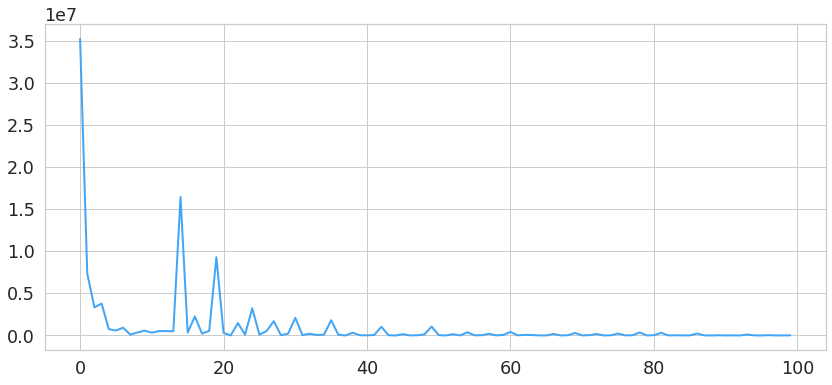

In [43]:
pd.Series(weight1)[:100].plot()

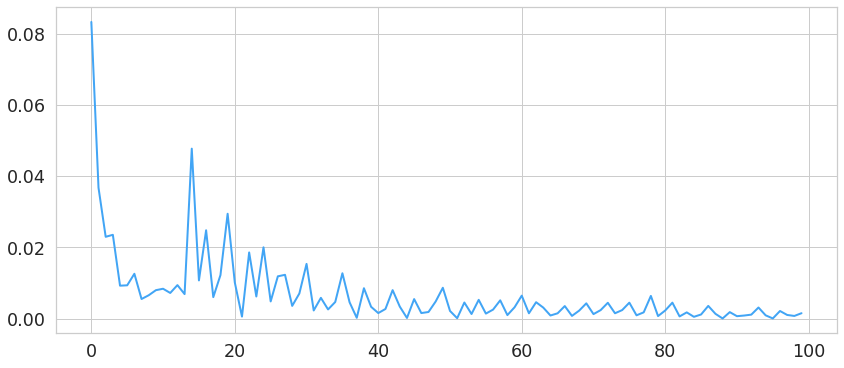

In [44]:
pd.Series(weight2)[:100].plot()

## LightGBM

In [ ]:
for day in range(28):
    all_df = add_lag_by_model(all_df, lag=day)

In [45]:
# going to evaluate with the last 28 days
x_train = all_df[all_df["date"] <= "2016-04-24"]
y_train = x_train["sales"]
x_val = all_df[(all_df["date"] > "2016-04-24") & (all_df["date"] <= "2016-05-22")]
y_val = x_val["sales"]
test = all_df[(all_df["date"] > "2016-05-22")]

del all_df
gc.collect()

35

In [46]:
x_train.index = x_train["id"]
x_val.index = x_val["id"]
x_train["weight"] = each_ids_weight
x_val["weight"] = each_ids_weight

In [ ]:
x_train.columns

In [47]:
categoricals = ["item_id", "dept_id", "store_id", "cat_id", "state_id"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday", "weight", "event_name_1", "event_name_2", "event_type_1", "event_type_2"]
features = x_train.columns[~x_train.columns.isin(useless_cols)]

train_set = lgb.Dataset(x_train[features], y_train, weight=x_train["weight"], categorical_feature=categoricals, free_raw_data=False)
val_set = lgb.Dataset(x_val[features], y_val, weight=x_val["weight"], categorical_feature=categoricals, free_raw_data=False)

In [48]:
# params = {
#     "boosting_type": "gbdt",
#     "metric": "custom",
#     "objective": "custom",
#     "n_jobs": -1,
#     "seed": 236,
#     "learning_rate": 0.01,
#     "bagging_fraction": 0.75,
#     "bagging_freq": 10, 
#     "colsample_bytree": 0.75
# }

params = {
    "boosting_type": "gbdt",
    "metric": "custom",
    "objective": "poisson",
    "learning_rate" : 0.075,
    # "sub_feature" : 0.8,
    "bagging_fraction" : 0.75,
    "bagging_freq" : 1,
    "lambda_l2" : 0.1,
    # "nthread" : 4
    'verbosity': 1,
    'num_iterations' : 1200,
    'num_leaves': 128,
    "min_data_in_leaf": 100,
}
poisson_max_delta_step = 0.7

# model estimation
model = lgb.train(params, train_set, num_boost_round=100, early_stopping_rounds=50, 
                  valid_sets=[train_set, val_set], verbose_eval=100, feval=wrmsse)
val_pred = model.predict(x_val[features])
y_pred = model.predict(test[features])
x_val["sales"] = val_pred
test["sales"] = y_pred

Training until validation scores don't improve for 50 rounds
[100]	training's wrmsse: 1.09701	valid_1's wrmsse: 0.597024
[200]	training's wrmsse: 0.912278	valid_1's wrmsse: 0.573143
Early stopping, best iteration is:
[204]	training's wrmsse: 0.912022	valid_1's wrmsse: 0.572264


findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans.


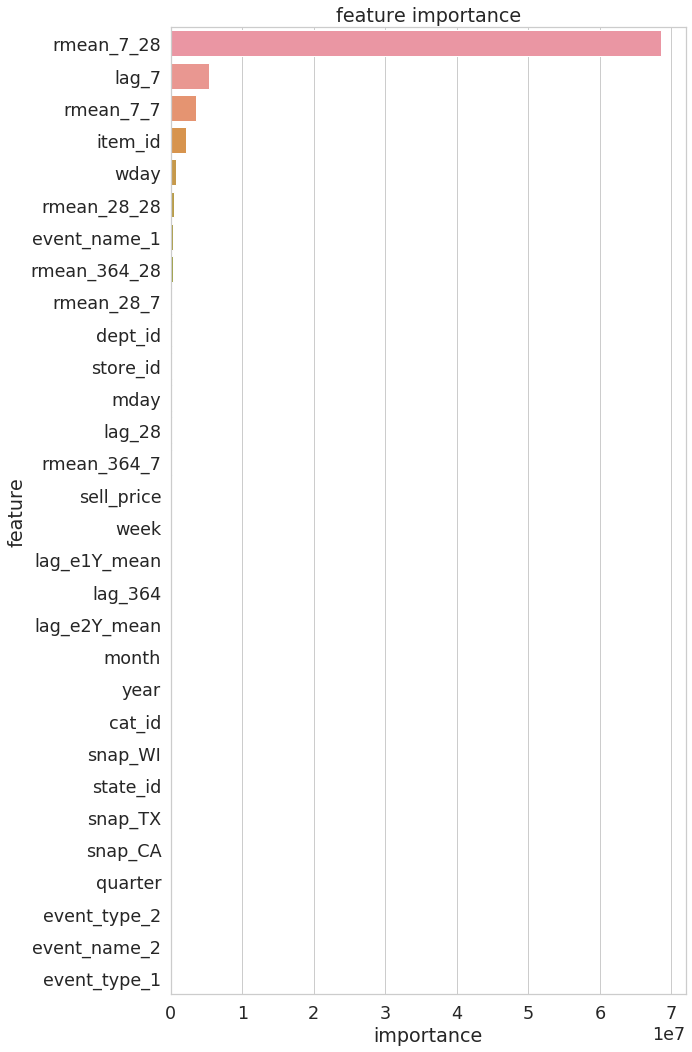

feature    importance
0        item_id  2.111988e+06
1        dept_id  1.679562e+05
2       store_id  1.632137e+05
3         cat_id  2.384639e+04
4       state_id  1.735899e+04
5           wday  7.427912e+05
6          month  2.792932e+04
7           year  2.644020e+04
8   event_name_1  2.535669e+05
9   event_type_1  0.000000e+00
10  event_name_2  0.000000e+00
11  event_type_2  0.000000e+00
12       snap_CA  9.348475e+02
13       snap_TX  6.151485e+03
14       snap_WI  2.180520e+04
15    sell_price  1.060067e+05
16         lag_7  5.389236e+06
17        lag_28  1.343677e+05
18       lag_364  5.948543e+04
19     rmean_7_7  3.591382e+06
20    rmean_28_7  1.699028e+05
21   rmean_364_7  1.198802e+05
22    rmean_7_28  6.856524e+07
23   rmean_28_28  5.120981e+05
24  rmean_364_28  2.526372e+05
25  lag_e1Y_mean  9.424441e+04
26  lag_e2Y_mean  3.878317e+04
27          week  1.028240e+05
28       quarter  6.740220e+01
29          mday  1.563500e+05

In [49]:
def display_feature_importance(feature_importance_df):
    cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df.loc[feature_importance_df["feature"].isin(cols)]
    plt.figure(figsize=(10, 15))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title("feature importance")
    plt.tight_layout()
    plt.show()


feature_importance = pd.DataFrame(x_train[features].columns, columns=["feature"])
feature_importance["importance"] = model.feature_importance(importance_type="gain")
display_feature_importance(feature_importance)
feature_importance

In [50]:
x_val_rep = x_val.copy()
x_val_rep.index = x_val_rep["id"].str.replace("evaluation", "validation")
x_val_rep["id"] = x_val_rep["id"].str.replace("evaluation", "validation")

In [51]:
predictions_valid = x_val_rep[["id", "date", "sales"]]
predictions_valid = pd.pivot(predictions_valid, index = "id", columns = "date", values = "sales").reset_index()
predictions_valid.columns = ["id"] + ["F" + str(i + 1) for i in range(28)]
predictions_valid

id        F1        F2        F3  \
0          FOODS_1_001_CA_1_validation  1.041347  0.894941  0.884778   
1          FOODS_1_001_CA_2_validation  1.099673  1.105841  1.042071   
2          FOODS_1_001_CA_3_validation  1.087951  1.045026  1.018171   
3          FOODS_1_001_CA_4_validation  0.357005  0.346901  0.324079   
4          FOODS_1_001_TX_1_validation  0.204439  0.205190  0.199320   
...                                ...       ...       ...       ...   
30485  HOUSEHOLD_2_516_TX_2_validation  0.256958  0.230114  0.250854   
30486  HOUSEHOLD_2_516_TX_3_validation  0.156155  0.141690  0.150430   
30487  HOUSEHOLD_2_516_WI_1_validation  0.100941  0.093380  0.098521   
30488  HOUSEHOLD_2_516_WI_2_validation  0.053057  0.052432  0.052884   
30489  HOUSEHOLD_2_516_WI_3_validation  0.057812  0.061425  0.056289   

             F4        F5        F6        F7        F8        F9  ...  \
0      0.852343  1.085516  1.229604  1.183803  1.025861  0.958904  ...   
1      1.465345  1.352389  1.597360  1.600499  0.884704  1.067951  ...   
2      1.021239  1.082915  1.251109  0.907076  0.907338  0.826487  ...   
3      0.324079  0.365874  0.397504  0.445671  0.327528  0.367338  ...   
4      0.187802  0.164252  0.161314  0.165226  0.157756  0.149252  ...   
...         ...       ...       ...       ...       ...       ...  ...   
30485  0.251842  0.299171  0.354969  0.374503  0.271131  0.258028  ...   
30486  0.142924  0.163275  0.181681  0.179856  0.142587  0.128926  ...   
30487  0.094153  0.092332  0.103351  0.099743  0.111889  0.097626  ...   
30488  0.097008  0.110733  0.104657  0.104997  0.098946  0.092385  ...   
30489  0.056289  0.065416  0.066696  0.072958  0.063243  0.061378  ...   

            F19       F20       F21       F22       F23       F24       F25  \
0      1.087892  1.212836  1.161172  0.913526  0.881347  0.779924  0.780627   
1      0.970314  1.183060  0.781394  0.876458  0.917444  0.916949  0.893728   
2      1.001981  1.165963  1.060378  0.843359  0.768660  0.788109  0.788109   
3      0.281506  0.354583  0.337239  0.271397  0.271017  0.258416  0.260494   
4      0.346307  0.635578  0.534396  0.337481  0.360761  0.340801  0.389356   
...         ...       ...       ...       ...       ...       ...       ...   
30485  0.266025  0.347184  0.332068  0.231082  0.217246  0.216087  0.215811   
30486  0.173156  0.181309  0.197908  0.155394  0.142879  0.142879  0.144869   
30487  0.110175  0.167490  0.157927  0.125926  0.116488  0.117780  0.120924   
30488  0.083846  0.091608  0.090770  0.076710  0.075230  0.075054  0.073160   
30489  0.089194  0.090857  0.090009  0.079483  0.079446  0.087172  0.075949   

            F26       F27       F28  
0      0.991900  1.256158  1.191782  
1      1.084039  1.314603  0.954332  
2      0.891276  1.065363  0.885935  
3      0.312542  0.331440  0.351694  
4      0.475212  0.548401  0.593581  
...         ...       ...       ...  
30485  0.256320  0.267878  0.219832  
30486  0.189984  0.229548  0.228493  
30487  0.129151  0.153299  0.148954  
30488  0.083036  0.086028  0.109623  
30489  0.101840  0.136917  0.120693  

[30490 rows x 29 columns]

In [52]:
predictions_valid.loc[:, "F1":] = np.clip(predictions_valid.loc[:, "F1":].values, 0, a_max=None)
predictions_valid

id        F1        F2        F3  \
0          FOODS_1_001_CA_1_validation  1.041347  0.894941  0.884778   
1          FOODS_1_001_CA_2_validation  1.099673  1.105841  1.042071   
2          FOODS_1_001_CA_3_validation  1.087951  1.045026  1.018171   
3          FOODS_1_001_CA_4_validation  0.357005  0.346901  0.324079   
4          FOODS_1_001_TX_1_validation  0.204439  0.205190  0.199320   
...                                ...       ...       ...       ...   
30485  HOUSEHOLD_2_516_TX_2_validation  0.256958  0.230114  0.250854   
30486  HOUSEHOLD_2_516_TX_3_validation  0.156155  0.141690  0.150430   
30487  HOUSEHOLD_2_516_WI_1_validation  0.100941  0.093380  0.098521   
30488  HOUSEHOLD_2_516_WI_2_validation  0.053057  0.052432  0.052884   
30489  HOUSEHOLD_2_516_WI_3_validation  0.057812  0.061425  0.056289   

             F4        F5        F6        F7        F8        F9  ...  \
0      0.852343  1.085516  1.229604  1.183803  1.025861  0.958904  ...   
1      1.465345  1.352389  1.597360  1.600499  0.884704  1.067951  ...   
2      1.021239  1.082915  1.251109  0.907076  0.907338  0.826487  ...   
3      0.324079  0.365874  0.397504  0.445671  0.327528  0.367338  ...   
4      0.187802  0.164252  0.161314  0.165226  0.157756  0.149252  ...   
...         ...       ...       ...       ...       ...       ...  ...   
30485  0.251842  0.299171  0.354969  0.374503  0.271131  0.258028  ...   
30486  0.142924  0.163275  0.181681  0.179856  0.142587  0.128926  ...   
30487  0.094153  0.092332  0.103351  0.099743  0.111889  0.097626  ...   
30488  0.097008  0.110733  0.104657  0.104997  0.098946  0.092385  ...   
30489  0.056289  0.065416  0.066696  0.072958  0.063243  0.061378  ...   

            F19       F20       F21       F22       F23       F24       F25  \
0      1.087892  1.212836  1.161172  0.913526  0.881347  0.779924  0.780627   
1      0.970314  1.183060  0.781394  0.876458  0.917444  0.916949  0.893728   
2      1.001981  1.165963  1.060378  0.843359  0.768660  0.788109  0.788109   
3      0.281506  0.354583  0.337239  0.271397  0.271017  0.258416  0.260494   
4      0.346307  0.635578  0.534396  0.337481  0.360761  0.340801  0.389356   
...         ...       ...       ...       ...       ...       ...       ...   
30485  0.266025  0.347184  0.332068  0.231082  0.217246  0.216087  0.215811   
30486  0.173156  0.181309  0.197908  0.155394  0.142879  0.142879  0.144869   
30487  0.110175  0.167490  0.157927  0.125926  0.116488  0.117780  0.120924   
30488  0.083846  0.091608  0.090770  0.076710  0.075230  0.075054  0.073160   
30489  0.089194  0.090857  0.090009  0.079483  0.079446  0.087172  0.075949   

            F26       F27       F28  
0      0.991900  1.256158  1.191782  
1      1.084039  1.314603  0.954332  
2      0.891276  1.065363  0.885935  
3      0.312542  0.331440  0.351694  
4      0.475212  0.548401  0.593581  
...         ...       ...       ...  
30485  0.256320  0.267878  0.219832  
30486  0.189984  0.229548  0.228493  
30487  0.129151  0.153299  0.148954  
30488  0.083036  0.086028  0.109623  
30489  0.101840  0.136917  0.120693  

[30490 rows x 29 columns]

In [53]:
predictions_eval = test[["id", "date", "sales"]]
predictions_eval = pd.pivot(predictions_eval, index = "id", columns = "date", values = "sales").reset_index()
predictions_eval.columns = ["id"] + ["F" + str(i + 1) for i in range(28)]
predictions_eval

id        F1        F2        F3  \
0          FOODS_1_001_CA_1_evaluation  0.837617  0.765895  0.760981   
1          FOODS_1_001_CA_2_evaluation  0.866178  0.847359  0.735050   
2          FOODS_1_001_CA_3_evaluation  0.692219  0.666944  0.711569   
3          FOODS_1_001_CA_4_evaluation  0.248459  0.257321  0.292619   
4          FOODS_1_001_TX_1_evaluation  0.547820  1.033355  0.664992   
...                                ...       ...       ...       ...   
30485  HOUSEHOLD_2_516_TX_2_evaluation  0.216998  0.193854  0.175110   
30486  HOUSEHOLD_2_516_TX_3_evaluation  0.173946  0.149008  0.144759   
30487  HOUSEHOLD_2_516_WI_1_evaluation  0.117556  0.110619  0.111572   
30488  HOUSEHOLD_2_516_WI_2_evaluation  0.103958  0.097198  0.098277   
30489  HOUSEHOLD_2_516_WI_3_evaluation  0.107951  0.099763  0.099961   

             F4        F5        F6        F7        F8        F9  ...  \
0      0.855176  0.796835  0.868446  0.804503  0.787825  0.671413  ...   
1      0.681291  0.818308  1.076794  0.868767  0.769942  0.764086  ...   
2      0.677023  0.937737  1.061723  1.144711  0.827054  0.811938  ...   
3      0.299284  0.298792  0.315518  0.315020  0.652156  0.660540  ...   
4      0.785895  0.890578  0.881482  1.041999  0.629169  0.681122  ...   
...         ...       ...       ...       ...       ...       ...  ...   
30485  0.169081  0.206009  0.243815  0.247495  0.420264  0.359563  ...   
30486  0.144421  0.187334  0.273136  0.277035  0.363644  0.325786  ...   
30487  0.113860  0.142447  0.165395  0.160708  0.350625  0.321682  ...   
30488  0.096791  0.112919  0.112940  0.105674  0.360078  0.345571  ...   
30489  0.099961  0.109829  0.104781  0.096314  0.359881  0.336538  ...   

            F19       F20       F21       F22       F23       F24       F25  \
0      0.904406  0.614527  0.608796  0.648983  0.666184  0.658783  0.722755   
1      0.977339  0.716362  0.690697  0.710563  0.723598  0.742120  0.775133   
2      1.137579  0.692176  0.705076  0.819970  0.813162  0.790922  0.873314   
3      0.802826  0.595279  0.601977  0.642238  0.641558  0.647001  0.723275   
4      0.818446  0.618797  0.621077  0.651030  0.653469  0.692824  0.717680   
...         ...       ...       ...       ...       ...       ...       ...   
30485  0.491631  0.480644  0.476961  0.367277  0.345659  0.354036  0.370781   
30486  0.427711  0.404053  0.394844  0.328954  0.311600  0.308626  0.327625   
30487  0.422995  0.434522  0.423542  0.347214  0.319626  0.321891  0.339076   
30488  0.455616  0.431953  0.401624  0.323218  0.312012  0.314657  0.337824   
30489  0.456960  0.401059  0.397952  0.346496  0.324558  0.327249  0.341010   

            F26       F27       F28  
0      0.877928  0.682693  0.686867  
1      0.952839  0.675621  0.726296  
2      1.006332  0.722275  0.690656  
3      0.845191  0.597735  0.605235  
4      0.821129  0.609629  0.614376  
...         ...       ...       ...  
30485  0.496921  0.475533  0.449515  
30486  0.430495  0.420211  0.396249  
30487  0.424452  0.417899  0.388174  
30488  0.429772  0.398315  0.389322  
30489  0.428336  0.425893  0.407207  

[30490 rows x 29 columns]

In [54]:
predictions_eval.loc[:, "F1":] = np.clip(predictions_eval.loc[:, "F1":].values, 0, a_max=None)
predictions_eval

id        F1        F2        F3  \
0          FOODS_1_001_CA_1_evaluation  0.837617  0.765895  0.760981   
1          FOODS_1_001_CA_2_evaluation  0.866178  0.847359  0.735050   
2          FOODS_1_001_CA_3_evaluation  0.692219  0.666944  0.711569   
3          FOODS_1_001_CA_4_evaluation  0.248459  0.257321  0.292619   
4          FOODS_1_001_TX_1_evaluation  0.547820  1.033355  0.664992   
...                                ...       ...       ...       ...   
30485  HOUSEHOLD_2_516_TX_2_evaluation  0.216998  0.193854  0.175110   
30486  HOUSEHOLD_2_516_TX_3_evaluation  0.173946  0.149008  0.144759   
30487  HOUSEHOLD_2_516_WI_1_evaluation  0.117556  0.110619  0.111572   
30488  HOUSEHOLD_2_516_WI_2_evaluation  0.103958  0.097198  0.098277   
30489  HOUSEHOLD_2_516_WI_3_evaluation  0.107951  0.099763  0.099961   

             F4        F5        F6        F7        F8        F9  ...  \
0      0.855176  0.796835  0.868446  0.804503  0.787825  0.671413  ...   
1      0.681291  0.818308  1.076794  0.868767  0.769942  0.764086  ...   
2      0.677023  0.937737  1.061723  1.144711  0.827054  0.811938  ...   
3      0.299284  0.298792  0.315518  0.315020  0.652156  0.660540  ...   
4      0.785895  0.890578  0.881482  1.041999  0.629169  0.681122  ...   
...         ...       ...       ...       ...       ...       ...  ...   
30485  0.169081  0.206009  0.243815  0.247495  0.420264  0.359563  ...   
30486  0.144421  0.187334  0.273136  0.277035  0.363644  0.325786  ...   
30487  0.113860  0.142447  0.165395  0.160708  0.350625  0.321682  ...   
30488  0.096791  0.112919  0.112940  0.105674  0.360078  0.345571  ...   
30489  0.099961  0.109829  0.104781  0.096314  0.359881  0.336538  ...   

            F19       F20       F21       F22       F23       F24       F25  \
0      0.904406  0.614527  0.608796  0.648983  0.666184  0.658783  0.722755   
1      0.977339  0.716362  0.690697  0.710563  0.723598  0.742120  0.775133   
2      1.137579  0.692176  0.705076  0.819970  0.813162  0.790922  0.873314   
3      0.802826  0.595279  0.601977  0.642238  0.641558  0.647001  0.723275   
4      0.818446  0.618797  0.621077  0.651030  0.653469  0.692824  0.717680   
...         ...       ...       ...       ...       ...       ...       ...   
30485  0.491631  0.480644  0.476961  0.367277  0.345659  0.354036  0.370781   
30486  0.427711  0.404053  0.394844  0.328954  0.311600  0.308626  0.327625   
30487  0.422995  0.434522  0.423542  0.347214  0.319626  0.321891  0.339076   
30488  0.455616  0.431953  0.401624  0.323218  0.312012  0.314657  0.337824   
30489  0.456960  0.401059  0.397952  0.346496  0.324558  0.327249  0.341010   

            F26       F27       F28  
0      0.877928  0.682693  0.686867  
1      0.952839  0.675621  0.726296  
2      1.006332  0.722275  0.690656  
3      0.845191  0.597735  0.605235  
4      0.821129  0.609629  0.614376  
...         ...       ...       ...  
30485  0.496921  0.475533  0.449515  
30486  0.430495  0.420211  0.396249  
30487  0.424452  0.417899  0.388174  
30488  0.429772  0.398315  0.389322  
30489  0.428336  0.425893  0.407207  

[30490 rows x 29 columns]

In [55]:
validation_rows = [row for row in submission["id"] if "validation" in row] 
evaluation_rows = [row for row in submission["id"] if "evaluation" in row] 

# predictions_valid, evalはidの順番が違うので、submissionに合わせる意味で必要
validation = submission[submission["id"].isin(validation_rows)]
evaluation = submission[submission["id"].isin(evaluation_rows)]

validation = validation[["id"]].merge(predictions_valid, on = "id")
evaluation = evaluation[["id"]].merge(predictions_eval, on = "id")

final = pd.concat([validation, evaluation])
final.to_csv("case11_eval_poissonweighted_lag_submission.csv", index = False)

## Transformer 

In [43]:
all_df = all_df.query("date.dt.year >= 2014")

In [44]:
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday", "weight"]
features = all_df.columns[~all_df.columns.isin(useless_cols)]
features, features.shape

(Index(['item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 'wday', 'month',
        'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
        'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
       dtype='object'),
 (16,))

In [45]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [46]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [47]:
class Embedder(nn.Module):
    '''idで示されている単語をベクトルに変換します'''

    def __init__(self, text_embedding_vectors):
        super(Embedder, self).__init__()

        self.embeddings = nn.Embedding.from_pretrained(
            embeddings=text_embedding_vectors, freeze=True)
        # freeze=Trueによりバックプロパゲーションで更新されず変化しなくなります

    def forward(self, x):
        x_vec = self.embeddings(x)

        return x_vec


In [48]:
class PositionalEncoder(nn.Module):
    '''入力された単語の位置を示すベクトル情報を付加する'''

    def __init__(self, d_model=300, max_seq_len=256):
        super().__init__()

        self.d_model = d_model  # 単語ベクトルの次元数

        # 単語の順番（pos）と埋め込みベクトルの次元の位置（i）によって一意に定まる値の表をpeとして作成
        pe = torch.zeros(max_seq_len, d_model)

        # GPUが使える場合はGPUへ送る、ここでは省略。実際に学習時には使用する
        # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        # pe = pe.to(device)

        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                
                # 誤植修正_200510 #79
                # pe[pos, i + 1] = math.cos(pos /
                #                          (10000 ** ((2 * (i + 1))/d_model)))
                pe[pos, i + 1] = math.cos(pos /
                                          (10000 ** ((2 * i)/d_model)))

        # 表peの先頭に、ミニバッチ次元となる次元を足す
        self.pe = pe.unsqueeze(0)

        # 勾配を計算しないようにする
        self.pe.requires_grad = False

    def forward(self, x):

        # 入力xとPositonal Encodingを足し算する
        # xがpeよりも小さいので、大きくする
        ret = math.sqrt(self.d_model)*x + self.pe
        return ret


In [49]:
class Attention(nn.Module):
    '''Transformerは本当はマルチヘッドAttentionですが、
    分かりやすさを優先しシングルAttentionで実装します'''

    def __init__(self, d_model):
        super().__init__()

        # SAGANでは1dConvを使用したが、今回は全結合層で特徴量を変換する
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)

        # 出力時に使用する全結合層
        self.out = nn.Linear(d_model, d_model)

        # Attentionの大きさ調整の変数
        self.d_k = d_model

    def forward(self, q, k, v):
        # 全結合層で特徴量を変換
        k = self.k_linear(k)
        q = self.q_linear(q)
        v = self.v_linear(v)
        
        # Attentionの値を計算する
        # 各値を足し算すると大きくなりすぎるので、root(d_k)で割って調整
        weights = torch.matmul(q, k.transpose(0, 1)) / math.sqrt(self.d_k)

        # ここでmaskを計算
        #mask = mask.unsqueeze(1)
        #weights = weights.masked_fill(mask == 0, -1e9)

        # softmaxで規格化をする
        normlized_weights = F.softmax(weights, dim=-1)

        # AttentionをValueとかけ算
        output = torch.matmul(normlized_weights, v)

        # 全結合層で特徴量を変換
        output = self.out(output)

        return output, normlized_weights


In [50]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=1024, dropout=0.1):
        '''Attention層から出力を単純に全結合層2つで特徴量を変換するだけのユニットです'''
        super().__init__()

        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.dropout(F.relu(x))
        x = self.linear_2(x)
        return x


In [51]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super().__init__()

        # LayerNormalization層
        # https://pytorch.org/docs/stable/nn.html?highlight=layernorm
        self.norm_1 = nn.LayerNorm(d_model)
        self.norm_2 = nn.LayerNorm(d_model)

        # Attention層
        self.attn = Attention(d_model)

        # Attentionのあとの全結合層2つ
        self.ff = FeedForward(d_model)

        # Dropout
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x):
        # 正規化とAttention
        x_normlized = self.norm_1(x)
        output, normlized_weights = self.attn(
            x_normlized, x_normlized, x_normlized)
        
        x2 = x + self.dropout_1(output)

        # 正規化と全結合層
        x_normlized2 = self.norm_2(x2)
        output = x2 + self.dropout_2(self.ff(x_normlized2))

        return output, normlized_weights


In [52]:
class RegressionHead(nn.Module):
    '''Transformer_Blockの出力を使用し、最後に予測する'''

    def __init__(self, d_model, output_dim):
        super().__init__()

        # 全結合層
        self.linear = nn.Linear(d_model, output_dim)  # output_dimはポジ・ネガの2つ

        # 重み初期化処理
        nn.init.normal_(self.linear.weight, std=0.02)
        nn.init.normal_(self.linear.bias, 0)

    def forward(self, x):
        #x0 = x[:, 0, :]  # 各ミニバッチの各文の先頭の単語の特徴量（300次元）を取り出す
        out = self.linear(x)

        return out


In [53]:
# 最終的なTransformerモデルのクラス

class TransformerRegression(nn.Module):
    '''Transformerで予測する'''

    def __init__(self, d_model, output_dim):
        super().__init__()

        # モデル構築
        #self.net1 = Embedder(text_embedding_vectors)
        #self.net2 = PositionalEncoder(d_model=d_model, max_seq_len=max_seq_len)
        self.net3_1 = TransformerBlock(d_model=d_model)
        self.net3_2 = TransformerBlock(d_model=d_model)
        self.net4 = RegressionHead(output_dim=output_dim, d_model=d_model)

    def forward(self, x):
        #x1 = self.net1(x)  # 単語をベクトルに
        #x2 = self.net2(x1)  # Positon情報を足し算
        x3_1, normlized_weights_1 = self.net3_1(x)  # Self-Attentionで特徴量を変換
        x3_2, normlized_weights_2 = self.net3_2(x3_1)  # Self-Attentionで特徴量を変換
        x4 = self.net4(x3_2)  # 最終出力の0単語目を使用して、分類0-1のスカラーを出力
        return x4, normlized_weights_1, normlized_weights_2


In [54]:
# # モデル構築
# net = TransformerRegression(d_model=len(features), output_dim=1)

# # ネットワークの初期化を定義
# def weights_init(m):
#     classname = m.__class__.__name__
#     if classname.find('Linear') != -1:
#         # Liner層の初期化
#         nn.init.kaiming_normal_(m.weight)
#         if m.bias is not None:
#             nn.init.constant_(m.bias, 0.0)


# # 訓練モードに設定
# net.train()

# # TransformerBlockモジュールを初期化実行
# net.net3_1.apply(weights_init)
# net.net3_2.apply(weights_init)


# print('ネットワーク設定完了')

In [55]:
# # 損失関数の設定
# criterion = nn.MSELoss()

# # 最適化手法の設定
# learning_rate = 0.0005
# optimizer = optim.Adam(net.parameters(), lr=learning_rate)


In [56]:
# モデルを学習させる関数を作成
def train_model(net, data_df, criterion, optimizer, num_epochs):
    
    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True
        
    x_train = data_df[data_df["date"] <= "2016-04-24"]
    y_train = x_train["sales"]
    x_val = data_df[(data_df["date"] > "2016-04-24") & (data_df["date"] <= "2016-05-22")]
    y_val = x_val["sales"]
    
    
    BATCH_SIZE = 32
    train_data = torch.utils.data.TensorDataset(torch.from_numpy(x_train[features].values).float(), torch.from_numpy(y_train.values).float())
    valid_data = torch.utils.data.TensorDataset(torch.from_numpy(x_val[features].values).float(), torch.from_numpy(y_val.values).float())
    train_iter = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)
    valid_iter = torch.utils.data.DataLoader(valid_data, batch_size=1, shuffle=False)
    dataloaders_dict = {"train": train_iter, "valid": valid_iter}
    
    del x_train, y_train, x_val, y_val, train_data, valid_data, train_iter, valid_iter
    gc.collect()
    
    # epochのループ
    for epoch in range(num_epochs):
        
        # epochごとの訓練と検証のループ
        for phase in ['train', 'valid']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_eval = 0.0  # epochの評価値

            # データローダーからミニバッチを取り出すループ
            for batch in (dataloaders_dict[phase]):
                # batchはTextとLableの辞書オブジェクト
                
                # GPUが使えるならGPUにデータを送る
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):

                    # mask作成
                    #input_pad = 1  # 単語のIDにおいて、'<pad>': 1 なので
                    #input_mask = (inputs != input_pad)
                    
                    # Transformerに入力
                    preds, _, _ = net(inputs)
                    loss = criterion(preds, labels)  # 損失を計算

                    y_pred = preds.to('cpu').detach().numpy().ravel()
                    y_true = labels.data.to('cpu').detach().numpy().ravel()
                    
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # 結果の計算
                    epoch_loss += loss.item() * inputs.size(0)  # lossの合計を更新
                    # 正解数の合計を更新
                    epoch_eval += np.mean(np.square(y_pred - y_true))

            # epochごとのlossと正解率
            if epoch == num_epochs-1:
                epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
                epoch_eval = epoch_eval / len(dataloaders_dict[phase].dataset)

                print('Epoch {}/{} | {:^5} |  Loss: {:.4f} Eval: {:.4f}'.format(epoch+1, num_epochs,
                                                                               phase, epoch_loss, epoch_eval))

    return net

In [57]:
# # 学習・検証を実行する 15分ほどかかります
# num_epochs = 10
# # GPUが使えるかを確認
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print("使用デバイス：", device)
# print('-------start-------')
# net_trained = train_model(net, all_df.query("id == 'FOODS_1_187_CA_2_evaluation'").reset_index(drop=True),
#                           criterion, optimizer, num_epochs=num_epochs)


In [58]:
num_epochs = 10
# GPUが使えるかを確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test = all_df[(all_df["date"] > "2016-05-22")]
x_val = all_df[(all_df["date"] > "2016-04-24") & (all_df["date"] <= "2016-05-22")]

for _id in tqdm(product["id"].values, total=len(product)):
    print(_id)
    
    # モデル構築
    net = TransformerRegression(d_model=len(features), output_dim=1)

    # ネットワークの初期化を定義
    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Linear') != -1:
            # Liner層の初期化
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.0)


    # 訓練モードに設定
    net.train()

    # TransformerBlockモジュールを初期化実行
    net.net3_1.apply(weights_init)
    net.net3_2.apply(weights_init)
    
    # 損失関数の設定
    criterion = nn.MSELoss()

    # 最適化手法の設定
    learning_rate = 0.0003
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    net_trained = train_model(net, all_df.query("id == @_id").reset_index(drop=True), criterion, optimizer, num_epochs=num_epochs)
        
    net_trained.eval()   # モデルを検証モードに
    net_trained.to(device)
    
    val_data = x_val.query("id == @_id")
    test_data = test.query("id == @_id")
    val_id_idx = val_data.index
    test_id_idx = test_data.index
    
    val_data = torch.from_numpy(val_data[features].values).float().to(device)
    test_data = torch.from_numpy(test_data[features].values).float().to(device)
    
    # 順伝搬（forward）計算
    with torch.set_grad_enabled(False):
        # Transformerに入力
        val_preds, _, _ = net_trained(val_data)
        val_preds = val_preds.to('cpu').detach().numpy().ravel()
        test_preds, _, _ = net_trained(test_data)
        test_preds = test_preds.to('cpu').detach().numpy().ravel()
        #preds = pd.Series(preds, index=id_idx)
        #display(preds)
    x_val.loc[val_id_idx, "sales"] = val_preds
    test.loc[test_id_idx, "sales"] = test_preds

HOBBIES_1_001_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.1958 Eval: 0.0383
Epoch 10/10 | valid |  Loss: 2.4844 Eval: 2.4844
HOBBIES_1_002_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.4186 Eval: 0.0131
Epoch 10/10 | valid |  Loss: 0.2884 Eval: 0.2884
HOBBIES_1_003_CA_1_evaluation
Epoch 10/10 | train |  Loss: 9.8697 Eval: 0.3226
Epoch 10/10 | valid |  Loss: 1.6030 Eval: 1.6030
HOBBIES_1_004_CA_1_evaluation
Epoch 10/10 | train |  Loss: 5.4772 Eval: 0.1753
Epoch 10/10 | valid |  Loss: 3.0684 Eval: 3.0684
HOBBIES_1_005_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.7823 Eval: 0.0585
Epoch 10/10 | valid |  Loss: 1.1834 Eval: 1.1834
HOBBIES_1_006_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.6042 Eval: 0.0829
Epoch 10/10 | valid |  Loss: 2.6147 Eval: 2.6147
HOBBIES_1_007_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.6368 Eval: 0.0195
Epoch 10/10 | valid |  Loss: 0.2685 Eval: 0.2685
HOBBIES_1_008_CA_1_evaluation
Epoch 10/10 | train |  Loss: 99.8953 Eval: 3.3018
Epoch 10/10 | valid |  L

Epoch 10/10 | train |  Loss: 2.5770 Eval: 0.0838
Epoch 10/10 | valid |  Loss: 0.7538 Eval: 0.7538
HOBBIES_1_067_CA_1_evaluation
Epoch 10/10 | train |  Loss: 30.9640 Eval: 0.9836
Epoch 10/10 | valid |  Loss: 50.0351 Eval: 50.0351
HOBBIES_1_068_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.2487 Eval: 0.0394
Epoch 10/10 | valid |  Loss: 0.7165 Eval: 0.7165
HOBBIES_1_069_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.4101 Eval: 0.0132
Epoch 10/10 | valid |  Loss: 0.2420 Eval: 0.2420
HOBBIES_1_070_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.1274 Eval: 0.0041
Epoch 10/10 | valid |  Loss: 0.1258 Eval: 0.1258
HOBBIES_1_072_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.1276 Eval: 0.0364
Epoch 10/10 | valid |  Loss: 1.4686 Eval: 1.4686
HOBBIES_1_073_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.4770 Eval: 0.0157
Epoch 10/10 | valid |  Loss: 0.3431 Eval: 0.3431
HOBBIES_1_074_CA_1_evaluation
Epoch 10/10 | train |  Loss: 3.1025 Eval: 0.0975
Epoch 10/10 | valid |  Loss: 2.4461 Eval: 2.4461
HOB

Epoch 10/10 | train |  Loss: 0.5262 Eval: 0.0164
Epoch 10/10 | valid |  Loss: 0.3540 Eval: 0.3540
HOBBIES_1_134_CA_1_evaluation
Epoch 10/10 | train |  Loss: 9.7350 Eval: 0.3227
Epoch 10/10 | valid |  Loss: 8.6580 Eval: 8.6580
HOBBIES_1_135_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.5690 Eval: 0.0187
Epoch 10/10 | valid |  Loss: 0.4224 Eval: 0.4224
HOBBIES_1_136_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.1761 Eval: 0.0058
Epoch 10/10 | valid |  Loss: 0.0992 Eval: 0.0992
HOBBIES_1_137_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.5474 Eval: 0.0490
Epoch 10/10 | valid |  Loss: 1.0724 Eval: 1.0724
HOBBIES_1_138_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.2346 Eval: 0.0069
Epoch 10/10 | valid |  Loss: 0.4703 Eval: 0.4703
HOBBIES_1_139_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.8292 Eval: 0.0581
Epoch 10/10 | valid |  Loss: 1.5103 Eval: 1.5103
HOBBIES_1_140_CA_1_evaluation
Epoch 10/10 | train |  Loss: 3.4233 Eval: 0.1085
Epoch 10/10 | valid |  Loss: 4.5102 Eval: 4.5102
HOBBIE

Epoch 10/10 | train |  Loss: 0.2972 Eval: 0.0095
Epoch 10/10 | valid |  Loss: 0.6430 Eval: 0.6430
HOBBIES_1_200_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.0684 Eval: 0.0333
Epoch 10/10 | valid |  Loss: 0.8234 Eval: 0.8234
HOBBIES_1_201_CA_1_evaluation
Epoch 10/10 | train |  Loss: 8.6070 Eval: 0.2743
Epoch 10/10 | valid |  Loss: 1.0926 Eval: 1.0926
HOBBIES_1_202_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.4420 Eval: 0.0780
Epoch 10/10 | valid |  Loss: 1.5575 Eval: 1.5575
HOBBIES_1_203_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.7888 Eval: 0.0254
Epoch 10/10 | valid |  Loss: 0.4365 Eval: 0.4365
HOBBIES_1_204_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.1238 Eval: 0.0374
Epoch 10/10 | valid |  Loss: 0.8019 Eval: 0.8019
HOBBIES_1_205_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.1986 Eval: 0.0066
Epoch 10/10 | valid |  Loss: 0.1223 Eval: 0.1223
HOBBIES_1_206_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.8612 Eval: 0.0596
Epoch 10/10 | valid |  Loss: 1.1230 Eval: 1.1230
HOBBIE

Epoch 10/10 | train |  Loss: 0.6879 Eval: 0.0221
Epoch 10/10 | valid |  Loss: 0.4476 Eval: 0.4476
HOBBIES_1_265_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.5846 Eval: 0.0531
Epoch 10/10 | valid |  Loss: 0.2137 Eval: 0.2137
HOBBIES_1_266_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.2450 Eval: 0.0413
Epoch 10/10 | valid |  Loss: 1.3856 Eval: 1.3856
HOBBIES_1_267_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.8919 Eval: 0.0282
Epoch 10/10 | valid |  Loss: 0.1774 Eval: 0.1774
HOBBIES_1_268_CA_1_evaluation
Epoch 10/10 | train |  Loss: 118.0740 Eval: 3.7798
Epoch 10/10 | valid |  Loss: 151.6039 Eval: 151.6039
HOBBIES_1_269_CA_1_evaluation
Epoch 10/10 | train |  Loss: 6.8190 Eval: 0.2147
Epoch 10/10 | valid |  Loss: 1.1614 Eval: 1.1614
HOBBIES_1_270_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.2498 Eval: 0.0424
Epoch 10/10 | valid |  Loss: 0.9009 Eval: 0.9009
HOBBIES_1_271_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.6347 Eval: 0.0203
Epoch 10/10 | valid |  Loss: 0.2456 Eval: 0.2456


Epoch 10/10 | train |  Loss: 1.8843 Eval: 0.0614
Epoch 10/10 | valid |  Loss: 4.7829 Eval: 4.7829
HOBBIES_1_330_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.0583 Eval: 0.0331
Epoch 10/10 | valid |  Loss: 0.7997 Eval: 0.7997
HOBBIES_1_331_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.4065 Eval: 0.0765
Epoch 10/10 | valid |  Loss: 0.2886 Eval: 0.2886
HOBBIES_1_332_CA_1_evaluation
Epoch 10/10 | train |  Loss: 3.3784 Eval: 0.1167
Epoch 10/10 | valid |  Loss: 1.3861 Eval: 1.3861
HOBBIES_1_333_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.3856 Eval: 0.0119
Epoch 10/10 | valid |  Loss: 0.2838 Eval: 0.2838
HOBBIES_1_334_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.4469 Eval: 0.0457
Epoch 10/10 | valid |  Loss: 0.8482 Eval: 0.8482
HOBBIES_1_335_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.1061 Eval: 0.0033
Epoch 10/10 | valid |  Loss: 0.9236 Eval: 0.9236
HOBBIES_1_336_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.0779 Eval: 0.0024
Epoch 10/10 | valid |  Loss: 0.0125 Eval: 0.0125
HOBBIE

Epoch 10/10 | train |  Loss: 0.3542 Eval: 0.0117
Epoch 10/10 | valid |  Loss: 0.2520 Eval: 0.2520
HOBBIES_1_394_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.4617 Eval: 0.0773
Epoch 10/10 | valid |  Loss: 2.7725 Eval: 2.7725
HOBBIES_1_395_CA_1_evaluation
Epoch 10/10 | train |  Loss: 26.1656 Eval: 0.8225
Epoch 10/10 | valid |  Loss: 0.6425 Eval: 0.6425
HOBBIES_1_396_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.1574 Eval: 0.0050
Epoch 10/10 | valid |  Loss: 0.0732 Eval: 0.0732
HOBBIES_1_397_CA_1_evaluation
Epoch 10/10 | train |  Loss: 5.9565 Eval: 0.1910
Epoch 10/10 | valid |  Loss: 1.9074 Eval: 1.9074
HOBBIES_1_398_CA_1_evaluation
Epoch 10/10 | train |  Loss: 37.3400 Eval: 1.1828
Epoch 10/10 | valid |  Loss: 14.7400 Eval: 14.7400
HOBBIES_1_399_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.2281 Eval: 0.0393
Epoch 10/10 | valid |  Loss: 0.4146 Eval: 0.4146
HOBBIES_1_400_CA_1_evaluation
Epoch 10/10 | train |  Loss: 7.0287 Eval: 0.2170
Epoch 10/10 | valid |  Loss: 1.6984 Eval: 1.6984
HO

Epoch 10/10 | train |  Loss: 3.0373 Eval: 0.0951
Epoch 10/10 | valid |  Loss: 1.7886 Eval: 1.7886
HOBBIES_2_034_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.2434 Eval: 0.0079
Epoch 10/10 | valid |  Loss: 0.4614 Eval: 0.4614
HOBBIES_2_035_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.1740 Eval: 0.0059
Epoch 10/10 | valid |  Loss: 0.0904 Eval: 0.0904
HOBBIES_2_036_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.3228 Eval: 0.0768
Epoch 10/10 | valid |  Loss: 2.6589 Eval: 2.6589
HOBBIES_2_037_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.1783 Eval: 0.0057
Epoch 10/10 | valid |  Loss: 0.4507 Eval: 0.4507
HOBBIES_2_038_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.4107 Eval: 0.0130
Epoch 10/10 | valid |  Loss: 0.3098 Eval: 0.3098
HOBBIES_2_039_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.3557 Eval: 0.0109
Epoch 10/10 | valid |  Loss: 0.1339 Eval: 0.1339
HOBBIES_2_040_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.3414 Eval: 0.0117
Epoch 10/10 | valid |  Loss: 0.1707 Eval: 0.1707
HOBBIE

Epoch 10/10 | train |  Loss: 0.2329 Eval: 0.0075
Epoch 10/10 | valid |  Loss: 0.4595 Eval: 0.4595
HOBBIES_2_098_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.3940 Eval: 0.0431
Epoch 10/10 | valid |  Loss: 1.8627 Eval: 1.8627
HOBBIES_2_099_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.7863 Eval: 0.0570
Epoch 10/10 | valid |  Loss: 0.1090 Eval: 0.1090
HOBBIES_2_100_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.0139 Eval: 0.0633
Epoch 10/10 | valid |  Loss: 1.0230 Eval: 1.0230
HOBBIES_2_101_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.4347 Eval: 0.0141
Epoch 10/10 | valid |  Loss: 0.1819 Eval: 0.1819
HOBBIES_2_102_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.3668 Eval: 0.0118
Epoch 10/10 | valid |  Loss: 0.7829 Eval: 0.7829
HOBBIES_2_103_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.5813 Eval: 0.0796
Epoch 10/10 | valid |  Loss: 0.3649 Eval: 0.3649
HOBBIES_2_104_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.2703 Eval: 0.0086
Epoch 10/10 | valid |  Loss: 0.3843 Eval: 0.3843
HOBBIE

Epoch 10/10 | train |  Loss: 4.0244 Eval: 0.1325
Epoch 10/10 | valid |  Loss: 1.2021 Eval: 1.2021
HOUSEHOLD_1_013_CA_1_evaluation
Epoch 10/10 | train |  Loss: 11.7453 Eval: 0.3876
Epoch 10/10 | valid |  Loss: 1.6851 Eval: 1.6851
HOUSEHOLD_1_014_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.0147 Eval: 0.0326
Epoch 10/10 | valid |  Loss: 0.5283 Eval: 0.5283
HOUSEHOLD_1_015_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.3459 Eval: 0.0107
Epoch 10/10 | valid |  Loss: 0.1174 Eval: 0.1174
HOUSEHOLD_1_016_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.9290 Eval: 0.0975
Epoch 10/10 | valid |  Loss: 2.6470 Eval: 2.6470
HOUSEHOLD_1_017_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.5343 Eval: 0.0506
Epoch 10/10 | valid |  Loss: 0.9797 Eval: 0.9797
HOUSEHOLD_1_018_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.9656 Eval: 0.0312
Epoch 10/10 | valid |  Loss: 3.1773 Eval: 3.1773
HOUSEHOLD_1_019_CA_1_evaluation
Epoch 10/10 | train |  Loss: 11.6450 Eval: 0.3636
Epoch 10/10 | valid |  Loss: 14.9064 Ev

Epoch 10/10 | train |  Loss: 1.4464 Eval: 0.0450
Epoch 10/10 | valid |  Loss: 0.9993 Eval: 0.9993
HOUSEHOLD_1_078_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.1964 Eval: 0.0378
Epoch 10/10 | valid |  Loss: 0.7670 Eval: 0.7670
HOUSEHOLD_1_079_CA_1_evaluation
Epoch 10/10 | train |  Loss: 4.3640 Eval: 0.1374
Epoch 10/10 | valid |  Loss: 1.2918 Eval: 1.2918
HOUSEHOLD_1_080_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.4536 Eval: 0.0142
Epoch 10/10 | valid |  Loss: 0.5248 Eval: 0.5248
HOUSEHOLD_1_081_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.8513 Eval: 0.0277
Epoch 10/10 | valid |  Loss: 0.4560 Eval: 0.4560
HOUSEHOLD_1_082_CA_1_evaluation
Epoch 10/10 | train |  Loss: 5.7992 Eval: 0.1922
Epoch 10/10 | valid |  Loss: 1.9238 Eval: 1.9238
HOUSEHOLD_1_083_CA_1_evaluation
Epoch 10/10 | train |  Loss: 18.5765 Eval: 0.5859
Epoch 10/10 | valid |  Loss: 8.3017 Eval: 8.3017
HOUSEHOLD_1_085_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.2495 Eval: 0.0076
Epoch 10/10 | valid |  Loss: 0.1389 Eval

Epoch 10/10 | train |  Loss: 1.0126 Eval: 0.0325
Epoch 10/10 | valid |  Loss: 1.1503 Eval: 1.1503
HOUSEHOLD_1_143_CA_1_evaluation
Epoch 10/10 | train |  Loss: 7.8577 Eval: 0.2406
Epoch 10/10 | valid |  Loss: 1.9431 Eval: 1.9431
HOUSEHOLD_1_144_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.6529 Eval: 0.0231
Epoch 10/10 | valid |  Loss: 1.6259 Eval: 1.6259
HOUSEHOLD_1_145_CA_1_evaluation
Epoch 10/10 | train |  Loss: 3.7856 Eval: 0.1196
Epoch 10/10 | valid |  Loss: 5.8803 Eval: 5.8803
HOUSEHOLD_1_146_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.6288 Eval: 0.0526
Epoch 10/10 | valid |  Loss: 1.8772 Eval: 1.8772
HOUSEHOLD_1_147_CA_1_evaluation
Epoch 10/10 | train |  Loss: 12.0512 Eval: 0.3809
Epoch 10/10 | valid |  Loss: 3.2187 Eval: 3.2187
HOUSEHOLD_1_148_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.1889 Eval: 0.0379
Epoch 10/10 | valid |  Loss: 0.3549 Eval: 0.3549
HOUSEHOLD_1_149_CA_1_evaluation
Epoch 10/10 | train |  Loss: 7.0984 Eval: 0.2163
Epoch 10/10 | valid |  Loss: 9.9174 Eval

Epoch 10/10 | train |  Loss: 1.1720 Eval: 0.0380
Epoch 10/10 | valid |  Loss: 0.7580 Eval: 0.7580
HOUSEHOLD_1_206_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.3118 Eval: 0.0100
Epoch 10/10 | valid |  Loss: 0.2784 Eval: 0.2784
HOUSEHOLD_1_207_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.9461 Eval: 0.0304
Epoch 10/10 | valid |  Loss: 0.2525 Eval: 0.2525
HOUSEHOLD_1_208_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.9759 Eval: 0.0922
Epoch 10/10 | valid |  Loss: 2.9764 Eval: 2.9764
HOUSEHOLD_1_209_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.8225 Eval: 0.0254
Epoch 10/10 | valid |  Loss: 0.4081 Eval: 0.4081
HOUSEHOLD_1_210_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.1386 Eval: 0.0044
Epoch 10/10 | valid |  Loss: 0.0430 Eval: 0.0430
HOUSEHOLD_1_211_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.7338 Eval: 0.0234
Epoch 10/10 | valid |  Loss: 0.4699 Eval: 0.4699
HOUSEHOLD_1_212_CA_1_evaluation
Epoch 10/10 | train |  Loss: 3.1526 Eval: 0.0983
Epoch 10/10 | valid |  Loss: 1.8866 Eval:

Epoch 10/10 | train |  Loss: 0.4390 Eval: 0.0139
Epoch 10/10 | valid |  Loss: 0.2048 Eval: 0.2048
HOUSEHOLD_1_270_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.3743 Eval: 0.0125
Epoch 10/10 | valid |  Loss: 0.3868 Eval: 0.3868
HOUSEHOLD_1_271_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.6476 Eval: 0.0513
Epoch 10/10 | valid |  Loss: 0.5148 Eval: 0.5148
HOUSEHOLD_1_272_CA_1_evaluation
Epoch 10/10 | train |  Loss: 12.5766 Eval: 0.4061
Epoch 10/10 | valid |  Loss: 46.3306 Eval: 46.3306
HOUSEHOLD_1_274_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.7118 Eval: 0.0243
Epoch 10/10 | valid |  Loss: 0.4843 Eval: 0.4843
HOUSEHOLD_1_275_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.2790 Eval: 0.0716
Epoch 10/10 | valid |  Loss: 3.4844 Eval: 3.4844
HOUSEHOLD_1_276_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.2079 Eval: 0.0064
Epoch 10/10 | valid |  Loss: 0.1710 Eval: 0.1710
HOUSEHOLD_1_277_CA_1_evaluation
Epoch 10/10 | train |  Loss: 11.9092 Eval: 0.3802
Epoch 10/10 | valid |  Loss: 15.1290 

Epoch 10/10 | train |  Loss: 0.9090 Eval: 0.0284
Epoch 10/10 | valid |  Loss: 0.8252 Eval: 0.8252
HOUSEHOLD_1_334_CA_1_evaluation
Epoch 10/10 | train |  Loss: 45.3403 Eval: 1.4508
Epoch 10/10 | valid |  Loss: 47.9019 Eval: 47.9019
HOUSEHOLD_1_335_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.4096 Eval: 0.0130
Epoch 10/10 | valid |  Loss: 0.8314 Eval: 0.8314
HOUSEHOLD_1_336_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.2590 Eval: 0.0397
Epoch 10/10 | valid |  Loss: 0.7331 Eval: 0.7331
HOUSEHOLD_1_337_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.1184 Eval: 0.0344
Epoch 10/10 | valid |  Loss: 0.3952 Eval: 0.3952
HOUSEHOLD_1_338_CA_1_evaluation
Epoch 10/10 | train |  Loss: 14.6930 Eval: 0.4619
Epoch 10/10 | valid |  Loss: 18.9318 Eval: 18.9318
HOUSEHOLD_1_339_CA_1_evaluation
Epoch 10/10 | train |  Loss: 20.7640 Eval: 0.6634
Epoch 10/10 | valid |  Loss: 17.4467 Eval: 17.4467
HOUSEHOLD_1_340_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.6445 Eval: 0.0202
Epoch 10/10 | valid |  Loss: 0.1

Epoch 10/10 | train |  Loss: 29.6232 Eval: 0.9341
Epoch 10/10 | valid |  Loss: 21.8309 Eval: 21.8309
HOUSEHOLD_1_400_CA_1_evaluation
Epoch 10/10 | train |  Loss: 6.3469 Eval: 0.2102
Epoch 10/10 | valid |  Loss: 0.6256 Eval: 0.6256
HOUSEHOLD_1_401_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.4023 Eval: 0.0130
Epoch 10/10 | valid |  Loss: 0.2729 Eval: 0.2729
HOUSEHOLD_1_402_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.6505 Eval: 0.0209
Epoch 10/10 | valid |  Loss: 0.2684 Eval: 0.2684
HOUSEHOLD_1_403_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.5385 Eval: 0.0169
Epoch 10/10 | valid |  Loss: 1.3650 Eval: 1.3650
HOUSEHOLD_1_404_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.8891 Eval: 0.0915
Epoch 10/10 | valid |  Loss: 1.3568 Eval: 1.3568
HOUSEHOLD_1_405_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.6259 Eval: 0.0196
Epoch 10/10 | valid |  Loss: 0.3610 Eval: 0.3610
HOUSEHOLD_1_406_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.3751 Eval: 0.0453
Epoch 10/10 | valid |  Loss: 1.1609 Ev

Epoch 10/10 | train |  Loss: 3.0155 Eval: 0.0952
Epoch 10/10 | valid |  Loss: 4.6903 Eval: 4.6903
HOUSEHOLD_1_463_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.3520 Eval: 0.0111
Epoch 10/10 | valid |  Loss: 0.5559 Eval: 0.5559
HOUSEHOLD_1_464_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.7508 Eval: 0.0229
Epoch 10/10 | valid |  Loss: 0.5430 Eval: 0.5430
HOUSEHOLD_1_465_CA_1_evaluation
Epoch 10/10 | train |  Loss: 44.5063 Eval: 1.4970
Epoch 10/10 | valid |  Loss: 49.4694 Eval: 49.4694
HOUSEHOLD_1_466_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.9479 Eval: 0.0613
Epoch 10/10 | valid |  Loss: 0.4368 Eval: 0.4368
HOUSEHOLD_1_467_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.2201 Eval: 0.0359
Epoch 10/10 | valid |  Loss: 0.5778 Eval: 0.5778
HOUSEHOLD_1_468_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.3081 Eval: 0.0424
Epoch 10/10 | valid |  Loss: 1.7457 Eval: 1.7457
HOUSEHOLD_1_469_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.6521 Eval: 0.0534
Epoch 10/10 | valid |  Loss: 3.5424 Ev

Epoch 10/10 | train |  Loss: 0.6111 Eval: 0.0192
Epoch 10/10 | valid |  Loss: 0.9114 Eval: 0.9114
HOUSEHOLD_1_526_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.9011 Eval: 0.0309
Epoch 10/10 | valid |  Loss: 0.8930 Eval: 0.8930
HOUSEHOLD_1_527_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.2414 Eval: 0.0393
Epoch 10/10 | valid |  Loss: 1.2571 Eval: 1.2571
HOUSEHOLD_1_528_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.7160 Eval: 0.0542
Epoch 10/10 | valid |  Loss: 1.0493 Eval: 1.0493
HOUSEHOLD_1_529_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.1699 Eval: 0.0703
Epoch 10/10 | valid |  Loss: 0.7071 Eval: 0.7071
HOUSEHOLD_1_530_CA_1_evaluation
Epoch 10/10 | train |  Loss: 4.1577 Eval: 0.1355
Epoch 10/10 | valid |  Loss: 2.1321 Eval: 2.1321
HOUSEHOLD_1_531_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.5923 Eval: 0.0839
Epoch 10/10 | valid |  Loss: 0.4027 Eval: 0.4027
HOUSEHOLD_1_532_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.8927 Eval: 0.0610
Epoch 10/10 | valid |  Loss: 1.4682 Eval:

Epoch 10/10 | train |  Loss: 0.9383 Eval: 0.0303
Epoch 10/10 | valid |  Loss: 1.5000 Eval: 1.5000
HOUSEHOLD_2_048_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.4089 Eval: 0.0126
Epoch 10/10 | valid |  Loss: 0.5920 Eval: 0.5920
HOUSEHOLD_2_049_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.6778 Eval: 0.0582
Epoch 10/10 | valid |  Loss: 0.4955 Eval: 0.4955
HOUSEHOLD_2_050_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.4600 Eval: 0.0152
Epoch 10/10 | valid |  Loss: 0.3922 Eval: 0.3922
HOUSEHOLD_2_051_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.6638 Eval: 0.0215
Epoch 10/10 | valid |  Loss: 0.6866 Eval: 0.6866
HOUSEHOLD_2_052_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.9008 Eval: 0.0286
Epoch 10/10 | valid |  Loss: 0.8248 Eval: 0.8248
HOUSEHOLD_2_053_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.5868 Eval: 0.0177
Epoch 10/10 | valid |  Loss: 0.0541 Eval: 0.0541
HOUSEHOLD_2_054_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.3979 Eval: 0.0129
Epoch 10/10 | valid |  Loss: 0.7324 Eval:

Epoch 10/10 | train |  Loss: 1.0054 Eval: 0.0318
Epoch 10/10 | valid |  Loss: 0.1603 Eval: 0.1603
HOUSEHOLD_2_112_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.1195 Eval: 0.0038
Epoch 10/10 | valid |  Loss: 0.0892 Eval: 0.0892
HOUSEHOLD_2_113_CA_1_evaluation
Epoch 10/10 | train |  Loss: 5.1753 Eval: 0.1650
Epoch 10/10 | valid |  Loss: 2.3091 Eval: 2.3091
HOUSEHOLD_2_114_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.3813 Eval: 0.0125
Epoch 10/10 | valid |  Loss: 0.2259 Eval: 0.2259
HOUSEHOLD_2_115_CA_1_evaluation
Epoch 10/10 | train |  Loss: 3.5225 Eval: 0.1108
Epoch 10/10 | valid |  Loss: 2.1931 Eval: 2.1931
HOUSEHOLD_2_116_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.2517 Eval: 0.0084
Epoch 10/10 | valid |  Loss: 0.1998 Eval: 0.1998
HOUSEHOLD_2_117_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.3406 Eval: 0.0107
Epoch 10/10 | valid |  Loss: 0.2006 Eval: 0.2006
HOUSEHOLD_2_118_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.8056 Eval: 0.0255
Epoch 10/10 | valid |  Loss: 1.0321 Eval:

Epoch 10/10 | train |  Loss: 0.2765 Eval: 0.0090
Epoch 10/10 | valid |  Loss: 1.5463 Eval: 1.5463
HOUSEHOLD_2_176_CA_1_evaluation
Epoch 10/10 | train |  Loss: 9.0828 Eval: 0.2852
Epoch 10/10 | valid |  Loss: 6.3193 Eval: 6.3193
HOUSEHOLD_2_177_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.7871 Eval: 0.0240
Epoch 10/10 | valid |  Loss: 0.1184 Eval: 0.1184
HOUSEHOLD_2_178_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.6101 Eval: 0.0193
Epoch 10/10 | valid |  Loss: 0.5290 Eval: 0.5290
HOUSEHOLD_2_179_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.4992 Eval: 0.0159
Epoch 10/10 | valid |  Loss: 0.3503 Eval: 0.3503
HOUSEHOLD_2_180_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.5886 Eval: 0.0199
Epoch 10/10 | valid |  Loss: 0.7690 Eval: 0.7690
HOUSEHOLD_2_182_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.3231 Eval: 0.0104
Epoch 10/10 | valid |  Loss: 0.3053 Eval: 0.3053
HOUSEHOLD_2_183_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.5635 Eval: 0.0188
Epoch 10/10 | valid |  Loss: 0.2781 Eval:

Epoch 10/10 | train |  Loss: 2.4162 Eval: 0.0773
Epoch 10/10 | valid |  Loss: 0.2621 Eval: 0.2621
HOUSEHOLD_2_241_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.1281 Eval: 0.0370
Epoch 10/10 | valid |  Loss: 1.1301 Eval: 1.1301
HOUSEHOLD_2_242_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.1136 Eval: 0.0351
Epoch 10/10 | valid |  Loss: 0.1997 Eval: 0.1997
HOUSEHOLD_2_243_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.2507 Eval: 0.0079
Epoch 10/10 | valid |  Loss: 0.1994 Eval: 0.1994
HOUSEHOLD_2_244_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.3651 Eval: 0.0117
Epoch 10/10 | valid |  Loss: 0.5050 Eval: 0.5050
HOUSEHOLD_2_245_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.2706 Eval: 0.0090
Epoch 10/10 | valid |  Loss: 0.0477 Eval: 0.0477
HOUSEHOLD_2_246_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.6969 Eval: 0.0220
Epoch 10/10 | valid |  Loss: 0.6798 Eval: 0.6798
HOUSEHOLD_2_247_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.4974 Eval: 0.0165
Epoch 10/10 | valid |  Loss: 0.4534 Eval:

Epoch 10/10 | train |  Loss: 0.6377 Eval: 0.0206
Epoch 10/10 | valid |  Loss: 0.2903 Eval: 0.2903
HOUSEHOLD_2_305_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.2334 Eval: 0.0410
Epoch 10/10 | valid |  Loss: 0.5597 Eval: 0.5597
HOUSEHOLD_2_306_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.2489 Eval: 0.0085
Epoch 10/10 | valid |  Loss: 0.3148 Eval: 0.3148
HOUSEHOLD_2_307_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.3307 Eval: 0.0101
Epoch 10/10 | valid |  Loss: 0.2429 Eval: 0.2429
HOUSEHOLD_2_308_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.3464 Eval: 0.0446
Epoch 10/10 | valid |  Loss: 0.4728 Eval: 0.4728
HOUSEHOLD_2_309_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.1283 Eval: 0.0040
Epoch 10/10 | valid |  Loss: 0.0861 Eval: 0.0861
HOUSEHOLD_2_310_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.6737 Eval: 0.0217
Epoch 10/10 | valid |  Loss: 0.6876 Eval: 0.6876
HOUSEHOLD_2_311_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.0966 Eval: 0.0347
Epoch 10/10 | valid |  Loss: 2.0319 Eval:

Epoch 10/10 | train |  Loss: 0.8725 Eval: 0.0274
Epoch 10/10 | valid |  Loss: 0.1589 Eval: 0.1589
HOUSEHOLD_2_369_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.4988 Eval: 0.0466
Epoch 10/10 | valid |  Loss: 1.0869 Eval: 1.0869
HOUSEHOLD_2_370_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.5264 Eval: 0.0170
Epoch 10/10 | valid |  Loss: 0.6945 Eval: 0.6945
HOUSEHOLD_2_371_CA_1_evaluation
Epoch 10/10 | train |  Loss: 3.8321 Eval: 0.1230
Epoch 10/10 | valid |  Loss: 3.9914 Eval: 3.9914
HOUSEHOLD_2_372_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.2737 Eval: 0.0085
Epoch 10/10 | valid |  Loss: 0.4887 Eval: 0.4887
HOUSEHOLD_2_373_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.1517 Eval: 0.0379
Epoch 10/10 | valid |  Loss: 0.6548 Eval: 0.6548
HOUSEHOLD_2_374_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.6888 Eval: 0.0222
Epoch 10/10 | valid |  Loss: 0.6077 Eval: 0.6077
HOUSEHOLD_2_375_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.6105 Eval: 0.0534
Epoch 10/10 | valid |  Loss: 1.4130 Eval:

Epoch 10/10 | train |  Loss: 0.5736 Eval: 0.0184
Epoch 10/10 | valid |  Loss: 1.2639 Eval: 1.2639
HOUSEHOLD_2_433_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.1526 Eval: 0.0048
Epoch 10/10 | valid |  Loss: 0.2929 Eval: 0.2929
HOUSEHOLD_2_434_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.7215 Eval: 0.0553
Epoch 10/10 | valid |  Loss: 1.7977 Eval: 1.7977
HOUSEHOLD_2_435_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.3138 Eval: 0.0098
Epoch 10/10 | valid |  Loss: 1.6691 Eval: 1.6691
HOUSEHOLD_2_436_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.3676 Eval: 0.0444
Epoch 10/10 | valid |  Loss: 0.2463 Eval: 0.2463
HOUSEHOLD_2_437_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.4156 Eval: 0.0437
Epoch 10/10 | valid |  Loss: 2.8948 Eval: 2.8948
HOUSEHOLD_2_438_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.0535 Eval: 0.0345
Epoch 10/10 | valid |  Loss: 0.7779 Eval: 0.7779
HOUSEHOLD_2_439_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.6965 Eval: 0.0784
Epoch 10/10 | valid |  Loss: 1.0842 Eval:

Epoch 10/10 | train |  Loss: 0.8177 Eval: 0.0257
Epoch 10/10 | valid |  Loss: 0.6835 Eval: 0.6835
HOUSEHOLD_2_497_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.3647 Eval: 0.0116
Epoch 10/10 | valid |  Loss: 0.2570 Eval: 0.2570
HOUSEHOLD_2_498_CA_1_evaluation
Epoch 10/10 | train |  Loss: 3.3441 Eval: 0.1049
Epoch 10/10 | valid |  Loss: 1.2309 Eval: 1.2309
HOUSEHOLD_2_499_CA_1_evaluation
Epoch 10/10 | train |  Loss: 3.7453 Eval: 0.1173
Epoch 10/10 | valid |  Loss: 3.2265 Eval: 3.2265
HOUSEHOLD_2_500_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.3661 Eval: 0.0424
Epoch 10/10 | valid |  Loss: 0.6594 Eval: 0.6594
HOUSEHOLD_2_501_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.9275 Eval: 0.0306
Epoch 10/10 | valid |  Loss: 0.5723 Eval: 0.5723
HOUSEHOLD_2_502_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.2536 Eval: 0.0080
Epoch 10/10 | valid |  Loss: 0.2100 Eval: 0.2100
HOUSEHOLD_2_503_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.4219 Eval: 0.0135
Epoch 10/10 | valid |  Loss: 0.1197 Eval:

Epoch 10/10 | train |  Loss: 21.5690 Eval: 0.6852
Epoch 10/10 | valid |  Loss: 14.5835 Eval: 14.5835
FOODS_1_047_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.6647 Eval: 0.0521
Epoch 10/10 | valid |  Loss: 3.5592 Eval: 3.5592
FOODS_1_048_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.7444 Eval: 0.0232
Epoch 10/10 | valid |  Loss: 0.7858 Eval: 0.7858
FOODS_1_049_CA_1_evaluation
Epoch 10/10 | train |  Loss: 4.8758 Eval: 0.1561
Epoch 10/10 | valid |  Loss: 6.6103 Eval: 6.6103
FOODS_1_050_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.1112 Eval: 0.0660
Epoch 10/10 | valid |  Loss: 2.1103 Eval: 2.1103
FOODS_1_051_CA_1_evaluation
Epoch 10/10 | train |  Loss: 5.1686 Eval: 0.1576
Epoch 10/10 | valid |  Loss: 1.2735 Eval: 1.2735
FOODS_1_052_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.2713 Eval: 0.0742
Epoch 10/10 | valid |  Loss: 2.9873 Eval: 2.9873
FOODS_1_053_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.5185 Eval: 0.0162
Epoch 10/10 | valid |  Loss: 0.1633 Eval: 0.1633
FOODS_1_054_CA_1_

Epoch 10/10 | train |  Loss: 8.5704 Eval: 0.2646
Epoch 10/10 | valid |  Loss: 3.6918 Eval: 3.6918
FOODS_1_113_CA_1_evaluation
Epoch 10/10 | train |  Loss: 17.7256 Eval: 0.5584
Epoch 10/10 | valid |  Loss: 12.6056 Eval: 12.6056
FOODS_1_114_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.6901 Eval: 0.0533
Epoch 10/10 | valid |  Loss: 0.9981 Eval: 0.9981
FOODS_1_115_CA_1_evaluation
Epoch 10/10 | train |  Loss: 3.9967 Eval: 0.1207
Epoch 10/10 | valid |  Loss: 0.9350 Eval: 0.9350
FOODS_1_116_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.8641 Eval: 0.0610
Epoch 10/10 | valid |  Loss: 1.0802 Eval: 1.0802
FOODS_1_117_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.1226 Eval: 0.0677
Epoch 10/10 | valid |  Loss: 1.3097 Eval: 1.3097
FOODS_1_118_CA_1_evaluation
Epoch 10/10 | train |  Loss: 9.8476 Eval: 0.3029
Epoch 10/10 | valid |  Loss: 2.9720 Eval: 2.9720
FOODS_1_119_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.6022 Eval: 0.0506
Epoch 10/10 | valid |  Loss: 0.9100 Eval: 0.9100
FOODS_1_120_CA_1_

Epoch 10/10 | train |  Loss: 0.9820 Eval: 0.0314
Epoch 10/10 | valid |  Loss: 1.1483 Eval: 1.1483
FOODS_1_179_CA_1_evaluation
Epoch 10/10 | train |  Loss: 3.2849 Eval: 0.1021
Epoch 10/10 | valid |  Loss: 0.6133 Eval: 0.6133
FOODS_1_180_CA_1_evaluation
Epoch 10/10 | train |  Loss: 4.0280 Eval: 0.1301
Epoch 10/10 | valid |  Loss: 6.5108 Eval: 6.5108
FOODS_1_181_CA_1_evaluation
Epoch 10/10 | train |  Loss: 8.2521 Eval: 0.3126
Epoch 10/10 | valid |  Loss: 3.2987 Eval: 3.2987
FOODS_1_182_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.3673 Eval: 0.0747
Epoch 10/10 | valid |  Loss: 1.7639 Eval: 1.7639
FOODS_1_183_CA_1_evaluation
Epoch 10/10 | train |  Loss: 6.1875 Eval: 0.2025
Epoch 10/10 | valid |  Loss: 5.2983 Eval: 5.2983
FOODS_1_184_CA_1_evaluation
Epoch 10/10 | train |  Loss: 11.4600 Eval: 0.3657
Epoch 10/10 | valid |  Loss: 3.6334 Eval: 3.6334
FOODS_1_185_CA_1_evaluation
Epoch 10/10 | train |  Loss: 3.9821 Eval: 0.1341
Epoch 10/10 | valid |  Loss: 18.3061 Eval: 18.3061
FOODS_1_186_CA_1_

Epoch 10/10 | train |  Loss: 3.8947 Eval: 0.1229
Epoch 10/10 | valid |  Loss: 2.3025 Eval: 2.3025
FOODS_2_025_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.8354 Eval: 0.0266
Epoch 10/10 | valid |  Loss: 0.7899 Eval: 0.7899
FOODS_2_026_CA_1_evaluation
Epoch 10/10 | train |  Loss: 6.8060 Eval: 0.2083
Epoch 10/10 | valid |  Loss: 1.2600 Eval: 1.2600
FOODS_2_027_CA_1_evaluation
Epoch 10/10 | train |  Loss: 3.8998 Eval: 0.1231
Epoch 10/10 | valid |  Loss: 1.3492 Eval: 1.3492
FOODS_2_028_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.4567 Eval: 0.0146
Epoch 10/10 | valid |  Loss: 0.5880 Eval: 0.5880
FOODS_2_029_CA_1_evaluation
Epoch 10/10 | train |  Loss: 22.5197 Eval: 0.7178
Epoch 10/10 | valid |  Loss: 31.9923 Eval: 31.9923
FOODS_2_030_CA_1_evaluation
Epoch 10/10 | train |  Loss: 5.2369 Eval: 0.1614
Epoch 10/10 | valid |  Loss: 4.6021 Eval: 4.6021
FOODS_2_031_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.5243 Eval: 0.0796
Epoch 10/10 | valid |  Loss: 1.3231 Eval: 1.3231
FOODS_2_032_CA_1_

Epoch 10/10 | train |  Loss: 1.0997 Eval: 0.0354
Epoch 10/10 | valid |  Loss: 0.5584 Eval: 0.5584
FOODS_2_090_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.4533 Eval: 0.0145
Epoch 10/10 | valid |  Loss: 0.2869 Eval: 0.2869
FOODS_2_091_CA_1_evaluation
Epoch 10/10 | train |  Loss: 4.1270 Eval: 0.1412
Epoch 10/10 | valid |  Loss: 2.1636 Eval: 2.1636
FOODS_2_092_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.4778 Eval: 0.0465
Epoch 10/10 | valid |  Loss: 0.7558 Eval: 0.7558
FOODS_2_093_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.2886 Eval: 0.0405
Epoch 10/10 | valid |  Loss: 1.8148 Eval: 1.8148
FOODS_2_094_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.3976 Eval: 0.0455
Epoch 10/10 | valid |  Loss: 1.2737 Eval: 1.2737
FOODS_2_095_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.6035 Eval: 0.0510
Epoch 10/10 | valid |  Loss: 1.6949 Eval: 1.6949
FOODS_2_096_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.1846 Eval: 0.0066
Epoch 10/10 | valid |  Loss: 0.4219 Eval: 0.4219
FOODS_2_097_CA_1_eva

Epoch 10/10 | train |  Loss: 0.9864 Eval: 0.0297
Epoch 10/10 | valid |  Loss: 0.7910 Eval: 0.7910
FOODS_2_156_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.2840 Eval: 0.0733
Epoch 10/10 | valid |  Loss: 1.6414 Eval: 1.6414
FOODS_2_157_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.4028 Eval: 0.0450
Epoch 10/10 | valid |  Loss: 0.9296 Eval: 0.9296
FOODS_2_158_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.4919 Eval: 0.0634
Epoch 10/10 | valid |  Loss: 1.5341 Eval: 1.5341
FOODS_2_159_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.4095 Eval: 0.0131
Epoch 10/10 | valid |  Loss: 0.2474 Eval: 0.2474
FOODS_2_160_CA_1_evaluation
Epoch 10/10 | train |  Loss: 4.6539 Eval: 0.1456
Epoch 10/10 | valid |  Loss: 1.1819 Eval: 1.1819
FOODS_2_161_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.5155 Eval: 0.0164
Epoch 10/10 | valid |  Loss: 0.2039 Eval: 0.2039
FOODS_2_162_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.9938 Eval: 0.0957
Epoch 10/10 | valid |  Loss: 2.5415 Eval: 2.5415
FOODS_2_163_CA_1_eva

Epoch 10/10 | train |  Loss: 4.0416 Eval: 0.1282
Epoch 10/10 | valid |  Loss: 2.3757 Eval: 2.3757
FOODS_2_221_CA_1_evaluation
Epoch 10/10 | train |  Loss: 8.9323 Eval: 0.2866
Epoch 10/10 | valid |  Loss: 14.5124 Eval: 14.5124
FOODS_2_222_CA_1_evaluation
Epoch 10/10 | train |  Loss: 38.9070 Eval: 1.2259
Epoch 10/10 | valid |  Loss: 27.1484 Eval: 27.1484
FOODS_2_223_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.0315 Eval: 0.0326
Epoch 10/10 | valid |  Loss: 2.5519 Eval: 2.5519
FOODS_2_224_CA_1_evaluation
Epoch 10/10 | train |  Loss: 3.8028 Eval: 0.1233
Epoch 10/10 | valid |  Loss: 0.7377 Eval: 0.7377
FOODS_2_225_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.2274 Eval: 0.0688
Epoch 10/10 | valid |  Loss: 3.9596 Eval: 3.9596
FOODS_2_226_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.9373 Eval: 0.0317
Epoch 10/10 | valid |  Loss: 0.5963 Eval: 0.5963
FOODS_2_227_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.6297 Eval: 0.0880
Epoch 10/10 | valid |  Loss: 1.7876 Eval: 1.7876
FOODS_2_228_CA_

Epoch 10/10 | train |  Loss: 2.4801 Eval: 0.0828
Epoch 10/10 | valid |  Loss: 3.6216 Eval: 3.6216
FOODS_2_286_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.9795 Eval: 0.0630
Epoch 10/10 | valid |  Loss: 2.2054 Eval: 2.2054
FOODS_2_287_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.6278 Eval: 0.0196
Epoch 10/10 | valid |  Loss: 0.5712 Eval: 0.5712
FOODS_2_288_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.6294 Eval: 0.0522
Epoch 10/10 | valid |  Loss: 2.4316 Eval: 2.4316
FOODS_2_289_CA_1_evaluation
Epoch 10/10 | train |  Loss: 3.1486 Eval: 0.1010
Epoch 10/10 | valid |  Loss: 4.0057 Eval: 4.0057
FOODS_2_290_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.3011 Eval: 0.0720
Epoch 10/10 | valid |  Loss: 1.1286 Eval: 1.1286
FOODS_2_291_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.4728 Eval: 0.0787
Epoch 10/10 | valid |  Loss: 1.9335 Eval: 1.9335
FOODS_2_292_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.8749 Eval: 0.0272
Epoch 10/10 | valid |  Loss: 0.0830 Eval: 0.0830
FOODS_2_293_CA_1_eva

Epoch 10/10 | train |  Loss: 1.1106 Eval: 0.0348
Epoch 10/10 | valid |  Loss: 1.0051 Eval: 1.0051
FOODS_2_351_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.4669 Eval: 0.0468
Epoch 10/10 | valid |  Loss: 1.2099 Eval: 1.2099
FOODS_2_352_CA_1_evaluation
Epoch 10/10 | train |  Loss: 5.1056 Eval: 0.1852
Epoch 10/10 | valid |  Loss: 17.5898 Eval: 17.5898
FOODS_2_353_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.7977 Eval: 0.0894
Epoch 10/10 | valid |  Loss: 2.7140 Eval: 2.7140
FOODS_2_354_CA_1_evaluation
Epoch 10/10 | train |  Loss: 4.6656 Eval: 0.1490
Epoch 10/10 | valid |  Loss: 0.2439 Eval: 0.2439
FOODS_2_355_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.6955 Eval: 0.0537
Epoch 10/10 | valid |  Loss: 1.6707 Eval: 1.6707
FOODS_2_356_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.2153 Eval: 0.0701
Epoch 10/10 | valid |  Loss: 1.2991 Eval: 1.2991
FOODS_2_357_CA_1_evaluation
Epoch 10/10 | train |  Loss: 4.7720 Eval: 0.1437
Epoch 10/10 | valid |  Loss: 5.8997 Eval: 5.8997
FOODS_2_358_CA_1_e

Epoch 10/10 | train |  Loss: 3.9019 Eval: 0.1325
Epoch 10/10 | valid |  Loss: 12.7547 Eval: 12.7547
FOODS_3_017_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.2476 Eval: 0.0083
Epoch 10/10 | valid |  Loss: 0.1031 Eval: 0.1031
FOODS_3_018_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.8270 Eval: 0.0585
Epoch 10/10 | valid |  Loss: 2.5239 Eval: 2.5239
FOODS_3_019_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.5780 Eval: 0.0495
Epoch 10/10 | valid |  Loss: 7.0880 Eval: 7.0880
FOODS_3_020_CA_1_evaluation
Epoch 10/10 | train |  Loss: 59.8144 Eval: 1.9265
Epoch 10/10 | valid |  Loss: 54.1636 Eval: 54.1636
FOODS_3_021_CA_1_evaluation
Epoch 10/10 | train |  Loss: 10.9135 Eval: 0.3419
Epoch 10/10 | valid |  Loss: 4.2004 Eval: 4.2004
FOODS_3_022_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.2508 Eval: 0.0079
Epoch 10/10 | valid |  Loss: 0.4441 Eval: 0.4441
FOODS_3_023_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.4840 Eval: 0.0770
Epoch 10/10 | valid |  Loss: 1.6596 Eval: 1.6596
FOODS_3_024_CA

Epoch 10/10 | train |  Loss: 4.8451 Eval: 0.1604
Epoch 10/10 | valid |  Loss: 3.2909 Eval: 3.2909
FOODS_3_083_CA_1_evaluation
Epoch 10/10 | train |  Loss: 3.4878 Eval: 0.1097
Epoch 10/10 | valid |  Loss: 1.6113 Eval: 1.6113
FOODS_3_084_CA_1_evaluation
Epoch 10/10 | train |  Loss: 10.1158 Eval: 0.3179
Epoch 10/10 | valid |  Loss: 1.4282 Eval: 1.4282
FOODS_3_085_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.2447 Eval: 0.0421
Epoch 10/10 | valid |  Loss: 1.3961 Eval: 1.3961
FOODS_3_086_CA_1_evaluation
Epoch 10/10 | train |  Loss: 65.7869 Eval: 2.1159
Epoch 10/10 | valid |  Loss: 40.6120 Eval: 40.6120
FOODS_3_087_CA_1_evaluation
Epoch 10/10 | train |  Loss: 13.5591 Eval: 0.4283
Epoch 10/10 | valid |  Loss: 10.1726 Eval: 10.1726
FOODS_3_088_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.3072 Eval: 0.0428
Epoch 10/10 | valid |  Loss: 1.9886 Eval: 1.9886
FOODS_3_089_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.9534 Eval: 0.0936
Epoch 10/10 | valid |  Loss: 3.0309 Eval: 3.0309
FOODS_3_090_C

Epoch 10/10 | train |  Loss: 8.1171 Eval: 0.2673
Epoch 10/10 | valid |  Loss: 7.1050 Eval: 7.1050
FOODS_3_148_CA_1_evaluation
Epoch 10/10 | train |  Loss: 33.1108 Eval: 1.0640
Epoch 10/10 | valid |  Loss: 19.2359 Eval: 19.2359
FOODS_3_149_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.4043 Eval: 0.0124
Epoch 10/10 | valid |  Loss: 0.5588 Eval: 0.5588
FOODS_3_150_CA_1_evaluation
Epoch 10/10 | train |  Loss: 14.6658 Eval: 0.4858
Epoch 10/10 | valid |  Loss: 16.7107 Eval: 16.7107
FOODS_3_151_CA_1_evaluation
Epoch 10/10 | train |  Loss: 7.8823 Eval: 0.2502
Epoch 10/10 | valid |  Loss: 7.2078 Eval: 7.2078
FOODS_3_152_CA_1_evaluation
Epoch 10/10 | train |  Loss: 3.0164 Eval: 0.0913
Epoch 10/10 | valid |  Loss: 1.9870 Eval: 1.9870
FOODS_3_153_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.2960 Eval: 0.0412
Epoch 10/10 | valid |  Loss: 1.7756 Eval: 1.7756
FOODS_3_154_CA_1_evaluation
Epoch 10/10 | train |  Loss: 3.3739 Eval: 0.1049
Epoch 10/10 | valid |  Loss: 4.1687 Eval: 4.1687
FOODS_3_155_CA

Epoch 10/10 | train |  Loss: 2.1319 Eval: 0.0676
Epoch 10/10 | valid |  Loss: 1.1902 Eval: 1.1902
FOODS_3_213_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.7230 Eval: 0.0543
Epoch 10/10 | valid |  Loss: 0.4487 Eval: 0.4487
FOODS_3_214_CA_1_evaluation
Epoch 10/10 | train |  Loss: 16.9506 Eval: 0.5335
Epoch 10/10 | valid |  Loss: 10.7055 Eval: 10.7055
FOODS_3_215_CA_1_evaluation
Epoch 10/10 | train |  Loss: 4.0555 Eval: 0.1281
Epoch 10/10 | valid |  Loss: 2.2271 Eval: 2.2271
FOODS_3_216_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.9644 Eval: 0.0637
Epoch 10/10 | valid |  Loss: 1.2542 Eval: 1.2542
FOODS_3_217_CA_1_evaluation
Epoch 10/10 | train |  Loss: 5.5124 Eval: 0.1732
Epoch 10/10 | valid |  Loss: 3.4061 Eval: 3.4061
FOODS_3_218_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.2608 Eval: 0.0706
Epoch 10/10 | valid |  Loss: 1.1517 Eval: 1.1517
FOODS_3_219_CA_1_evaluation
Epoch 10/10 | train |  Loss: 36.9078 Eval: 1.1876
Epoch 10/10 | valid |  Loss: 48.8283 Eval: 48.8283
FOODS_3_220_CA

Epoch 10/10 | train |  Loss: 8.2170 Eval: 0.2563
Epoch 10/10 | valid |  Loss: 6.3800 Eval: 6.3800
FOODS_3_278_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.7208 Eval: 0.0879
Epoch 10/10 | valid |  Loss: 2.4518 Eval: 2.4518
FOODS_3_279_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.0561 Eval: 0.0670
Epoch 10/10 | valid |  Loss: 1.6549 Eval: 1.6549
FOODS_3_280_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.7913 Eval: 0.0253
Epoch 10/10 | valid |  Loss: 0.7479 Eval: 0.7479
FOODS_3_281_CA_1_evaluation
Epoch 10/10 | train |  Loss: 205.6561 Eval: 6.4633
Epoch 10/10 | valid |  Loss: 30.3931 Eval: 30.3931
FOODS_3_282_CA_1_evaluation
Epoch 10/10 | train |  Loss: 259.9181 Eval: 8.2422
Epoch 10/10 | valid |  Loss: 136.2229 Eval: 136.2229
FOODS_3_283_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.1830 Eval: 0.0677
Epoch 10/10 | valid |  Loss: 2.2300 Eval: 2.2300
FOODS_3_284_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.8319 Eval: 0.0276
Epoch 10/10 | valid |  Loss: 0.3498 Eval: 0.3498
FOODS_3_28

Epoch 10/10 | train |  Loss: 19.2906 Eval: 0.6121
Epoch 10/10 | valid |  Loss: 5.8308 Eval: 5.8308
FOODS_3_343_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.8337 Eval: 0.0280
Epoch 10/10 | valid |  Loss: 0.1431 Eval: 0.1431
FOODS_3_344_CA_1_evaluation
Epoch 10/10 | train |  Loss: 9.2215 Eval: 0.3023
Epoch 10/10 | valid |  Loss: 9.9515 Eval: 9.9515
FOODS_3_345_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.7903 Eval: 0.0248
Epoch 10/10 | valid |  Loss: 0.2494 Eval: 0.2494
FOODS_3_346_CA_1_evaluation
Epoch 10/10 | train |  Loss: 9.4616 Eval: 0.3073
Epoch 10/10 | valid |  Loss: 4.2780 Eval: 4.2780
FOODS_3_347_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.8224 Eval: 0.0265
Epoch 10/10 | valid |  Loss: 2.3505 Eval: 2.3505
FOODS_3_348_CA_1_evaluation
Epoch 10/10 | train |  Loss: 31.2211 Eval: 0.9821
Epoch 10/10 | valid |  Loss: 16.2276 Eval: 16.2276
FOODS_3_349_CA_1_evaluation
Epoch 10/10 | train |  Loss: 19.0111 Eval: 0.6087
Epoch 10/10 | valid |  Loss: 26.8846 Eval: 26.8846
FOODS_3_350_C

Epoch 10/10 | train |  Loss: 5.7387 Eval: 0.1842
Epoch 10/10 | valid |  Loss: 6.5967 Eval: 6.5967
FOODS_3_408_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.2311 Eval: 0.0389
Epoch 10/10 | valid |  Loss: 0.7441 Eval: 0.7441
FOODS_3_409_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.3115 Eval: 0.0441
Epoch 10/10 | valid |  Loss: 1.4495 Eval: 1.4495
FOODS_3_410_CA_1_evaluation
Epoch 10/10 | train |  Loss: 6.1596 Eval: 0.1970
Epoch 10/10 | valid |  Loss: 4.6389 Eval: 4.6389
FOODS_3_411_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.8773 Eval: 0.0944
Epoch 10/10 | valid |  Loss: 1.4129 Eval: 1.4129
FOODS_3_412_CA_1_evaluation
Epoch 10/10 | train |  Loss: 33.4724 Eval: 1.0564
Epoch 10/10 | valid |  Loss: 19.2810 Eval: 19.2810
FOODS_3_413_CA_1_evaluation
Epoch 10/10 | train |  Loss: 10.3260 Eval: 0.3247
Epoch 10/10 | valid |  Loss: 7.6705 Eval: 7.6705
FOODS_3_414_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.2939 Eval: 0.0423
Epoch 10/10 | valid |  Loss: 0.7306 Eval: 0.7306
FOODS_3_415_CA_1

Epoch 10/10 | train |  Loss: 0.6101 Eval: 0.0195
Epoch 10/10 | valid |  Loss: 1.2748 Eval: 1.2748
FOODS_3_473_CA_1_evaluation
Epoch 10/10 | train |  Loss: 26.2353 Eval: 0.8247
Epoch 10/10 | valid |  Loss: 20.9721 Eval: 20.9721
FOODS_3_474_CA_1_evaluation
Epoch 10/10 | train |  Loss: 20.6502 Eval: 0.6927
Epoch 10/10 | valid |  Loss: 22.4705 Eval: 22.4705
FOODS_3_475_CA_1_evaluation
Epoch 10/10 | train |  Loss: 3.2519 Eval: 0.1006
Epoch 10/10 | valid |  Loss: 0.8123 Eval: 0.8123
FOODS_3_476_CA_1_evaluation
Epoch 10/10 | train |  Loss: 49.9799 Eval: 1.5777
Epoch 10/10 | valid |  Loss: 19.7937 Eval: 19.7937
FOODS_3_477_CA_1_evaluation
Epoch 10/10 | train |  Loss: 9.6835 Eval: 0.3119
Epoch 10/10 | valid |  Loss: 7.1758 Eval: 7.1758
FOODS_3_478_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.2753 Eval: 0.0711
Epoch 10/10 | valid |  Loss: 1.6276 Eval: 1.6276
FOODS_3_479_CA_1_evaluation
Epoch 10/10 | train |  Loss: 3.1163 Eval: 0.0986
Epoch 10/10 | valid |  Loss: 1.4154 Eval: 1.4154
FOODS_3_480

Epoch 10/10 | train |  Loss: 2.7127 Eval: 0.0870
Epoch 10/10 | valid |  Loss: 2.7190 Eval: 2.7190
FOODS_3_538_CA_1_evaluation
Epoch 10/10 | train |  Loss: 6.0321 Eval: 0.1902
Epoch 10/10 | valid |  Loss: 2.8082 Eval: 2.8082
FOODS_3_539_CA_1_evaluation
Epoch 10/10 | train |  Loss: 3.5611 Eval: 0.1108
Epoch 10/10 | valid |  Loss: 0.7694 Eval: 0.7694
FOODS_3_540_CA_1_evaluation
Epoch 10/10 | train |  Loss: 10.1197 Eval: 0.3410
Epoch 10/10 | valid |  Loss: 28.3322 Eval: 28.3322
FOODS_3_541_CA_1_evaluation
Epoch 10/10 | train |  Loss: 341.0468 Eval: 10.8020
Epoch 10/10 | valid |  Loss: 169.2540 Eval: 169.2540
FOODS_3_542_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.9271 Eval: 0.0618
Epoch 10/10 | valid |  Loss: 1.7948 Eval: 1.7948
FOODS_3_543_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.8149 Eval: 0.0271
Epoch 10/10 | valid |  Loss: 0.4336 Eval: 0.4336
FOODS_3_544_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.8614 Eval: 0.0276
Epoch 10/10 | valid |  Loss: 0.6164 Eval: 0.6164
FOODS_3_54

Epoch 10/10 | train |  Loss: 4.0789 Eval: 0.1282
Epoch 10/10 | valid |  Loss: 2.1602 Eval: 2.1602
FOODS_3_603_CA_1_evaluation
Epoch 10/10 | train |  Loss: 12.4526 Eval: 0.4943
Epoch 10/10 | valid |  Loss: 274.0306 Eval: 274.0306
FOODS_3_604_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.1254 Eval: 0.0694
Epoch 10/10 | valid |  Loss: 1.5913 Eval: 1.5913
FOODS_3_605_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.3344 Eval: 0.0436
Epoch 10/10 | valid |  Loss: 1.4303 Eval: 1.4303
FOODS_3_606_CA_1_evaluation
Epoch 10/10 | train |  Loss: 4.0291 Eval: 0.1346
Epoch 10/10 | valid |  Loss: 2.0030 Eval: 2.0030
FOODS_3_607_CA_1_evaluation
Epoch 10/10 | train |  Loss: 136.6802 Eval: 4.3172
Epoch 10/10 | valid |  Loss: 65.7863 Eval: 65.7863
FOODS_3_608_CA_1_evaluation
Epoch 10/10 | train |  Loss: 5.3213 Eval: 0.1780
Epoch 10/10 | valid |  Loss: 3.0204 Eval: 3.0204
FOODS_3_609_CA_1_evaluation
Epoch 10/10 | train |  Loss: 4.6238 Eval: 0.1448
Epoch 10/10 | valid |  Loss: 4.1364 Eval: 4.1364
FOODS_3_610

Epoch 10/10 | train |  Loss: 0.9448 Eval: 0.0305
Epoch 10/10 | valid |  Loss: 1.2336 Eval: 1.2336
FOODS_3_668_CA_1_evaluation
Epoch 10/10 | train |  Loss: 18.0839 Eval: 0.5648
Epoch 10/10 | valid |  Loss: 12.5820 Eval: 12.5820
FOODS_3_669_CA_1_evaluation
Epoch 10/10 | train |  Loss: 3.0078 Eval: 0.0959
Epoch 10/10 | valid |  Loss: 13.8876 Eval: 13.8876
FOODS_3_670_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.7064 Eval: 0.0219
Epoch 10/10 | valid |  Loss: 0.3325 Eval: 0.3325
FOODS_3_671_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.9182 Eval: 0.0601
Epoch 10/10 | valid |  Loss: 2.0093 Eval: 2.0093
FOODS_3_672_CA_1_evaluation
Epoch 10/10 | train |  Loss: 8.3624 Eval: 0.2624
Epoch 10/10 | valid |  Loss: 2.3082 Eval: 2.3082
FOODS_3_673_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.4247 Eval: 0.0774
Epoch 10/10 | valid |  Loss: 2.9139 Eval: 2.9139
FOODS_3_674_CA_1_evaluation
Epoch 10/10 | train |  Loss: 21.2187 Eval: 0.6499
Epoch 10/10 | valid |  Loss: 2.7041 Eval: 2.7041
FOODS_3_675_CA

Epoch 10/10 | train |  Loss: 9.9465 Eval: 0.3200
Epoch 10/10 | valid |  Loss: 5.6154 Eval: 5.6154
FOODS_3_735_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.9050 Eval: 0.0601
Epoch 10/10 | valid |  Loss: 0.8187 Eval: 0.8187
FOODS_3_736_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.2878 Eval: 0.0425
Epoch 10/10 | valid |  Loss: 0.9758 Eval: 0.9758
FOODS_3_737_CA_1_evaluation
Epoch 10/10 | train |  Loss: 0.4047 Eval: 0.0128
Epoch 10/10 | valid |  Loss: 0.2068 Eval: 0.2068
FOODS_3_738_CA_1_evaluation
Epoch 10/10 | train |  Loss: 13.9020 Eval: 0.4452
Epoch 10/10 | valid |  Loss: 22.4366 Eval: 22.4366
FOODS_3_739_CA_1_evaluation
Epoch 10/10 | train |  Loss: 156.8666 Eval: 4.9208
Epoch 10/10 | valid |  Loss: 84.6628 Eval: 84.6628
FOODS_3_741_CA_1_evaluation
Epoch 10/10 | train |  Loss: 136.5675 Eval: 4.2673
Epoch 10/10 | valid |  Loss: 37.1547 Eval: 37.1547
FOODS_3_742_CA_1_evaluation
Epoch 10/10 | train |  Loss: 9.2263 Eval: 0.2870
Epoch 10/10 | valid |  Loss: 3.6353 Eval: 3.6353
FOODS_3_7

Epoch 10/10 | train |  Loss: 2.9096 Eval: 0.0940
Epoch 10/10 | valid |  Loss: 2.4348 Eval: 2.4348
FOODS_3_801_CA_1_evaluation
Epoch 10/10 | train |  Loss: 10.4307 Eval: 0.3331
Epoch 10/10 | valid |  Loss: 3.6901 Eval: 3.6901
FOODS_3_802_CA_1_evaluation
Epoch 10/10 | train |  Loss: 1.2323 Eval: 0.0382
Epoch 10/10 | valid |  Loss: 0.4077 Eval: 0.4077
FOODS_3_803_CA_1_evaluation
Epoch 10/10 | train |  Loss: 7.8982 Eval: 0.2699
Epoch 10/10 | valid |  Loss: 13.6940 Eval: 13.6940
FOODS_3_804_CA_1_evaluation
Epoch 10/10 | train |  Loss: 10.3954 Eval: 0.3299
Epoch 10/10 | valid |  Loss: 26.8324 Eval: 26.8324
FOODS_3_805_CA_1_evaluation
Epoch 10/10 | train |  Loss: 3.6435 Eval: 0.1149
Epoch 10/10 | valid |  Loss: 2.0342 Eval: 2.0342
FOODS_3_806_CA_1_evaluation
Epoch 10/10 | train |  Loss: 2.9421 Eval: 0.0958
Epoch 10/10 | valid |  Loss: 0.8879 Eval: 0.8879
FOODS_3_807_CA_1_evaluation
Epoch 10/10 | train |  Loss: 9.8449 Eval: 0.3179
Epoch 10/10 | valid |  Loss: 6.7294 Eval: 6.7294
FOODS_3_808_CA

Epoch 10/10 | train |  Loss: 1.5213 Eval: 0.0507
Epoch 10/10 | valid |  Loss: 0.6640 Eval: 0.6640
HOBBIES_1_039_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.0972 Eval: 0.0032
Epoch 10/10 | valid |  Loss: 0.1380 Eval: 0.1380
HOBBIES_1_040_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.9939 Eval: 0.0325
Epoch 10/10 | valid |  Loss: 1.3886 Eval: 1.3886
HOBBIES_1_041_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.5446 Eval: 0.0186
Epoch 10/10 | valid |  Loss: 0.4950 Eval: 0.4950
HOBBIES_1_042_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.3615 Eval: 0.0114
Epoch 10/10 | valid |  Loss: 0.3709 Eval: 0.3709
HOBBIES_1_043_CA_2_evaluation
Epoch 10/10 | train |  Loss: 12.7484 Eval: 0.4005
Epoch 10/10 | valid |  Loss: 3.4096 Eval: 3.4096
HOBBIES_1_044_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.5350 Eval: 0.0166
Epoch 10/10 | valid |  Loss: 0.1611 Eval: 0.1611
HOBBIES_1_045_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.2355 Eval: 0.0078
Epoch 10/10 | valid |  Loss: 0.4373 Eval: 0.4373
HOBBI

Epoch 10/10 | train |  Loss: 0.4138 Eval: 0.0136
Epoch 10/10 | valid |  Loss: 0.8276 Eval: 0.8276
HOBBIES_1_107_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.2916 Eval: 0.0095
Epoch 10/10 | valid |  Loss: 0.4091 Eval: 0.4091
HOBBIES_1_108_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.7810 Eval: 0.0250
Epoch 10/10 | valid |  Loss: 0.8351 Eval: 0.8351
HOBBIES_1_109_CA_2_evaluation
Epoch 10/10 | train |  Loss: 3.1444 Eval: 0.1002
Epoch 10/10 | valid |  Loss: 0.5933 Eval: 0.5933
HOBBIES_1_110_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.2639 Eval: 0.0085
Epoch 10/10 | valid |  Loss: 0.2196 Eval: 0.2196
HOBBIES_1_111_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.5724 Eval: 0.0182
Epoch 10/10 | valid |  Loss: 0.3975 Eval: 0.3975
HOBBIES_1_112_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.6515 Eval: 0.0206
Epoch 10/10 | valid |  Loss: 0.2403 Eval: 0.2403
HOBBIES_1_113_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.3987 Eval: 0.0130
Epoch 10/10 | valid |  Loss: 0.3627 Eval: 0.3627
HOBBIE

Epoch 10/10 | train |  Loss: 0.6563 Eval: 0.0209
Epoch 10/10 | valid |  Loss: 0.2793 Eval: 0.2793
HOBBIES_1_171_CA_2_evaluation
Epoch 10/10 | train |  Loss: 3.8812 Eval: 0.1136
Epoch 10/10 | valid |  Loss: 0.4627 Eval: 0.4627
HOBBIES_1_172_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.9382 Eval: 0.0303
Epoch 10/10 | valid |  Loss: 1.3052 Eval: 1.3052
HOBBIES_1_173_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.1578 Eval: 0.0384
Epoch 10/10 | valid |  Loss: 0.7854 Eval: 0.7854
HOBBIES_1_174_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.2412 Eval: 0.0076
Epoch 10/10 | valid |  Loss: 0.0488 Eval: 0.0488
HOBBIES_1_175_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.1544 Eval: 0.0047
Epoch 10/10 | valid |  Loss: 0.0742 Eval: 0.0742
HOBBIES_1_176_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.6026 Eval: 0.0850
Epoch 10/10 | valid |  Loss: 0.1214 Eval: 0.1214
HOBBIES_1_177_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.6418 Eval: 0.0203
Epoch 10/10 | valid |  Loss: 1.0224 Eval: 1.0224
HOBBIE

Epoch 10/10 | train |  Loss: 0.8537 Eval: 0.0280
Epoch 10/10 | valid |  Loss: 0.4770 Eval: 0.4770
HOBBIES_1_238_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.6059 Eval: 0.0185
Epoch 10/10 | valid |  Loss: 0.3369 Eval: 0.3369
HOBBIES_1_239_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.8606 Eval: 0.0259
Epoch 10/10 | valid |  Loss: 0.4372 Eval: 0.4372
HOBBIES_1_240_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.2536 Eval: 0.0728
Epoch 10/10 | valid |  Loss: 1.0164 Eval: 1.0164
HOBBIES_1_241_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.0899 Eval: 0.0344
Epoch 10/10 | valid |  Loss: 1.0430 Eval: 1.0430
HOBBIES_1_242_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.4375 Eval: 0.0787
Epoch 10/10 | valid |  Loss: 1.8331 Eval: 1.8331
HOBBIES_1_243_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.9559 Eval: 0.0288
Epoch 10/10 | valid |  Loss: 0.5365 Eval: 0.5365
HOBBIES_1_244_CA_2_evaluation
Epoch 10/10 | train |  Loss: 27.6779 Eval: 0.8759
Epoch 10/10 | valid |  Loss: 21.0701 Eval: 21.0701
HOB

Epoch 10/10 | train |  Loss: 0.0956 Eval: 0.0031
Epoch 10/10 | valid |  Loss: 0.0436 Eval: 0.0436
HOBBIES_1_303_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.2206 Eval: 0.0072
Epoch 10/10 | valid |  Loss: 0.2278 Eval: 0.2278
HOBBIES_1_304_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.4137 Eval: 0.0131
Epoch 10/10 | valid |  Loss: 0.0270 Eval: 0.0270
HOBBIES_1_305_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.2369 Eval: 0.0080
Epoch 10/10 | valid |  Loss: 0.0977 Eval: 0.0977
HOBBIES_1_306_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.9731 Eval: 0.0299
Epoch 10/10 | valid |  Loss: 0.7002 Eval: 0.7002
HOBBIES_1_307_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.1915 Eval: 0.0060
Epoch 10/10 | valid |  Loss: 0.0920 Eval: 0.0920
HOBBIES_1_308_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.5067 Eval: 0.0165
Epoch 10/10 | valid |  Loss: 0.4605 Eval: 0.4605
HOBBIES_1_309_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.7755 Eval: 0.0250
Epoch 10/10 | valid |  Loss: 0.6424 Eval: 0.6424
HOBBIE

Epoch 10/10 | train |  Loss: 0.6794 Eval: 0.0213
Epoch 10/10 | valid |  Loss: 0.2035 Eval: 0.2035
HOBBIES_1_367_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.2011 Eval: 0.0388
Epoch 10/10 | valid |  Loss: 1.5493 Eval: 1.5493
HOBBIES_1_368_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.5687 Eval: 0.0185
Epoch 10/10 | valid |  Loss: 0.3213 Eval: 0.3213
HOBBIES_1_369_CA_2_evaluation
Epoch 10/10 | train |  Loss: 44.4871 Eval: 1.4033
Epoch 10/10 | valid |  Loss: 65.4312 Eval: 65.4312
HOBBIES_1_370_CA_2_evaluation
Epoch 10/10 | train |  Loss: 70.8877 Eval: 2.2390
Epoch 10/10 | valid |  Loss: 58.6361 Eval: 58.6361
HOBBIES_1_371_CA_2_evaluation
Epoch 10/10 | train |  Loss: 29.5163 Eval: 0.9120
Epoch 10/10 | valid |  Loss: 17.0187 Eval: 17.0187
HOBBIES_1_372_CA_2_evaluation
Epoch 10/10 | train |  Loss: 5.6601 Eval: 0.1822
Epoch 10/10 | valid |  Loss: 1.9119 Eval: 1.9119
HOBBIES_1_373_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.0467 Eval: 0.0331
Epoch 10/10 | valid |  Loss: 1.1082 Eval: 1.10

Epoch 10/10 | train |  Loss: 0.4802 Eval: 0.0158
Epoch 10/10 | valid |  Loss: 0.2114 Eval: 0.2114
HOBBIES_2_007_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.8234 Eval: 0.0260
Epoch 10/10 | valid |  Loss: 0.6939 Eval: 0.6939
HOBBIES_2_008_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.1439 Eval: 0.0046
Epoch 10/10 | valid |  Loss: 0.3179 Eval: 0.3179
HOBBIES_2_009_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.7160 Eval: 0.0220
Epoch 10/10 | valid |  Loss: 0.8828 Eval: 0.8828
HOBBIES_2_010_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.4709 Eval: 0.0149
Epoch 10/10 | valid |  Loss: 0.0253 Eval: 0.0253
HOBBIES_2_011_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.3894 Eval: 0.0127
Epoch 10/10 | valid |  Loss: 0.4952 Eval: 0.4952
HOBBIES_2_012_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.3470 Eval: 0.0107
Epoch 10/10 | valid |  Loss: 0.3939 Eval: 0.3939
HOBBIES_2_013_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.2420 Eval: 0.0079
Epoch 10/10 | valid |  Loss: 0.2572 Eval: 0.2572
HOBBIE

Epoch 10/10 | train |  Loss: 1.0971 Eval: 0.0341
Epoch 10/10 | valid |  Loss: 0.1096 Eval: 0.1096
HOBBIES_2_071_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.6595 Eval: 0.0202
Epoch 10/10 | valid |  Loss: 0.3166 Eval: 0.3166
HOBBIES_2_072_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.4249 Eval: 0.0130
Epoch 10/10 | valid |  Loss: 0.5612 Eval: 0.5612
HOBBIES_2_073_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.2414 Eval: 0.0076
Epoch 10/10 | valid |  Loss: 0.4878 Eval: 0.4878
HOBBIES_2_074_CA_2_evaluation
Epoch 10/10 | train |  Loss: 3.3515 Eval: 0.1084
Epoch 10/10 | valid |  Loss: 0.2714 Eval: 0.2714
HOBBIES_2_075_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.3642 Eval: 0.0767
Epoch 10/10 | valid |  Loss: 0.9327 Eval: 0.9327
HOBBIES_2_076_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.5290 Eval: 0.0165
Epoch 10/10 | valid |  Loss: 0.2993 Eval: 0.2993
HOBBIES_2_077_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.4364 Eval: 0.0138
Epoch 10/10 | valid |  Loss: 0.4481 Eval: 0.4481
HOBBIE

Epoch 10/10 | train |  Loss: 0.3562 Eval: 0.0113
Epoch 10/10 | valid |  Loss: 0.2712 Eval: 0.2712
HOBBIES_2_136_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.4844 Eval: 0.0153
Epoch 10/10 | valid |  Loss: 0.4072 Eval: 0.4072
HOBBIES_2_137_CA_2_evaluation
Epoch 10/10 | train |  Loss: 8.5290 Eval: 0.2688
Epoch 10/10 | valid |  Loss: 0.2235 Eval: 0.2235
HOBBIES_2_138_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.1890 Eval: 0.0060
Epoch 10/10 | valid |  Loss: 0.0745 Eval: 0.0745
HOBBIES_2_139_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.6547 Eval: 0.0201
Epoch 10/10 | valid |  Loss: 0.5210 Eval: 0.5210
HOBBIES_2_140_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.2761 Eval: 0.0086
Epoch 10/10 | valid |  Loss: 0.8307 Eval: 0.8307
HOBBIES_2_141_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.9532 Eval: 0.0958
Epoch 10/10 | valid |  Loss: 0.2703 Eval: 0.2703
HOBBIES_2_142_CA_2_evaluation
Epoch 10/10 | train |  Loss: 14.0691 Eval: 0.4429
Epoch 10/10 | valid |  Loss: 4.3060 Eval: 4.3060
HOBBI

Epoch 10/10 | train |  Loss: 0.4016 Eval: 0.0127
Epoch 10/10 | valid |  Loss: 0.4344 Eval: 0.4344
HOUSEHOLD_1_053_CA_2_evaluation
Epoch 10/10 | train |  Loss: 7.4351 Eval: 0.2370
Epoch 10/10 | valid |  Loss: 2.7077 Eval: 2.7077
HOUSEHOLD_1_054_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.4296 Eval: 0.0135
Epoch 10/10 | valid |  Loss: 0.4349 Eval: 0.4349
HOUSEHOLD_1_055_CA_2_evaluation
Epoch 10/10 | train |  Loss: 4.2049 Eval: 0.1316
Epoch 10/10 | valid |  Loss: 3.0679 Eval: 3.0679
HOUSEHOLD_1_056_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.1206 Eval: 0.0706
Epoch 10/10 | valid |  Loss: 5.1823 Eval: 5.1823
HOUSEHOLD_1_057_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.7388 Eval: 0.0542
Epoch 10/10 | valid |  Loss: 0.5138 Eval: 0.5138
HOUSEHOLD_1_058_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.3485 Eval: 0.0420
Epoch 10/10 | valid |  Loss: 0.6700 Eval: 0.6700
HOUSEHOLD_1_059_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.2386 Eval: 0.0709
Epoch 10/10 | valid |  Loss: 2.3021 Eval:

Epoch 10/10 | train |  Loss: 0.5792 Eval: 0.0186
Epoch 10/10 | valid |  Loss: 0.3861 Eval: 0.3861
HOUSEHOLD_1_118_CA_2_evaluation
Epoch 10/10 | train |  Loss: 14.0717 Eval: 0.4342
Epoch 10/10 | valid |  Loss: 32.0950 Eval: 32.0950
HOUSEHOLD_1_119_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.9550 Eval: 0.0610
Epoch 10/10 | valid |  Loss: 0.9797 Eval: 0.9797
HOUSEHOLD_1_120_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.4309 Eval: 0.0147
Epoch 10/10 | valid |  Loss: 0.4552 Eval: 0.4552
HOUSEHOLD_1_121_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.1446 Eval: 0.0688
Epoch 10/10 | valid |  Loss: 1.9485 Eval: 1.9485
HOUSEHOLD_1_122_CA_2_evaluation
Epoch 10/10 | train |  Loss: 3.3262 Eval: 0.1092
Epoch 10/10 | valid |  Loss: 4.7281 Eval: 4.7281
HOUSEHOLD_1_123_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.7810 Eval: 0.0235
Epoch 10/10 | valid |  Loss: 1.2391 Eval: 1.2391
HOUSEHOLD_1_124_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.5632 Eval: 0.0798
Epoch 10/10 | valid |  Loss: 4.2204 Ev

Epoch 10/10 | train |  Loss: 3.7693 Eval: 0.1208
Epoch 10/10 | valid |  Loss: 3.1605 Eval: 3.1605
HOUSEHOLD_1_181_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.5335 Eval: 0.0481
Epoch 10/10 | valid |  Loss: 1.3160 Eval: 1.3160
HOUSEHOLD_1_182_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.5188 Eval: 0.0745
Epoch 10/10 | valid |  Loss: 0.8534 Eval: 0.8534
HOUSEHOLD_1_183_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.3049 Eval: 0.0099
Epoch 10/10 | valid |  Loss: 0.2993 Eval: 0.2993
HOUSEHOLD_1_184_CA_2_evaluation
Epoch 10/10 | train |  Loss: 6.9136 Eval: 0.2204
Epoch 10/10 | valid |  Loss: 1.2459 Eval: 1.2459
HOUSEHOLD_1_185_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.8622 Eval: 0.0899
Epoch 10/10 | valid |  Loss: 3.1416 Eval: 3.1416
HOUSEHOLD_1_186_CA_2_evaluation
Epoch 10/10 | train |  Loss: 3.5878 Eval: 0.1153
Epoch 10/10 | valid |  Loss: 3.4844 Eval: 3.4844
HOUSEHOLD_1_187_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.0443 Eval: 0.0343
Epoch 10/10 | valid |  Loss: 0.4298 Eval:

Epoch 10/10 | train |  Loss: 1.2720 Eval: 0.0398
Epoch 10/10 | valid |  Loss: 1.4274 Eval: 1.4274
HOUSEHOLD_1_245_CA_2_evaluation
Epoch 10/10 | train |  Loss: 5.0064 Eval: 0.1693
Epoch 10/10 | valid |  Loss: 2.4824 Eval: 2.4824
HOUSEHOLD_1_246_CA_2_evaluation
Epoch 10/10 | train |  Loss: 29.0722 Eval: 0.9051
Epoch 10/10 | valid |  Loss: 13.2170 Eval: 13.2170
HOUSEHOLD_1_247_CA_2_evaluation
Epoch 10/10 | train |  Loss: 4.0712 Eval: 0.1306
Epoch 10/10 | valid |  Loss: 3.7879 Eval: 3.7879
HOUSEHOLD_1_248_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.1326 Eval: 0.0358
Epoch 10/10 | valid |  Loss: 0.4029 Eval: 0.4029
HOUSEHOLD_1_249_CA_2_evaluation
Epoch 10/10 | train |  Loss: 4.0430 Eval: 0.1243
Epoch 10/10 | valid |  Loss: 5.3928 Eval: 5.3928
HOUSEHOLD_1_250_CA_2_evaluation
Epoch 10/10 | train |  Loss: 5.0154 Eval: 0.1605
Epoch 10/10 | valid |  Loss: 0.3874 Eval: 0.3874
HOUSEHOLD_1_251_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.2644 Eval: 0.0419
Epoch 10/10 | valid |  Loss: 2.8100 Ev

Epoch 10/10 | train |  Loss: 0.3065 Eval: 0.0096
Epoch 10/10 | valid |  Loss: 0.5593 Eval: 0.5593
HOUSEHOLD_1_309_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.6017 Eval: 0.0189
Epoch 10/10 | valid |  Loss: 0.8541 Eval: 0.8541
HOUSEHOLD_1_310_CA_2_evaluation
Epoch 10/10 | train |  Loss: 8.8857 Eval: 0.2913
Epoch 10/10 | valid |  Loss: 16.7489 Eval: 16.7489
HOUSEHOLD_1_311_CA_2_evaluation
Epoch 10/10 | train |  Loss: 3.2125 Eval: 0.1278
Epoch 10/10 | valid |  Loss: 2.7031 Eval: 2.7031
HOUSEHOLD_1_312_CA_2_evaluation
Epoch 10/10 | train |  Loss: 5.4000 Eval: 0.1768
Epoch 10/10 | valid |  Loss: 2.4941 Eval: 2.4941
HOUSEHOLD_1_313_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.0285 Eval: 0.0349
Epoch 10/10 | valid |  Loss: 2.1024 Eval: 2.1024
HOUSEHOLD_1_314_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.8079 Eval: 0.0244
Epoch 10/10 | valid |  Loss: 0.1116 Eval: 0.1116
HOUSEHOLD_1_315_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.2568 Eval: 0.0415
Epoch 10/10 | valid |  Loss: 5.3257 Eva

Epoch 10/10 | train |  Loss: 10.8912 Eval: 0.3592
Epoch 10/10 | valid |  Loss: 5.2551 Eval: 5.2551
HOUSEHOLD_1_373_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.4825 Eval: 0.0773
Epoch 10/10 | valid |  Loss: 1.8557 Eval: 1.8557
HOUSEHOLD_1_374_CA_2_evaluation
Epoch 10/10 | train |  Loss: 6.1842 Eval: 0.1947
Epoch 10/10 | valid |  Loss: 1.1275 Eval: 1.1275
HOUSEHOLD_1_375_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.2217 Eval: 0.0392
Epoch 10/10 | valid |  Loss: 1.1755 Eval: 1.1755
HOUSEHOLD_1_376_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.3595 Eval: 0.0440
Epoch 10/10 | valid |  Loss: 1.6331 Eval: 1.6331
HOUSEHOLD_1_377_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.6474 Eval: 0.0195
Epoch 10/10 | valid |  Loss: 0.3373 Eval: 0.3373
HOUSEHOLD_1_378_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.2986 Eval: 0.0104
Epoch 10/10 | valid |  Loss: 0.6894 Eval: 0.6894
HOUSEHOLD_1_379_CA_2_evaluation
Epoch 10/10 | train |  Loss: 6.9288 Eval: 0.2292
Epoch 10/10 | valid |  Loss: 11.5960 Eva

Epoch 10/10 | train |  Loss: 4.5336 Eval: 0.1462
Epoch 10/10 | valid |  Loss: 5.7888 Eval: 5.7888
HOUSEHOLD_1_438_CA_2_evaluation
Epoch 10/10 | train |  Loss: 4.7617 Eval: 0.1558
Epoch 10/10 | valid |  Loss: 3.0278 Eval: 3.0278
HOUSEHOLD_1_439_CA_2_evaluation
Epoch 10/10 | train |  Loss: 16.3862 Eval: 0.5022
Epoch 10/10 | valid |  Loss: 5.6104 Eval: 5.6104
HOUSEHOLD_1_440_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.7962 Eval: 0.0618
Epoch 10/10 | valid |  Loss: 3.2485 Eval: 3.2485
HOUSEHOLD_1_441_CA_2_evaluation
Epoch 10/10 | train |  Loss: 699.3606 Eval: 22.6697
Epoch 10/10 | valid |  Loss: 413.1471 Eval: 413.1471
HOUSEHOLD_1_442_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.3287 Eval: 0.0760
Epoch 10/10 | valid |  Loss: 2.1408 Eval: 2.1408
HOUSEHOLD_1_443_CA_2_evaluation
Epoch 10/10 | train |  Loss: 8.1846 Eval: 0.2583
Epoch 10/10 | valid |  Loss: 8.0413 Eval: 8.0413
HOUSEHOLD_1_444_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.7672 Eval: 0.0235
Epoch 10/10 | valid |  Loss: 0.65

Epoch 10/10 | train |  Loss: 0.7852 Eval: 0.0255
Epoch 10/10 | valid |  Loss: 0.3244 Eval: 0.3244
HOUSEHOLD_1_501_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.6489 Eval: 0.0518
Epoch 10/10 | valid |  Loss: 0.8228 Eval: 0.8228
HOUSEHOLD_1_502_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.1691 Eval: 0.0052
Epoch 10/10 | valid |  Loss: 0.3136 Eval: 0.3136
HOUSEHOLD_1_503_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.6416 Eval: 0.0834
Epoch 10/10 | valid |  Loss: 2.2410 Eval: 2.2410
HOUSEHOLD_1_504_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.4777 Eval: 0.0146
Epoch 10/10 | valid |  Loss: 0.1218 Eval: 0.1218
HOUSEHOLD_1_505_CA_2_evaluation
Epoch 10/10 | train |  Loss: 6.7204 Eval: 0.2162
Epoch 10/10 | valid |  Loss: 7.4882 Eval: 7.4882
HOUSEHOLD_1_506_CA_2_evaluation
Epoch 10/10 | train |  Loss: 5.4701 Eval: 0.1776
Epoch 10/10 | valid |  Loss: 4.6291 Eval: 4.6291
HOUSEHOLD_1_507_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.6626 Eval: 0.0535
Epoch 10/10 | valid |  Loss: 1.0606 Eval:

Epoch 10/10 | train |  Loss: 1.5525 Eval: 0.0507
Epoch 10/10 | valid |  Loss: 0.6901 Eval: 0.6901
HOUSEHOLD_2_023_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.2269 Eval: 0.0073
Epoch 10/10 | valid |  Loss: 0.8963 Eval: 0.8963
HOUSEHOLD_2_024_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.5583 Eval: 0.0500
Epoch 10/10 | valid |  Loss: 1.2662 Eval: 1.2662
HOUSEHOLD_2_025_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.9792 Eval: 0.0310
Epoch 10/10 | valid |  Loss: 0.5787 Eval: 0.5787
HOUSEHOLD_2_026_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.6676 Eval: 0.0214
Epoch 10/10 | valid |  Loss: 0.3045 Eval: 0.3045
HOUSEHOLD_2_027_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.2543 Eval: 0.0076
Epoch 10/10 | valid |  Loss: 0.1059 Eval: 0.1059
HOUSEHOLD_2_028_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.4408 Eval: 0.0146
Epoch 10/10 | valid |  Loss: 0.2314 Eval: 0.2314
HOUSEHOLD_2_029_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.3986 Eval: 0.0125
Epoch 10/10 | valid |  Loss: 0.1517 Eval:

Epoch 10/10 | train |  Loss: 0.6105 Eval: 0.0198
Epoch 10/10 | valid |  Loss: 0.1469 Eval: 0.1469
HOUSEHOLD_2_086_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.4839 Eval: 0.0161
Epoch 10/10 | valid |  Loss: 0.1647 Eval: 0.1647
HOUSEHOLD_2_087_CA_2_evaluation
Epoch 10/10 | train |  Loss: 4.9759 Eval: 0.1593
Epoch 10/10 | valid |  Loss: 0.1304 Eval: 0.1304
HOUSEHOLD_2_088_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.0074 Eval: 0.0317
Epoch 10/10 | valid |  Loss: 0.5645 Eval: 0.5645
HOUSEHOLD_2_089_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.9261 Eval: 0.0284
Epoch 10/10 | valid |  Loss: 0.3912 Eval: 0.3912
HOUSEHOLD_2_090_CA_2_evaluation
Epoch 10/10 | train |  Loss: 4.4408 Eval: 0.1415
Epoch 10/10 | valid |  Loss: 1.4435 Eval: 1.4435
HOUSEHOLD_2_091_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.8702 Eval: 0.0271
Epoch 10/10 | valid |  Loss: 0.7438 Eval: 0.7438
HOUSEHOLD_2_092_CA_2_evaluation
Epoch 10/10 | train |  Loss: 3.6655 Eval: 0.1189
Epoch 10/10 | valid |  Loss: 0.1957 Eval:

Epoch 10/10 | train |  Loss: 0.4755 Eval: 0.0147
Epoch 10/10 | valid |  Loss: 0.3179 Eval: 0.3179
HOUSEHOLD_2_149_CA_2_evaluation
Epoch 10/10 | train |  Loss: 3.1610 Eval: 0.1012
Epoch 10/10 | valid |  Loss: 0.2254 Eval: 0.2254
HOUSEHOLD_2_150_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.7068 Eval: 0.0234
Epoch 10/10 | valid |  Loss: 1.0618 Eval: 1.0618
HOUSEHOLD_2_151_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.3748 Eval: 0.0121
Epoch 10/10 | valid |  Loss: 0.2993 Eval: 0.2993
HOUSEHOLD_2_152_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.0485 Eval: 0.0332
Epoch 10/10 | valid |  Loss: 0.6269 Eval: 0.6269
HOUSEHOLD_2_153_CA_2_evaluation
Epoch 10/10 | train |  Loss: 13.2909 Eval: 0.4299
Epoch 10/10 | valid |  Loss: 1.6159 Eval: 1.6159
HOUSEHOLD_2_154_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.8522 Eval: 0.0267
Epoch 10/10 | valid |  Loss: 2.6356 Eval: 2.6356
HOUSEHOLD_2_155_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.0735 Eval: 0.0342
Epoch 10/10 | valid |  Loss: 1.2411 Eval

Epoch 10/10 | train |  Loss: 2.2751 Eval: 0.0722
Epoch 10/10 | valid |  Loss: 1.1791 Eval: 1.1791
HOUSEHOLD_2_213_CA_2_evaluation
Epoch 10/10 | train |  Loss: 5.6580 Eval: 0.1774
Epoch 10/10 | valid |  Loss: 7.0368 Eval: 7.0368
HOUSEHOLD_2_214_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.3173 Eval: 0.0100
Epoch 10/10 | valid |  Loss: 0.2288 Eval: 0.2288
HOUSEHOLD_2_215_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.5077 Eval: 0.0167
Epoch 10/10 | valid |  Loss: 1.2480 Eval: 1.2480
HOUSEHOLD_2_216_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.4835 Eval: 0.0160
Epoch 10/10 | valid |  Loss: 0.4166 Eval: 0.4166
HOUSEHOLD_2_217_CA_2_evaluation
Epoch 10/10 | train |  Loss: 3.5081 Eval: 0.1098
Epoch 10/10 | valid |  Loss: 2.3350 Eval: 2.3350
HOUSEHOLD_2_218_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.2032 Eval: 0.0064
Epoch 10/10 | valid |  Loss: 0.1298 Eval: 0.1298
HOUSEHOLD_2_219_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.0236 Eval: 0.0676
Epoch 10/10 | valid |  Loss: 2.0211 Eval:

Epoch 10/10 | train |  Loss: 0.8040 Eval: 0.0267
Epoch 10/10 | valid |  Loss: 0.5807 Eval: 0.5807
HOUSEHOLD_2_276_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.0851 Eval: 0.0027
Epoch 10/10 | valid |  Loss: 0.1044 Eval: 0.1044
HOUSEHOLD_2_277_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.3583 Eval: 0.0114
Epoch 10/10 | valid |  Loss: 0.2126 Eval: 0.2126
HOUSEHOLD_2_278_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.6554 Eval: 0.0209
Epoch 10/10 | valid |  Loss: 0.1120 Eval: 0.1120
HOUSEHOLD_2_279_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.2025 Eval: 0.0064
Epoch 10/10 | valid |  Loss: 0.3005 Eval: 0.3005
HOUSEHOLD_2_280_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.4526 Eval: 0.0142
Epoch 10/10 | valid |  Loss: 0.3230 Eval: 0.3230
HOUSEHOLD_2_281_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.6797 Eval: 0.0524
Epoch 10/10 | valid |  Loss: 0.5043 Eval: 0.5043
HOUSEHOLD_2_282_CA_2_evaluation
Epoch 10/10 | train |  Loss: 3.1198 Eval: 0.0986
Epoch 10/10 | valid |  Loss: 1.0409 Eval:

Epoch 10/10 | train |  Loss: 0.9614 Eval: 0.0301
Epoch 10/10 | valid |  Loss: 0.4566 Eval: 0.4566
HOUSEHOLD_2_339_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.5120 Eval: 0.0166
Epoch 10/10 | valid |  Loss: 0.6858 Eval: 0.6858
HOUSEHOLD_2_340_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.2260 Eval: 0.0076
Epoch 10/10 | valid |  Loss: 0.0972 Eval: 0.0972
HOUSEHOLD_2_341_CA_2_evaluation
Epoch 10/10 | train |  Loss: 5.5395 Eval: 0.1848
Epoch 10/10 | valid |  Loss: 3.1992 Eval: 3.1992
HOUSEHOLD_2_342_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.3691 Eval: 0.0760
Epoch 10/10 | valid |  Loss: 1.6095 Eval: 1.6095
HOUSEHOLD_2_343_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.0933 Eval: 0.0342
Epoch 10/10 | valid |  Loss: 0.5577 Eval: 0.5577
HOUSEHOLD_2_344_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.0518 Eval: 0.0651
Epoch 10/10 | valid |  Loss: 3.4576 Eval: 3.4576
HOUSEHOLD_2_345_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.2356 Eval: 0.0074
Epoch 10/10 | valid |  Loss: 0.3401 Eval:

Epoch 10/10 | train |  Loss: 1.9417 Eval: 0.0629
Epoch 10/10 | valid |  Loss: 3.1765 Eval: 3.1765
HOUSEHOLD_2_402_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.8626 Eval: 0.0274
Epoch 10/10 | valid |  Loss: 1.1095 Eval: 1.1095
HOUSEHOLD_2_403_CA_2_evaluation
Epoch 10/10 | train |  Loss: 5.5701 Eval: 0.1770
Epoch 10/10 | valid |  Loss: 1.6538 Eval: 1.6538
HOUSEHOLD_2_404_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.5105 Eval: 0.0168
Epoch 10/10 | valid |  Loss: 0.5112 Eval: 0.5112
HOUSEHOLD_2_405_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.8252 Eval: 0.0582
Epoch 10/10 | valid |  Loss: 3.1796 Eval: 3.1796
HOUSEHOLD_2_406_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.2600 Eval: 0.0401
Epoch 10/10 | valid |  Loss: 0.5369 Eval: 0.5369
HOUSEHOLD_2_407_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.8996 Eval: 0.0283
Epoch 10/10 | valid |  Loss: 0.2064 Eval: 0.2064
HOUSEHOLD_2_408_CA_2_evaluation
Epoch 10/10 | train |  Loss: 4.5857 Eval: 0.1470
Epoch 10/10 | valid |  Loss: 4.8219 Eval:

Epoch 10/10 | train |  Loss: 2.6886 Eval: 0.0842
Epoch 10/10 | valid |  Loss: 1.1083 Eval: 1.1083
HOUSEHOLD_2_466_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.8550 Eval: 0.0923
Epoch 10/10 | valid |  Loss: 0.8285 Eval: 0.8285
HOUSEHOLD_2_467_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.4887 Eval: 0.0804
Epoch 10/10 | valid |  Loss: 3.0521 Eval: 3.0521
HOUSEHOLD_2_468_CA_2_evaluation
Epoch 10/10 | train |  Loss: 12.2578 Eval: 0.3878
Epoch 10/10 | valid |  Loss: 1.8246 Eval: 1.8246
HOUSEHOLD_2_469_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.0689 Eval: 0.0679
Epoch 10/10 | valid |  Loss: 0.6247 Eval: 0.6247
HOUSEHOLD_2_470_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.5008 Eval: 0.0485
Epoch 10/10 | valid |  Loss: 1.8909 Eval: 1.8909
HOUSEHOLD_2_471_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.8842 Eval: 0.0296
Epoch 10/10 | valid |  Loss: 2.2526 Eval: 2.2526
HOUSEHOLD_2_472_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.6202 Eval: 0.0529
Epoch 10/10 | valid |  Loss: 1.0741 Eval

Epoch 10/10 | train |  Loss: 4.2422 Eval: 0.1367
Epoch 10/10 | valid |  Loss: 1.5547 Eval: 1.5547
FOODS_1_015_CA_2_evaluation
Epoch 10/10 | train |  Loss: 4.5804 Eval: 0.1473
Epoch 10/10 | valid |  Loss: 5.9368 Eval: 5.9368
FOODS_1_016_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.4101 Eval: 0.0772
Epoch 10/10 | valid |  Loss: 1.4653 Eval: 1.4653
FOODS_1_017_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.9017 Eval: 0.0931
Epoch 10/10 | valid |  Loss: 3.3897 Eval: 3.3897
FOODS_1_018_CA_2_evaluation
Epoch 10/10 | train |  Loss: 47.4182 Eval: 1.5055
Epoch 10/10 | valid |  Loss: 68.8366 Eval: 68.8366
FOODS_1_019_CA_2_evaluation
Epoch 10/10 | train |  Loss: 20.8677 Eval: 0.7618
Epoch 10/10 | valid |  Loss: 160.3135 Eval: 160.3135
FOODS_1_020_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.8451 Eval: 0.0272
Epoch 10/10 | valid |  Loss: 1.2437 Eval: 1.2437
FOODS_1_021_CA_2_evaluation
Epoch 10/10 | train |  Loss: 11.4613 Eval: 0.3651
Epoch 10/10 | valid |  Loss: 8.8107 Eval: 8.8107
FOODS_1_022

Epoch 10/10 | train |  Loss: 0.2651 Eval: 0.0084
Epoch 10/10 | valid |  Loss: 0.1576 Eval: 0.1576
FOODS_1_080_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.7246 Eval: 0.0556
Epoch 10/10 | valid |  Loss: 3.2748 Eval: 3.2748
FOODS_1_081_CA_2_evaluation
Epoch 10/10 | train |  Loss: 6.5502 Eval: 0.2063
Epoch 10/10 | valid |  Loss: 7.7635 Eval: 7.7635
FOODS_1_082_CA_2_evaluation
Epoch 10/10 | train |  Loss: 23.3558 Eval: 0.7609
Epoch 10/10 | valid |  Loss: 45.4790 Eval: 45.4790
FOODS_1_083_CA_2_evaluation
Epoch 10/10 | train |  Loss: 18.1579 Eval: 0.6124
Epoch 10/10 | valid |  Loss: 8.2227 Eval: 8.2227
FOODS_1_084_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.4093 Eval: 0.0129
Epoch 10/10 | valid |  Loss: 0.6172 Eval: 0.6172
FOODS_1_085_CA_2_evaluation
Epoch 10/10 | train |  Loss: 30.6309 Eval: 1.0058
Epoch 10/10 | valid |  Loss: 71.8604 Eval: 71.8604
FOODS_1_086_CA_2_evaluation
Epoch 10/10 | train |  Loss: 5.4295 Eval: 0.1716
Epoch 10/10 | valid |  Loss: 1.9450 Eval: 1.9450
FOODS_1_087_C

Epoch 10/10 | train |  Loss: 3.3513 Eval: 0.1066
Epoch 10/10 | valid |  Loss: 1.6574 Eval: 1.6574
FOODS_1_146_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.6795 Eval: 0.0554
Epoch 10/10 | valid |  Loss: 1.4043 Eval: 1.4043
FOODS_1_147_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.5729 Eval: 0.0503
Epoch 10/10 | valid |  Loss: 0.7795 Eval: 0.7795
FOODS_1_148_CA_2_evaluation
Epoch 10/10 | train |  Loss: 3.1157 Eval: 0.0972
Epoch 10/10 | valid |  Loss: 0.9676 Eval: 0.9676
FOODS_1_149_CA_2_evaluation
Epoch 10/10 | train |  Loss: 3.3205 Eval: 0.1086
Epoch 10/10 | valid |  Loss: 3.9438 Eval: 3.9438
FOODS_1_150_CA_2_evaluation
Epoch 10/10 | train |  Loss: 14.6793 Eval: 0.5035
Epoch 10/10 | valid |  Loss: 14.7566 Eval: 14.7566
FOODS_1_151_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.3888 Eval: 0.0122
Epoch 10/10 | valid |  Loss: 1.1996 Eval: 1.1996
FOODS_1_152_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.9173 Eval: 0.0305
Epoch 10/10 | valid |  Loss: 1.3781 Eval: 1.3781
FOODS_1_153_CA_2_

Epoch 10/10 | train |  Loss: 0.8863 Eval: 0.0278
Epoch 10/10 | valid |  Loss: 0.9630 Eval: 0.9630
FOODS_1_212_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.9191 Eval: 0.0634
Epoch 10/10 | valid |  Loss: 1.1722 Eval: 1.1722
FOODS_1_213_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.0435 Eval: 0.0330
Epoch 10/10 | valid |  Loss: 0.6391 Eval: 0.6391
FOODS_1_214_CA_2_evaluation
Epoch 10/10 | train |  Loss: 3.0308 Eval: 0.0990
Epoch 10/10 | valid |  Loss: 6.5714 Eval: 6.5714
FOODS_1_215_CA_2_evaluation
Epoch 10/10 | train |  Loss: 39.2766 Eval: 1.2530
Epoch 10/10 | valid |  Loss: 53.2273 Eval: 53.2273
FOODS_1_216_CA_2_evaluation
Epoch 10/10 | train |  Loss: 7.6963 Eval: 0.2461
Epoch 10/10 | valid |  Loss: 5.7248 Eval: 5.7248
FOODS_1_217_CA_2_evaluation
Epoch 10/10 | train |  Loss: 29.2321 Eval: 0.9497
Epoch 10/10 | valid |  Loss: 26.5665 Eval: 26.5665
FOODS_1_218_CA_2_evaluation
Epoch 10/10 | train |  Loss: 85.8200 Eval: 2.7051
Epoch 10/10 | valid |  Loss: 120.4747 Eval: 120.4747
FOODS_1_2

Epoch 10/10 | train |  Loss: 0.9254 Eval: 0.0281
Epoch 10/10 | valid |  Loss: 0.7242 Eval: 0.7242
FOODS_2_058_CA_2_evaluation
Epoch 10/10 | train |  Loss: 3.2078 Eval: 0.1012
Epoch 10/10 | valid |  Loss: 0.7470 Eval: 0.7470
FOODS_2_059_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.3796 Eval: 0.0787
Epoch 10/10 | valid |  Loss: 1.2092 Eval: 1.2092
FOODS_2_060_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.0360 Eval: 0.0618
Epoch 10/10 | valid |  Loss: 1.7539 Eval: 1.7539
FOODS_2_061_CA_2_evaluation
Epoch 10/10 | train |  Loss: 6.4001 Eval: 0.2125
Epoch 10/10 | valid |  Loss: 5.7624 Eval: 5.7624
FOODS_2_062_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.9511 Eval: 0.0300
Epoch 10/10 | valid |  Loss: 0.3613 Eval: 0.3613
FOODS_2_063_CA_2_evaluation
Epoch 10/10 | train |  Loss: 4.2326 Eval: 0.1350
Epoch 10/10 | valid |  Loss: 3.0121 Eval: 3.0121
FOODS_2_064_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.0353 Eval: 0.0320
Epoch 10/10 | valid |  Loss: 0.1369 Eval: 0.1369
FOODS_2_065_CA_2_eva

Epoch 10/10 | train |  Loss: 0.8516 Eval: 0.0283
Epoch 10/10 | valid |  Loss: 0.9380 Eval: 0.9380
FOODS_2_124_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.8589 Eval: 0.0280
Epoch 10/10 | valid |  Loss: 0.4616 Eval: 0.4616
FOODS_2_125_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.9983 Eval: 0.0649
Epoch 10/10 | valid |  Loss: 0.9290 Eval: 0.9290
FOODS_2_126_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.0863 Eval: 0.0348
Epoch 10/10 | valid |  Loss: 0.4862 Eval: 0.4862
FOODS_2_127_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.3708 Eval: 0.0119
Epoch 10/10 | valid |  Loss: 0.4323 Eval: 0.4323
FOODS_2_128_CA_2_evaluation
Epoch 10/10 | train |  Loss: 20.6026 Eval: 0.6654
Epoch 10/10 | valid |  Loss: 27.5566 Eval: 27.5566
FOODS_2_129_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.1769 Eval: 0.0058
Epoch 10/10 | valid |  Loss: 0.0304 Eval: 0.0304
FOODS_2_130_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.3944 Eval: 0.0435
Epoch 10/10 | valid |  Loss: 1.7491 Eval: 1.7491
FOODS_2_131_CA_2_

Epoch 10/10 | train |  Loss: 2.7018 Eval: 0.0861
Epoch 10/10 | valid |  Loss: 0.5656 Eval: 0.5656
FOODS_2_189_CA_2_evaluation
Epoch 10/10 | train |  Loss: 6.4828 Eval: 0.2086
Epoch 10/10 | valid |  Loss: 3.0129 Eval: 3.0129
FOODS_2_190_CA_2_evaluation
Epoch 10/10 | train |  Loss: 4.1261 Eval: 0.1359
Epoch 10/10 | valid |  Loss: 2.3926 Eval: 2.3926
FOODS_2_191_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.0781 Eval: 0.0347
Epoch 10/10 | valid |  Loss: 0.9931 Eval: 0.9931
FOODS_2_192_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.5221 Eval: 0.0805
Epoch 10/10 | valid |  Loss: 2.8786 Eval: 2.8786
FOODS_2_193_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.6696 Eval: 0.0259
Epoch 10/10 | valid |  Loss: 0.7973 Eval: 0.7973
FOODS_2_194_CA_2_evaluation
Epoch 10/10 | train |  Loss: 4.9347 Eval: 0.1571
Epoch 10/10 | valid |  Loss: 1.2861 Eval: 1.2861
FOODS_2_195_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.2833 Eval: 0.0089
Epoch 10/10 | valid |  Loss: 0.1342 Eval: 0.1342
FOODS_2_196_CA_2_eva

Epoch 10/10 | train |  Loss: 1.2419 Eval: 0.0330
Epoch 10/10 | valid |  Loss: 0.7244 Eval: 0.7244
FOODS_2_254_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.4159 Eval: 0.0459
Epoch 10/10 | valid |  Loss: 0.8206 Eval: 0.8206
FOODS_2_255_CA_2_evaluation
Epoch 10/10 | train |  Loss: 3.2158 Eval: 0.1035
Epoch 10/10 | valid |  Loss: 1.1174 Eval: 1.1174
FOODS_2_256_CA_2_evaluation
Epoch 10/10 | train |  Loss: 52.3663 Eval: 1.7015
Epoch 10/10 | valid |  Loss: 29.0417 Eval: 29.0417
FOODS_2_257_CA_2_evaluation
Epoch 10/10 | train |  Loss: 3.5519 Eval: 0.1202
Epoch 10/10 | valid |  Loss: 2.5514 Eval: 2.5514
FOODS_2_258_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.7558 Eval: 0.0249
Epoch 10/10 | valid |  Loss: 0.5377 Eval: 0.5377
FOODS_2_259_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.5515 Eval: 0.0514
Epoch 10/10 | valid |  Loss: 1.1833 Eval: 1.1833
FOODS_2_260_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.8670 Eval: 0.0654
Epoch 10/10 | valid |  Loss: 1.4565 Eval: 1.4565
FOODS_2_261_CA_2_

Epoch 10/10 | train |  Loss: 2.4499 Eval: 0.0781
Epoch 10/10 | valid |  Loss: 2.3179 Eval: 2.3179
FOODS_2_319_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.4520 Eval: 0.0141
Epoch 10/10 | valid |  Loss: 0.1709 Eval: 0.1709
FOODS_2_320_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.0396 Eval: 0.0643
Epoch 10/10 | valid |  Loss: 1.4840 Eval: 1.4840
FOODS_2_321_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.5661 Eval: 0.0810
Epoch 10/10 | valid |  Loss: 1.8925 Eval: 1.8925
FOODS_2_322_CA_2_evaluation
Epoch 10/10 | train |  Loss: 11.9831 Eval: 0.3835
Epoch 10/10 | valid |  Loss: 9.8235 Eval: 9.8235
FOODS_2_323_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.1308 Eval: 0.0394
Epoch 10/10 | valid |  Loss: 1.2408 Eval: 1.2408
FOODS_2_324_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.7599 Eval: 0.0876
Epoch 10/10 | valid |  Loss: 1.0757 Eval: 1.0757
FOODS_2_325_CA_2_evaluation
Epoch 10/10 | train |  Loss: 11.6497 Eval: 0.3800
Epoch 10/10 | valid |  Loss: 7.8908 Eval: 7.8908
FOODS_2_326_CA_2_e

Epoch 10/10 | train |  Loss: 1.7166 Eval: 0.0563
Epoch 10/10 | valid |  Loss: 5.1121 Eval: 5.1121
FOODS_2_384_CA_2_evaluation
Epoch 10/10 | train |  Loss: 3.3155 Eval: 0.1058
Epoch 10/10 | valid |  Loss: 2.8198 Eval: 2.8198
FOODS_2_385_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.8725 Eval: 0.0903
Epoch 10/10 | valid |  Loss: 3.7693 Eval: 3.7693
FOODS_2_386_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.9687 Eval: 0.0311
Epoch 10/10 | valid |  Loss: 0.7580 Eval: 0.7580
FOODS_2_387_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.0680 Eval: 0.0336
Epoch 10/10 | valid |  Loss: 1.0460 Eval: 1.0460
FOODS_2_388_CA_2_evaluation
Epoch 10/10 | train |  Loss: 5.0987 Eval: 0.1616
Epoch 10/10 | valid |  Loss: 3.4064 Eval: 3.4064
FOODS_2_389_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.5288 Eval: 0.0179
Epoch 10/10 | valid |  Loss: 0.7155 Eval: 0.7155
FOODS_2_390_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.8867 Eval: 0.0280
Epoch 10/10 | valid |  Loss: 0.1547 Eval: 0.1547
FOODS_2_391_CA_2_eva

Epoch 10/10 | train |  Loss: 0.9315 Eval: 0.0316
Epoch 10/10 | valid |  Loss: 1.7056 Eval: 1.7056
FOODS_3_050_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.7920 Eval: 0.0259
Epoch 10/10 | valid |  Loss: 1.0580 Eval: 1.0580
FOODS_3_051_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.7619 Eval: 0.0873
Epoch 10/10 | valid |  Loss: 4.9799 Eval: 4.9799
FOODS_3_053_CA_2_evaluation
Epoch 10/10 | train |  Loss: 6.5129 Eval: 0.2025
Epoch 10/10 | valid |  Loss: 5.5940 Eval: 5.5940
FOODS_3_054_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.9674 Eval: 0.0945
Epoch 10/10 | valid |  Loss: 21.5982 Eval: 21.5982
FOODS_3_055_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.5663 Eval: 0.0788
Epoch 10/10 | valid |  Loss: 1.3708 Eval: 1.3708
FOODS_3_056_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.5882 Eval: 0.0198
Epoch 10/10 | valid |  Loss: 0.3563 Eval: 0.3563
FOODS_3_057_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.5713 Eval: 0.0842
Epoch 10/10 | valid |  Loss: 3.6137 Eval: 3.6137
FOODS_3_058_CA_2_e

Epoch 10/10 | train |  Loss: 2.4464 Eval: 0.0776
Epoch 10/10 | valid |  Loss: 1.6920 Eval: 1.6920
FOODS_3_116_CA_2_evaluation
Epoch 10/10 | train |  Loss: 5.1795 Eval: 0.1646
Epoch 10/10 | valid |  Loss: 10.2753 Eval: 10.2753
FOODS_3_117_CA_2_evaluation
Epoch 10/10 | train |  Loss: 4.3850 Eval: 0.1465
Epoch 10/10 | valid |  Loss: 2.9911 Eval: 2.9911
FOODS_3_118_CA_2_evaluation
Epoch 10/10 | train |  Loss: 5.5911 Eval: 0.1715
Epoch 10/10 | valid |  Loss: 5.0012 Eval: 5.0012
FOODS_3_119_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.8528 Eval: 0.0289
Epoch 10/10 | valid |  Loss: 0.8873 Eval: 0.8873
FOODS_3_120_CA_2_evaluation
Epoch 10/10 | train |  Loss: 148.4253 Eval: 4.6687
Epoch 10/10 | valid |  Loss: 86.3670 Eval: 86.3670
FOODS_3_121_CA_2_evaluation
Epoch 10/10 | train |  Loss: 6.3785 Eval: 0.2082
Epoch 10/10 | valid |  Loss: 2.9759 Eval: 2.9759
FOODS_3_122_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.7475 Eval: 0.0233
Epoch 10/10 | valid |  Loss: 0.6373 Eval: 0.6373
FOODS_3_123_CA

Epoch 10/10 | train |  Loss: 0.7954 Eval: 0.0256
Epoch 10/10 | valid |  Loss: 0.4435 Eval: 0.4435
FOODS_3_181_CA_2_evaluation
Epoch 10/10 | train |  Loss: 5.4420 Eval: 0.1694
Epoch 10/10 | valid |  Loss: 2.8008 Eval: 2.8008
FOODS_3_182_CA_2_evaluation
Epoch 10/10 | train |  Loss: 5.0492 Eval: 0.1608
Epoch 10/10 | valid |  Loss: 0.7206 Eval: 0.7206
FOODS_3_183_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.1123 Eval: 0.0687
Epoch 10/10 | valid |  Loss: 3.4955 Eval: 3.4955
FOODS_3_184_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.8400 Eval: 0.0931
Epoch 10/10 | valid |  Loss: 4.0631 Eval: 4.0631
FOODS_3_185_CA_2_evaluation
Epoch 10/10 | train |  Loss: 5.8330 Eval: 0.1845
Epoch 10/10 | valid |  Loss: 4.9566 Eval: 4.9566
FOODS_3_186_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.4964 Eval: 0.0485
Epoch 10/10 | valid |  Loss: 0.9654 Eval: 0.9654
FOODS_3_187_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.9718 Eval: 0.0644
Epoch 10/10 | valid |  Loss: 3.4238 Eval: 3.4238
FOODS_3_188_CA_2_eva

Epoch 10/10 | train |  Loss: 18.4436 Eval: 0.5902
Epoch 10/10 | valid |  Loss: 23.8955 Eval: 23.8955
FOODS_3_246_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.9237 Eval: 0.0608
Epoch 10/10 | valid |  Loss: 0.8357 Eval: 0.8357
FOODS_3_247_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.2144 Eval: 0.0388
Epoch 10/10 | valid |  Loss: 1.2244 Eval: 1.2244
FOODS_3_248_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.7468 Eval: 0.0598
Epoch 10/10 | valid |  Loss: 2.5932 Eval: 2.5932
FOODS_3_249_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.7916 Eval: 0.0904
Epoch 10/10 | valid |  Loss: 18.7624 Eval: 18.7624
FOODS_3_250_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.0880 Eval: 0.0343
Epoch 10/10 | valid |  Loss: 1.0767 Eval: 1.0767
FOODS_3_251_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.2206 Eval: 0.0770
Epoch 10/10 | valid |  Loss: 5.3571 Eval: 5.3571
FOODS_3_252_CA_2_evaluation
Epoch 10/10 | train |  Loss: 299.3920 Eval: 9.4901
Epoch 10/10 | valid |  Loss: 148.2700 Eval: 148.2700
FOODS_3_2

Epoch 10/10 | train |  Loss: 2.9809 Eval: 0.0974
Epoch 10/10 | valid |  Loss: 2.5722 Eval: 2.5722
FOODS_3_311_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.7737 Eval: 0.0562
Epoch 10/10 | valid |  Loss: 0.8698 Eval: 0.8698
FOODS_3_312_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.5378 Eval: 0.0489
Epoch 10/10 | valid |  Loss: 0.8277 Eval: 0.8277
FOODS_3_313_CA_2_evaluation
Epoch 10/10 | train |  Loss: 7.3976 Eval: 0.2333
Epoch 10/10 | valid |  Loss: 3.0174 Eval: 3.0174
FOODS_3_314_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.2293 Eval: 0.0405
Epoch 10/10 | valid |  Loss: 3.3956 Eval: 3.3956
FOODS_3_315_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.4770 Eval: 0.0157
Epoch 10/10 | valid |  Loss: 2.0687 Eval: 2.0687
FOODS_3_316_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.2620 Eval: 0.0408
Epoch 10/10 | valid |  Loss: 1.4389 Eval: 1.4389
FOODS_3_317_CA_2_evaluation
Epoch 10/10 | train |  Loss: 12.8828 Eval: 0.4572
Epoch 10/10 | valid |  Loss: 44.2208 Eval: 44.2208
FOODS_3_318_CA_2_

Epoch 10/10 | train |  Loss: 0.5189 Eval: 0.0168
Epoch 10/10 | valid |  Loss: 1.5570 Eval: 1.5570
FOODS_3_376_CA_2_evaluation
Epoch 10/10 | train |  Loss: 42.5257 Eval: 1.3337
Epoch 10/10 | valid |  Loss: 9.5943 Eval: 9.5943
FOODS_3_377_CA_2_evaluation
Epoch 10/10 | train |  Loss: 7.3016 Eval: 0.2304
Epoch 10/10 | valid |  Loss: 7.1347 Eval: 7.1347
FOODS_3_378_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.8687 Eval: 0.0596
Epoch 10/10 | valid |  Loss: 2.3384 Eval: 2.3384
FOODS_3_379_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.8861 Eval: 0.0883
Epoch 10/10 | valid |  Loss: 2.4210 Eval: 2.4210
FOODS_3_380_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.6299 Eval: 0.0208
Epoch 10/10 | valid |  Loss: 0.4560 Eval: 0.4560
FOODS_3_381_CA_2_evaluation
Epoch 10/10 | train |  Loss: 4.9540 Eval: 0.1517
Epoch 10/10 | valid |  Loss: 54.4361 Eval: 54.4361
FOODS_3_382_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.0282 Eval: 0.0623
Epoch 10/10 | valid |  Loss: 4.0632 Eval: 4.0632
FOODS_3_383_CA_2_

Epoch 10/10 | train |  Loss: 3.8931 Eval: 0.1257
Epoch 10/10 | valid |  Loss: 2.4084 Eval: 2.4084
FOODS_3_441_CA_2_evaluation
Epoch 10/10 | train |  Loss: 11.6530 Eval: 0.3697
Epoch 10/10 | valid |  Loss: 1.1369 Eval: 1.1369
FOODS_3_442_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.4158 Eval: 0.0127
Epoch 10/10 | valid |  Loss: 1.4370 Eval: 1.4370
FOODS_3_443_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.6502 Eval: 0.0207
Epoch 10/10 | valid |  Loss: 0.1868 Eval: 0.1868
FOODS_3_444_CA_2_evaluation
Epoch 10/10 | train |  Loss: 10.3537 Eval: 0.3249
Epoch 10/10 | valid |  Loss: 68.1932 Eval: 68.1932
FOODS_3_445_CA_2_evaluation
Epoch 10/10 | train |  Loss: 3.6146 Eval: 0.1138
Epoch 10/10 | valid |  Loss: 2.3134 Eval: 2.3134
FOODS_3_446_CA_2_evaluation
Epoch 10/10 | train |  Loss: 12.8582 Eval: 0.4123
Epoch 10/10 | valid |  Loss: 9.3213 Eval: 9.3213
FOODS_3_447_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.6771 Eval: 0.0222
Epoch 10/10 | valid |  Loss: 0.5358 Eval: 0.5358
FOODS_3_448_CA_

Epoch 10/10 | train |  Loss: 8.7387 Eval: 0.2753
Epoch 10/10 | valid |  Loss: 4.7467 Eval: 4.7467
FOODS_3_506_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.4023 Eval: 0.0125
Epoch 10/10 | valid |  Loss: 0.5041 Eval: 0.5041
FOODS_3_507_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.7211 Eval: 0.0240
Epoch 10/10 | valid |  Loss: 0.4001 Eval: 0.4001
FOODS_3_508_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.4071 Eval: 0.0454
Epoch 10/10 | valid |  Loss: 1.6807 Eval: 1.6807
FOODS_3_509_CA_2_evaluation
Epoch 10/10 | train |  Loss: 3.9831 Eval: 0.1265
Epoch 10/10 | valid |  Loss: 1.1684 Eval: 1.1684
FOODS_3_510_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.1491 Eval: 0.0048
Epoch 10/10 | valid |  Loss: 0.5200 Eval: 0.5200
FOODS_3_511_CA_2_evaluation
Epoch 10/10 | train |  Loss: 19.6516 Eval: 0.6415
Epoch 10/10 | valid |  Loss: 36.1400 Eval: 36.1400
FOODS_3_512_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.5083 Eval: 0.0168
Epoch 10/10 | valid |  Loss: 0.5375 Eval: 0.5375
FOODS_3_513_CA_2_

Epoch 10/10 | train |  Loss: 11.4131 Eval: 0.3658
Epoch 10/10 | valid |  Loss: 7.5395 Eval: 7.5395
FOODS_3_571_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.7639 Eval: 0.0243
Epoch 10/10 | valid |  Loss: 1.4871 Eval: 1.4871
FOODS_3_572_CA_2_evaluation
Epoch 10/10 | train |  Loss: 7.0470 Eval: 0.2469
Epoch 10/10 | valid |  Loss: 32.8315 Eval: 32.8315
FOODS_3_573_CA_2_evaluation
Epoch 10/10 | train |  Loss: 10.1448 Eval: 0.3338
Epoch 10/10 | valid |  Loss: 7.9412 Eval: 7.9412
FOODS_3_574_CA_2_evaluation
Epoch 10/10 | train |  Loss: 7.5057 Eval: 0.2583
Epoch 10/10 | valid |  Loss: 24.7273 Eval: 24.7273
FOODS_3_575_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.4766 Eval: 0.0163
Epoch 10/10 | valid |  Loss: 1.5327 Eval: 1.5327
FOODS_3_576_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.9008 Eval: 0.0281
Epoch 10/10 | valid |  Loss: 0.2666 Eval: 0.2666
FOODS_3_577_CA_2_evaluation
Epoch 10/10 | train |  Loss: 6.2609 Eval: 0.1970
Epoch 10/10 | valid |  Loss: 13.3919 Eval: 13.3919
FOODS_3_578_

Epoch 10/10 | train |  Loss: 141.7844 Eval: 4.5427
Epoch 10/10 | valid |  Loss: 149.5469 Eval: 149.5469
FOODS_3_636_CA_2_evaluation
Epoch 10/10 | train |  Loss: 27.6984 Eval: 0.8832
Epoch 10/10 | valid |  Loss: 6.3795 Eval: 6.3795
FOODS_3_637_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.4393 Eval: 0.0450
Epoch 10/10 | valid |  Loss: 0.8245 Eval: 0.8245
FOODS_3_638_CA_2_evaluation
Epoch 10/10 | train |  Loss: 7.7508 Eval: 0.2510
Epoch 10/10 | valid |  Loss: 6.9052 Eval: 6.9052
FOODS_3_639_CA_2_evaluation
Epoch 10/10 | train |  Loss: 6.4622 Eval: 0.2211
Epoch 10/10 | valid |  Loss: 1.6349 Eval: 1.6349
FOODS_3_640_CA_2_evaluation
Epoch 10/10 | train |  Loss: 4.6584 Eval: 0.1429
Epoch 10/10 | valid |  Loss: 3.5134 Eval: 3.5134
FOODS_3_641_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.4189 Eval: 0.0452
Epoch 10/10 | valid |  Loss: 2.1433 Eval: 2.1433
FOODS_3_642_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.1173 Eval: 0.0375
Epoch 10/10 | valid |  Loss: 1.0341 Eval: 1.0341
FOODS_3_643_C

Epoch 10/10 | train |  Loss: 2.4983 Eval: 0.0789
Epoch 10/10 | valid |  Loss: 35.4251 Eval: 35.4251
FOODS_3_702_CA_2_evaluation
Epoch 10/10 | train |  Loss: 55.6613 Eval: 1.7579
Epoch 10/10 | valid |  Loss: 57.6984 Eval: 57.6984
FOODS_3_703_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.7197 Eval: 0.0561
Epoch 10/10 | valid |  Loss: 1.1020 Eval: 1.1020
FOODS_3_704_CA_2_evaluation
Epoch 10/10 | train |  Loss: 4.8521 Eval: 0.1535
Epoch 10/10 | valid |  Loss: 2.9822 Eval: 2.9822
FOODS_3_705_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.5387 Eval: 0.0817
Epoch 10/10 | valid |  Loss: 0.8766 Eval: 0.8766
FOODS_3_706_CA_2_evaluation
Epoch 10/10 | train |  Loss: 5.2538 Eval: 0.1709
Epoch 10/10 | valid |  Loss: 12.4960 Eval: 12.4960
FOODS_3_707_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.2708 Eval: 0.0728
Epoch 10/10 | valid |  Loss: 1.6206 Eval: 1.6206
FOODS_3_708_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.9448 Eval: 0.0599
Epoch 10/10 | valid |  Loss: 0.5015 Eval: 0.5015
FOODS_3_709_C

Epoch 10/10 | train |  Loss: 3.8958 Eval: 0.1265
Epoch 10/10 | valid |  Loss: 4.5032 Eval: 4.5032
FOODS_3_769_CA_2_evaluation
Epoch 10/10 | train |  Loss: 6.2626 Eval: 0.2079
Epoch 10/10 | valid |  Loss: 8.6206 Eval: 8.6206
FOODS_3_770_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.8135 Eval: 0.0570
Epoch 10/10 | valid |  Loss: 6.0696 Eval: 6.0696
FOODS_3_771_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.0107 Eval: 0.0668
Epoch 10/10 | valid |  Loss: 5.6859 Eval: 5.6859
FOODS_3_772_CA_2_evaluation
Epoch 10/10 | train |  Loss: 2.4317 Eval: 0.0797
Epoch 10/10 | valid |  Loss: 3.0433 Eval: 3.0433
FOODS_3_773_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.3147 Eval: 0.0420
Epoch 10/10 | valid |  Loss: 1.5474 Eval: 1.5474
FOODS_3_774_CA_2_evaluation
Epoch 10/10 | train |  Loss: 0.9202 Eval: 0.0314
Epoch 10/10 | valid |  Loss: 0.3751 Eval: 0.3751
FOODS_3_775_CA_2_evaluation
Epoch 10/10 | train |  Loss: 1.8760 Eval: 0.0623
Epoch 10/10 | valid |  Loss: 1.5600 Eval: 1.5600
FOODS_3_776_CA_2_eva

Epoch 10/10 | train |  Loss: 3.0887 Eval: 0.1021
Epoch 10/10 | valid |  Loss: 1.4559 Eval: 1.4559
HOBBIES_1_007_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.9591 Eval: 0.0306
Epoch 10/10 | valid |  Loss: 0.4425 Eval: 0.4425
HOBBIES_1_008_CA_3_evaluation
Epoch 10/10 | train |  Loss: 45.6909 Eval: 1.4483
Epoch 10/10 | valid |  Loss: 37.6495 Eval: 37.6495
HOBBIES_1_009_CA_3_evaluation
Epoch 10/10 | train |  Loss: 3.3862 Eval: 0.1076
Epoch 10/10 | valid |  Loss: 1.5543 Eval: 1.5543
HOBBIES_1_010_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.9875 Eval: 0.0317
Epoch 10/10 | valid |  Loss: 2.2469 Eval: 2.2469
HOBBIES_1_011_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.1381 Eval: 0.0045
Epoch 10/10 | valid |  Loss: 0.1961 Eval: 0.1961
HOBBIES_1_012_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.8506 Eval: 0.0266
Epoch 10/10 | valid |  Loss: 0.5222 Eval: 0.5222
HOBBIES_1_013_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.6145 Eval: 0.0188
Epoch 10/10 | valid |  Loss: 0.4264 Eval: 0.4264
HOB

Epoch 10/10 | train |  Loss: 1.1983 Eval: 0.0395
Epoch 10/10 | valid |  Loss: 1.4765 Eval: 1.4765
HOBBIES_1_073_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.4290 Eval: 0.0458
Epoch 10/10 | valid |  Loss: 1.1635 Eval: 1.1635
HOBBIES_1_074_CA_3_evaluation
Epoch 10/10 | train |  Loss: 6.2701 Eval: 0.2017
Epoch 10/10 | valid |  Loss: 7.7848 Eval: 7.7848
HOBBIES_1_075_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.7716 Eval: 0.0248
Epoch 10/10 | valid |  Loss: 0.3990 Eval: 0.3990
HOBBIES_1_076_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.9051 Eval: 0.0648
Epoch 10/10 | valid |  Loss: 11.6734 Eval: 11.6734
HOBBIES_1_077_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.3478 Eval: 0.0112
Epoch 10/10 | valid |  Loss: 0.5427 Eval: 0.5427
HOBBIES_1_078_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.8693 Eval: 0.0653
Epoch 10/10 | valid |  Loss: 0.9981 Eval: 0.9981
HOBBIES_1_079_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.9874 Eval: 0.0308
Epoch 10/10 | valid |  Loss: 1.0336 Eval: 1.0336
HOBB

Epoch 10/10 | train |  Loss: 0.3124 Eval: 0.0099
Epoch 10/10 | valid |  Loss: 0.7138 Eval: 0.7138
HOBBIES_1_139_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.4832 Eval: 0.0768
Epoch 10/10 | valid |  Loss: 1.7008 Eval: 1.7008
HOBBIES_1_140_CA_3_evaluation
Epoch 10/10 | train |  Loss: 4.5119 Eval: 0.1507
Epoch 10/10 | valid |  Loss: 0.9621 Eval: 0.9621
HOBBIES_1_141_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.9633 Eval: 0.0940
Epoch 10/10 | valid |  Loss: 4.9455 Eval: 4.9455
HOBBIES_1_142_CA_3_evaluation
Epoch 10/10 | train |  Loss: 7.9078 Eval: 0.2492
Epoch 10/10 | valid |  Loss: 3.0046 Eval: 3.0046
HOBBIES_1_143_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.7144 Eval: 0.0214
Epoch 10/10 | valid |  Loss: 0.4115 Eval: 0.4115
HOBBIES_1_144_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.3853 Eval: 0.0513
Epoch 10/10 | valid |  Loss: 0.2848 Eval: 0.2848
HOBBIES_1_145_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.2626 Eval: 0.0736
Epoch 10/10 | valid |  Loss: 0.3401 Eval: 0.3401
HOBBIE

Epoch 10/10 | train |  Loss: 2.3567 Eval: 0.0746
Epoch 10/10 | valid |  Loss: 1.5746 Eval: 1.5746
HOBBIES_1_205_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.1565 Eval: 0.0049
Epoch 10/10 | valid |  Loss: 0.3939 Eval: 0.3939
HOBBIES_1_206_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.1335 Eval: 0.0361
Epoch 10/10 | valid |  Loss: 1.0585 Eval: 1.0585
HOBBIES_1_207_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.3911 Eval: 0.0127
Epoch 10/10 | valid |  Loss: 0.5616 Eval: 0.5616
HOBBIES_1_208_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.7726 Eval: 0.0243
Epoch 10/10 | valid |  Loss: 0.4628 Eval: 0.4628
HOBBIES_1_209_CA_3_evaluation
Epoch 10/10 | train |  Loss: 38.0366 Eval: 1.2337
Epoch 10/10 | valid |  Loss: 33.3669 Eval: 33.3669
HOBBIES_1_210_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.3792 Eval: 0.0731
Epoch 10/10 | valid |  Loss: 1.3118 Eval: 1.3118
HOBBIES_1_211_CA_3_evaluation
Epoch 10/10 | train |  Loss: 7.1002 Eval: 0.2206
Epoch 10/10 | valid |  Loss: 3.0990 Eval: 3.0990
HOB

Epoch 10/10 | train |  Loss: 0.4022 Eval: 0.0131
Epoch 10/10 | valid |  Loss: 0.1853 Eval: 0.1853
HOBBIES_1_270_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.7387 Eval: 0.0236
Epoch 10/10 | valid |  Loss: 0.6744 Eval: 0.6744
HOBBIES_1_271_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.5557 Eval: 0.0172
Epoch 10/10 | valid |  Loss: 0.9048 Eval: 0.9048
HOBBIES_1_272_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.2537 Eval: 0.0078
Epoch 10/10 | valid |  Loss: 0.1427 Eval: 0.1427
HOBBIES_1_273_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.2047 Eval: 0.0065
Epoch 10/10 | valid |  Loss: 0.3402 Eval: 0.3402
HOBBIES_1_274_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.1659 Eval: 0.0054
Epoch 10/10 | valid |  Loss: 0.0511 Eval: 0.0511
HOBBIES_1_275_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.7398 Eval: 0.0555
Epoch 10/10 | valid |  Loss: 5.0729 Eval: 5.0729
HOBBIES_1_276_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.8078 Eval: 0.0256
Epoch 10/10 | valid |  Loss: 1.1068 Eval: 1.1068
HOBBIE

Epoch 10/10 | train |  Loss: 0.5428 Eval: 0.0172
Epoch 10/10 | valid |  Loss: 0.5614 Eval: 0.5614
HOBBIES_1_335_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.0240 Eval: 0.0008
Epoch 10/10 | valid |  Loss: 2.5169 Eval: 2.5169
HOBBIES_1_336_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.2646 Eval: 0.0084
Epoch 10/10 | valid |  Loss: 0.2415 Eval: 0.2415
HOBBIES_1_337_CA_3_evaluation
Epoch 10/10 | train |  Loss: 6.8764 Eval: 0.2176
Epoch 10/10 | valid |  Loss: 6.2906 Eval: 6.2906
HOBBIES_1_338_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.2206 Eval: 0.0715
Epoch 10/10 | valid |  Loss: 2.3418 Eval: 2.3418
HOBBIES_1_339_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.6444 Eval: 0.0865
Epoch 10/10 | valid |  Loss: 0.9051 Eval: 0.9051
HOBBIES_1_340_CA_3_evaluation
Epoch 10/10 | train |  Loss: 5.9515 Eval: 0.1873
Epoch 10/10 | valid |  Loss: 0.2528 Eval: 0.2528
HOBBIES_1_341_CA_3_evaluation
Epoch 10/10 | train |  Loss: 68.9567 Eval: 2.1876
Epoch 10/10 | valid |  Loss: 65.5321 Eval: 65.5321
HOB

Epoch 10/10 | train |  Loss: 22.6398 Eval: 0.8848
Epoch 10/10 | valid |  Loss: 25.8119 Eval: 25.8119
HOBBIES_1_399_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.9494 Eval: 0.0980
Epoch 10/10 | valid |  Loss: 0.3897 Eval: 0.3897
HOBBIES_1_400_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.2331 Eval: 0.0720
Epoch 10/10 | valid |  Loss: 2.3077 Eval: 2.3077
HOBBIES_1_401_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.2645 Eval: 0.0402
Epoch 10/10 | valid |  Loss: 0.2134 Eval: 0.2134
HOBBIES_1_402_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.9085 Eval: 0.0627
Epoch 10/10 | valid |  Loss: 0.3770 Eval: 0.3770
HOBBIES_1_403_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.2415 Eval: 0.0074
Epoch 10/10 | valid |  Loss: 0.1417 Eval: 0.1417
HOBBIES_1_404_CA_3_evaluation
Epoch 10/10 | train |  Loss: 42.9635 Eval: 1.3569
Epoch 10/10 | valid |  Loss: 10.7126 Eval: 10.7126
HOBBIES_1_405_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.2963 Eval: 0.0100
Epoch 10/10 | valid |  Loss: 0.1936 Eval: 0.1936


Epoch 10/10 | train |  Loss: 0.4657 Eval: 0.0168
Epoch 10/10 | valid |  Loss: 0.8089 Eval: 0.8089
HOBBIES_2_039_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.4239 Eval: 0.0138
Epoch 10/10 | valid |  Loss: 1.1032 Eval: 1.1032
HOBBIES_2_040_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.7790 Eval: 0.0255
Epoch 10/10 | valid |  Loss: 0.3238 Eval: 0.3238
HOBBIES_2_041_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.2012 Eval: 0.0750
Epoch 10/10 | valid |  Loss: 1.8265 Eval: 1.8265
HOBBIES_2_042_CA_3_evaluation
Epoch 10/10 | train |  Loss: 3.4784 Eval: 0.1120
Epoch 10/10 | valid |  Loss: 3.8100 Eval: 3.8100
HOBBIES_2_043_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.6092 Eval: 0.0949
Epoch 10/10 | valid |  Loss: 6.0398 Eval: 6.0398
HOBBIES_2_044_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.4888 Eval: 0.0151
Epoch 10/10 | valid |  Loss: 0.4536 Eval: 0.4536
HOBBIES_2_045_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.4334 Eval: 0.0146
Epoch 10/10 | valid |  Loss: 0.4016 Eval: 0.4016
HOBBIE

Epoch 10/10 | train |  Loss: 0.8130 Eval: 0.0260
Epoch 10/10 | valid |  Loss: 0.7760 Eval: 0.7760
HOBBIES_2_104_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.2894 Eval: 0.0735
Epoch 10/10 | valid |  Loss: 0.4406 Eval: 0.4406
HOBBIES_2_105_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.5825 Eval: 0.0185
Epoch 10/10 | valid |  Loss: 0.0840 Eval: 0.0840
HOBBIES_2_106_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.2896 Eval: 0.0095
Epoch 10/10 | valid |  Loss: 0.1675 Eval: 0.1675
HOBBIES_2_107_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.1447 Eval: 0.0680
Epoch 10/10 | valid |  Loss: 6.3260 Eval: 6.3260
HOBBIES_2_108_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.2375 Eval: 0.0078
Epoch 10/10 | valid |  Loss: 0.1162 Eval: 0.1162
HOBBIES_2_109_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.9801 Eval: 0.0329
Epoch 10/10 | valid |  Loss: 1.2356 Eval: 1.2356
HOBBIES_2_110_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.7476 Eval: 0.0241
Epoch 10/10 | valid |  Loss: 0.1860 Eval: 0.1860
HOBBIE

Epoch 10/10 | train |  Loss: 3.9874 Eval: 0.1246
Epoch 10/10 | valid |  Loss: 2.9661 Eval: 2.9661
HOUSEHOLD_1_019_CA_3_evaluation
Epoch 10/10 | train |  Loss: 101.5025 Eval: 3.2429
Epoch 10/10 | valid |  Loss: 147.3968 Eval: 147.3968
HOUSEHOLD_1_020_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.2539 Eval: 0.0422
Epoch 10/10 | valid |  Loss: 0.7840 Eval: 0.7840
HOUSEHOLD_1_021_CA_3_evaluation
Epoch 10/10 | train |  Loss: 7.3171 Eval: 0.2311
Epoch 10/10 | valid |  Loss: 5.7141 Eval: 5.7141
HOUSEHOLD_1_022_CA_3_evaluation
Epoch 10/10 | train |  Loss: 10.8591 Eval: 0.3489
Epoch 10/10 | valid |  Loss: 7.3891 Eval: 7.3891
HOUSEHOLD_1_023_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.6418 Eval: 0.0520
Epoch 10/10 | valid |  Loss: 1.9216 Eval: 1.9216
HOUSEHOLD_1_024_CA_3_evaluation
Epoch 10/10 | train |  Loss: 3.4582 Eval: 0.1256
Epoch 10/10 | valid |  Loss: 2.6107 Eval: 2.6107
HOUSEHOLD_1_025_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.3491 Eval: 0.0431
Epoch 10/10 | valid |  Loss: 0.738

Epoch 10/10 | train |  Loss: 37.8292 Eval: 1.2229
Epoch 10/10 | valid |  Loss: 75.3941 Eval: 75.3941
HOUSEHOLD_1_085_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.2194 Eval: 0.0394
Epoch 10/10 | valid |  Loss: 0.4036 Eval: 0.4036
HOUSEHOLD_1_086_CA_3_evaluation
Epoch 10/10 | train |  Loss: 7.4166 Eval: 0.2406
Epoch 10/10 | valid |  Loss: 3.7816 Eval: 3.7816
HOUSEHOLD_1_087_CA_3_evaluation
Epoch 10/10 | train |  Loss: 4.6615 Eval: 0.1525
Epoch 10/10 | valid |  Loss: 7.5678 Eval: 7.5678
HOUSEHOLD_1_088_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.7239 Eval: 0.0535
Epoch 10/10 | valid |  Loss: 1.4621 Eval: 1.4621
HOUSEHOLD_1_089_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.3229 Eval: 0.0421
Epoch 10/10 | valid |  Loss: 0.4671 Eval: 0.4671
HOUSEHOLD_1_090_CA_3_evaluation
Epoch 10/10 | train |  Loss: 11.1566 Eval: 0.3496
Epoch 10/10 | valid |  Loss: 7.2328 Eval: 7.2328
HOUSEHOLD_1_091_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.1734 Eval: 0.0708
Epoch 10/10 | valid |  Loss: 0.5247 E

Epoch 10/10 | train |  Loss: 2.5562 Eval: 0.0807
Epoch 10/10 | valid |  Loss: 2.1747 Eval: 2.1747
HOUSEHOLD_1_149_CA_3_evaluation
Epoch 10/10 | train |  Loss: 17.7894 Eval: 0.5577
Epoch 10/10 | valid |  Loss: 14.9070 Eval: 14.9070
HOUSEHOLD_1_150_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.5690 Eval: 0.0183
Epoch 10/10 | valid |  Loss: 0.5030 Eval: 0.5030
HOUSEHOLD_1_151_CA_3_evaluation
Epoch 10/10 | train |  Loss: 64.0554 Eval: 2.0951
Epoch 10/10 | valid |  Loss: 92.9668 Eval: 92.9668
HOUSEHOLD_1_152_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.4844 Eval: 0.0154
Epoch 10/10 | valid |  Loss: 0.3908 Eval: 0.3908
HOUSEHOLD_1_153_CA_3_evaluation
Epoch 10/10 | train |  Loss: 3.6841 Eval: 0.1180
Epoch 10/10 | valid |  Loss: 2.6568 Eval: 2.6568
HOUSEHOLD_1_154_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.8588 Eval: 0.0574
Epoch 10/10 | valid |  Loss: 2.0335 Eval: 2.0335
HOUSEHOLD_1_155_CA_3_evaluation
Epoch 10/10 | train |  Loss: 3.2188 Eval: 0.0984
Epoch 10/10 | valid |  Loss: 0.5867

Epoch 10/10 | train |  Loss: 1.7532 Eval: 0.0562
Epoch 10/10 | valid |  Loss: 1.7398 Eval: 1.7398
HOUSEHOLD_1_212_CA_3_evaluation
Epoch 10/10 | train |  Loss: 4.8007 Eval: 0.1565
Epoch 10/10 | valid |  Loss: 2.5421 Eval: 2.5421
HOUSEHOLD_1_213_CA_3_evaluation
Epoch 10/10 | train |  Loss: 5.4846 Eval: 0.1846
Epoch 10/10 | valid |  Loss: 4.3061 Eval: 4.3061
HOUSEHOLD_1_214_CA_3_evaluation
Epoch 10/10 | train |  Loss: 27.3161 Eval: 0.8632
Epoch 10/10 | valid |  Loss: 6.8541 Eval: 6.8541
HOUSEHOLD_1_215_CA_3_evaluation
Epoch 10/10 | train |  Loss: 3.1290 Eval: 0.0996
Epoch 10/10 | valid |  Loss: 1.7116 Eval: 1.7116
HOUSEHOLD_1_216_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.3217 Eval: 0.0102
Epoch 10/10 | valid |  Loss: 0.0494 Eval: 0.0494
HOUSEHOLD_1_217_CA_3_evaluation
Epoch 10/10 | train |  Loss: 4.5895 Eval: 0.1449
Epoch 10/10 | valid |  Loss: 3.1859 Eval: 3.1859
HOUSEHOLD_1_218_CA_3_evaluation
Epoch 10/10 | train |  Loss: 6.8810 Eval: 0.2167
Epoch 10/10 | valid |  Loss: 4.3605 Eval

Epoch 10/10 | train |  Loss: 0.3088 Eval: 0.0100
Epoch 10/10 | valid |  Loss: 0.1670 Eval: 0.1670
HOUSEHOLD_1_277_CA_3_evaluation
Epoch 10/10 | train |  Loss: 128.9981 Eval: 4.1022
Epoch 10/10 | valid |  Loss: 124.4509 Eval: 124.4509
HOUSEHOLD_1_278_CA_3_evaluation
Epoch 10/10 | train |  Loss: 5283.5263 Eval: 217.7424
Epoch 10/10 | valid |  Loss: 4842.6051 Eval: 4842.6051
HOUSEHOLD_1_279_CA_3_evaluation
Epoch 10/10 | train |  Loss: 12.6275 Eval: 0.3950
Epoch 10/10 | valid |  Loss: 3.2628 Eval: 3.2628
HOUSEHOLD_1_280_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.8115 Eval: 0.0871
Epoch 10/10 | valid |  Loss: 1.9344 Eval: 1.9344
HOUSEHOLD_1_281_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.7294 Eval: 0.0567
Epoch 10/10 | valid |  Loss: 1.4215 Eval: 1.4215
HOUSEHOLD_1_282_CA_3_evaluation
Epoch 10/10 | train |  Loss: 3.2610 Eval: 0.1056
Epoch 10/10 | valid |  Loss: 3.4360 Eval: 3.4360
HOUSEHOLD_1_283_CA_3_evaluation
Epoch 10/10 | train |  Loss: 7.5153 Eval: 0.2408
Epoch 10/10 | valid |  

Epoch 10/10 | train |  Loss: 171.2609 Eval: 5.3970
Epoch 10/10 | valid |  Loss: 97.2295 Eval: 97.2295
HOUSEHOLD_1_340_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.2405 Eval: 0.0373
Epoch 10/10 | valid |  Loss: 0.6855 Eval: 0.6855
HOUSEHOLD_1_341_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.8697 Eval: 0.0617
Epoch 10/10 | valid |  Loss: 0.6741 Eval: 0.6741
HOUSEHOLD_1_342_CA_3_evaluation
Epoch 10/10 | train |  Loss: 3.5489 Eval: 0.1145
Epoch 10/10 | valid |  Loss: 3.6719 Eval: 3.6719
HOUSEHOLD_1_343_CA_3_evaluation
Epoch 10/10 | train |  Loss: 9.9487 Eval: 0.3137
Epoch 10/10 | valid |  Loss: 3.7874 Eval: 3.7874
HOUSEHOLD_1_344_CA_3_evaluation
Epoch 10/10 | train |  Loss: 19.1143 Eval: 0.6079
Epoch 10/10 | valid |  Loss: 10.8803 Eval: 10.8803
HOUSEHOLD_1_345_CA_3_evaluation
Epoch 10/10 | train |  Loss: 3.1777 Eval: 0.1006
Epoch 10/10 | valid |  Loss: 1.7384 Eval: 1.7384
HOUSEHOLD_1_346_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.2950 Eval: 0.0705
Epoch 10/10 | valid |  Loss: 1.264

Epoch 10/10 | train |  Loss: 0.4053 Eval: 0.0130
Epoch 10/10 | valid |  Loss: 0.8879 Eval: 0.8879
HOUSEHOLD_1_406_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.9433 Eval: 0.0303
Epoch 10/10 | valid |  Loss: 0.6382 Eval: 0.6382
HOUSEHOLD_1_407_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.8268 Eval: 0.0258
Epoch 10/10 | valid |  Loss: 0.3077 Eval: 0.3077
HOUSEHOLD_1_408_CA_3_evaluation
Epoch 10/10 | train |  Loss: 13.9632 Eval: 0.4388
Epoch 10/10 | valid |  Loss: 5.1993 Eval: 5.1993
HOUSEHOLD_1_409_CA_3_evaluation
Epoch 10/10 | train |  Loss: 38.8023 Eval: 1.2636
Epoch 10/10 | valid |  Loss: 57.3613 Eval: 57.3613
HOUSEHOLD_1_410_CA_3_evaluation
Epoch 10/10 | train |  Loss: 30.2131 Eval: 0.9670
Epoch 10/10 | valid |  Loss: 54.6283 Eval: 54.6283
HOUSEHOLD_1_411_CA_3_evaluation
Epoch 10/10 | train |  Loss: 5.8602 Eval: 0.1882
Epoch 10/10 | valid |  Loss: 5.6835 Eval: 5.6835
HOUSEHOLD_1_412_CA_3_evaluation
Epoch 10/10 | train |  Loss: 3.0026 Eval: 0.0930
Epoch 10/10 | valid |  Loss: 2.677

Epoch 10/10 | train |  Loss: 1.1555 Eval: 0.0351
Epoch 10/10 | valid |  Loss: 0.9280 Eval: 0.9280
HOUSEHOLD_1_469_CA_3_evaluation
Epoch 10/10 | train |  Loss: 4.6352 Eval: 0.1459
Epoch 10/10 | valid |  Loss: 5.6461 Eval: 5.6461
HOUSEHOLD_1_470_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.5876 Eval: 0.0506
Epoch 10/10 | valid |  Loss: 1.0799 Eval: 1.0799
HOUSEHOLD_1_471_CA_3_evaluation
Epoch 10/10 | train |  Loss: 4.1574 Eval: 0.1286
Epoch 10/10 | valid |  Loss: 1.3171 Eval: 1.3171
HOUSEHOLD_1_472_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.4863 Eval: 0.0154
Epoch 10/10 | valid |  Loss: 0.2731 Eval: 0.2731
HOUSEHOLD_1_473_CA_3_evaluation
Epoch 10/10 | train |  Loss: 37.9133 Eval: 1.2006
Epoch 10/10 | valid |  Loss: 20.1924 Eval: 20.1924
HOUSEHOLD_1_474_CA_3_evaluation
Epoch 10/10 | train |  Loss: 24.3793 Eval: 0.7797
Epoch 10/10 | valid |  Loss: 8.3829 Eval: 8.3829
HOUSEHOLD_1_475_CA_3_evaluation
Epoch 10/10 | train |  Loss: 5.6098 Eval: 0.1792
Epoch 10/10 | valid |  Loss: 1.5231 E

Epoch 10/10 | train |  Loss: 2.1159 Eval: 0.0636
Epoch 10/10 | valid |  Loss: 2.0623 Eval: 2.0623
HOUSEHOLD_1_532_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.4506 Eval: 0.0777
Epoch 10/10 | valid |  Loss: 1.4781 Eval: 1.4781
HOUSEHOLD_1_533_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.2986 Eval: 0.0427
Epoch 10/10 | valid |  Loss: 0.8821 Eval: 0.8821
HOUSEHOLD_1_534_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.1844 Eval: 0.0781
Epoch 10/10 | valid |  Loss: 2.0409 Eval: 2.0409
HOUSEHOLD_1_535_CA_3_evaluation
Epoch 10/10 | train |  Loss: 52.8193 Eval: 1.6938
Epoch 10/10 | valid |  Loss: 29.1161 Eval: 29.1161
HOUSEHOLD_1_536_CA_3_evaluation
Epoch 10/10 | train |  Loss: 11.6351 Eval: 0.3821
Epoch 10/10 | valid |  Loss: 12.9380 Eval: 12.9380
HOUSEHOLD_1_537_CA_3_evaluation
Epoch 10/10 | train |  Loss: 3.2748 Eval: 0.1037
Epoch 10/10 | valid |  Loss: 3.1001 Eval: 3.1001
HOUSEHOLD_1_538_CA_3_evaluation
Epoch 10/10 | train |  Loss: 5.2190 Eval: 0.1632
Epoch 10/10 | valid |  Loss: 1.1390

Epoch 10/10 | train |  Loss: 0.2997 Eval: 0.0095
Epoch 10/10 | valid |  Loss: 0.1841 Eval: 0.1841
HOUSEHOLD_2_054_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.9032 Eval: 0.0302
Epoch 10/10 | valid |  Loss: 0.6540 Eval: 0.6540
HOUSEHOLD_2_055_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.9595 Eval: 0.0305
Epoch 10/10 | valid |  Loss: 0.4839 Eval: 0.4839
HOUSEHOLD_2_056_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.6904 Eval: 0.0220
Epoch 10/10 | valid |  Loss: 0.6401 Eval: 0.6401
HOUSEHOLD_2_057_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.9516 Eval: 0.0280
Epoch 10/10 | valid |  Loss: 0.8176 Eval: 0.8176
HOUSEHOLD_2_058_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.0026 Eval: 0.0344
Epoch 10/10 | valid |  Loss: 1.6363 Eval: 1.6363
HOUSEHOLD_2_059_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.7380 Eval: 0.0875
Epoch 10/10 | valid |  Loss: 1.0654 Eval: 1.0654
HOUSEHOLD_2_060_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.3425 Eval: 0.0103
Epoch 10/10 | valid |  Loss: 0.2667 Eval:

Epoch 10/10 | train |  Loss: 0.2429 Eval: 0.0077
Epoch 10/10 | valid |  Loss: 0.1990 Eval: 0.1990
HOUSEHOLD_2_118_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.7257 Eval: 0.0890
Epoch 10/10 | valid |  Loss: 1.2133 Eval: 1.2133
HOUSEHOLD_2_119_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.3310 Eval: 0.0419
Epoch 10/10 | valid |  Loss: 0.0970 Eval: 0.0970
HOUSEHOLD_2_120_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.4829 Eval: 0.0151
Epoch 10/10 | valid |  Loss: 0.4662 Eval: 0.4662
HOUSEHOLD_2_121_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.2919 Eval: 0.0093
Epoch 10/10 | valid |  Loss: 0.0808 Eval: 0.0808
HOUSEHOLD_2_122_CA_3_evaluation
Epoch 10/10 | train |  Loss: 3.6273 Eval: 0.1153
Epoch 10/10 | valid |  Loss: 2.5245 Eval: 2.5245
HOUSEHOLD_2_123_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.8644 Eval: 0.0605
Epoch 10/10 | valid |  Loss: 0.2442 Eval: 0.2442
HOUSEHOLD_2_124_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.8294 Eval: 0.0941
Epoch 10/10 | valid |  Loss: 0.3411 Eval:

Epoch 10/10 | train |  Loss: 1.6811 Eval: 0.0525
Epoch 10/10 | valid |  Loss: 0.1242 Eval: 0.1242
HOUSEHOLD_2_182_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.9093 Eval: 0.0303
Epoch 10/10 | valid |  Loss: 0.3239 Eval: 0.3239
HOUSEHOLD_2_183_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.7629 Eval: 0.0236
Epoch 10/10 | valid |  Loss: 1.1899 Eval: 1.1899
HOUSEHOLD_2_184_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.8497 Eval: 0.0261
Epoch 10/10 | valid |  Loss: 1.2472 Eval: 1.2472
HOUSEHOLD_2_185_CA_3_evaluation
Epoch 10/10 | train |  Loss: 4.8466 Eval: 0.1533
Epoch 10/10 | valid |  Loss: 4.2104 Eval: 4.2104
HOUSEHOLD_2_186_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.7414 Eval: 0.0266
Epoch 10/10 | valid |  Loss: 0.8805 Eval: 0.8805
HOUSEHOLD_2_187_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.8643 Eval: 0.0594
Epoch 10/10 | valid |  Loss: 1.6006 Eval: 1.6006
HOUSEHOLD_2_188_CA_3_evaluation
Epoch 10/10 | train |  Loss: 13.0823 Eval: 0.4116
Epoch 10/10 | valid |  Loss: 2.4736 Eval

Epoch 10/10 | train |  Loss: 0.6345 Eval: 0.0202
Epoch 10/10 | valid |  Loss: 0.7337 Eval: 0.7337
HOUSEHOLD_2_245_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.2722 Eval: 0.0087
Epoch 10/10 | valid |  Loss: 0.1477 Eval: 0.1477
HOUSEHOLD_2_246_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.9726 Eval: 0.0304
Epoch 10/10 | valid |  Loss: 0.2638 Eval: 0.2638
HOUSEHOLD_2_247_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.5393 Eval: 0.0173
Epoch 10/10 | valid |  Loss: 0.3647 Eval: 0.3647
HOUSEHOLD_2_248_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.5851 Eval: 0.0825
Epoch 10/10 | valid |  Loss: 4.5526 Eval: 4.5526
HOUSEHOLD_2_249_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.2799 Eval: 0.0089
Epoch 10/10 | valid |  Loss: 0.2292 Eval: 0.2292
HOUSEHOLD_2_250_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.3863 Eval: 0.0437
Epoch 10/10 | valid |  Loss: 0.6829 Eval: 0.6829
HOUSEHOLD_2_251_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.9377 Eval: 0.0605
Epoch 10/10 | valid |  Loss: 0.4905 Eval:

Epoch 10/10 | train |  Loss: 1.7680 Eval: 0.0576
Epoch 10/10 | valid |  Loss: 0.2095 Eval: 0.2095
HOUSEHOLD_2_308_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.4407 Eval: 0.0453
Epoch 10/10 | valid |  Loss: 0.6603 Eval: 0.6603
HOUSEHOLD_2_309_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.0858 Eval: 0.0027
Epoch 10/10 | valid |  Loss: 0.1276 Eval: 0.1276
HOUSEHOLD_2_310_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.3299 Eval: 0.0109
Epoch 10/10 | valid |  Loss: 0.5289 Eval: 0.5289
HOUSEHOLD_2_311_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.7101 Eval: 0.0230
Epoch 10/10 | valid |  Loss: 0.3784 Eval: 0.3784
HOUSEHOLD_2_312_CA_3_evaluation
Epoch 10/10 | train |  Loss: 4.1987 Eval: 0.1321
Epoch 10/10 | valid |  Loss: 4.7310 Eval: 4.7310
HOUSEHOLD_2_313_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.9230 Eval: 0.0280
Epoch 10/10 | valid |  Loss: 5.1831 Eval: 5.1831
HOUSEHOLD_2_314_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.3938 Eval: 0.0126
Epoch 10/10 | valid |  Loss: 0.1498 Eval:

Epoch 10/10 | train |  Loss: 7.0285 Eval: 0.2161
Epoch 10/10 | valid |  Loss: 0.6323 Eval: 0.6323
HOUSEHOLD_2_371_CA_3_evaluation
Epoch 10/10 | train |  Loss: 32.7769 Eval: 1.0955
Epoch 10/10 | valid |  Loss: 27.2841 Eval: 27.2841
HOUSEHOLD_2_372_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.0321 Eval: 0.0630
Epoch 10/10 | valid |  Loss: 1.2476 Eval: 1.2476
HOUSEHOLD_2_373_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.4175 Eval: 0.0137
Epoch 10/10 | valid |  Loss: 1.0662 Eval: 1.0662
HOUSEHOLD_2_374_CA_3_evaluation
Epoch 10/10 | train |  Loss: 4.0850 Eval: 0.1275
Epoch 10/10 | valid |  Loss: 5.1617 Eval: 5.1617
HOUSEHOLD_2_375_CA_3_evaluation
Epoch 10/10 | train |  Loss: 5.4549 Eval: 0.1709
Epoch 10/10 | valid |  Loss: 4.4645 Eval: 4.4645
HOUSEHOLD_2_376_CA_3_evaluation
Epoch 10/10 | train |  Loss: 4.1505 Eval: 0.1330
Epoch 10/10 | valid |  Loss: 0.9719 Eval: 0.9719
HOUSEHOLD_2_377_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.0456 Eval: 0.0344
Epoch 10/10 | valid |  Loss: 0.5791 Ev

Epoch 10/10 | train |  Loss: 0.3097 Eval: 0.0102
Epoch 10/10 | valid |  Loss: 0.6003 Eval: 0.6003
HOUSEHOLD_2_434_CA_3_evaluation
Epoch 10/10 | train |  Loss: 3.8805 Eval: 0.1192
Epoch 10/10 | valid |  Loss: 2.0102 Eval: 2.0102
HOUSEHOLD_2_435_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.6136 Eval: 0.0201
Epoch 10/10 | valid |  Loss: 0.5443 Eval: 0.5443
HOUSEHOLD_2_436_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.6836 Eval: 0.0216
Epoch 10/10 | valid |  Loss: 0.3097 Eval: 0.3097
HOUSEHOLD_2_437_CA_3_evaluation
Epoch 10/10 | train |  Loss: 3.6059 Eval: 0.1156
Epoch 10/10 | valid |  Loss: 3.8953 Eval: 3.8953
HOUSEHOLD_2_438_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.7071 Eval: 0.0872
Epoch 10/10 | valid |  Loss: 1.2928 Eval: 1.2928
HOUSEHOLD_2_439_CA_3_evaluation
Epoch 10/10 | train |  Loss: 5.7983 Eval: 0.1834
Epoch 10/10 | valid |  Loss: 2.0153 Eval: 2.0153
HOUSEHOLD_2_440_CA_3_evaluation
Epoch 10/10 | train |  Loss: 3.5312 Eval: 0.1150
Epoch 10/10 | valid |  Loss: 3.2431 Eval:

Epoch 10/10 | train |  Loss: 1.2149 Eval: 0.0376
Epoch 10/10 | valid |  Loss: 0.4324 Eval: 0.4324
HOUSEHOLD_2_498_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.4829 Eval: 0.0786
Epoch 10/10 | valid |  Loss: 3.1818 Eval: 3.1818
HOUSEHOLD_2_499_CA_3_evaluation
Epoch 10/10 | train |  Loss: 4.1961 Eval: 0.1320
Epoch 10/10 | valid |  Loss: 6.1768 Eval: 6.1768
HOUSEHOLD_2_500_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.9663 Eval: 0.0309
Epoch 10/10 | valid |  Loss: 0.7858 Eval: 0.7858
HOUSEHOLD_2_501_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.7887 Eval: 0.0259
Epoch 10/10 | valid |  Loss: 0.8422 Eval: 0.8422
HOUSEHOLD_2_502_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.9836 Eval: 0.0635
Epoch 10/10 | valid |  Loss: 0.2890 Eval: 0.2890
HOUSEHOLD_2_503_CA_3_evaluation
Epoch 10/10 | train |  Loss: 3.0603 Eval: 0.0990
Epoch 10/10 | valid |  Loss: 0.2325 Eval: 0.2325
HOUSEHOLD_2_504_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.2676 Eval: 0.0382
Epoch 10/10 | valid |  Loss: 0.2236 Eval:

Epoch 10/10 | train |  Loss: 5.8003 Eval: 0.1850
Epoch 10/10 | valid |  Loss: 6.2840 Eval: 6.2840
FOODS_1_048_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.6424 Eval: 0.0528
Epoch 10/10 | valid |  Loss: 1.7756 Eval: 1.7756
FOODS_1_049_CA_3_evaluation
Epoch 10/10 | train |  Loss: 3.1783 Eval: 0.1027
Epoch 10/10 | valid |  Loss: 2.6466 Eval: 2.6466
FOODS_1_050_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.8415 Eval: 0.0263
Epoch 10/10 | valid |  Loss: 2.0752 Eval: 2.0752
FOODS_1_051_CA_3_evaluation
Epoch 10/10 | train |  Loss: 3.7993 Eval: 0.1217
Epoch 10/10 | valid |  Loss: 2.2872 Eval: 2.2872
FOODS_1_052_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.5346 Eval: 0.0832
Epoch 10/10 | valid |  Loss: 1.5091 Eval: 1.5091
FOODS_1_053_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.5042 Eval: 0.0163
Epoch 10/10 | valid |  Loss: 0.2614 Eval: 0.2614
FOODS_1_054_CA_3_evaluation
Epoch 10/10 | train |  Loss: 3.1668 Eval: 0.1006
Epoch 10/10 | valid |  Loss: 1.7573 Eval: 1.7573
FOODS_1_055_CA_3_eva

Epoch 10/10 | train |  Loss: 13.9116 Eval: 0.4487
Epoch 10/10 | valid |  Loss: 13.4505 Eval: 13.4505
FOODS_1_114_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.9196 Eval: 0.0291
Epoch 10/10 | valid |  Loss: 0.6318 Eval: 0.6318
FOODS_1_115_CA_3_evaluation
Epoch 10/10 | train |  Loss: 7.9100 Eval: 0.2494
Epoch 10/10 | valid |  Loss: 1.2778 Eval: 1.2778
FOODS_1_116_CA_3_evaluation
Epoch 10/10 | train |  Loss: 7.6540 Eval: 0.2407
Epoch 10/10 | valid |  Loss: 2.1070 Eval: 2.1070
FOODS_1_117_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.6777 Eval: 0.0531
Epoch 10/10 | valid |  Loss: 3.5181 Eval: 3.5181
FOODS_1_118_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.2126 Eval: 0.0714
Epoch 10/10 | valid |  Loss: 1.5824 Eval: 1.5824
FOODS_1_119_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.3334 Eval: 0.0428
Epoch 10/10 | valid |  Loss: 0.5619 Eval: 0.5619
FOODS_1_120_CA_3_evaluation
Epoch 10/10 | train |  Loss: 9.8769 Eval: 0.3155
Epoch 10/10 | valid |  Loss: 74.8628 Eval: 74.8628
FOODS_1_121_CA_

Epoch 10/10 | train |  Loss: 2.2108 Eval: 0.0704
Epoch 10/10 | valid |  Loss: 0.9864 Eval: 0.9864
FOODS_1_180_CA_3_evaluation
Epoch 10/10 | train |  Loss: 63.5269 Eval: 1.9892
Epoch 10/10 | valid |  Loss: 4.2430 Eval: 4.2430
FOODS_1_181_CA_3_evaluation
Epoch 10/10 | train |  Loss: 11.4487 Eval: 0.3567
Epoch 10/10 | valid |  Loss: 6.3582 Eval: 6.3582
FOODS_1_182_CA_3_evaluation
Epoch 10/10 | train |  Loss: 3.9665 Eval: 0.1248
Epoch 10/10 | valid |  Loss: 3.6766 Eval: 3.6766
FOODS_1_183_CA_3_evaluation
Epoch 10/10 | train |  Loss: 7.8857 Eval: 0.2459
Epoch 10/10 | valid |  Loss: 5.7912 Eval: 5.7912
FOODS_1_184_CA_3_evaluation
Epoch 10/10 | train |  Loss: 84.8084 Eval: 2.6868
Epoch 10/10 | valid |  Loss: 34.3414 Eval: 34.3414
FOODS_1_185_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.1122 Eval: 0.0659
Epoch 10/10 | valid |  Loss: 3.2524 Eval: 3.2524
FOODS_1_186_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.6327 Eval: 0.0504
Epoch 10/10 | valid |  Loss: 1.1066 Eval: 1.1066
FOODS_1_187_CA_

Epoch 10/10 | train |  Loss: 2.6562 Eval: 0.1006
Epoch 10/10 | valid |  Loss: 18.9603 Eval: 18.9603
FOODS_2_026_CA_3_evaluation
Epoch 10/10 | train |  Loss: 5.1386 Eval: 0.1681
Epoch 10/10 | valid |  Loss: 5.5643 Eval: 5.5643
FOODS_2_027_CA_3_evaluation
Epoch 10/10 | train |  Loss: 7.0580 Eval: 0.2185
Epoch 10/10 | valid |  Loss: 1.3785 Eval: 1.3785
FOODS_2_028_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.6986 Eval: 0.0223
Epoch 10/10 | valid |  Loss: 0.6871 Eval: 0.6871
FOODS_2_029_CA_3_evaluation
Epoch 10/10 | train |  Loss: 24.2282 Eval: 0.7755
Epoch 10/10 | valid |  Loss: 29.3438 Eval: 29.3438
FOODS_2_030_CA_3_evaluation
Epoch 10/10 | train |  Loss: 4.5062 Eval: 0.1416
Epoch 10/10 | valid |  Loss: 2.9834 Eval: 2.9834
FOODS_2_031_CA_3_evaluation
Epoch 10/10 | train |  Loss: 7.5014 Eval: 0.2488
Epoch 10/10 | valid |  Loss: 3.3969 Eval: 3.3969
FOODS_2_032_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.1305 Eval: 0.0669
Epoch 10/10 | valid |  Loss: 1.7344 Eval: 1.7344
FOODS_2_033_CA_

Epoch 10/10 | train |  Loss: 0.5366 Eval: 0.0167
Epoch 10/10 | valid |  Loss: 0.6289 Eval: 0.6289
FOODS_2_091_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.2618 Eval: 0.0694
Epoch 10/10 | valid |  Loss: 0.8953 Eval: 0.8953
FOODS_2_092_CA_3_evaluation
Epoch 10/10 | train |  Loss: 3.7486 Eval: 0.1191
Epoch 10/10 | valid |  Loss: 0.9266 Eval: 0.9266
FOODS_2_093_CA_3_evaluation
Epoch 10/10 | train |  Loss: 4.9224 Eval: 0.1561
Epoch 10/10 | valid |  Loss: 1.8199 Eval: 1.8199
FOODS_2_094_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.1266 Eval: 0.0675
Epoch 10/10 | valid |  Loss: 1.1561 Eval: 1.1561
FOODS_2_095_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.6882 Eval: 0.0528
Epoch 10/10 | valid |  Loss: 2.6914 Eval: 2.6914
FOODS_2_096_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.3022 Eval: 0.0098
Epoch 10/10 | valid |  Loss: 0.3445 Eval: 0.3445
FOODS_2_097_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.1022 Eval: 0.0348
Epoch 10/10 | valid |  Loss: 0.5190 Eval: 0.5190
FOODS_2_099_CA_3_eva

Epoch 10/10 | train |  Loss: 2.8638 Eval: 0.0906
Epoch 10/10 | valid |  Loss: 1.4044 Eval: 1.4044
FOODS_2_157_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.4520 Eval: 0.0462
Epoch 10/10 | valid |  Loss: 0.8324 Eval: 0.8324
FOODS_2_158_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.8629 Eval: 0.0268
Epoch 10/10 | valid |  Loss: 0.2531 Eval: 0.2531
FOODS_2_159_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.6026 Eval: 0.0207
Epoch 10/10 | valid |  Loss: 0.5197 Eval: 0.5197
FOODS_2_160_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.7714 Eval: 0.0249
Epoch 10/10 | valid |  Loss: 0.4054 Eval: 0.4054
FOODS_2_161_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.4452 Eval: 0.0146
Epoch 10/10 | valid |  Loss: 0.4535 Eval: 0.4535
FOODS_2_162_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.5844 Eval: 0.0841
Epoch 10/10 | valid |  Loss: 1.8399 Eval: 1.8399
FOODS_2_163_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.2088 Eval: 0.0382
Epoch 10/10 | valid |  Loss: 1.0376 Eval: 1.0376
FOODS_2_164_CA_3_eva

Epoch 10/10 | train |  Loss: 6.6264 Eval: 0.2104
Epoch 10/10 | valid |  Loss: 10.6257 Eval: 10.6257
FOODS_2_222_CA_3_evaluation
Epoch 10/10 | train |  Loss: 35.1238 Eval: 1.1135
Epoch 10/10 | valid |  Loss: 11.3781 Eval: 11.3781
FOODS_2_223_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.0631 Eval: 0.0672
Epoch 10/10 | valid |  Loss: 1.3779 Eval: 1.3779
FOODS_2_224_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.2852 Eval: 0.0405
Epoch 10/10 | valid |  Loss: 1.5039 Eval: 1.5039
FOODS_2_225_CA_3_evaluation
Epoch 10/10 | train |  Loss: 4.5750 Eval: 0.1414
Epoch 10/10 | valid |  Loss: 2.8343 Eval: 2.8343
FOODS_2_226_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.6403 Eval: 0.0204
Epoch 10/10 | valid |  Loss: 0.1339 Eval: 0.1339
FOODS_2_227_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.2366 Eval: 0.0707
Epoch 10/10 | valid |  Loss: 1.2214 Eval: 1.2214
FOODS_2_228_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.4084 Eval: 0.0129
Epoch 10/10 | valid |  Loss: 0.4598 Eval: 0.4598
FOODS_2_229_CA_

Epoch 10/10 | train |  Loss: 5.8437 Eval: 0.1841
Epoch 10/10 | valid |  Loss: 6.8712 Eval: 6.8712
FOODS_2_287_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.8486 Eval: 0.0265
Epoch 10/10 | valid |  Loss: 0.4399 Eval: 0.4399
FOODS_2_288_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.7893 Eval: 0.0913
Epoch 10/10 | valid |  Loss: 3.1599 Eval: 3.1599
FOODS_2_289_CA_3_evaluation
Epoch 10/10 | train |  Loss: 10.9826 Eval: 0.3507
Epoch 10/10 | valid |  Loss: 6.9770 Eval: 6.9770
FOODS_2_290_CA_3_evaluation
Epoch 10/10 | train |  Loss: 3.0651 Eval: 0.0991
Epoch 10/10 | valid |  Loss: 1.0542 Eval: 1.0542
FOODS_2_291_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.6462 Eval: 0.0822
Epoch 10/10 | valid |  Loss: 1.0302 Eval: 1.0302
FOODS_2_292_CA_3_evaluation
Epoch 10/10 | train |  Loss: 4.6272 Eval: 0.1457
Epoch 10/10 | valid |  Loss: 1.5185 Eval: 1.5185
FOODS_2_293_CA_3_evaluation
Epoch 10/10 | train |  Loss: 16.0576 Eval: 0.5032
Epoch 10/10 | valid |  Loss: 7.3204 Eval: 7.3204
FOODS_2_294_CA_3_e

Epoch 10/10 | train |  Loss: 4.6530 Eval: 0.1467
Epoch 10/10 | valid |  Loss: 4.4773 Eval: 4.4773
FOODS_2_352_CA_3_evaluation
Epoch 10/10 | train |  Loss: 12.9866 Eval: 0.4309
Epoch 10/10 | valid |  Loss: 25.8730 Eval: 25.8730
FOODS_2_353_CA_3_evaluation
Epoch 10/10 | train |  Loss: 4.2459 Eval: 0.1367
Epoch 10/10 | valid |  Loss: 3.2164 Eval: 3.2164
FOODS_2_354_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.6950 Eval: 0.0230
Epoch 10/10 | valid |  Loss: 0.1399 Eval: 0.1399
FOODS_2_355_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.3589 Eval: 0.0735
Epoch 10/10 | valid |  Loss: 2.3237 Eval: 2.3237
FOODS_2_356_CA_3_evaluation
Epoch 10/10 | train |  Loss: 7.4422 Eval: 0.2393
Epoch 10/10 | valid |  Loss: 6.7811 Eval: 6.7811
FOODS_2_357_CA_3_evaluation
Epoch 10/10 | train |  Loss: 6.3045 Eval: 0.1992
Epoch 10/10 | valid |  Loss: 4.5135 Eval: 4.5135
FOODS_2_358_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.6583 Eval: 0.0493
Epoch 10/10 | valid |  Loss: 1.6297 Eval: 1.6297
FOODS_2_359_CA_3_

Epoch 10/10 | train |  Loss: 0.3453 Eval: 0.0111
Epoch 10/10 | valid |  Loss: 0.1986 Eval: 0.1986
FOODS_3_018_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.9904 Eval: 0.1111
Epoch 10/10 | valid |  Loss: 1.4225 Eval: 1.4225
FOODS_3_019_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.9157 Eval: 0.0619
Epoch 10/10 | valid |  Loss: 1.4085 Eval: 1.4085
FOODS_3_020_CA_3_evaluation
Epoch 10/10 | train |  Loss: 33.6672 Eval: 1.1264
Epoch 10/10 | valid |  Loss: 27.4994 Eval: 27.4994
FOODS_3_021_CA_3_evaluation
Epoch 10/10 | train |  Loss: 38.8180 Eval: 1.2179
Epoch 10/10 | valid |  Loss: 5.4694 Eval: 5.4694
FOODS_3_022_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.3702 Eval: 0.0122
Epoch 10/10 | valid |  Loss: 0.3763 Eval: 0.3763
FOODS_3_023_CA_3_evaluation
Epoch 10/10 | train |  Loss: 4.8940 Eval: 0.1564
Epoch 10/10 | valid |  Loss: 4.2239 Eval: 4.2239
FOODS_3_024_CA_3_evaluation
Epoch 10/10 | train |  Loss: 50.1022 Eval: 1.5729
Epoch 10/10 | valid |  Loss: 10.2945 Eval: 10.2945
FOODS_3_025_C

Epoch 10/10 | train |  Loss: 6.5005 Eval: 0.2079
Epoch 10/10 | valid |  Loss: 5.5919 Eval: 5.5919
FOODS_3_084_CA_3_evaluation
Epoch 10/10 | train |  Loss: 6.9326 Eval: 0.2194
Epoch 10/10 | valid |  Loss: 1.0855 Eval: 1.0855
FOODS_3_085_CA_3_evaluation
Epoch 10/10 | train |  Loss: 4.6868 Eval: 0.1539
Epoch 10/10 | valid |  Loss: 1.5728 Eval: 1.5728
FOODS_3_086_CA_3_evaluation
Epoch 10/10 | train |  Loss: 172.0597 Eval: 5.4143
Epoch 10/10 | valid |  Loss: 165.6420 Eval: 165.6420
FOODS_3_087_CA_3_evaluation
Epoch 10/10 | train |  Loss: 19.3399 Eval: 0.6067
Epoch 10/10 | valid |  Loss: 13.1928 Eval: 13.1928
FOODS_3_088_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.8853 Eval: 0.0289
Epoch 10/10 | valid |  Loss: 0.7291 Eval: 0.7291
FOODS_3_089_CA_3_evaluation
Epoch 10/10 | train |  Loss: 7.7437 Eval: 0.2466
Epoch 10/10 | valid |  Loss: 5.7912 Eval: 5.7912
FOODS_3_090_CA_3_evaluation
Epoch 10/10 | train |  Loss: 4510.3206 Eval: 142.0958
Epoch 10/10 | valid |  Loss: 1669.8621 Eval: 1669.8621


Epoch 10/10 | train |  Loss: 21.7399 Eval: 0.7161
Epoch 10/10 | valid |  Loss: 24.3010 Eval: 24.3010
FOODS_3_149_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.7685 Eval: 0.0568
Epoch 10/10 | valid |  Loss: 4.6040 Eval: 4.6040
FOODS_3_150_CA_3_evaluation
Epoch 10/10 | train |  Loss: 39.9644 Eval: 1.2766
Epoch 10/10 | valid |  Loss: 67.7142 Eval: 67.7142
FOODS_3_151_CA_3_evaluation
Epoch 10/10 | train |  Loss: 11.4450 Eval: 0.3939
Epoch 10/10 | valid |  Loss: 48.0270 Eval: 48.0270
FOODS_3_152_CA_3_evaluation
Epoch 10/10 | train |  Loss: 14.5572 Eval: 0.4656
Epoch 10/10 | valid |  Loss: 6.9066 Eval: 6.9066
FOODS_3_153_CA_3_evaluation
Epoch 10/10 | train |  Loss: 3.0517 Eval: 0.0978
Epoch 10/10 | valid |  Loss: 2.3685 Eval: 2.3685
FOODS_3_154_CA_3_evaluation
Epoch 10/10 | train |  Loss: 12.2458 Eval: 0.3850
Epoch 10/10 | valid |  Loss: 1.1074 Eval: 1.1074
FOODS_3_155_CA_3_evaluation
Epoch 10/10 | train |  Loss: 3.6591 Eval: 0.1139
Epoch 10/10 | valid |  Loss: 0.9975 Eval: 0.9975
FOODS_3_1

Epoch 10/10 | train |  Loss: 8.2188 Eval: 0.2566
Epoch 10/10 | valid |  Loss: 3.0164 Eval: 3.0164
FOODS_3_214_CA_3_evaluation
Epoch 10/10 | train |  Loss: 6.6210 Eval: 0.2154
Epoch 10/10 | valid |  Loss: 3.9316 Eval: 3.9316
FOODS_3_215_CA_3_evaluation
Epoch 10/10 | train |  Loss: 4.7835 Eval: 0.1531
Epoch 10/10 | valid |  Loss: 2.3793 Eval: 2.3793
FOODS_3_216_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.7560 Eval: 0.0252
Epoch 10/10 | valid |  Loss: 0.6015 Eval: 0.6015
FOODS_3_217_CA_3_evaluation
Epoch 10/10 | train |  Loss: 11.9796 Eval: 0.3749
Epoch 10/10 | valid |  Loss: 1.6014 Eval: 1.6014
FOODS_3_218_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.6443 Eval: 0.0848
Epoch 10/10 | valid |  Loss: 0.7275 Eval: 0.7275
FOODS_3_219_CA_3_evaluation
Epoch 10/10 | train |  Loss: 49.0900 Eval: 1.5479
Epoch 10/10 | valid |  Loss: 26.5020 Eval: 26.5020
FOODS_3_220_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.2079 Eval: 0.0067
Epoch 10/10 | valid |  Loss: 0.3085 Eval: 0.3085
FOODS_3_221_CA_3

Epoch 10/10 | train |  Loss: 3.1883 Eval: 0.1054
Epoch 10/10 | valid |  Loss: 2.8687 Eval: 2.8687
FOODS_3_279_CA_3_evaluation
Epoch 10/10 | train |  Loss: 6.7821 Eval: 0.2137
Epoch 10/10 | valid |  Loss: 3.9601 Eval: 3.9601
FOODS_3_280_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.3208 Eval: 0.0735
Epoch 10/10 | valid |  Loss: 1.3386 Eval: 1.3386
FOODS_3_281_CA_3_evaluation
Epoch 10/10 | train |  Loss: 476.8782 Eval: 14.9677
Epoch 10/10 | valid |  Loss: 89.4696 Eval: 89.4696
FOODS_3_282_CA_3_evaluation
Epoch 10/10 | train |  Loss: 468.1013 Eval: 14.8441
Epoch 10/10 | valid |  Loss: 189.2916 Eval: 189.2916
FOODS_3_283_CA_3_evaluation
Epoch 10/10 | train |  Loss: 19.5124 Eval: 0.6212
Epoch 10/10 | valid |  Loss: 10.5707 Eval: 10.5707
FOODS_3_284_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.1901 Eval: 0.0362
Epoch 10/10 | valid |  Loss: 0.6929 Eval: 0.6929
FOODS_3_285_CA_3_evaluation
Epoch 10/10 | train |  Loss: 18.2321 Eval: 0.5807
Epoch 10/10 | valid |  Loss: 10.9665 Eval: 10.9665
FO

Epoch 10/10 | train |  Loss: 2.3108 Eval: 0.0711
Epoch 10/10 | valid |  Loss: 0.5527 Eval: 0.5527
FOODS_3_344_CA_3_evaluation
Epoch 10/10 | train |  Loss: 4.5263 Eval: 0.1437
Epoch 10/10 | valid |  Loss: 6.8625 Eval: 6.8625
FOODS_3_345_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.1784 Eval: 0.0709
Epoch 10/10 | valid |  Loss: 0.6498 Eval: 0.6498
FOODS_3_346_CA_3_evaluation
Epoch 10/10 | train |  Loss: 10.9957 Eval: 0.3475
Epoch 10/10 | valid |  Loss: 4.5272 Eval: 4.5272
FOODS_3_347_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.5062 Eval: 0.0849
Epoch 10/10 | valid |  Loss: 6.5665 Eval: 6.5665
FOODS_3_348_CA_3_evaluation
Epoch 10/10 | train |  Loss: 54.6846 Eval: 1.7156
Epoch 10/10 | valid |  Loss: 29.3139 Eval: 29.3139
FOODS_3_349_CA_3_evaluation
Epoch 10/10 | train |  Loss: 20.9674 Eval: 0.6718
Epoch 10/10 | valid |  Loss: 21.6489 Eval: 21.6489
FOODS_3_350_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.4331 Eval: 0.0135
Epoch 10/10 | valid |  Loss: 0.4909 Eval: 0.4909
FOODS_3_351_C

Epoch 10/10 | train |  Loss: 1.0753 Eval: 0.0345
Epoch 10/10 | valid |  Loss: 0.4478 Eval: 0.4478
FOODS_3_409_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.9644 Eval: 0.0297
Epoch 10/10 | valid |  Loss: 1.0793 Eval: 1.0793
FOODS_3_410_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.5322 Eval: 0.0490
Epoch 10/10 | valid |  Loss: 1.9999 Eval: 1.9999
FOODS_3_411_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.1742 Eval: 0.0698
Epoch 10/10 | valid |  Loss: 1.6813 Eval: 1.6813
FOODS_3_412_CA_3_evaluation
Epoch 10/10 | train |  Loss: 195.8602 Eval: 6.1798
Epoch 10/10 | valid |  Loss: 48.4498 Eval: 48.4498
FOODS_3_413_CA_3_evaluation
Epoch 10/10 | train |  Loss: 21.5628 Eval: 0.6754
Epoch 10/10 | valid |  Loss: 14.3488 Eval: 14.3488
FOODS_3_414_CA_3_evaluation
Epoch 10/10 | train |  Loss: 4.7112 Eval: 0.1525
Epoch 10/10 | valid |  Loss: 4.0532 Eval: 4.0532
FOODS_3_415_CA_3_evaluation
Epoch 10/10 | train |  Loss: 3.3395 Eval: 0.1059
Epoch 10/10 | valid |  Loss: 1.7071 Eval: 1.7071
FOODS_3_416_C

Epoch 10/10 | train |  Loss: 14.4495 Eval: 0.4625
Epoch 10/10 | valid |  Loss: 8.3107 Eval: 8.3107
FOODS_3_474_CA_3_evaluation
Epoch 10/10 | train |  Loss: 65.7612 Eval: 2.0836
Epoch 10/10 | valid |  Loss: 44.7609 Eval: 44.7609
FOODS_3_475_CA_3_evaluation
Epoch 10/10 | train |  Loss: 12.6522 Eval: 0.4237
Epoch 10/10 | valid |  Loss: 2.9468 Eval: 2.9468
FOODS_3_476_CA_3_evaluation
Epoch 10/10 | train |  Loss: 46.6452 Eval: 1.4653
Epoch 10/10 | valid |  Loss: 8.1751 Eval: 8.1751
FOODS_3_477_CA_3_evaluation
Epoch 10/10 | train |  Loss: 5.3850 Eval: 0.1725
Epoch 10/10 | valid |  Loss: 6.6822 Eval: 6.6822
FOODS_3_478_CA_3_evaluation
Epoch 10/10 | train |  Loss: 3.7409 Eval: 0.1198
Epoch 10/10 | valid |  Loss: 5.7699 Eval: 5.7699
FOODS_3_479_CA_3_evaluation
Epoch 10/10 | train |  Loss: 13.7783 Eval: 0.4426
Epoch 10/10 | valid |  Loss: 13.0984 Eval: 13.0984
FOODS_3_480_CA_3_evaluation
Epoch 10/10 | train |  Loss: 3.7560 Eval: 0.1145
Epoch 10/10 | valid |  Loss: 3.6549 Eval: 3.6549
FOODS_3_481

Epoch 10/10 | train |  Loss: 1.5879 Eval: 0.0499
Epoch 10/10 | valid |  Loss: 2.4091 Eval: 2.4091
FOODS_3_539_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.1914 Eval: 0.0371
Epoch 10/10 | valid |  Loss: 1.5050 Eval: 1.5050
FOODS_3_540_CA_3_evaluation
Epoch 10/10 | train |  Loss: 25.0559 Eval: 0.8033
Epoch 10/10 | valid |  Loss: 26.9729 Eval: 26.9729
FOODS_3_541_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1000.6866 Eval: 31.9846
Epoch 10/10 | valid |  Loss: 955.2884 Eval: 955.2884
FOODS_3_542_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.6150 Eval: 0.0508
Epoch 10/10 | valid |  Loss: 0.5326 Eval: 0.5326
FOODS_3_543_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.1695 Eval: 0.0369
Epoch 10/10 | valid |  Loss: 1.4545 Eval: 1.4545
FOODS_3_544_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.9117 Eval: 0.0613
Epoch 10/10 | valid |  Loss: 1.7214 Eval: 1.7214
FOODS_3_545_CA_3_evaluation
Epoch 10/10 | train |  Loss: 4.5466 Eval: 0.1421
Epoch 10/10 | valid |  Loss: 5.4077 Eval: 5.4077
FOODS_3_5

Epoch 10/10 | train |  Loss: 29.1260 Eval: 0.9394
Epoch 10/10 | valid |  Loss: 9.2840 Eval: 9.2840
FOODS_3_604_CA_3_evaluation
Epoch 10/10 | train |  Loss: 7.5984 Eval: 0.2488
Epoch 10/10 | valid |  Loss: 5.0847 Eval: 5.0847
FOODS_3_605_CA_3_evaluation
Epoch 10/10 | train |  Loss: 2.8463 Eval: 0.0882
Epoch 10/10 | valid |  Loss: 1.5638 Eval: 1.5638
FOODS_3_606_CA_3_evaluation
Epoch 10/10 | train |  Loss: 8.2445 Eval: 0.2723
Epoch 10/10 | valid |  Loss: 2.8893 Eval: 2.8893
FOODS_3_607_CA_3_evaluation
Epoch 10/10 | train |  Loss: 937.8763 Eval: 29.8026
Epoch 10/10 | valid |  Loss: 548.9243 Eval: 548.9243
FOODS_3_608_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.6687 Eval: 0.0530
Epoch 10/10 | valid |  Loss: 2.0684 Eval: 2.0684
FOODS_3_609_CA_3_evaluation
Epoch 10/10 | train |  Loss: 4.4517 Eval: 0.1406
Epoch 10/10 | valid |  Loss: 6.8452 Eval: 6.8452
FOODS_3_610_CA_3_evaluation
Epoch 10/10 | train |  Loss: 28.0403 Eval: 0.9136
Epoch 10/10 | valid |  Loss: 3.7624 Eval: 3.7624
FOODS_3_611

Epoch 10/10 | train |  Loss: 9.9088 Eval: 0.3173
Epoch 10/10 | valid |  Loss: 12.6101 Eval: 12.6101
FOODS_3_669_CA_3_evaluation
Epoch 10/10 | train |  Loss: 4.7484 Eval: 0.1604
Epoch 10/10 | valid |  Loss: 12.4088 Eval: 12.4088
FOODS_3_670_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.2808 Eval: 0.0092
Epoch 10/10 | valid |  Loss: 0.3683 Eval: 0.3683
FOODS_3_671_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.5620 Eval: 0.0510
Epoch 10/10 | valid |  Loss: 1.1055 Eval: 1.1055
FOODS_3_672_CA_3_evaluation
Epoch 10/10 | train |  Loss: 18.4088 Eval: 0.5788
Epoch 10/10 | valid |  Loss: 5.4486 Eval: 5.4486
FOODS_3_673_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.3742 Eval: 0.0442
Epoch 10/10 | valid |  Loss: 1.9567 Eval: 1.9567
FOODS_3_674_CA_3_evaluation
Epoch 10/10 | train |  Loss: 6.6094 Eval: 0.2058
Epoch 10/10 | valid |  Loss: 4.2093 Eval: 4.2093
FOODS_3_675_CA_3_evaluation
Epoch 10/10 | train |  Loss: 6.7407 Eval: 0.2217
Epoch 10/10 | valid |  Loss: 4.2779 Eval: 4.2779
FOODS_3_676_CA_

Epoch 10/10 | train |  Loss: 4.6772 Eval: 0.1465
Epoch 10/10 | valid |  Loss: 4.0834 Eval: 4.0834
FOODS_3_736_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.4690 Eval: 0.0148
Epoch 10/10 | valid |  Loss: 0.6081 Eval: 0.6081
FOODS_3_737_CA_3_evaluation
Epoch 10/10 | train |  Loss: 0.8871 Eval: 0.0273
Epoch 10/10 | valid |  Loss: 0.4758 Eval: 0.4758
FOODS_3_738_CA_3_evaluation
Epoch 10/10 | train |  Loss: 25.6486 Eval: 0.8030
Epoch 10/10 | valid |  Loss: 12.6622 Eval: 12.6622
FOODS_3_739_CA_3_evaluation
Epoch 10/10 | train |  Loss: 242.2249 Eval: 7.6237
Epoch 10/10 | valid |  Loss: 71.8023 Eval: 71.8023
FOODS_3_741_CA_3_evaluation
Epoch 10/10 | train |  Loss: 49.0053 Eval: 1.5731
Epoch 10/10 | valid |  Loss: 17.8988 Eval: 17.8988
FOODS_3_742_CA_3_evaluation
Epoch 10/10 | train |  Loss: 9.4178 Eval: 0.2950
Epoch 10/10 | valid |  Loss: 2.5718 Eval: 2.5718
FOODS_3_743_CA_3_evaluation
Epoch 10/10 | train |  Loss: 3.0927 Eval: 0.1022
Epoch 10/10 | valid |  Loss: 2.4640 Eval: 2.4640
FOODS_3_74

Epoch 10/10 | train |  Loss: 32.4502 Eval: 1.0386
Epoch 10/10 | valid |  Loss: 7.2071 Eval: 7.2071
FOODS_3_802_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.5570 Eval: 0.0513
Epoch 10/10 | valid |  Loss: 0.9383 Eval: 0.9383
FOODS_3_803_CA_3_evaluation
Epoch 10/10 | train |  Loss: 13.0326 Eval: 0.4054
Epoch 10/10 | valid |  Loss: 7.3129 Eval: 7.3129
FOODS_3_804_CA_3_evaluation
Epoch 10/10 | train |  Loss: 184.4221 Eval: 5.8537
Epoch 10/10 | valid |  Loss: 62.1890 Eval: 62.1890
FOODS_3_805_CA_3_evaluation
Epoch 10/10 | train |  Loss: 6.4576 Eval: 0.2075
Epoch 10/10 | valid |  Loss: 2.3048 Eval: 2.3048
FOODS_3_806_CA_3_evaluation
Epoch 10/10 | train |  Loss: 1.6981 Eval: 0.0532
Epoch 10/10 | valid |  Loss: 0.6000 Eval: 0.6000
FOODS_3_807_CA_3_evaluation
Epoch 10/10 | train |  Loss: 14.7624 Eval: 0.4768
Epoch 10/10 | valid |  Loss: 5.9247 Eval: 5.9247
FOODS_3_808_CA_3_evaluation
Epoch 10/10 | train |  Loss: 928.0922 Eval: 29.7561
Epoch 10/10 | valid |  Loss: 996.6529 Eval: 996.6529
FOODS_

Epoch 10/10 | train |  Loss: 0.4635 Eval: 0.0148
Epoch 10/10 | valid |  Loss: 0.0892 Eval: 0.0892
HOBBIES_1_039_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.1442 Eval: 0.0678
Epoch 10/10 | valid |  Loss: 0.3811 Eval: 0.3811
HOBBIES_1_040_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.3803 Eval: 0.0444
Epoch 10/10 | valid |  Loss: 1.4354 Eval: 1.4354
HOBBIES_1_041_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.1292 Eval: 0.0043
Epoch 10/10 | valid |  Loss: 0.3823 Eval: 0.3823
HOBBIES_1_042_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.3932 Eval: 0.0130
Epoch 10/10 | valid |  Loss: 0.7080 Eval: 0.7080
HOBBIES_1_043_CA_4_evaluation
Epoch 10/10 | train |  Loss: 16.6942 Eval: 0.5447
Epoch 10/10 | valid |  Loss: 22.9557 Eval: 22.9557
HOBBIES_1_044_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.8785 Eval: 0.0286
Epoch 10/10 | valid |  Loss: 0.5156 Eval: 0.5156
HOBBIES_1_045_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.5239 Eval: 0.0171
Epoch 10/10 | valid |  Loss: 0.1626 Eval: 0.1626
HOB

Epoch 10/10 | train |  Loss: 0.2857 Eval: 0.0094
Epoch 10/10 | valid |  Loss: 0.9073 Eval: 0.9073
HOBBIES_1_107_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.1912 Eval: 0.0060
Epoch 10/10 | valid |  Loss: 0.0765 Eval: 0.0765
HOBBIES_1_108_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.7106 Eval: 0.0223
Epoch 10/10 | valid |  Loss: 0.3694 Eval: 0.3694
HOBBIES_1_109_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.2341 Eval: 0.0072
Epoch 10/10 | valid |  Loss: 0.2534 Eval: 0.2534
HOBBIES_1_110_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.1360 Eval: 0.0044
Epoch 10/10 | valid |  Loss: 0.2373 Eval: 0.2373
HOBBIES_1_111_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.2510 Eval: 0.0388
Epoch 10/10 | valid |  Loss: 0.3872 Eval: 0.3872
HOBBIES_1_112_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.0544 Eval: 0.0018
Epoch 10/10 | valid |  Loss: 0.0025 Eval: 0.0025
HOBBIES_1_113_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.1712 Eval: 0.0053
Epoch 10/10 | valid |  Loss: 0.1831 Eval: 0.1831
HOBBIE

Epoch 10/10 | train |  Loss: 1464.5180 Eval: 49.1443
Epoch 10/10 | valid |  Loss: 1179.3792 Eval: 1179.3792
HOBBIES_1_171_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.5524 Eval: 0.0175
Epoch 10/10 | valid |  Loss: 0.7076 Eval: 0.7076
HOBBIES_1_172_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.1413 Eval: 0.0054
Epoch 10/10 | valid |  Loss: 0.8950 Eval: 0.8950
HOBBIES_1_173_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.3478 Eval: 0.0112
Epoch 10/10 | valid |  Loss: 0.2790 Eval: 0.2790
HOBBIES_1_174_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.3682 Eval: 0.0125
Epoch 10/10 | valid |  Loss: 0.0502 Eval: 0.0502
HOBBIES_1_175_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.2261 Eval: 0.0068
Epoch 10/10 | valid |  Loss: 0.3509 Eval: 0.3509
HOBBIES_1_176_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.1062 Eval: 0.0035
Epoch 10/10 | valid |  Loss: 0.1983 Eval: 0.1983
HOBBIES_1_177_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.1451 Eval: 0.0647
Epoch 10/10 | valid |  Loss: 1.1831 Eval: 1.1

Epoch 10/10 | train |  Loss: 1.2275 Eval: 0.0388
Epoch 10/10 | valid |  Loss: 0.3224 Eval: 0.3224
HOBBIES_1_238_CA_4_evaluation
Epoch 10/10 | train |  Loss: 6.0141 Eval: 0.1909
Epoch 10/10 | valid |  Loss: 0.3321 Eval: 0.3321
HOBBIES_1_239_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.2038 Eval: 0.0065
Epoch 10/10 | valid |  Loss: 0.3522 Eval: 0.3522
HOBBIES_1_240_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.1368 Eval: 0.0061
Epoch 10/10 | valid |  Loss: 0.7951 Eval: 0.7951
HOBBIES_1_241_CA_4_evaluation
Epoch 10/10 | train |  Loss: 3.6826 Eval: 0.1137
Epoch 10/10 | valid |  Loss: 1.3594 Eval: 1.3594
HOBBIES_1_242_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.3850 Eval: 0.0440
Epoch 10/10 | valid |  Loss: 1.8561 Eval: 1.8561
HOBBIES_1_243_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.1398 Eval: 0.0043
Epoch 10/10 | valid |  Loss: 0.1500 Eval: 0.1500
HOBBIES_1_244_CA_4_evaluation
Epoch 10/10 | train |  Loss: 26.9172 Eval: 0.8459
Epoch 10/10 | valid |  Loss: 30.0509 Eval: 30.0509
HOB

Epoch 10/10 | train |  Loss: 0.1625 Eval: 0.0052
Epoch 10/10 | valid |  Loss: 0.0458 Eval: 0.0458
HOBBIES_1_303_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.3322 Eval: 0.0103
Epoch 10/10 | valid |  Loss: 0.2189 Eval: 0.2189
HOBBIES_1_304_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.8941 Eval: 0.0283
Epoch 10/10 | valid |  Loss: 0.2233 Eval: 0.2233
HOBBIES_1_305_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.0936 Eval: 0.0361
Epoch 10/10 | valid |  Loss: 0.1681 Eval: 0.1681
HOBBIES_1_306_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.8180 Eval: 0.0575
Epoch 10/10 | valid |  Loss: 0.5594 Eval: 0.5594
HOBBIES_1_307_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.9590 Eval: 0.0311
Epoch 10/10 | valid |  Loss: 0.2991 Eval: 0.2991
HOBBIES_1_308_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.4202 Eval: 0.0140
Epoch 10/10 | valid |  Loss: 0.3732 Eval: 0.3732
HOBBIES_1_309_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.4461 Eval: 0.0141
Epoch 10/10 | valid |  Loss: 0.5754 Eval: 0.5754
HOBBIE

Epoch 10/10 | train |  Loss: 0.2959 Eval: 0.0097
Epoch 10/10 | valid |  Loss: 0.3225 Eval: 0.3225
HOBBIES_1_367_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.3420 Eval: 0.0430
Epoch 10/10 | valid |  Loss: 0.6804 Eval: 0.6804
HOBBIES_1_368_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.3163 Eval: 0.0099
Epoch 10/10 | valid |  Loss: 0.2794 Eval: 0.2794
HOBBIES_1_369_CA_4_evaluation
Epoch 10/10 | train |  Loss: 9.7430 Eval: 0.3075
Epoch 10/10 | valid |  Loss: 7.6492 Eval: 7.6492
HOBBIES_1_370_CA_4_evaluation
Epoch 10/10 | train |  Loss: 38.6569 Eval: 1.2185
Epoch 10/10 | valid |  Loss: 34.1413 Eval: 34.1413
HOBBIES_1_371_CA_4_evaluation
Epoch 10/10 | train |  Loss: 54.3313 Eval: 1.7236
Epoch 10/10 | valid |  Loss: 28.2758 Eval: 28.2758
HOBBIES_1_372_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.9057 Eval: 0.0305
Epoch 10/10 | valid |  Loss: 0.2531 Eval: 0.2531
HOBBIES_1_373_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.5131 Eval: 0.0490
Epoch 10/10 | valid |  Loss: 0.8510 Eval: 0.8510


Epoch 10/10 | train |  Loss: 1.2634 Eval: 0.0402
Epoch 10/10 | valid |  Loss: 0.2138 Eval: 0.2138
HOBBIES_2_007_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.3745 Eval: 0.0123
Epoch 10/10 | valid |  Loss: 0.1798 Eval: 0.1798
HOBBIES_2_008_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.4340 Eval: 0.0137
Epoch 10/10 | valid |  Loss: 0.0904 Eval: 0.0904
HOBBIES_2_009_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.1983 Eval: 0.0064
Epoch 10/10 | valid |  Loss: 0.1981 Eval: 0.1981
HOBBIES_2_010_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.2659 Eval: 0.0082
Epoch 10/10 | valid |  Loss: 0.0386 Eval: 0.0386
HOBBIES_2_011_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.7384 Eval: 0.0240
Epoch 10/10 | valid |  Loss: 0.0550 Eval: 0.0550
HOBBIES_2_012_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.6122 Eval: 0.0197
Epoch 10/10 | valid |  Loss: 0.3191 Eval: 0.3191
HOBBIES_2_013_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.1526 Eval: 0.0046
Epoch 10/10 | valid |  Loss: 0.0783 Eval: 0.0783
HOBBIE

Epoch 10/10 | train |  Loss: 3.6239 Eval: 0.1127
Epoch 10/10 | valid |  Loss: 0.4676 Eval: 0.4676
HOBBIES_2_072_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.2477 Eval: 0.0719
Epoch 10/10 | valid |  Loss: 0.1148 Eval: 0.1148
HOBBIES_2_073_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.0451 Eval: 0.0015
Epoch 10/10 | valid |  Loss: 0.0665 Eval: 0.0665
HOBBIES_2_074_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.1600 Eval: 0.0051
Epoch 10/10 | valid |  Loss: 0.2341 Eval: 0.2341
HOBBIES_2_075_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.4360 Eval: 0.0139
Epoch 10/10 | valid |  Loss: 0.2217 Eval: 0.2217
HOBBIES_2_076_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.1649 Eval: 0.0052
Epoch 10/10 | valid |  Loss: 0.0630 Eval: 0.0630
HOBBIES_2_077_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.0757 Eval: 0.0024
Epoch 10/10 | valid |  Loss: 0.0400 Eval: 0.0400
HOBBIES_2_078_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.0753 Eval: 0.0023
Epoch 10/10 | valid |  Loss: 0.0488 Eval: 0.0488
HOBBIE

Epoch 10/10 | train |  Loss: 0.1269 Eval: 0.0041
Epoch 10/10 | valid |  Loss: 0.0525 Eval: 0.0525
HOBBIES_2_137_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.3375 Eval: 0.0106
Epoch 10/10 | valid |  Loss: 0.2738 Eval: 0.2738
HOBBIES_2_138_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.1385 Eval: 0.0045
Epoch 10/10 | valid |  Loss: 0.0644 Eval: 0.0644
HOBBIES_2_139_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.1005 Eval: 0.0032
Epoch 10/10 | valid |  Loss: 0.0554 Eval: 0.0554
HOBBIES_2_140_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.1348 Eval: 0.0041
Epoch 10/10 | valid |  Loss: 0.1329 Eval: 0.1329
HOBBIES_2_141_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.2485 Eval: 0.0077
Epoch 10/10 | valid |  Loss: 0.0384 Eval: 0.0384
HOBBIES_2_142_CA_4_evaluation
Epoch 10/10 | train |  Loss: 6.9080 Eval: 0.2192
Epoch 10/10 | valid |  Loss: 1.2240 Eval: 1.2240
HOBBIES_2_143_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.1210 Eval: 0.0039
Epoch 10/10 | valid |  Loss: 0.0176 Eval: 0.0176
HOBBIE

Epoch 10/10 | train |  Loss: 2.5662 Eval: 0.0811
Epoch 10/10 | valid |  Loss: 1.3069 Eval: 1.3069
HOUSEHOLD_1_054_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.5142 Eval: 0.0157
Epoch 10/10 | valid |  Loss: 0.2434 Eval: 0.2434
HOUSEHOLD_1_055_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.9027 Eval: 0.0638
Epoch 10/10 | valid |  Loss: 0.9651 Eval: 0.9651
HOUSEHOLD_1_056_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.5129 Eval: 0.0481
Epoch 10/10 | valid |  Loss: 2.1982 Eval: 2.1982
HOUSEHOLD_1_057_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.9138 Eval: 0.0580
Epoch 10/10 | valid |  Loss: 1.2873 Eval: 1.2873
HOUSEHOLD_1_058_CA_4_evaluation
Epoch 10/10 | train |  Loss: 7.1998 Eval: 0.2314
Epoch 10/10 | valid |  Loss: 0.5564 Eval: 0.5564
HOUSEHOLD_1_059_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.1977 Eval: 0.0367
Epoch 10/10 | valid |  Loss: 0.8488 Eval: 0.8488
HOUSEHOLD_1_060_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.2119 Eval: 0.0067
Epoch 10/10 | valid |  Loss: 0.1692 Eval:

Epoch 10/10 | train |  Loss: 1.3707 Eval: 0.0445
Epoch 10/10 | valid |  Loss: 0.7816 Eval: 0.7816
HOUSEHOLD_1_120_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.2278 Eval: 0.0072
Epoch 10/10 | valid |  Loss: 0.2775 Eval: 0.2775
HOUSEHOLD_1_121_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.2337 Eval: 0.0402
Epoch 10/10 | valid |  Loss: 0.8513 Eval: 0.8513
HOUSEHOLD_1_122_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.2955 Eval: 0.0413
Epoch 10/10 | valid |  Loss: 1.7536 Eval: 1.7536
HOUSEHOLD_1_123_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.4108 Eval: 0.0137
Epoch 10/10 | valid |  Loss: 0.1453 Eval: 0.1453
HOUSEHOLD_1_124_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.8930 Eval: 0.0610
Epoch 10/10 | valid |  Loss: 0.4014 Eval: 0.4014
HOUSEHOLD_1_125_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.6519 Eval: 0.0203
Epoch 10/10 | valid |  Loss: 0.3884 Eval: 0.3884
HOUSEHOLD_1_126_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.2796 Eval: 0.0088
Epoch 10/10 | valid |  Loss: 0.2526 Eval:

Epoch 10/10 | train |  Loss: 13.1393 Eval: 0.4482
Epoch 10/10 | valid |  Loss: 3.1454 Eval: 3.1454
HOUSEHOLD_1_184_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.1737 Eval: 0.0389
Epoch 10/10 | valid |  Loss: 1.1350 Eval: 1.1350
HOUSEHOLD_1_185_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.1280 Eval: 0.0373
Epoch 10/10 | valid |  Loss: 1.8200 Eval: 1.8200
HOUSEHOLD_1_186_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.1138 Eval: 0.0361
Epoch 10/10 | valid |  Loss: 5.1670 Eval: 5.1670
HOUSEHOLD_1_187_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.2894 Eval: 0.0092
Epoch 10/10 | valid |  Loss: 0.2503 Eval: 0.2503
HOUSEHOLD_1_188_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.9293 Eval: 0.0296
Epoch 10/10 | valid |  Loss: 0.3867 Eval: 0.3867
HOUSEHOLD_1_189_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.1934 Eval: 0.0063
Epoch 10/10 | valid |  Loss: 0.0605 Eval: 0.0605
HOUSEHOLD_1_190_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.3008 Eval: 0.0094
Epoch 10/10 | valid |  Loss: 0.6072 Eval

Epoch 10/10 | train |  Loss: 2.0537 Eval: 0.0668
Epoch 10/10 | valid |  Loss: 1.4428 Eval: 1.4428
HOUSEHOLD_1_248_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.4820 Eval: 0.0486
Epoch 10/10 | valid |  Loss: 0.5117 Eval: 0.5117
HOUSEHOLD_1_249_CA_4_evaluation
Epoch 10/10 | train |  Loss: 3.0365 Eval: 0.0962
Epoch 10/10 | valid |  Loss: 0.9665 Eval: 0.9665
HOUSEHOLD_1_250_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.3801 Eval: 0.0125
Epoch 10/10 | valid |  Loss: 0.4080 Eval: 0.4080
HOUSEHOLD_1_251_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.8003 Eval: 0.0257
Epoch 10/10 | valid |  Loss: 1.0189 Eval: 1.0189
HOUSEHOLD_1_252_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.3881 Eval: 0.0120
Epoch 10/10 | valid |  Loss: 0.5738 Eval: 0.5738
HOUSEHOLD_1_253_CA_4_evaluation
Epoch 10/10 | train |  Loss: 5.2692 Eval: 0.1686
Epoch 10/10 | valid |  Loss: 0.2436 Eval: 0.2436
HOUSEHOLD_1_254_CA_4_evaluation
Epoch 10/10 | train |  Loss: 5.0764 Eval: 0.1619
Epoch 10/10 | valid |  Loss: 6.5864 Eval:

Epoch 10/10 | train |  Loss: 0.4506 Eval: 0.0153
Epoch 10/10 | valid |  Loss: 0.4471 Eval: 0.4471
HOUSEHOLD_1_313_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.5738 Eval: 0.0176
Epoch 10/10 | valid |  Loss: 0.7306 Eval: 0.7306
HOUSEHOLD_1_314_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.9192 Eval: 0.0280
Epoch 10/10 | valid |  Loss: 0.3308 Eval: 0.3308
HOUSEHOLD_1_315_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.3441 Eval: 0.0110
Epoch 10/10 | valid |  Loss: 0.2822 Eval: 0.2822
HOUSEHOLD_1_316_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.9580 Eval: 0.0308
Epoch 10/10 | valid |  Loss: 1.0254 Eval: 1.0254
HOUSEHOLD_1_317_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.3483 Eval: 0.0430
Epoch 10/10 | valid |  Loss: 0.4616 Eval: 0.4616
HOUSEHOLD_1_318_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.1928 Eval: 0.0710
Epoch 10/10 | valid |  Loss: 1.2077 Eval: 1.2077
HOUSEHOLD_1_319_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.2757 Eval: 0.0417
Epoch 10/10 | valid |  Loss: 1.7611 Eval:

Epoch 10/10 | train |  Loss: 0.4116 Eval: 0.0130
Epoch 10/10 | valid |  Loss: 0.3718 Eval: 0.3718
HOUSEHOLD_1_378_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.1375 Eval: 0.0042
Epoch 10/10 | valid |  Loss: 0.1079 Eval: 0.1079
HOUSEHOLD_1_379_CA_4_evaluation
Epoch 10/10 | train |  Loss: 13.8090 Eval: 0.4365
Epoch 10/10 | valid |  Loss: 41.7088 Eval: 41.7088
HOUSEHOLD_1_380_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.3269 Eval: 0.0733
Epoch 10/10 | valid |  Loss: 0.6342 Eval: 0.6342
HOUSEHOLD_1_381_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.5704 Eval: 0.0507
Epoch 10/10 | valid |  Loss: 1.8048 Eval: 1.8048
HOUSEHOLD_1_382_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.7482 Eval: 0.0243
Epoch 10/10 | valid |  Loss: 1.1746 Eval: 1.1746
HOUSEHOLD_1_383_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.0188 Eval: 0.0324
Epoch 10/10 | valid |  Loss: 0.7014 Eval: 0.7014
HOUSEHOLD_1_384_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.7170 Eval: 0.0846
Epoch 10/10 | valid |  Loss: 0.8520 Ev

Epoch 10/10 | train |  Loss: 0.6393 Eval: 0.0202
Epoch 10/10 | valid |  Loss: 0.5447 Eval: 0.5447
HOUSEHOLD_1_443_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.7761 Eval: 0.0930
Epoch 10/10 | valid |  Loss: 1.3654 Eval: 1.3654
HOUSEHOLD_1_444_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.7718 Eval: 0.0234
Epoch 10/10 | valid |  Loss: 0.2520 Eval: 0.2520
HOUSEHOLD_1_445_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.5797 Eval: 0.0515
Epoch 10/10 | valid |  Loss: 2.2520 Eval: 2.2520
HOUSEHOLD_1_446_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.6978 Eval: 0.0217
Epoch 10/10 | valid |  Loss: 1.0537 Eval: 1.0537
HOUSEHOLD_1_447_CA_4_evaluation
Epoch 10/10 | train |  Loss: 3.3261 Eval: 0.1042
Epoch 10/10 | valid |  Loss: 2.9031 Eval: 2.9031
HOUSEHOLD_1_448_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.9545 Eval: 0.0618
Epoch 10/10 | valid |  Loss: 2.0198 Eval: 2.0198
HOUSEHOLD_1_449_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.8318 Eval: 0.0566
Epoch 10/10 | valid |  Loss: 0.2790 Eval:

Epoch 10/10 | train |  Loss: 1.2341 Eval: 0.0396
Epoch 10/10 | valid |  Loss: 0.6642 Eval: 0.6642
HOUSEHOLD_1_507_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.7169 Eval: 0.0228
Epoch 10/10 | valid |  Loss: 1.3189 Eval: 1.3189
HOUSEHOLD_1_508_CA_4_evaluation
Epoch 10/10 | train |  Loss: 3.1009 Eval: 0.1032
Epoch 10/10 | valid |  Loss: 0.2459 Eval: 0.2459
HOUSEHOLD_1_509_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.6903 Eval: 0.0214
Epoch 10/10 | valid |  Loss: 0.3740 Eval: 0.3740
HOUSEHOLD_1_510_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.6707 Eval: 0.0518
Epoch 10/10 | valid |  Loss: 1.3273 Eval: 1.3273
HOUSEHOLD_1_511_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.6911 Eval: 0.0534
Epoch 10/10 | valid |  Loss: 0.3091 Eval: 0.3091
HOUSEHOLD_1_512_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.0523 Eval: 0.0017
Epoch 10/10 | valid |  Loss: 0.2631 Eval: 0.2631
HOUSEHOLD_1_513_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.4492 Eval: 0.0145
Epoch 10/10 | valid |  Loss: 0.7780 Eval:

Epoch 10/10 | train |  Loss: 3.8064 Eval: 0.1226
Epoch 10/10 | valid |  Loss: 0.2693 Eval: 0.2693
HOUSEHOLD_2_029_CA_4_evaluation
Epoch 10/10 | train |  Loss: 17.4251 Eval: 0.5620
Epoch 10/10 | valid |  Loss: 0.8604 Eval: 0.8604
HOUSEHOLD_2_030_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.4957 Eval: 0.0152
Epoch 10/10 | valid |  Loss: 0.4370 Eval: 0.4370
HOUSEHOLD_2_031_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.2223 Eval: 0.0072
Epoch 10/10 | valid |  Loss: 0.0820 Eval: 0.0820
HOUSEHOLD_2_032_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.7528 Eval: 0.0572
Epoch 10/10 | valid |  Loss: 0.1406 Eval: 0.1406
HOUSEHOLD_2_033_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.5149 Eval: 0.0151
Epoch 10/10 | valid |  Loss: 0.1231 Eval: 0.1231
HOUSEHOLD_2_034_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.4588 Eval: 0.0473
Epoch 10/10 | valid |  Loss: 0.1135 Eval: 0.1135
HOUSEHOLD_2_035_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.3215 Eval: 0.0096
Epoch 10/10 | valid |  Loss: 0.3083 Eval

Epoch 10/10 | train |  Loss: 0.1386 Eval: 0.0042
Epoch 10/10 | valid |  Loss: 0.0111 Eval: 0.0111
HOUSEHOLD_2_093_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.3744 Eval: 0.0116
Epoch 10/10 | valid |  Loss: 0.6175 Eval: 0.6175
HOUSEHOLD_2_094_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.5538 Eval: 0.0178
Epoch 10/10 | valid |  Loss: 0.1409 Eval: 0.1409
HOUSEHOLD_2_095_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.2435 Eval: 0.0077
Epoch 10/10 | valid |  Loss: 0.8415 Eval: 0.8415
HOUSEHOLD_2_096_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.0024 Eval: 0.0317
Epoch 10/10 | valid |  Loss: 0.6126 Eval: 0.6126
HOUSEHOLD_2_097_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.0732 Eval: 0.0023
Epoch 10/10 | valid |  Loss: 0.0079 Eval: 0.0079
HOUSEHOLD_2_098_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.7377 Eval: 0.0234
Epoch 10/10 | valid |  Loss: 0.8048 Eval: 0.8048
HOUSEHOLD_2_099_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.2253 Eval: 0.0073
Epoch 10/10 | valid |  Loss: 0.1118 Eval:

Epoch 10/10 | train |  Loss: 0.3259 Eval: 0.0100
Epoch 10/10 | valid |  Loss: 0.1486 Eval: 0.1486
HOUSEHOLD_2_157_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.1986 Eval: 0.0064
Epoch 10/10 | valid |  Loss: 0.0985 Eval: 0.0985
HOUSEHOLD_2_158_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.2460 Eval: 0.0076
Epoch 10/10 | valid |  Loss: 0.0797 Eval: 0.0797
HOUSEHOLD_2_159_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.0758 Eval: 0.0358
Epoch 10/10 | valid |  Loss: 0.2557 Eval: 0.2557
HOUSEHOLD_2_160_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.5388 Eval: 0.0174
Epoch 10/10 | valid |  Loss: 0.6823 Eval: 0.6823
HOUSEHOLD_2_161_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.0849 Eval: 0.0027
Epoch 10/10 | valid |  Loss: 0.0606 Eval: 0.0606
HOUSEHOLD_2_162_CA_4_evaluation
Epoch 10/10 | train |  Loss: 4.6923 Eval: 0.1500
Epoch 10/10 | valid |  Loss: 0.5544 Eval: 0.5544
HOUSEHOLD_2_163_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.3992 Eval: 0.0118
Epoch 10/10 | valid |  Loss: 0.1791 Eval:

Epoch 10/10 | train |  Loss: 0.7899 Eval: 0.0287
Epoch 10/10 | valid |  Loss: 0.2498 Eval: 0.2498
HOUSEHOLD_2_222_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.5395 Eval: 0.0170
Epoch 10/10 | valid |  Loss: 0.7898 Eval: 0.7898
HOUSEHOLD_2_223_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.3619 Eval: 0.0111
Epoch 10/10 | valid |  Loss: 0.1943 Eval: 0.1943
HOUSEHOLD_2_224_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.3643 Eval: 0.0118
Epoch 10/10 | valid |  Loss: 0.1258 Eval: 0.1258
HOUSEHOLD_2_225_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.6383 Eval: 0.0549
Epoch 10/10 | valid |  Loss: 3.3378 Eval: 3.3378
HOUSEHOLD_2_226_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.3350 Eval: 0.0108
Epoch 10/10 | valid |  Loss: 0.3382 Eval: 0.3382
HOUSEHOLD_2_227_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.0933 Eval: 0.0029
Epoch 10/10 | valid |  Loss: 0.0442 Eval: 0.0442
HOUSEHOLD_2_228_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.4496 Eval: 0.0145
Epoch 10/10 | valid |  Loss: 0.2196 Eval:

Epoch 10/10 | train |  Loss: 0.3168 Eval: 0.0103
Epoch 10/10 | valid |  Loss: 0.3377 Eval: 0.3377
HOUSEHOLD_2_286_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.3969 Eval: 0.0128
Epoch 10/10 | valid |  Loss: 0.7056 Eval: 0.7056
HOUSEHOLD_2_287_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.5750 Eval: 0.0185
Epoch 10/10 | valid |  Loss: 0.3786 Eval: 0.3786
HOUSEHOLD_2_288_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.6845 Eval: 0.0207
Epoch 10/10 | valid |  Loss: 0.4473 Eval: 0.4473
HOUSEHOLD_2_289_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.2000 Eval: 0.0375
Epoch 10/10 | valid |  Loss: 1.0745 Eval: 1.0745
HOUSEHOLD_2_290_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.1750 Eval: 0.0057
Epoch 10/10 | valid |  Loss: 0.1059 Eval: 0.1059
HOUSEHOLD_2_291_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.2538 Eval: 0.0081
Epoch 10/10 | valid |  Loss: 0.0493 Eval: 0.0493
HOUSEHOLD_2_292_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.1997 Eval: 0.0066
Epoch 10/10 | valid |  Loss: 0.1311 Eval:

Epoch 10/10 | train |  Loss: 0.5622 Eval: 0.0180
Epoch 10/10 | valid |  Loss: 1.0991 Eval: 1.0991
HOUSEHOLD_2_350_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.5058 Eval: 0.0161
Epoch 10/10 | valid |  Loss: 0.5638 Eval: 0.5638
HOUSEHOLD_2_351_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.6660 Eval: 0.0209
Epoch 10/10 | valid |  Loss: 0.2348 Eval: 0.2348
HOUSEHOLD_2_352_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.1920 Eval: 0.0062
Epoch 10/10 | valid |  Loss: 0.3688 Eval: 0.3688
HOUSEHOLD_2_353_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.6449 Eval: 0.0197
Epoch 10/10 | valid |  Loss: 0.4908 Eval: 0.4908
HOUSEHOLD_2_354_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.4230 Eval: 0.0137
Epoch 10/10 | valid |  Loss: 0.8044 Eval: 0.8044
HOUSEHOLD_2_355_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.2752 Eval: 0.0088
Epoch 10/10 | valid |  Loss: 0.5129 Eval: 0.5129
HOUSEHOLD_2_356_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.2749 Eval: 0.0087
Epoch 10/10 | valid |  Loss: 0.8877 Eval:

Epoch 10/10 | train |  Loss: 2.1701 Eval: 0.0719
Epoch 10/10 | valid |  Loss: 0.6813 Eval: 0.6813
HOUSEHOLD_2_414_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.3255 Eval: 0.0101
Epoch 10/10 | valid |  Loss: 0.9634 Eval: 0.9634
HOUSEHOLD_2_415_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.1448 Eval: 0.0049
Epoch 10/10 | valid |  Loss: 0.0213 Eval: 0.0213
HOUSEHOLD_2_416_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.3279 Eval: 0.0105
Epoch 10/10 | valid |  Loss: 0.1449 Eval: 0.1449
HOUSEHOLD_2_417_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.2294 Eval: 0.0076
Epoch 10/10 | valid |  Loss: 0.0808 Eval: 0.0808
HOUSEHOLD_2_418_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.0299 Eval: 0.0325
Epoch 10/10 | valid |  Loss: 0.3456 Eval: 0.3456
HOUSEHOLD_2_419_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.1623 Eval: 0.0375
Epoch 10/10 | valid |  Loss: 0.2566 Eval: 0.2566
HOUSEHOLD_2_420_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.1588 Eval: 0.0052
Epoch 10/10 | valid |  Loss: 0.2503 Eval:

Epoch 10/10 | train |  Loss: 0.6653 Eval: 0.0220
Epoch 10/10 | valid |  Loss: 0.8506 Eval: 0.8506
HOUSEHOLD_2_478_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.3432 Eval: 0.0113
Epoch 10/10 | valid |  Loss: 0.5391 Eval: 0.5391
HOUSEHOLD_2_479_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.2263 Eval: 0.0071
Epoch 10/10 | valid |  Loss: 0.1163 Eval: 0.1163
HOUSEHOLD_2_480_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.3184 Eval: 0.0100
Epoch 10/10 | valid |  Loss: 0.3777 Eval: 0.3777
HOUSEHOLD_2_481_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.1101 Eval: 0.0034
Epoch 10/10 | valid |  Loss: 0.2163 Eval: 0.2163
HOUSEHOLD_2_482_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.2143 Eval: 0.0068
Epoch 10/10 | valid |  Loss: 0.0701 Eval: 0.0701
HOUSEHOLD_2_483_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.7744 Eval: 0.0243
Epoch 10/10 | valid |  Loss: 1.0477 Eval: 1.0477
HOUSEHOLD_2_484_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.9644 Eval: 0.0302
Epoch 10/10 | valid |  Loss: 0.9189 Eval:

Epoch 10/10 | train |  Loss: 0.3943 Eval: 0.0126
Epoch 10/10 | valid |  Loss: 0.4409 Eval: 0.4409
FOODS_1_027_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.3567 Eval: 0.0747
Epoch 10/10 | valid |  Loss: 4.1400 Eval: 4.1400
FOODS_1_028_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.1368 Eval: 0.0366
Epoch 10/10 | valid |  Loss: 1.0491 Eval: 1.0491
FOODS_1_029_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.1431 Eval: 0.0045
Epoch 10/10 | valid |  Loss: 1.2978 Eval: 1.2978
FOODS_1_030_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.2549 Eval: 0.0082
Epoch 10/10 | valid |  Loss: 0.9280 Eval: 0.9280
FOODS_1_031_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.8252 Eval: 0.0267
Epoch 10/10 | valid |  Loss: 1.4861 Eval: 1.4861
FOODS_1_032_CA_4_evaluation
Epoch 10/10 | train |  Loss: 48.4975 Eval: 1.5302
Epoch 10/10 | valid |  Loss: 21.6028 Eval: 21.6028
FOODS_1_033_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.1042 Eval: 0.0669
Epoch 10/10 | valid |  Loss: 0.2335 Eval: 0.2335
FOODS_1_034_CA_4_

Epoch 10/10 | train |  Loss: 0.9663 Eval: 0.0307
Epoch 10/10 | valid |  Loss: 1.2031 Eval: 1.2031
FOODS_1_092_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.2321 Eval: 0.0408
Epoch 10/10 | valid |  Loss: 1.5348 Eval: 1.5348
FOODS_1_093_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.0937 Eval: 0.0346
Epoch 10/10 | valid |  Loss: 0.5615 Eval: 0.5615
FOODS_1_094_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.5901 Eval: 0.0186
Epoch 10/10 | valid |  Loss: 0.5646 Eval: 0.5646
FOODS_1_095_CA_4_evaluation
Epoch 10/10 | train |  Loss: 6.5669 Eval: 0.2081
Epoch 10/10 | valid |  Loss: 0.5189 Eval: 0.5189
FOODS_1_096_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.1249 Eval: 0.0391
Epoch 10/10 | valid |  Loss: 0.7113 Eval: 0.7113
FOODS_1_097_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.3915 Eval: 0.0749
Epoch 10/10 | valid |  Loss: 1.5114 Eval: 1.5114
FOODS_1_098_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.2205 Eval: 0.0067
Epoch 10/10 | valid |  Loss: 0.1893 Eval: 0.1893
FOODS_1_099_CA_4_eva

Epoch 10/10 | train |  Loss: 0.6665 Eval: 0.0211
Epoch 10/10 | valid |  Loss: 0.3272 Eval: 0.3272
FOODS_1_158_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.6499 Eval: 0.0206
Epoch 10/10 | valid |  Loss: 0.3191 Eval: 0.3191
FOODS_1_159_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.9066 Eval: 0.0601
Epoch 10/10 | valid |  Loss: 0.1609 Eval: 0.1609
FOODS_1_160_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.4770 Eval: 0.0535
Epoch 10/10 | valid |  Loss: 0.4715 Eval: 0.4715
FOODS_1_161_CA_4_evaluation
Epoch 10/10 | train |  Loss: 30.9840 Eval: 1.0072
Epoch 10/10 | valid |  Loss: 58.0047 Eval: 58.0047
FOODS_1_162_CA_4_evaluation
Epoch 10/10 | train |  Loss: 3.3646 Eval: 0.1083
Epoch 10/10 | valid |  Loss: 3.2670 Eval: 3.2670
FOODS_1_163_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.3875 Eval: 0.0756
Epoch 10/10 | valid |  Loss: 0.8293 Eval: 0.8293
FOODS_1_164_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.6258 Eval: 0.0513
Epoch 10/10 | valid |  Loss: 0.5053 Eval: 0.5053
FOODS_1_166_CA_4_

Epoch 10/10 | train |  Loss: 0.8817 Eval: 0.0285
Epoch 10/10 | valid |  Loss: 2.8117 Eval: 2.8117
FOODS_2_005_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.9732 Eval: 0.0326
Epoch 10/10 | valid |  Loss: 0.8862 Eval: 0.8862
FOODS_2_006_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.7260 Eval: 0.0234
Epoch 10/10 | valid |  Loss: 0.4231 Eval: 0.4231
FOODS_2_007_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.5215 Eval: 0.0786
Epoch 10/10 | valid |  Loss: 0.4417 Eval: 0.4417
FOODS_2_008_CA_4_evaluation
Epoch 10/10 | train |  Loss: 5.3821 Eval: 0.1700
Epoch 10/10 | valid |  Loss: 2.2695 Eval: 2.2695
FOODS_2_009_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.2058 Eval: 0.0379
Epoch 10/10 | valid |  Loss: 2.6094 Eval: 2.6094
FOODS_2_010_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.8761 Eval: 0.0603
Epoch 10/10 | valid |  Loss: 1.6292 Eval: 1.6292
FOODS_2_011_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.7618 Eval: 0.0884
Epoch 10/10 | valid |  Loss: 1.7915 Eval: 1.7915
FOODS_2_012_CA_4_eva

Epoch 10/10 | train |  Loss: 0.6602 Eval: 0.0211
Epoch 10/10 | valid |  Loss: 0.1298 Eval: 0.1298
FOODS_2_071_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.9946 Eval: 0.0373
Epoch 10/10 | valid |  Loss: 2.2252 Eval: 2.2252
FOODS_2_072_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.6386 Eval: 0.0514
Epoch 10/10 | valid |  Loss: 4.0718 Eval: 4.0718
FOODS_2_073_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.2942 Eval: 0.0095
Epoch 10/10 | valid |  Loss: 0.1648 Eval: 0.1648
FOODS_2_074_CA_4_evaluation
Epoch 10/10 | train |  Loss: 6.3533 Eval: 0.1997
Epoch 10/10 | valid |  Loss: 4.0489 Eval: 4.0489
FOODS_2_075_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.1651 Eval: 0.0691
Epoch 10/10 | valid |  Loss: 1.6147 Eval: 1.6147
FOODS_2_076_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.9841 Eval: 0.0313
Epoch 10/10 | valid |  Loss: 0.2675 Eval: 0.2675
FOODS_2_077_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.6088 Eval: 0.0201
Epoch 10/10 | valid |  Loss: 0.5814 Eval: 0.5814
FOODS_2_078_CA_4_eva

Epoch 10/10 | train |  Loss: 0.7822 Eval: 0.0214
Epoch 10/10 | valid |  Loss: 0.2857 Eval: 0.2857
FOODS_2_137_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.9687 Eval: 0.0309
Epoch 10/10 | valid |  Loss: 1.1106 Eval: 1.1106
FOODS_2_138_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.6681 Eval: 0.0548
Epoch 10/10 | valid |  Loss: 2.1824 Eval: 2.1824
FOODS_2_139_CA_4_evaluation
Epoch 10/10 | train |  Loss: 4.2769 Eval: 0.1368
Epoch 10/10 | valid |  Loss: 2.9667 Eval: 2.9667
FOODS_2_140_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.2947 Eval: 0.0098
Epoch 10/10 | valid |  Loss: 0.8208 Eval: 0.8208
FOODS_2_141_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.2540 Eval: 0.0399
Epoch 10/10 | valid |  Loss: 1.2013 Eval: 1.2013
FOODS_2_142_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.5017 Eval: 0.0479
Epoch 10/10 | valid |  Loss: 1.6489 Eval: 1.6489
FOODS_2_143_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.4577 Eval: 0.0147
Epoch 10/10 | valid |  Loss: 0.6440 Eval: 0.6440
FOODS_2_144_CA_4_eva

Epoch 10/10 | train |  Loss: 0.6577 Eval: 0.0209
Epoch 10/10 | valid |  Loss: 0.4592 Eval: 0.4592
FOODS_2_203_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.3291 Eval: 0.0460
Epoch 10/10 | valid |  Loss: 0.8043 Eval: 0.8043
FOODS_2_204_CA_4_evaluation
Epoch 10/10 | train |  Loss: 5.9467 Eval: 0.1901
Epoch 10/10 | valid |  Loss: 6.8267 Eval: 6.8267
FOODS_2_205_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.5193 Eval: 0.0170
Epoch 10/10 | valid |  Loss: 0.5452 Eval: 0.5452
FOODS_2_206_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.2485 Eval: 0.0078
Epoch 10/10 | valid |  Loss: 0.2169 Eval: 0.2169
FOODS_2_207_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.2414 Eval: 0.0410
Epoch 10/10 | valid |  Loss: 0.4536 Eval: 0.4536
FOODS_2_208_CA_4_evaluation
Epoch 10/10 | train |  Loss: 3.8424 Eval: 0.1199
Epoch 10/10 | valid |  Loss: 0.8201 Eval: 0.8201
FOODS_2_209_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.1475 Eval: 0.0045
Epoch 10/10 | valid |  Loss: 0.2761 Eval: 0.2761
FOODS_2_210_CA_4_eva

Epoch 10/10 | train |  Loss: 2.5782 Eval: 0.0821
Epoch 10/10 | valid |  Loss: 1.4706 Eval: 1.4706
FOODS_2_268_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.6390 Eval: 0.0200
Epoch 10/10 | valid |  Loss: 0.5201 Eval: 0.5201
FOODS_2_269_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.5181 Eval: 0.0812
Epoch 10/10 | valid |  Loss: 0.3507 Eval: 0.3507
FOODS_2_270_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.2465 Eval: 0.0729
Epoch 10/10 | valid |  Loss: 7.0700 Eval: 7.0700
FOODS_2_271_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.6085 Eval: 0.0179
Epoch 10/10 | valid |  Loss: 0.3517 Eval: 0.3517
FOODS_2_272_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.4417 Eval: 0.0787
Epoch 10/10 | valid |  Loss: 0.8554 Eval: 0.8554
FOODS_2_273_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.5035 Eval: 0.0474
Epoch 10/10 | valid |  Loss: 2.0299 Eval: 2.0299
FOODS_2_274_CA_4_evaluation
Epoch 10/10 | train |  Loss: 3.1207 Eval: 0.0989
Epoch 10/10 | valid |  Loss: 2.0355 Eval: 2.0355
FOODS_2_275_CA_4_eva

Epoch 10/10 | train |  Loss: 0.9554 Eval: 0.0313
Epoch 10/10 | valid |  Loss: 1.2931 Eval: 1.2931
FOODS_2_334_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.1596 Eval: 0.0051
Epoch 10/10 | valid |  Loss: 0.5383 Eval: 0.5383
FOODS_2_335_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.8055 Eval: 0.0253
Epoch 10/10 | valid |  Loss: 0.2568 Eval: 0.2568
FOODS_2_336_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.7967 Eval: 0.0590
Epoch 10/10 | valid |  Loss: 0.8582 Eval: 0.8582
FOODS_2_337_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.1767 Eval: 0.0058
Epoch 10/10 | valid |  Loss: 0.6315 Eval: 0.6315
FOODS_2_338_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.8143 Eval: 0.0584
Epoch 10/10 | valid |  Loss: 1.1059 Eval: 1.1059
FOODS_2_339_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.6950 Eval: 0.0543
Epoch 10/10 | valid |  Loss: 0.4833 Eval: 0.4833
FOODS_2_340_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.6632 Eval: 0.0878
Epoch 10/10 | valid |  Loss: 1.9221 Eval: 1.9221
FOODS_2_341_CA_4_eva

Epoch 10/10 | train |  Loss: 23.1922 Eval: 0.7224
Epoch 10/10 | valid |  Loss: 2.5337 Eval: 2.5337
FOODS_2_399_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.5465 Eval: 0.0854
Epoch 10/10 | valid |  Loss: 5.5744 Eval: 5.5744
FOODS_3_001_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.3750 Eval: 0.0121
Epoch 10/10 | valid |  Loss: 0.2776 Eval: 0.2776
FOODS_3_002_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.2339 Eval: 0.0700
Epoch 10/10 | valid |  Loss: 0.7698 Eval: 0.7698
FOODS_3_003_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.0368 Eval: 0.0329
Epoch 10/10 | valid |  Loss: 0.4003 Eval: 0.4003
FOODS_3_004_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.0347 Eval: 0.0351
Epoch 10/10 | valid |  Loss: 1.0409 Eval: 1.0409
FOODS_3_005_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.3491 Eval: 0.0110
Epoch 10/10 | valid |  Loss: 0.4101 Eval: 0.4101
FOODS_3_006_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.2152 Eval: 0.0759
Epoch 10/10 | valid |  Loss: 1.2839 Eval: 1.2839
FOODS_3_007_CA_4_ev

Epoch 10/10 | train |  Loss: 1.2891 Eval: 0.0403
Epoch 10/10 | valid |  Loss: 0.4428 Eval: 0.4428
FOODS_3_066_CA_4_evaluation
Epoch 10/10 | train |  Loss: 6.5711 Eval: 0.2111
Epoch 10/10 | valid |  Loss: 6.4551 Eval: 6.4551
FOODS_3_067_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.5180 Eval: 0.0796
Epoch 10/10 | valid |  Loss: 0.6623 Eval: 0.6623
FOODS_3_068_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.3565 Eval: 0.0126
Epoch 10/10 | valid |  Loss: 1.7008 Eval: 1.7008
FOODS_3_069_CA_4_evaluation
Epoch 10/10 | train |  Loss: 3.2813 Eval: 0.1029
Epoch 10/10 | valid |  Loss: 0.9134 Eval: 0.9134
FOODS_3_070_CA_4_evaluation
Epoch 10/10 | train |  Loss: 12.9510 Eval: 0.4177
Epoch 10/10 | valid |  Loss: 2.5010 Eval: 2.5010
FOODS_3_071_CA_4_evaluation
Epoch 10/10 | train |  Loss: 3.1560 Eval: 0.1008
Epoch 10/10 | valid |  Loss: 6.1842 Eval: 6.1842
FOODS_3_072_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.7822 Eval: 0.0263
Epoch 10/10 | valid |  Loss: 0.9696 Eval: 0.9696
FOODS_3_073_CA_4_ev

Epoch 10/10 | train |  Loss: 2.2000 Eval: 0.0714
Epoch 10/10 | valid |  Loss: 2.6500 Eval: 2.6500
FOODS_3_131_CA_4_evaluation
Epoch 10/10 | train |  Loss: 3.3349 Eval: 0.1065
Epoch 10/10 | valid |  Loss: 1.6169 Eval: 1.6169
FOODS_3_132_CA_4_evaluation
Epoch 10/10 | train |  Loss: 8.3679 Eval: 0.2683
Epoch 10/10 | valid |  Loss: 0.8437 Eval: 0.8437
FOODS_3_133_CA_4_evaluation
Epoch 10/10 | train |  Loss: 9.2594 Eval: 0.2900
Epoch 10/10 | valid |  Loss: 11.4444 Eval: 11.4444
FOODS_3_134_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.6644 Eval: 0.0831
Epoch 10/10 | valid |  Loss: 2.3522 Eval: 2.3522
FOODS_3_135_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.5080 Eval: 0.0780
Epoch 10/10 | valid |  Loss: 2.3265 Eval: 2.3265
FOODS_3_136_CA_4_evaluation
Epoch 10/10 | train |  Loss: 5.9799 Eval: 0.1849
Epoch 10/10 | valid |  Loss: 2.9795 Eval: 2.9795
FOODS_3_137_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.7170 Eval: 0.0215
Epoch 10/10 | valid |  Loss: 0.1777 Eval: 0.1777
FOODS_3_138_CA_4_e

Epoch 10/10 | train |  Loss: 1.5786 Eval: 0.0503
Epoch 10/10 | valid |  Loss: 0.7055 Eval: 0.7055
FOODS_3_196_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.7854 Eval: 0.0245
Epoch 10/10 | valid |  Loss: 1.0200 Eval: 1.0200
FOODS_3_197_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.7171 Eval: 0.0227
Epoch 10/10 | valid |  Loss: 0.7825 Eval: 0.7825
FOODS_3_198_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.8755 Eval: 0.0293
Epoch 10/10 | valid |  Loss: 0.4848 Eval: 0.4848
FOODS_3_199_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.7432 Eval: 0.0236
Epoch 10/10 | valid |  Loss: 1.3833 Eval: 1.3833
FOODS_3_200_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.1982 Eval: 0.0708
Epoch 10/10 | valid |  Loss: 2.8907 Eval: 2.8907
FOODS_3_201_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.2808 Eval: 0.0734
Epoch 10/10 | valid |  Loss: 1.1173 Eval: 1.1173
FOODS_3_202_CA_4_evaluation
Epoch 10/10 | train |  Loss: 47.0776 Eval: 1.5303
Epoch 10/10 | valid |  Loss: 10.3967 Eval: 10.3967
FOODS_3_203_CA_4_

Epoch 10/10 | train |  Loss: 0.6218 Eval: 0.0201
Epoch 10/10 | valid |  Loss: 2.3460 Eval: 2.3460
FOODS_3_261_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.9404 Eval: 0.0690
Epoch 10/10 | valid |  Loss: 6.8723 Eval: 6.8723
FOODS_3_262_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.4944 Eval: 0.0156
Epoch 10/10 | valid |  Loss: 1.1878 Eval: 1.1878
FOODS_3_263_CA_4_evaluation
Epoch 10/10 | train |  Loss: 6.7166 Eval: 0.2309
Epoch 10/10 | valid |  Loss: 17.2488 Eval: 17.2488
FOODS_3_264_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.3387 Eval: 0.0106
Epoch 10/10 | valid |  Loss: 1.2786 Eval: 1.2786
FOODS_3_265_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.9343 Eval: 0.0928
Epoch 10/10 | valid |  Loss: 1.6550 Eval: 1.6550
FOODS_3_266_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.4055 Eval: 0.0137
Epoch 10/10 | valid |  Loss: 0.7225 Eval: 0.7225
FOODS_3_267_CA_4_evaluation
Epoch 10/10 | train |  Loss: 5.4171 Eval: 0.1718
Epoch 10/10 | valid |  Loss: 1.8813 Eval: 1.8813
FOODS_3_268_CA_4_e

Epoch 10/10 | train |  Loss: 1.4030 Eval: 0.0450
Epoch 10/10 | valid |  Loss: 1.6310 Eval: 1.6310
FOODS_3_326_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.1914 Eval: 0.0719
Epoch 10/10 | valid |  Loss: 3.5762 Eval: 3.5762
FOODS_3_327_CA_4_evaluation
Epoch 10/10 | train |  Loss: 3.5138 Eval: 0.1111
Epoch 10/10 | valid |  Loss: 1.4208 Eval: 1.4208
FOODS_3_328_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.6696 Eval: 0.0205
Epoch 10/10 | valid |  Loss: 0.5940 Eval: 0.5940
FOODS_3_329_CA_4_evaluation
Epoch 10/10 | train |  Loss: 23.3890 Eval: 0.7379
Epoch 10/10 | valid |  Loss: 55.7724 Eval: 55.7724
FOODS_3_330_CA_4_evaluation
Epoch 10/10 | train |  Loss: 3.4091 Eval: 0.1065
Epoch 10/10 | valid |  Loss: 2.4970 Eval: 2.4970
FOODS_3_331_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.2068 Eval: 0.0700
Epoch 10/10 | valid |  Loss: 2.6589 Eval: 2.6589
FOODS_3_332_CA_4_evaluation
Epoch 10/10 | train |  Loss: 3.5360 Eval: 0.1128
Epoch 10/10 | valid |  Loss: 1.8077 Eval: 1.8077
FOODS_3_333_CA_4_

Epoch 10/10 | train |  Loss: 1.1325 Eval: 0.0372
Epoch 10/10 | valid |  Loss: 0.7828 Eval: 0.7828
FOODS_3_391_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.2368 Eval: 0.0387
Epoch 10/10 | valid |  Loss: 0.9336 Eval: 0.9336
FOODS_3_392_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.7470 Eval: 0.0544
Epoch 10/10 | valid |  Loss: 1.0499 Eval: 1.0499
FOODS_3_393_CA_4_evaluation
Epoch 10/10 | train |  Loss: 5.9079 Eval: 0.1892
Epoch 10/10 | valid |  Loss: 2.1051 Eval: 2.1051
FOODS_3_394_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.7014 Eval: 0.0226
Epoch 10/10 | valid |  Loss: 0.8023 Eval: 0.8023
FOODS_3_395_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.9017 Eval: 0.0589
Epoch 10/10 | valid |  Loss: 0.7254 Eval: 0.7254
FOODS_3_396_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.3701 Eval: 0.0118
Epoch 10/10 | valid |  Loss: 0.2458 Eval: 0.2458
FOODS_3_397_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.5552 Eval: 0.0173
Epoch 10/10 | valid |  Loss: 0.2872 Eval: 0.2872
FOODS_3_398_CA_4_eva

Epoch 10/10 | train |  Loss: 10.4971 Eval: 0.3437
Epoch 10/10 | valid |  Loss: 4.8381 Eval: 4.8381
FOODS_3_456_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.5853 Eval: 0.0185
Epoch 10/10 | valid |  Loss: 0.1947 Eval: 0.1947
FOODS_3_457_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.7823 Eval: 0.0242
Epoch 10/10 | valid |  Loss: 0.4511 Eval: 0.4511
FOODS_3_458_CA_4_evaluation
Epoch 10/10 | train |  Loss: 16.6689 Eval: 0.5352
Epoch 10/10 | valid |  Loss: 22.6500 Eval: 22.6500
FOODS_3_459_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.7757 Eval: 0.0582
Epoch 10/10 | valid |  Loss: 1.5221 Eval: 1.5221
FOODS_3_460_CA_4_evaluation
Epoch 10/10 | train |  Loss: 3.1003 Eval: 0.1008
Epoch 10/10 | valid |  Loss: 1.6001 Eval: 1.6001
FOODS_3_461_CA_4_evaluation
Epoch 10/10 | train |  Loss: 6.2306 Eval: 0.1980
Epoch 10/10 | valid |  Loss: 12.9252 Eval: 12.9252
FOODS_3_462_CA_4_evaluation
Epoch 10/10 | train |  Loss: 13.3158 Eval: 0.4175
Epoch 10/10 | valid |  Loss: 3.1899 Eval: 3.1899
FOODS_3_463_C

Epoch 10/10 | train |  Loss: 1.8036 Eval: 0.0541
Epoch 10/10 | valid |  Loss: 0.7260 Eval: 0.7260
FOODS_3_521_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.2795 Eval: 0.0406
Epoch 10/10 | valid |  Loss: 1.0255 Eval: 1.0255
FOODS_3_522_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.6136 Eval: 0.0192
Epoch 10/10 | valid |  Loss: 0.0480 Eval: 0.0480
FOODS_3_523_CA_4_evaluation
Epoch 10/10 | train |  Loss: 15.5588 Eval: 0.4992
Epoch 10/10 | valid |  Loss: 2.0567 Eval: 2.0567
FOODS_3_524_CA_4_evaluation
Epoch 10/10 | train |  Loss: 11.7304 Eval: 0.3754
Epoch 10/10 | valid |  Loss: 10.1133 Eval: 10.1133
FOODS_3_525_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.9903 Eval: 0.0646
Epoch 10/10 | valid |  Loss: 1.0445 Eval: 1.0445
FOODS_3_526_CA_4_evaluation
Epoch 10/10 | train |  Loss: 5.1493 Eval: 0.1629
Epoch 10/10 | valid |  Loss: 2.1262 Eval: 2.1262
FOODS_3_527_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.6672 Eval: 0.0206
Epoch 10/10 | valid |  Loss: 0.7153 Eval: 0.7153
FOODS_3_528_CA_4

Epoch 10/10 | train |  Loss: 1.0150 Eval: 0.0330
Epoch 10/10 | valid |  Loss: 0.6672 Eval: 0.6672
FOODS_3_586_CA_4_evaluation
Epoch 10/10 | train |  Loss: 52.6620 Eval: 1.6621
Epoch 10/10 | valid |  Loss: 45.5412 Eval: 45.5412
FOODS_3_587_CA_4_evaluation
Epoch 10/10 | train |  Loss: 60.7683 Eval: 1.9381
Epoch 10/10 | valid |  Loss: 26.6828 Eval: 26.6828
FOODS_3_588_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.2439 Eval: 0.0690
Epoch 10/10 | valid |  Loss: 2.1288 Eval: 2.1288
FOODS_3_589_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.8300 Eval: 0.0274
Epoch 10/10 | valid |  Loss: 0.3811 Eval: 0.3811
FOODS_3_590_CA_4_evaluation
Epoch 10/10 | train |  Loss: 2.6196 Eval: 0.0857
Epoch 10/10 | valid |  Loss: 4.6852 Eval: 4.6852
FOODS_3_591_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.0297 Eval: 0.0331
Epoch 10/10 | valid |  Loss: 2.0090 Eval: 2.0090
FOODS_3_592_CA_4_evaluation
Epoch 10/10 | train |  Loss: 4.0019 Eval: 0.1304
Epoch 10/10 | valid |  Loss: 7.6072 Eval: 7.6072
FOODS_3_593_CA

Epoch 10/10 | train |  Loss: 1.1640 Eval: 0.0371
Epoch 10/10 | valid |  Loss: 0.7711 Eval: 0.7711
FOODS_3_651_CA_4_evaluation
Epoch 10/10 | train |  Loss: 3.4378 Eval: 0.1104
Epoch 10/10 | valid |  Loss: 1.9218 Eval: 1.9218
FOODS_3_652_CA_4_evaluation
Epoch 10/10 | train |  Loss: 9.8061 Eval: 0.3112
Epoch 10/10 | valid |  Loss: 3.8878 Eval: 3.8878
FOODS_3_653_CA_4_evaluation
Epoch 10/10 | train |  Loss: 4.2407 Eval: 0.1355
Epoch 10/10 | valid |  Loss: 1.5453 Eval: 1.5453
FOODS_3_654_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.5357 Eval: 0.0517
Epoch 10/10 | valid |  Loss: 2.2959 Eval: 2.2959
FOODS_3_655_CA_4_evaluation
Epoch 10/10 | train |  Loss: 4.9578 Eval: 0.1496
Epoch 10/10 | valid |  Loss: 4.2475 Eval: 4.2475
FOODS_3_656_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.6500 Eval: 0.0206
Epoch 10/10 | valid |  Loss: 0.4466 Eval: 0.4466
FOODS_3_657_CA_4_evaluation
Epoch 10/10 | train |  Loss: 3.3149 Eval: 0.1069
Epoch 10/10 | valid |  Loss: 0.8485 Eval: 0.8485
FOODS_3_658_CA_4_eva

Epoch 10/10 | train |  Loss: 3.0827 Eval: 0.0995
Epoch 10/10 | valid |  Loss: 1.8165 Eval: 1.8165
FOODS_3_717_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.8118 Eval: 0.0261
Epoch 10/10 | valid |  Loss: 0.2701 Eval: 0.2701
FOODS_3_718_CA_4_evaluation
Epoch 10/10 | train |  Loss: 3.3375 Eval: 0.1052
Epoch 10/10 | valid |  Loss: 4.5738 Eval: 4.5738
FOODS_3_719_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.6420 Eval: 0.0208
Epoch 10/10 | valid |  Loss: 1.8229 Eval: 1.8229
FOODS_3_720_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.0110 Eval: 0.0333
Epoch 10/10 | valid |  Loss: 0.3768 Eval: 0.3768
FOODS_3_721_CA_4_evaluation
Epoch 10/10 | train |  Loss: 6.3738 Eval: 0.1953
Epoch 10/10 | valid |  Loss: 10.4607 Eval: 10.4607
FOODS_3_722_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.7650 Eval: 0.0239
Epoch 10/10 | valid |  Loss: 0.1228 Eval: 0.1228
FOODS_3_723_CA_4_evaluation
Epoch 10/10 | train |  Loss: 30.4726 Eval: 0.9736
Epoch 10/10 | valid |  Loss: 27.4554 Eval: 27.4554
FOODS_3_724_CA_

Epoch 10/10 | train |  Loss: 8.8921 Eval: 0.2778
Epoch 10/10 | valid |  Loss: 2.6958 Eval: 2.6958
FOODS_3_784_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.6589 Eval: 0.0522
Epoch 10/10 | valid |  Loss: 7.5369 Eval: 7.5369
FOODS_3_785_CA_4_evaluation
Epoch 10/10 | train |  Loss: 14.7479 Eval: 0.4912
Epoch 10/10 | valid |  Loss: 21.0711 Eval: 21.0711
FOODS_3_786_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.5924 Eval: 0.0525
Epoch 10/10 | valid |  Loss: 1.2267 Eval: 1.2267
FOODS_3_787_CA_4_evaluation
Epoch 10/10 | train |  Loss: 4.4787 Eval: 0.1410
Epoch 10/10 | valid |  Loss: 0.9631 Eval: 0.9631
FOODS_3_788_CA_4_evaluation
Epoch 10/10 | train |  Loss: 1.4960 Eval: 0.0492
Epoch 10/10 | valid |  Loss: 2.6415 Eval: 2.6415
FOODS_3_789_CA_4_evaluation
Epoch 10/10 | train |  Loss: 4.2131 Eval: 0.1358
Epoch 10/10 | valid |  Loss: 3.8665 Eval: 3.8665
FOODS_3_790_CA_4_evaluation
Epoch 10/10 | train |  Loss: 0.3704 Eval: 0.0119
Epoch 10/10 | valid |  Loss: 0.7023 Eval: 0.7023
FOODS_3_791_CA_4_

Epoch 10/10 | train |  Loss: 0.4342 Eval: 0.0138
Epoch 10/10 | valid |  Loss: 0.3614 Eval: 0.3614
HOBBIES_1_022_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.3806 Eval: 0.0119
Epoch 10/10 | valid |  Loss: 0.4988 Eval: 0.4988
HOBBIES_1_023_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.8234 Eval: 0.0581
Epoch 10/10 | valid |  Loss: 1.9104 Eval: 1.9104
HOBBIES_1_024_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.8137 Eval: 0.0267
Epoch 10/10 | valid |  Loss: 0.3713 Eval: 0.3713
HOBBIES_1_025_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.4648 Eval: 0.0150
Epoch 10/10 | valid |  Loss: 0.7680 Eval: 0.7680
HOBBIES_1_026_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.3163 Eval: 0.0103
Epoch 10/10 | valid |  Loss: 0.3802 Eval: 0.3802
HOBBIES_1_027_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.2320 Eval: 0.0071
Epoch 10/10 | valid |  Loss: 0.1087 Eval: 0.1087
HOBBIES_1_028_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.6079 Eval: 0.0504
Epoch 10/10 | valid |  Loss: 0.6061 Eval: 0.6061
HOBBIE

Epoch 10/10 | train |  Loss: 2.1262 Eval: 0.0674
Epoch 10/10 | valid |  Loss: 1.2084 Eval: 1.2084
HOBBIES_1_088_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.2352 Eval: 0.0072
Epoch 10/10 | valid |  Loss: 0.3011 Eval: 0.3011
HOBBIES_1_089_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.7621 Eval: 0.0236
Epoch 10/10 | valid |  Loss: 1.1342 Eval: 1.1342
HOBBIES_1_090_TX_1_evaluation
Epoch 10/10 | train |  Loss: 8.8121 Eval: 0.2771
Epoch 10/10 | valid |  Loss: 1.2861 Eval: 1.2861
HOBBIES_1_091_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.7211 Eval: 0.0224
Epoch 10/10 | valid |  Loss: 56.7155 Eval: 56.7155
HOBBIES_1_092_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.8867 Eval: 0.0908
Epoch 10/10 | valid |  Loss: 0.3928 Eval: 0.3928
HOBBIES_1_093_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.3147 Eval: 0.0105
Epoch 10/10 | valid |  Loss: 0.1719 Eval: 0.1719
HOBBIES_1_094_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.2518 Eval: 0.0084
Epoch 10/10 | valid |  Loss: 0.7353 Eval: 0.7353
HOBB

Epoch 10/10 | train |  Loss: 7.4309 Eval: 0.2416
Epoch 10/10 | valid |  Loss: 3.8764 Eval: 3.8764
HOBBIES_1_154_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.7238 Eval: 0.0240
Epoch 10/10 | valid |  Loss: 1.5104 Eval: 1.5104
HOBBIES_1_155_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.9890 Eval: 0.0318
Epoch 10/10 | valid |  Loss: 0.9147 Eval: 0.9147
HOBBIES_1_156_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.3092 Eval: 0.0421
Epoch 10/10 | valid |  Loss: 0.3891 Eval: 0.3891
HOBBIES_1_157_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.9443 Eval: 0.0605
Epoch 10/10 | valid |  Loss: 0.1617 Eval: 0.1617
HOBBIES_1_158_TX_1_evaluation
Epoch 10/10 | train |  Loss: 7.9949 Eval: 0.2606
Epoch 10/10 | valid |  Loss: 6.7612 Eval: 6.7612
HOBBIES_1_159_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.7856 Eval: 0.0252
Epoch 10/10 | valid |  Loss: 0.6359 Eval: 0.6359
HOBBIES_1_160_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.2546 Eval: 0.0081
Epoch 10/10 | valid |  Loss: 0.3326 Eval: 0.3326
HOBBIE

Epoch 10/10 | train |  Loss: 0.2046 Eval: 0.0065
Epoch 10/10 | valid |  Loss: 0.1286 Eval: 0.1286
HOBBIES_1_220_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.5245 Eval: 0.0167
Epoch 10/10 | valid |  Loss: 0.0993 Eval: 0.0993
HOBBIES_1_221_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.2930 Eval: 0.0089
Epoch 10/10 | valid |  Loss: 0.2298 Eval: 0.2298
HOBBIES_1_223_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.3065 Eval: 0.0415
Epoch 10/10 | valid |  Loss: 3.7257 Eval: 3.7257
HOBBIES_1_224_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.2540 Eval: 0.0087
Epoch 10/10 | valid |  Loss: 0.3245 Eval: 0.3245
HOBBIES_1_225_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.4368 Eval: 0.0141
Epoch 10/10 | valid |  Loss: 0.5397 Eval: 0.5397
HOBBIES_1_226_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.7844 Eval: 0.0266
Epoch 10/10 | valid |  Loss: 0.9755 Eval: 0.9755
HOBBIES_1_227_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.4360 Eval: 0.0131
Epoch 10/10 | valid |  Loss: 0.0716 Eval: 0.0716
HOBBIE

Epoch 10/10 | train |  Loss: 0.3411 Eval: 0.0111
Epoch 10/10 | valid |  Loss: 0.0389 Eval: 0.0389
HOBBIES_1_285_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.7838 Eval: 0.0249
Epoch 10/10 | valid |  Loss: 0.0686 Eval: 0.0686
HOBBIES_1_286_TX_1_evaluation
Epoch 10/10 | train |  Loss: 10.4263 Eval: 0.3297
Epoch 10/10 | valid |  Loss: 13.6030 Eval: 13.6030
HOBBIES_1_287_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.4819 Eval: 0.0150
Epoch 10/10 | valid |  Loss: 0.3460 Eval: 0.3460
HOBBIES_1_288_TX_1_evaluation
Epoch 10/10 | train |  Loss: 9.1623 Eval: 0.2901
Epoch 10/10 | valid |  Loss: 2.3757 Eval: 2.3757
HOBBIES_1_289_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.1574 Eval: 0.0049
Epoch 10/10 | valid |  Loss: 0.0259 Eval: 0.0259
HOBBIES_1_290_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.2027 Eval: 0.0065
Epoch 10/10 | valid |  Loss: 0.1428 Eval: 0.1428
HOBBIES_1_292_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.1257 Eval: 0.0359
Epoch 10/10 | valid |  Loss: 0.8694 Eval: 0.8694
HOB

Epoch 10/10 | train |  Loss: 0.6590 Eval: 0.0222
Epoch 10/10 | valid |  Loss: 1.0933 Eval: 1.0933
HOBBIES_1_350_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.8277 Eval: 0.0261
Epoch 10/10 | valid |  Loss: 1.1789 Eval: 1.1789
HOBBIES_1_351_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.1941 Eval: 0.0060
Epoch 10/10 | valid |  Loss: 0.3497 Eval: 0.3497
HOBBIES_1_352_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.5499 Eval: 0.0180
Epoch 10/10 | valid |  Loss: 0.1316 Eval: 0.1316
HOBBIES_1_353_TX_1_evaluation
Epoch 10/10 | train |  Loss: 16.3475 Eval: 0.5101
Epoch 10/10 | valid |  Loss: 3.5297 Eval: 3.5297
HOBBIES_1_354_TX_1_evaluation
Epoch 10/10 | train |  Loss: 8.6507 Eval: 0.2763
Epoch 10/10 | valid |  Loss: 12.6486 Eval: 12.6486
HOBBIES_1_355_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.4167 Eval: 0.0135
Epoch 10/10 | valid |  Loss: 0.5015 Eval: 0.5015
HOBBIES_1_356_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.4550 Eval: 0.0471
Epoch 10/10 | valid |  Loss: 0.4445 Eval: 0.4445
HOB

Epoch 10/10 | train |  Loss: 2.6543 Eval: 0.0870
Epoch 10/10 | valid |  Loss: 1.2693 Eval: 1.2693
HOBBIES_1_414_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.8747 Eval: 0.0265
Epoch 10/10 | valid |  Loss: 1.3996 Eval: 1.3996
HOBBIES_1_415_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.7399 Eval: 0.0242
Epoch 10/10 | valid |  Loss: 0.7906 Eval: 0.7906
HOBBIES_1_416_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.2864 Eval: 0.0422
Epoch 10/10 | valid |  Loss: 3.4519 Eval: 3.4519
HOBBIES_1_417_TX_1_evaluation
Epoch 10/10 | train |  Loss: 9.4134 Eval: 0.2966
Epoch 10/10 | valid |  Loss: 2.1663 Eval: 2.1663
HOBBIES_1_418_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.4103 Eval: 0.0444
Epoch 10/10 | valid |  Loss: 0.3324 Eval: 0.3324
HOBBIES_1_419_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.2911 Eval: 0.0091
Epoch 10/10 | valid |  Loss: 0.0880 Eval: 0.0880
HOBBIES_1_420_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.5256 Eval: 0.0163
Epoch 10/10 | valid |  Loss: 0.5945 Eval: 0.5945
HOBBIE

Epoch 10/10 | train |  Loss: 0.3357 Eval: 0.0107
Epoch 10/10 | valid |  Loss: 0.0131 Eval: 0.0131
HOBBIES_2_054_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.2002 Eval: 0.0064
Epoch 10/10 | valid |  Loss: 0.2075 Eval: 0.2075
HOBBIES_2_055_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.4579 Eval: 0.0151
Epoch 10/10 | valid |  Loss: 0.5641 Eval: 0.5641
HOBBIES_2_056_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.0507 Eval: 0.0016
Epoch 10/10 | valid |  Loss: 0.0090 Eval: 0.0090
HOBBIES_2_057_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.0875 Eval: 0.0351
Epoch 10/10 | valid |  Loss: 0.1163 Eval: 0.1163
HOBBIES_2_058_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.2779 Eval: 0.0085
Epoch 10/10 | valid |  Loss: 0.0546 Eval: 0.0546
HOBBIES_2_059_TX_1_evaluation
Epoch 10/10 | train |  Loss: 9.1804 Eval: 0.2904
Epoch 10/10 | valid |  Loss: 2.5447 Eval: 2.5447
HOBBIES_2_060_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.0912 Eval: 0.0343
Epoch 10/10 | valid |  Loss: 1.4688 Eval: 1.4688
HOBBIE

Epoch 10/10 | train |  Loss: 1.2521 Eval: 0.0386
Epoch 10/10 | valid |  Loss: 0.3865 Eval: 0.3865
HOBBIES_2_118_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.4429 Eval: 0.0148
Epoch 10/10 | valid |  Loss: 0.1569 Eval: 0.1569
HOBBIES_2_119_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.9857 Eval: 0.0957
Epoch 10/10 | valid |  Loss: 0.0593 Eval: 0.0593
HOBBIES_2_120_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.8231 Eval: 0.0266
Epoch 10/10 | valid |  Loss: 3.2454 Eval: 3.2454
HOBBIES_2_121_TX_1_evaluation
Epoch 10/10 | train |  Loss: 3.1194 Eval: 0.1032
Epoch 10/10 | valid |  Loss: 1.8984 Eval: 1.8984
HOBBIES_2_122_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.7133 Eval: 0.0229
Epoch 10/10 | valid |  Loss: 0.8817 Eval: 0.8817
HOBBIES_2_123_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.7599 Eval: 0.0226
Epoch 10/10 | valid |  Loss: 0.2005 Eval: 0.2005
HOBBIES_2_124_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.3809 Eval: 0.0750
Epoch 10/10 | valid |  Loss: 2.7459 Eval: 2.7459
HOBBIE

Epoch 10/10 | train |  Loss: 1.5483 Eval: 0.0486
Epoch 10/10 | valid |  Loss: 2.5721 Eval: 2.5721
HOUSEHOLD_1_034_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.0080 Eval: 0.0321
Epoch 10/10 | valid |  Loss: 0.6318 Eval: 0.6318
HOUSEHOLD_1_035_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.5006 Eval: 0.0153
Epoch 10/10 | valid |  Loss: 0.2645 Eval: 0.2645
HOUSEHOLD_1_036_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.9620 Eval: 0.0347
Epoch 10/10 | valid |  Loss: 2.7930 Eval: 2.7930
HOUSEHOLD_1_037_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.2970 Eval: 0.0094
Epoch 10/10 | valid |  Loss: 0.2574 Eval: 0.2574
HOUSEHOLD_1_038_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.8240 Eval: 0.0263
Epoch 10/10 | valid |  Loss: 0.4693 Eval: 0.4693
HOUSEHOLD_1_039_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.9829 Eval: 0.0696
Epoch 10/10 | valid |  Loss: 1.3287 Eval: 1.3287
HOUSEHOLD_1_040_TX_1_evaluation
Epoch 10/10 | train |  Loss: 8.3330 Eval: 0.2604
Epoch 10/10 | valid |  Loss: 12.7890 Eval

Epoch 10/10 | train |  Loss: 2.1751 Eval: 0.0684
Epoch 10/10 | valid |  Loss: 2.3865 Eval: 2.3865
HOUSEHOLD_1_099_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.7089 Eval: 0.0230
Epoch 10/10 | valid |  Loss: 0.1575 Eval: 0.1575
HOUSEHOLD_1_100_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.2094 Eval: 0.0384
Epoch 10/10 | valid |  Loss: 0.6518 Eval: 0.6518
HOUSEHOLD_1_101_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.1388 Eval: 0.0700
Epoch 10/10 | valid |  Loss: 0.6144 Eval: 0.6144
HOUSEHOLD_1_102_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.6237 Eval: 0.0513
Epoch 10/10 | valid |  Loss: 1.2152 Eval: 1.2152
HOUSEHOLD_1_103_TX_1_evaluation
Epoch 10/10 | train |  Loss: 15.0777 Eval: 0.4642
Epoch 10/10 | valid |  Loss: 0.6056 Eval: 0.6056
HOUSEHOLD_1_104_TX_1_evaluation
Epoch 10/10 | train |  Loss: 13.5201 Eval: 0.4395
Epoch 10/10 | valid |  Loss: 0.2016 Eval: 0.2016
HOUSEHOLD_1_105_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.8447 Eval: 0.0923
Epoch 10/10 | valid |  Loss: 0.3323 Eva

Epoch 10/10 | train |  Loss: 1.2974 Eval: 0.0414
Epoch 10/10 | valid |  Loss: 1.0135 Eval: 1.0135
HOUSEHOLD_1_163_TX_1_evaluation
Epoch 10/10 | train |  Loss: 6.0990 Eval: 0.1992
Epoch 10/10 | valid |  Loss: 0.2745 Eval: 0.2745
HOUSEHOLD_1_164_TX_1_evaluation
Epoch 10/10 | train |  Loss: 7.2835 Eval: 0.2269
Epoch 10/10 | valid |  Loss: 0.8037 Eval: 0.8037
HOUSEHOLD_1_165_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.4429 Eval: 0.0448
Epoch 10/10 | valid |  Loss: 1.2028 Eval: 1.2028
HOUSEHOLD_1_166_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.2775 Eval: 0.0770
Epoch 10/10 | valid |  Loss: 0.5063 Eval: 0.5063
HOUSEHOLD_1_167_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.5135 Eval: 0.0818
Epoch 10/10 | valid |  Loss: 0.7213 Eval: 0.7213
HOUSEHOLD_1_168_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.7694 Eval: 0.0571
Epoch 10/10 | valid |  Loss: 0.8944 Eval: 0.8944
HOUSEHOLD_1_169_TX_1_evaluation
Epoch 10/10 | train |  Loss: 3.0881 Eval: 0.0977
Epoch 10/10 | valid |  Loss: 1.5851 Eval:

Epoch 10/10 | train |  Loss: 3.4326 Eval: 0.1093
Epoch 10/10 | valid |  Loss: 1.4857 Eval: 1.4857
HOUSEHOLD_1_226_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.8195 Eval: 0.0571
Epoch 10/10 | valid |  Loss: 1.3534 Eval: 1.3534
HOUSEHOLD_1_227_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.0781 Eval: 0.0644
Epoch 10/10 | valid |  Loss: 2.0426 Eval: 2.0426
HOUSEHOLD_1_228_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.6532 Eval: 0.0209
Epoch 10/10 | valid |  Loss: 1.6096 Eval: 1.6096
HOUSEHOLD_1_229_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.4886 Eval: 0.0153
Epoch 10/10 | valid |  Loss: 0.2375 Eval: 0.2375
HOUSEHOLD_1_230_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.3936 Eval: 0.0132
Epoch 10/10 | valid |  Loss: 0.2193 Eval: 0.2193
HOUSEHOLD_1_231_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.4263 Eval: 0.0140
Epoch 10/10 | valid |  Loss: 0.7929 Eval: 0.7929
HOUSEHOLD_1_232_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.8024 Eval: 0.0266
Epoch 10/10 | valid |  Loss: 1.1436 Eval:

Epoch 10/10 | train |  Loss: 3.4951 Eval: 0.1090
Epoch 10/10 | valid |  Loss: 2.4238 Eval: 2.4238
HOUSEHOLD_1_291_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.6991 Eval: 0.0549
Epoch 10/10 | valid |  Loss: 1.9153 Eval: 1.9153
HOUSEHOLD_1_292_TX_1_evaluation
Epoch 10/10 | train |  Loss: 4.1349 Eval: 0.1336
Epoch 10/10 | valid |  Loss: 7.2591 Eval: 7.2591
HOUSEHOLD_1_293_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.8515 Eval: 0.0273
Epoch 10/10 | valid |  Loss: 0.6073 Eval: 0.6073
HOUSEHOLD_1_294_TX_1_evaluation
Epoch 10/10 | train |  Loss: 6.2751 Eval: 0.1981
Epoch 10/10 | valid |  Loss: 7.0237 Eval: 7.0237
HOUSEHOLD_1_295_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.5779 Eval: 0.0190
Epoch 10/10 | valid |  Loss: 0.1533 Eval: 0.1533
HOUSEHOLD_1_296_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.3596 Eval: 0.0116
Epoch 10/10 | valid |  Loss: 0.6067 Eval: 0.6067
HOUSEHOLD_1_297_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.9932 Eval: 0.0933
Epoch 10/10 | valid |  Loss: 0.1536 Eval:

Epoch 10/10 | train |  Loss: 2.2159 Eval: 0.0712
Epoch 10/10 | valid |  Loss: 2.3276 Eval: 2.3276
HOUSEHOLD_1_355_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.8764 Eval: 0.0916
Epoch 10/10 | valid |  Loss: 2.5023 Eval: 2.5023
HOUSEHOLD_1_356_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.8388 Eval: 0.0594
Epoch 10/10 | valid |  Loss: 0.5912 Eval: 0.5912
HOUSEHOLD_1_357_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.7837 Eval: 0.0933
Epoch 10/10 | valid |  Loss: 5.5498 Eval: 5.5498
HOUSEHOLD_1_358_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.0435 Eval: 0.0334
Epoch 10/10 | valid |  Loss: 1.1070 Eval: 1.1070
HOUSEHOLD_1_359_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.6825 Eval: 0.0221
Epoch 10/10 | valid |  Loss: 0.4682 Eval: 0.4682
HOUSEHOLD_1_360_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.6907 Eval: 0.0242
Epoch 10/10 | valid |  Loss: 0.1383 Eval: 0.1383
HOUSEHOLD_1_361_TX_1_evaluation
Epoch 10/10 | train |  Loss: 4.4652 Eval: 0.1412
Epoch 10/10 | valid |  Loss: 1.3304 Eval:

Epoch 10/10 | train |  Loss: 0.7898 Eval: 0.0258
Epoch 10/10 | valid |  Loss: 0.1485 Eval: 0.1485
HOUSEHOLD_1_420_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.0584 Eval: 0.0333
Epoch 10/10 | valid |  Loss: 0.3729 Eval: 0.3729
HOUSEHOLD_1_421_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.7810 Eval: 0.0248
Epoch 10/10 | valid |  Loss: 2.0713 Eval: 2.0713
HOUSEHOLD_1_422_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.5171 Eval: 0.0162
Epoch 10/10 | valid |  Loss: 0.5927 Eval: 0.5927
HOUSEHOLD_1_423_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1584.0709 Eval: 51.8033
Epoch 10/10 | valid |  Loss: 1218.1480 Eval: 1218.1480
HOUSEHOLD_1_424_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.8835 Eval: 0.0274
Epoch 10/10 | valid |  Loss: 0.8712 Eval: 0.8712
HOUSEHOLD_1_425_TX_1_evaluation
Epoch 10/10 | train |  Loss: 4.8987 Eval: 0.1568
Epoch 10/10 | valid |  Loss: 3.2186 Eval: 3.2186
HOUSEHOLD_1_426_TX_1_evaluation
Epoch 10/10 | train |  Loss: 3.2132 Eval: 0.1017
Epoch 10/10 | valid |  Loss: 1.

Epoch 10/10 | train |  Loss: 1.0158 Eval: 0.0338
Epoch 10/10 | valid |  Loss: 0.7803 Eval: 0.7803
HOUSEHOLD_1_483_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.4552 Eval: 0.0779
Epoch 10/10 | valid |  Loss: 0.3808 Eval: 0.3808
HOUSEHOLD_1_484_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.5463 Eval: 0.0510
Epoch 10/10 | valid |  Loss: 1.6218 Eval: 1.6218
HOUSEHOLD_1_485_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.4058 Eval: 0.0131
Epoch 10/10 | valid |  Loss: 0.1810 Eval: 0.1810
HOUSEHOLD_1_486_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.0296 Eval: 0.0331
Epoch 10/10 | valid |  Loss: 1.0751 Eval: 1.0751
HOUSEHOLD_1_487_TX_1_evaluation
Epoch 10/10 | train |  Loss: 3.4843 Eval: 0.1083
Epoch 10/10 | valid |  Loss: 1.2487 Eval: 1.2487
HOUSEHOLD_1_488_TX_1_evaluation
Epoch 10/10 | train |  Loss: 10.1953 Eval: 0.3271
Epoch 10/10 | valid |  Loss: 2.4320 Eval: 2.4320
HOUSEHOLD_1_489_TX_1_evaluation
Epoch 10/10 | train |  Loss: 3.2681 Eval: 0.1124
Epoch 10/10 | valid |  Loss: 2.9475 Eval

Epoch 10/10 | train |  Loss: 0.2620 Eval: 0.0085
Epoch 10/10 | valid |  Loss: 0.2449 Eval: 0.2449
HOUSEHOLD_2_005_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.1317 Eval: 0.0043
Epoch 10/10 | valid |  Loss: 0.1452 Eval: 0.1452
HOUSEHOLD_2_006_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.0959 Eval: 0.0030
Epoch 10/10 | valid |  Loss: 0.0839 Eval: 0.0839
HOUSEHOLD_2_007_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.2140 Eval: 0.0068
Epoch 10/10 | valid |  Loss: 0.0490 Eval: 0.0490
HOUSEHOLD_2_008_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.3791 Eval: 0.0121
Epoch 10/10 | valid |  Loss: 0.1103 Eval: 0.1103
HOUSEHOLD_2_009_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.1055 Eval: 0.0032
Epoch 10/10 | valid |  Loss: 0.0845 Eval: 0.0845
HOUSEHOLD_2_010_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.2620 Eval: 0.0081
Epoch 10/10 | valid |  Loss: 0.1013 Eval: 0.1013
HOUSEHOLD_2_011_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.5033 Eval: 0.0191
Epoch 10/10 | valid |  Loss: 0.3746 Eval:

Epoch 10/10 | train |  Loss: 0.3102 Eval: 0.0101
Epoch 10/10 | valid |  Loss: 0.2368 Eval: 0.2368
HOUSEHOLD_2_069_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.1382 Eval: 0.0043
Epoch 10/10 | valid |  Loss: 0.2404 Eval: 0.2404
HOUSEHOLD_2_070_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.2240 Eval: 0.0071
Epoch 10/10 | valid |  Loss: 0.2388 Eval: 0.2388
HOUSEHOLD_2_071_TX_1_evaluation
Epoch 10/10 | train |  Loss: 5.4343 Eval: 0.1745
Epoch 10/10 | valid |  Loss: 0.8535 Eval: 0.8535
HOUSEHOLD_2_072_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.2583 Eval: 0.0391
Epoch 10/10 | valid |  Loss: 0.8127 Eval: 0.8127
HOUSEHOLD_2_073_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.4421 Eval: 0.0148
Epoch 10/10 | valid |  Loss: 0.0267 Eval: 0.0267
HOUSEHOLD_2_074_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.1292 Eval: 0.0376
Epoch 10/10 | valid |  Loss: 1.4979 Eval: 1.4979
HOUSEHOLD_2_075_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.1219 Eval: 0.0359
Epoch 10/10 | valid |  Loss: 1.0368 Eval:

Epoch 10/10 | train |  Loss: 1.6581 Eval: 0.0527
Epoch 10/10 | valid |  Loss: 0.1296 Eval: 0.1296
HOUSEHOLD_2_133_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.6061 Eval: 0.0194
Epoch 10/10 | valid |  Loss: 0.1332 Eval: 0.1332
HOUSEHOLD_2_134_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.1465 Eval: 0.0049
Epoch 10/10 | valid |  Loss: 0.3037 Eval: 0.3037
HOUSEHOLD_2_135_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.9320 Eval: 0.0301
Epoch 10/10 | valid |  Loss: 0.5885 Eval: 0.5885
HOUSEHOLD_2_136_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.5331 Eval: 0.0170
Epoch 10/10 | valid |  Loss: 0.1657 Eval: 0.1657
HOUSEHOLD_2_137_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.3151 Eval: 0.0102
Epoch 10/10 | valid |  Loss: 0.4305 Eval: 0.4305
HOUSEHOLD_2_138_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.0332 Eval: 0.0312
Epoch 10/10 | valid |  Loss: 0.1416 Eval: 0.1416
HOUSEHOLD_2_139_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.4099 Eval: 0.0463
Epoch 10/10 | valid |  Loss: 0.1325 Eval:

Epoch 10/10 | train |  Loss: 1.0412 Eval: 0.0331
Epoch 10/10 | valid |  Loss: 0.7766 Eval: 0.7766
HOUSEHOLD_2_198_TX_1_evaluation
Epoch 10/10 | train |  Loss: 7.4204 Eval: 0.2363
Epoch 10/10 | valid |  Loss: 0.3600 Eval: 0.3600
HOUSEHOLD_2_199_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.3284 Eval: 0.0756
Epoch 10/10 | valid |  Loss: 1.2673 Eval: 1.2673
HOUSEHOLD_2_200_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.2811 Eval: 0.0092
Epoch 10/10 | valid |  Loss: 0.4444 Eval: 0.4444
HOUSEHOLD_2_201_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.1752 Eval: 0.0376
Epoch 10/10 | valid |  Loss: 0.9880 Eval: 0.9880
HOUSEHOLD_2_202_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.2349 Eval: 0.0072
Epoch 10/10 | valid |  Loss: 0.3303 Eval: 0.3303
HOUSEHOLD_2_203_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.0354 Eval: 0.0658
Epoch 10/10 | valid |  Loss: 0.9869 Eval: 0.9869
HOUSEHOLD_2_204_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.0729 Eval: 0.0354
Epoch 10/10 | valid |  Loss: 0.3458 Eval:

Epoch 10/10 | train |  Loss: 0.3628 Eval: 0.0116
Epoch 10/10 | valid |  Loss: 0.2993 Eval: 0.2993
HOUSEHOLD_2_262_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.4426 Eval: 0.0142
Epoch 10/10 | valid |  Loss: 0.6004 Eval: 0.6004
HOUSEHOLD_2_263_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.7241 Eval: 0.0908
Epoch 10/10 | valid |  Loss: 0.1945 Eval: 0.1945
HOUSEHOLD_2_264_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.1118 Eval: 0.0377
Epoch 10/10 | valid |  Loss: 0.3986 Eval: 0.3986
HOUSEHOLD_2_265_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.3302 Eval: 0.0103
Epoch 10/10 | valid |  Loss: 0.3730 Eval: 0.3730
HOUSEHOLD_2_266_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.0440 Eval: 0.0328
Epoch 10/10 | valid |  Loss: 0.8053 Eval: 0.8053
HOUSEHOLD_2_267_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.6192 Eval: 0.0199
Epoch 10/10 | valid |  Loss: 0.6188 Eval: 0.6188
HOUSEHOLD_2_268_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.3775 Eval: 0.0119
Epoch 10/10 | valid |  Loss: 0.2633 Eval:

Epoch 10/10 | train |  Loss: 0.7745 Eval: 0.0248
Epoch 10/10 | valid |  Loss: 0.6636 Eval: 0.6636
HOUSEHOLD_2_326_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.0731 Eval: 0.0344
Epoch 10/10 | valid |  Loss: 0.1504 Eval: 0.1504
HOUSEHOLD_2_327_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.3852 Eval: 0.0128
Epoch 10/10 | valid |  Loss: 1.4159 Eval: 1.4159
HOUSEHOLD_2_328_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.5632 Eval: 0.0170
Epoch 10/10 | valid |  Loss: 0.5079 Eval: 0.5079
HOUSEHOLD_2_329_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.8659 Eval: 0.0279
Epoch 10/10 | valid |  Loss: 1.1772 Eval: 1.1772
HOUSEHOLD_2_330_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.1213 Eval: 0.0038
Epoch 10/10 | valid |  Loss: 0.0879 Eval: 0.0879
HOUSEHOLD_2_331_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.2193 Eval: 0.0066
Epoch 10/10 | valid |  Loss: 0.1692 Eval: 0.1692
HOUSEHOLD_2_332_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.9161 Eval: 0.0293
Epoch 10/10 | valid |  Loss: 0.1773 Eval:

Epoch 10/10 | train |  Loss: 2.3508 Eval: 0.0730
Epoch 10/10 | valid |  Loss: 1.7195 Eval: 1.7195
HOUSEHOLD_2_390_TX_1_evaluation
Epoch 10/10 | train |  Loss: 3.0448 Eval: 0.0936
Epoch 10/10 | valid |  Loss: 0.1251 Eval: 0.1251
HOUSEHOLD_2_391_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.7439 Eval: 0.0235
Epoch 10/10 | valid |  Loss: 0.1383 Eval: 0.1383
HOUSEHOLD_2_392_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.0807 Eval: 0.0026
Epoch 10/10 | valid |  Loss: 0.0009 Eval: 0.0009
HOUSEHOLD_2_393_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.4541 Eval: 0.0149
Epoch 10/10 | valid |  Loss: 0.2318 Eval: 0.2318
HOUSEHOLD_2_394_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.7900 Eval: 0.0595
Epoch 10/10 | valid |  Loss: 0.6420 Eval: 0.6420
HOUSEHOLD_2_395_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.0783 Eval: 0.0650
Epoch 10/10 | valid |  Loss: 2.2890 Eval: 2.2890
HOUSEHOLD_2_396_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.1940 Eval: 0.0060
Epoch 10/10 | valid |  Loss: 0.1535 Eval:

Epoch 10/10 | train |  Loss: 0.9933 Eval: 0.0329
Epoch 10/10 | valid |  Loss: 2.9166 Eval: 2.9166
HOUSEHOLD_2_453_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.9484 Eval: 0.0304
Epoch 10/10 | valid |  Loss: 0.8175 Eval: 0.8175
HOUSEHOLD_2_454_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.4539 Eval: 0.0143
Epoch 10/10 | valid |  Loss: 0.3530 Eval: 0.3530
HOUSEHOLD_2_455_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.6507 Eval: 0.0218
Epoch 10/10 | valid |  Loss: 0.0767 Eval: 0.0767
HOUSEHOLD_2_456_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.0985 Eval: 0.0030
Epoch 10/10 | valid |  Loss: 0.1067 Eval: 0.1067
HOUSEHOLD_2_457_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.9354 Eval: 0.0300
Epoch 10/10 | valid |  Loss: 0.3909 Eval: 0.3909
HOUSEHOLD_2_458_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.1373 Eval: 0.0044
Epoch 10/10 | valid |  Loss: 0.2299 Eval: 0.2299
HOUSEHOLD_2_459_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.6058 Eval: 0.0189
Epoch 10/10 | valid |  Loss: 0.1903 Eval:

Epoch 10/10 | train |  Loss: 0.7935 Eval: 0.0249
Epoch 10/10 | valid |  Loss: 0.0493 Eval: 0.0493
FOODS_1_001_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.9031 Eval: 0.0591
Epoch 10/10 | valid |  Loss: 1.1817 Eval: 1.1817
FOODS_1_002_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.2150 Eval: 0.0066
Epoch 10/10 | valid |  Loss: 1.3596 Eval: 1.3596
FOODS_1_003_TX_1_evaluation
Epoch 10/10 | train |  Loss: 6.4725 Eval: 0.2073
Epoch 10/10 | valid |  Loss: 0.2878 Eval: 0.2878
FOODS_1_004_TX_1_evaluation
Epoch 10/10 | train |  Loss: 35.5161 Eval: 1.1388
Epoch 10/10 | valid |  Loss: 44.7340 Eval: 44.7340
FOODS_1_005_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.8224 Eval: 0.0570
Epoch 10/10 | valid |  Loss: 1.5311 Eval: 1.5311
FOODS_1_006_TX_1_evaluation
Epoch 10/10 | train |  Loss: 4.9025 Eval: 0.1574
Epoch 10/10 | valid |  Loss: 0.9022 Eval: 0.9022
FOODS_1_008_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.1321 Eval: 0.0673
Epoch 10/10 | valid |  Loss: 0.1170 Eval: 0.1170
FOODS_1_009_TX_1_

Epoch 10/10 | train |  Loss: 0.5714 Eval: 0.0175
Epoch 10/10 | valid |  Loss: 0.2252 Eval: 0.2252
FOODS_1_067_TX_1_evaluation
Epoch 10/10 | train |  Loss: 12.7239 Eval: 0.4067
Epoch 10/10 | valid |  Loss: 2.3251 Eval: 2.3251
FOODS_1_068_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.1631 Eval: 0.0671
Epoch 10/10 | valid |  Loss: 0.2672 Eval: 0.2672
FOODS_1_069_TX_1_evaluation
Epoch 10/10 | train |  Loss: 5.7979 Eval: 0.1792
Epoch 10/10 | valid |  Loss: 7.7543 Eval: 7.7543
FOODS_1_070_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.5796 Eval: 0.0189
Epoch 10/10 | valid |  Loss: 1.6532 Eval: 1.6532
FOODS_1_071_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.5889 Eval: 0.0490
Epoch 10/10 | valid |  Loss: 3.7243 Eval: 3.7243
FOODS_1_072_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.5591 Eval: 0.0495
Epoch 10/10 | valid |  Loss: 0.7663 Eval: 0.7663
FOODS_1_073_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.6514 Eval: 0.0206
Epoch 10/10 | valid |  Loss: 0.1568 Eval: 0.1568
FOODS_1_074_TX_1_ev

Epoch 10/10 | train |  Loss: 1.3673 Eval: 0.0433
Epoch 10/10 | valid |  Loss: 0.3367 Eval: 0.3367
FOODS_1_133_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.9309 Eval: 0.0297
Epoch 10/10 | valid |  Loss: 0.2786 Eval: 0.2786
FOODS_1_134_TX_1_evaluation
Epoch 10/10 | train |  Loss: 3.9297 Eval: 0.1212
Epoch 10/10 | valid |  Loss: 2.0875 Eval: 2.0875
FOODS_1_135_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.2969 Eval: 0.0402
Epoch 10/10 | valid |  Loss: 1.1482 Eval: 1.1482
FOODS_1_136_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.1390 Eval: 0.0044
Epoch 10/10 | valid |  Loss: 0.0428 Eval: 0.0428
FOODS_1_137_TX_1_evaluation
Epoch 10/10 | train |  Loss: 14.2839 Eval: 0.4504
Epoch 10/10 | valid |  Loss: 8.5573 Eval: 8.5573
FOODS_1_138_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.4496 Eval: 0.0775
Epoch 10/10 | valid |  Loss: 1.7784 Eval: 1.7784
FOODS_1_139_TX_1_evaluation
Epoch 10/10 | train |  Loss: 12.2913 Eval: 0.4057
Epoch 10/10 | valid |  Loss: 8.0471 Eval: 8.0471
FOODS_1_140_TX_1_e

Epoch 10/10 | train |  Loss: 1.0568 Eval: 0.0333
Epoch 10/10 | valid |  Loss: 1.1904 Eval: 1.1904
FOODS_1_199_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.0791 Eval: 0.0360
Epoch 10/10 | valid |  Loss: 0.5689 Eval: 0.5689
FOODS_1_200_TX_1_evaluation
Epoch 10/10 | train |  Loss: 36.2438 Eval: 1.1659
Epoch 10/10 | valid |  Loss: 18.6083 Eval: 18.6083
FOODS_1_201_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.7264 Eval: 0.0576
Epoch 10/10 | valid |  Loss: 5.1498 Eval: 5.1498
FOODS_1_202_TX_1_evaluation
Epoch 10/10 | train |  Loss: 6.9720 Eval: 0.2205
Epoch 10/10 | valid |  Loss: 0.9184 Eval: 0.9184
FOODS_1_203_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.6203 Eval: 0.0199
Epoch 10/10 | valid |  Loss: 0.3137 Eval: 0.3137
FOODS_1_204_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.5306 Eval: 0.0526
Epoch 10/10 | valid |  Loss: 3.8954 Eval: 3.8954
FOODS_1_205_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.0535 Eval: 0.0660
Epoch 10/10 | valid |  Loss: 1.0428 Eval: 1.0428
FOODS_1_206_TX_1_

Epoch 10/10 | train |  Loss: 5.1409 Eval: 0.1621
Epoch 10/10 | valid |  Loss: 5.3335 Eval: 5.3335
FOODS_2_045_TX_1_evaluation
Epoch 10/10 | train |  Loss: 3.2990 Eval: 0.1032
Epoch 10/10 | valid |  Loss: 0.2389 Eval: 0.2389
FOODS_2_046_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.5941 Eval: 0.0188
Epoch 10/10 | valid |  Loss: 0.4479 Eval: 0.4479
FOODS_2_047_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.7487 Eval: 0.0241
Epoch 10/10 | valid |  Loss: 0.3132 Eval: 0.3132
FOODS_2_048_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.0018 Eval: 0.0330
Epoch 10/10 | valid |  Loss: 0.6003 Eval: 0.6003
FOODS_2_049_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.0591 Eval: 0.0321
Epoch 10/10 | valid |  Loss: 0.8183 Eval: 0.8183
FOODS_2_050_TX_1_evaluation
Epoch 10/10 | train |  Loss: 3.8491 Eval: 0.1165
Epoch 10/10 | valid |  Loss: 3.8683 Eval: 3.8683
FOODS_2_051_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.7464 Eval: 0.0550
Epoch 10/10 | valid |  Loss: 0.9928 Eval: 0.9928
FOODS_2_052_TX_1_eva

Epoch 10/10 | train |  Loss: 0.5267 Eval: 0.0173
Epoch 10/10 | valid |  Loss: 0.1311 Eval: 0.1311
FOODS_2_112_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.8847 Eval: 0.0930
Epoch 10/10 | valid |  Loss: 1.5172 Eval: 1.5172
FOODS_2_113_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.9953 Eval: 0.0955
Epoch 10/10 | valid |  Loss: 0.6737 Eval: 0.6737
FOODS_2_114_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.9244 Eval: 0.0311
Epoch 10/10 | valid |  Loss: 0.4674 Eval: 0.4674
FOODS_2_115_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.3569 Eval: 0.0750
Epoch 10/10 | valid |  Loss: 4.8931 Eval: 4.8931
FOODS_2_116_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.8404 Eval: 0.0264
Epoch 10/10 | valid |  Loss: 0.2649 Eval: 0.2649
FOODS_2_117_TX_1_evaluation
Epoch 10/10 | train |  Loss: 4.7323 Eval: 0.1573
Epoch 10/10 | valid |  Loss: 4.2113 Eval: 4.2113
FOODS_2_118_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.1427 Eval: 0.0729
Epoch 10/10 | valid |  Loss: 2.5635 Eval: 2.5635
FOODS_2_119_TX_1_eva

Epoch 10/10 | train |  Loss: 1.1649 Eval: 0.0365
Epoch 10/10 | valid |  Loss: 0.2493 Eval: 0.2493
FOODS_2_177_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.3122 Eval: 0.0123
Epoch 10/10 | valid |  Loss: 0.5315 Eval: 0.5315
FOODS_2_178_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.7362 Eval: 0.0235
Epoch 10/10 | valid |  Loss: 0.6594 Eval: 0.6594
FOODS_2_179_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.0922 Eval: 0.0367
Epoch 10/10 | valid |  Loss: 0.5713 Eval: 0.5713
FOODS_2_180_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.5663 Eval: 0.0789
Epoch 10/10 | valid |  Loss: 1.8490 Eval: 1.8490
FOODS_2_181_TX_1_evaluation
Epoch 10/10 | train |  Loss: 49.8586 Eval: 1.6100
Epoch 10/10 | valid |  Loss: 39.3779 Eval: 39.3779
FOODS_2_182_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.6160 Eval: 0.0516
Epoch 10/10 | valid |  Loss: 1.0540 Eval: 1.0540
FOODS_2_183_TX_1_evaluation
Epoch 10/10 | train |  Loss: 12.4411 Eval: 0.3922
Epoch 10/10 | valid |  Loss: 16.4613 Eval: 16.4613
FOODS_2_184_TX

Epoch 10/10 | train |  Loss: 8.1819 Eval: 0.2575
Epoch 10/10 | valid |  Loss: 6.9831 Eval: 6.9831
FOODS_2_242_TX_1_evaluation
Epoch 10/10 | train |  Loss: 10.3993 Eval: 0.3359
Epoch 10/10 | valid |  Loss: 0.4837 Eval: 0.4837
FOODS_2_243_TX_1_evaluation
Epoch 10/10 | train |  Loss: 5.1954 Eval: 0.1680
Epoch 10/10 | valid |  Loss: 0.1195 Eval: 0.1195
FOODS_2_244_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.4771 Eval: 0.0788
Epoch 10/10 | valid |  Loss: 1.9111 Eval: 1.9111
FOODS_2_245_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.4352 Eval: 0.0782
Epoch 10/10 | valid |  Loss: 2.2978 Eval: 2.2978
FOODS_2_246_TX_1_evaluation
Epoch 10/10 | train |  Loss: 5.5968 Eval: 0.1743
Epoch 10/10 | valid |  Loss: 0.6456 Eval: 0.6456
FOODS_2_247_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.8580 Eval: 0.0583
Epoch 10/10 | valid |  Loss: 3.0631 Eval: 3.0631
FOODS_2_248_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.4312 Eval: 0.0780
Epoch 10/10 | valid |  Loss: 1.1804 Eval: 1.1804
FOODS_2_249_TX_1_ev

Epoch 10/10 | train |  Loss: 1.1647 Eval: 0.0365
Epoch 10/10 | valid |  Loss: 0.3093 Eval: 0.3093
FOODS_2_307_TX_1_evaluation
Epoch 10/10 | train |  Loss: 3.9410 Eval: 0.1296
Epoch 10/10 | valid |  Loss: 1.1232 Eval: 1.1232
FOODS_2_308_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.7608 Eval: 0.0540
Epoch 10/10 | valid |  Loss: 0.4340 Eval: 0.4340
FOODS_2_309_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.1427 Eval: 0.0691
Epoch 10/10 | valid |  Loss: 1.8201 Eval: 1.8201
FOODS_2_310_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.5999 Eval: 0.0197
Epoch 10/10 | valid |  Loss: 0.7149 Eval: 0.7149
FOODS_2_311_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.9510 Eval: 0.0309
Epoch 10/10 | valid |  Loss: 0.4785 Eval: 0.4785
FOODS_2_312_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.6540 Eval: 0.0210
Epoch 10/10 | valid |  Loss: 0.8681 Eval: 0.8681
FOODS_2_313_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.9103 Eval: 0.0608
Epoch 10/10 | valid |  Loss: 0.2063 Eval: 0.2063
FOODS_2_314_TX_1_eva

Epoch 10/10 | train |  Loss: 4.6425 Eval: 0.1477
Epoch 10/10 | valid |  Loss: 3.6504 Eval: 3.6504
FOODS_2_372_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.8250 Eval: 0.0256
Epoch 10/10 | valid |  Loss: 1.1229 Eval: 1.1229
FOODS_2_373_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.9777 Eval: 0.0310
Epoch 10/10 | valid |  Loss: 0.1944 Eval: 0.1944
FOODS_2_374_TX_1_evaluation
Epoch 10/10 | train |  Loss: 4.9907 Eval: 0.1583
Epoch 10/10 | valid |  Loss: 5.1965 Eval: 5.1965
FOODS_2_375_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.4844 Eval: 0.0153
Epoch 10/10 | valid |  Loss: 0.3479 Eval: 0.3479
FOODS_2_376_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.3327 Eval: 0.0419
Epoch 10/10 | valid |  Loss: 1.0694 Eval: 1.0694
FOODS_2_377_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.7721 Eval: 0.0899
Epoch 10/10 | valid |  Loss: 1.6123 Eval: 1.6123
FOODS_2_378_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.8036 Eval: 0.0924
Epoch 10/10 | valid |  Loss: 0.5709 Eval: 0.5709
FOODS_2_379_TX_1_eva

Epoch 10/10 | train |  Loss: 2.4486 Eval: 0.0785
Epoch 10/10 | valid |  Loss: 1.0320 Eval: 1.0320
FOODS_3_038_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.4905 Eval: 0.0154
Epoch 10/10 | valid |  Loss: 0.2004 Eval: 0.2004
FOODS_3_039_TX_1_evaluation
Epoch 10/10 | train |  Loss: 6.4217 Eval: 0.2022
Epoch 10/10 | valid |  Loss: 5.4713 Eval: 5.4713
FOODS_3_040_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.8663 Eval: 0.0273
Epoch 10/10 | valid |  Loss: 0.1811 Eval: 0.1811
FOODS_3_041_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.0316 Eval: 0.0643
Epoch 10/10 | valid |  Loss: 8.3662 Eval: 8.3662
FOODS_3_042_TX_1_evaluation
Epoch 10/10 | train |  Loss: 5.9627 Eval: 0.1902
Epoch 10/10 | valid |  Loss: 2.7576 Eval: 2.7576
FOODS_3_043_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.3565 Eval: 0.0112
Epoch 10/10 | valid |  Loss: 0.2035 Eval: 0.2035
FOODS_3_044_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.9809 Eval: 0.0309
Epoch 10/10 | valid |  Loss: 0.2262 Eval: 0.2262
FOODS_3_045_TX_1_eva

Epoch 10/10 | train |  Loss: 0.9756 Eval: 0.0310
Epoch 10/10 | valid |  Loss: 0.3285 Eval: 0.3285
FOODS_3_104_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.7187 Eval: 0.0234
Epoch 10/10 | valid |  Loss: 0.5972 Eval: 0.5972
FOODS_3_105_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.2922 Eval: 0.0426
Epoch 10/10 | valid |  Loss: 0.4277 Eval: 0.4277
FOODS_3_106_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.8526 Eval: 0.0906
Epoch 10/10 | valid |  Loss: 0.6151 Eval: 0.6151
FOODS_3_107_TX_1_evaluation
Epoch 10/10 | train |  Loss: 4.0390 Eval: 0.1258
Epoch 10/10 | valid |  Loss: 1.7256 Eval: 1.7256
FOODS_3_108_TX_1_evaluation
Epoch 10/10 | train |  Loss: 3.8048 Eval: 0.1198
Epoch 10/10 | valid |  Loss: 1.4587 Eval: 1.4587
FOODS_3_109_TX_1_evaluation
Epoch 10/10 | train |  Loss: 31.9443 Eval: 0.9916
Epoch 10/10 | valid |  Loss: 20.9870 Eval: 20.9870
FOODS_3_110_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.3391 Eval: 0.0111
Epoch 10/10 | valid |  Loss: 0.2780 Eval: 0.2780
FOODS_3_111_TX_1_

Epoch 10/10 | train |  Loss: 2.7411 Eval: 0.0889
Epoch 10/10 | valid |  Loss: 8.8777 Eval: 8.8777
FOODS_3_169_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.9708 Eval: 0.0633
Epoch 10/10 | valid |  Loss: 1.0490 Eval: 1.0490
FOODS_3_170_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.1559 Eval: 0.0364
Epoch 10/10 | valid |  Loss: 0.8936 Eval: 0.8936
FOODS_3_171_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.1093 Eval: 0.0033
Epoch 10/10 | valid |  Loss: 0.0460 Eval: 0.0460
FOODS_3_172_TX_1_evaluation
Epoch 10/10 | train |  Loss: 3.6571 Eval: 0.1248
Epoch 10/10 | valid |  Loss: 2.6257 Eval: 2.6257
FOODS_3_173_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.6093 Eval: 0.0191
Epoch 10/10 | valid |  Loss: 0.3414 Eval: 0.3414
FOODS_3_174_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.6321 Eval: 0.0516
Epoch 10/10 | valid |  Loss: 1.3331 Eval: 1.3331
FOODS_3_175_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.1981 Eval: 0.0062
Epoch 10/10 | valid |  Loss: 0.0131 Eval: 0.0131
FOODS_3_176_TX_1_eva

Epoch 10/10 | train |  Loss: 12.2110 Eval: 0.3848
Epoch 10/10 | valid |  Loss: 19.1559 Eval: 19.1559
FOODS_3_234_TX_1_evaluation
Epoch 10/10 | train |  Loss: 444.7970 Eval: 13.9341
Epoch 10/10 | valid |  Loss: 52.8022 Eval: 52.8022
FOODS_3_235_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.2719 Eval: 0.0089
Epoch 10/10 | valid |  Loss: 0.4070 Eval: 0.4070
FOODS_3_236_TX_1_evaluation
Epoch 10/10 | train |  Loss: 4.3470 Eval: 0.1379
Epoch 10/10 | valid |  Loss: 4.2627 Eval: 4.2627
FOODS_3_237_TX_1_evaluation
Epoch 10/10 | train |  Loss: 16.7255 Eval: 0.5223
Epoch 10/10 | valid |  Loss: 1.6022 Eval: 1.6022
FOODS_3_238_TX_1_evaluation
Epoch 10/10 | train |  Loss: 3.0469 Eval: 0.1033
Epoch 10/10 | valid |  Loss: 9.8125 Eval: 9.8125
FOODS_3_239_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.7796 Eval: 0.0249
Epoch 10/10 | valid |  Loss: 1.4992 Eval: 1.4992
FOODS_3_240_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.8791 Eval: 0.0278
Epoch 10/10 | valid |  Loss: 2.4603 Eval: 2.4603
FOODS_3_241

Epoch 10/10 | train |  Loss: 0.1881 Eval: 0.0061
Epoch 10/10 | valid |  Loss: 0.1433 Eval: 0.1433
FOODS_3_299_TX_1_evaluation
Epoch 10/10 | train |  Loss: 8.1922 Eval: 0.2622
Epoch 10/10 | valid |  Loss: 4.9852 Eval: 4.9852
FOODS_3_300_TX_1_evaluation
Epoch 10/10 | train |  Loss: 11.0135 Eval: 0.3440
Epoch 10/10 | valid |  Loss: 6.0208 Eval: 6.0208
FOODS_3_301_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.8947 Eval: 0.0281
Epoch 10/10 | valid |  Loss: 0.4031 Eval: 0.4031
FOODS_3_302_TX_1_evaluation
Epoch 10/10 | train |  Loss: 4.1035 Eval: 0.1344
Epoch 10/10 | valid |  Loss: 0.8638 Eval: 0.8638
FOODS_3_303_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.0370 Eval: 0.0322
Epoch 10/10 | valid |  Loss: 0.5549 Eval: 0.5549
FOODS_3_304_TX_1_evaluation
Epoch 10/10 | train |  Loss: 4.3558 Eval: 0.1406
Epoch 10/10 | valid |  Loss: 2.8946 Eval: 2.8946
FOODS_3_305_TX_1_evaluation
Epoch 10/10 | train |  Loss: 5.7925 Eval: 0.1846
Epoch 10/10 | valid |  Loss: 10.3753 Eval: 10.3753
FOODS_3_306_TX_1_

Epoch 10/10 | train |  Loss: 13.5062 Eval: 0.4228
Epoch 10/10 | valid |  Loss: 6.5794 Eval: 6.5794
FOODS_3_364_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.4590 Eval: 0.0145
Epoch 10/10 | valid |  Loss: 0.2762 Eval: 0.2762
FOODS_3_365_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.3401 Eval: 0.0107
Epoch 10/10 | valid |  Loss: 0.3092 Eval: 0.3092
FOODS_3_366_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.6476 Eval: 0.0203
Epoch 10/10 | valid |  Loss: 0.1270 Eval: 0.1270
FOODS_3_367_TX_1_evaluation
Epoch 10/10 | train |  Loss: 5.3759 Eval: 0.1708
Epoch 10/10 | valid |  Loss: 3.6595 Eval: 3.6595
FOODS_3_368_TX_1_evaluation
Epoch 10/10 | train |  Loss: 6.8314 Eval: 0.2144
Epoch 10/10 | valid |  Loss: 6.1539 Eval: 6.1539
FOODS_3_369_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.1844 Eval: 0.0740
Epoch 10/10 | valid |  Loss: 1.1105 Eval: 1.1105
FOODS_3_370_TX_1_evaluation
Epoch 10/10 | train |  Loss: 13.8897 Eval: 0.4404
Epoch 10/10 | valid |  Loss: 12.8161 Eval: 12.8161
FOODS_3_371_TX_1

Epoch 10/10 | train |  Loss: 1.2630 Eval: 0.0396
Epoch 10/10 | valid |  Loss: 0.1614 Eval: 0.1614
FOODS_3_429_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.3514 Eval: 0.0424
Epoch 10/10 | valid |  Loss: 0.5150 Eval: 0.5150
FOODS_3_430_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.3876 Eval: 0.0120
Epoch 10/10 | valid |  Loss: 0.3851 Eval: 0.3851
FOODS_3_431_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.0205 Eval: 0.0325
Epoch 10/10 | valid |  Loss: 1.2669 Eval: 1.2669
FOODS_3_432_TX_1_evaluation
Epoch 10/10 | train |  Loss: 17.7997 Eval: 0.5586
Epoch 10/10 | valid |  Loss: 3.3237 Eval: 3.3237
FOODS_3_433_TX_1_evaluation
Epoch 10/10 | train |  Loss: 4.0028 Eval: 0.1306
Epoch 10/10 | valid |  Loss: 2.2577 Eval: 2.2577
FOODS_3_434_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.9178 Eval: 0.0301
Epoch 10/10 | valid |  Loss: 0.1381 Eval: 0.1381
FOODS_3_435_TX_1_evaluation
Epoch 10/10 | train |  Loss: 3.9160 Eval: 0.1212
Epoch 10/10 | valid |  Loss: 3.2370 Eval: 3.2370
FOODS_3_436_TX_1_ev

Epoch 10/10 | train |  Loss: 0.3513 Eval: 0.0113
Epoch 10/10 | valid |  Loss: 0.4646 Eval: 0.4646
FOODS_3_494_TX_1_evaluation
Epoch 10/10 | train |  Loss: 5.0238 Eval: 0.1643
Epoch 10/10 | valid |  Loss: 0.1831 Eval: 0.1831
FOODS_3_495_TX_1_evaluation
Epoch 10/10 | train |  Loss: 5.5988 Eval: 0.1768
Epoch 10/10 | valid |  Loss: 3.2353 Eval: 3.2353
FOODS_3_496_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.3481 Eval: 0.0427
Epoch 10/10 | valid |  Loss: 0.7232 Eval: 0.7232
FOODS_3_497_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.4951 Eval: 0.0466
Epoch 10/10 | valid |  Loss: 1.4740 Eval: 1.4740
FOODS_3_498_TX_1_evaluation
Epoch 10/10 | train |  Loss: 133.7699 Eval: 4.6616
Epoch 10/10 | valid |  Loss: 29.4895 Eval: 29.4895
FOODS_3_499_TX_1_evaluation
Epoch 10/10 | train |  Loss: 34.5764 Eval: 1.1172
Epoch 10/10 | valid |  Loss: 59.2285 Eval: 59.2285
FOODS_3_500_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.4993 Eval: 0.0165
Epoch 10/10 | valid |  Loss: 0.5070 Eval: 0.5070
FOODS_3_501_T

Epoch 10/10 | train |  Loss: 1.3776 Eval: 0.0463
Epoch 10/10 | valid |  Loss: 0.1671 Eval: 0.1671
FOODS_3_559_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.6958 Eval: 0.0223
Epoch 10/10 | valid |  Loss: 0.1898 Eval: 0.1898
FOODS_3_560_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.0264 Eval: 0.0351
Epoch 10/10 | valid |  Loss: 2.4049 Eval: 2.4049
FOODS_3_561_TX_1_evaluation
Epoch 10/10 | train |  Loss: 4.9474 Eval: 0.1701
Epoch 10/10 | valid |  Loss: 9.2554 Eval: 9.2554
FOODS_3_562_TX_1_evaluation
Epoch 10/10 | train |  Loss: 7.5391 Eval: 0.2391
Epoch 10/10 | valid |  Loss: 3.8442 Eval: 3.8442
FOODS_3_563_TX_1_evaluation
Epoch 10/10 | train |  Loss: 3.9224 Eval: 0.1251
Epoch 10/10 | valid |  Loss: 0.3539 Eval: 0.3539
FOODS_3_564_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.4589 Eval: 0.0146
Epoch 10/10 | valid |  Loss: 0.2380 Eval: 0.2380
FOODS_3_565_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.7910 Eval: 0.0266
Epoch 10/10 | valid |  Loss: 0.4111 Eval: 0.4111
FOODS_3_566_TX_1_eva

Epoch 10/10 | train |  Loss: 0.5001 Eval: 0.0151
Epoch 10/10 | valid |  Loss: 0.2442 Eval: 0.2442
FOODS_3_624_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.1961 Eval: 0.0383
Epoch 10/10 | valid |  Loss: 0.9041 Eval: 0.9041
FOODS_3_625_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.2284 Eval: 0.0068
Epoch 10/10 | valid |  Loss: 0.0720 Eval: 0.0720
FOODS_3_626_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.2161 Eval: 0.0065
Epoch 10/10 | valid |  Loss: 0.1996 Eval: 0.1996
FOODS_3_627_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.4201 Eval: 0.0131
Epoch 10/10 | valid |  Loss: 0.4231 Eval: 0.4231
FOODS_3_628_TX_1_evaluation
Epoch 10/10 | train |  Loss: 3.8719 Eval: 0.1206
Epoch 10/10 | valid |  Loss: 1.6665 Eval: 1.6665
FOODS_3_629_TX_1_evaluation
Epoch 10/10 | train |  Loss: 3.0118 Eval: 0.0997
Epoch 10/10 | valid |  Loss: 0.4554 Eval: 0.4554
FOODS_3_630_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.3099 Eval: 0.0095
Epoch 10/10 | valid |  Loss: 0.2438 Eval: 0.2438
FOODS_3_631_TX_1_eva

Epoch 10/10 | train |  Loss: 15.1771 Eval: 0.4870
Epoch 10/10 | valid |  Loss: 18.4258 Eval: 18.4258
FOODS_3_689_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.3696 Eval: 0.0441
Epoch 10/10 | valid |  Loss: 0.6762 Eval: 0.6762
FOODS_3_690_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.6768 Eval: 0.0207
Epoch 10/10 | valid |  Loss: 0.4202 Eval: 0.4202
FOODS_3_691_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.4058 Eval: 0.0122
Epoch 10/10 | valid |  Loss: 0.4061 Eval: 0.4061
FOODS_3_692_TX_1_evaluation
Epoch 10/10 | train |  Loss: 3.0396 Eval: 0.0971
Epoch 10/10 | valid |  Loss: 2.9634 Eval: 2.9634
FOODS_3_693_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.2196 Eval: 0.0072
Epoch 10/10 | valid |  Loss: 0.3061 Eval: 0.3061
FOODS_3_694_TX_1_evaluation
Epoch 10/10 | train |  Loss: 48.7382 Eval: 1.5392
Epoch 10/10 | valid |  Loss: 118.5334 Eval: 118.5334
FOODS_3_695_TX_1_evaluation
Epoch 10/10 | train |  Loss: 19.2542 Eval: 0.6068
Epoch 10/10 | valid |  Loss: 41.9957 Eval: 41.9957
FOODS_3_6

Epoch 10/10 | train |  Loss: 9.3184 Eval: 0.2944
Epoch 10/10 | valid |  Loss: 9.0494 Eval: 9.0494
FOODS_3_757_TX_1_evaluation
Epoch 10/10 | train |  Loss: 26.9315 Eval: 0.8680
Epoch 10/10 | valid |  Loss: 14.4037 Eval: 14.4037
FOODS_3_758_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.7255 Eval: 0.0530
Epoch 10/10 | valid |  Loss: 0.8753 Eval: 0.8753
FOODS_3_759_TX_1_evaluation
Epoch 10/10 | train |  Loss: 2.7719 Eval: 0.0892
Epoch 10/10 | valid |  Loss: 1.1394 Eval: 1.1394
FOODS_3_760_TX_1_evaluation
Epoch 10/10 | train |  Loss: 7.0336 Eval: 0.2762
Epoch 10/10 | valid |  Loss: 1.6644 Eval: 1.6644
FOODS_3_761_TX_1_evaluation
Epoch 10/10 | train |  Loss: 4.6429 Eval: 0.1504
Epoch 10/10 | valid |  Loss: 0.7485 Eval: 0.7485
FOODS_3_762_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.5015 Eval: 0.0163
Epoch 10/10 | valid |  Loss: 0.5572 Eval: 0.5572
FOODS_3_763_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.3090 Eval: 0.0092
Epoch 10/10 | valid |  Loss: 0.0494 Eval: 0.0494
FOODS_3_764_TX_1_

Epoch 10/10 | train |  Loss: 0.8277 Eval: 0.0264
Epoch 10/10 | valid |  Loss: 1.0179 Eval: 1.0179
FOODS_3_822_TX_1_evaluation
Epoch 10/10 | train |  Loss: 19.4089 Eval: 0.6099
Epoch 10/10 | valid |  Loss: 5.7248 Eval: 5.7248
FOODS_3_823_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.2475 Eval: 0.0398
Epoch 10/10 | valid |  Loss: 0.4737 Eval: 0.4737
FOODS_3_824_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.5064 Eval: 0.0155
Epoch 10/10 | valid |  Loss: 0.0270 Eval: 0.0270
FOODS_3_825_TX_1_evaluation
Epoch 10/10 | train |  Loss: 0.5618 Eval: 0.0180
Epoch 10/10 | valid |  Loss: 0.6174 Eval: 0.6174
FOODS_3_826_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.0879 Eval: 0.0352
Epoch 10/10 | valid |  Loss: 0.8442 Eval: 0.8442
FOODS_3_827_TX_1_evaluation
Epoch 10/10 | train |  Loss: 1.9748 Eval: 0.0626
Epoch 10/10 | valid |  Loss: 2.6274 Eval: 2.6274
HOBBIES_1_001_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.5090 Eval: 0.0159
Epoch 10/10 | valid |  Loss: 0.4782 Eval: 0.4782
HOBBIES_1_002_TX_

Epoch 10/10 | train |  Loss: 0.5054 Eval: 0.0163
Epoch 10/10 | valid |  Loss: 0.3079 Eval: 0.3079
HOBBIES_1_060_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.6615 Eval: 0.0210
Epoch 10/10 | valid |  Loss: 1.0514 Eval: 1.0514
HOBBIES_1_061_TX_2_evaluation
Epoch 10/10 | train |  Loss: 14.3652 Eval: 0.4545
Epoch 10/10 | valid |  Loss: 2.1884 Eval: 2.1884
HOBBIES_1_062_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.3057 Eval: 0.0100
Epoch 10/10 | valid |  Loss: 0.5046 Eval: 0.5046
HOBBIES_1_063_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.4571 Eval: 0.0151
Epoch 10/10 | valid |  Loss: 0.8649 Eval: 0.8649
HOBBIES_1_064_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.5196 Eval: 0.0822
Epoch 10/10 | valid |  Loss: 4.0321 Eval: 4.0321
HOBBIES_1_065_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.4897 Eval: 0.0157
Epoch 10/10 | valid |  Loss: 0.2691 Eval: 0.2691
HOBBIES_1_066_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.6772 Eval: 0.0223
Epoch 10/10 | valid |  Loss: 1.6683 Eval: 1.6683
HOBBI

Epoch 10/10 | train |  Loss: 0.2283 Eval: 0.0072
Epoch 10/10 | valid |  Loss: 0.3329 Eval: 0.3329
HOBBIES_1_127_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.9189 Eval: 0.0648
Epoch 10/10 | valid |  Loss: 2.0083 Eval: 2.0083
HOBBIES_1_128_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.5868 Eval: 0.0186
Epoch 10/10 | valid |  Loss: 0.2922 Eval: 0.2922
HOBBIES_1_129_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.6228 Eval: 0.0195
Epoch 10/10 | valid |  Loss: 0.6493 Eval: 0.6493
HOBBIES_1_130_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.4965 Eval: 0.0158
Epoch 10/10 | valid |  Loss: 0.2586 Eval: 0.2586
HOBBIES_1_131_TX_2_evaluation
Epoch 10/10 | train |  Loss: 7.9104 Eval: 0.2466
Epoch 10/10 | valid |  Loss: 8.3326 Eval: 8.3326
HOBBIES_1_132_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.6396 Eval: 0.0197
Epoch 10/10 | valid |  Loss: 0.8004 Eval: 0.8004
HOBBIES_1_133_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.7003 Eval: 0.0228
Epoch 10/10 | valid |  Loss: 0.7313 Eval: 0.7313
HOBBIE

Epoch 10/10 | train |  Loss: 0.4838 Eval: 0.0148
Epoch 10/10 | valid |  Loss: 0.5000 Eval: 0.5000
HOBBIES_1_192_TX_2_evaluation
Epoch 10/10 | train |  Loss: 4.4067 Eval: 0.1406
Epoch 10/10 | valid |  Loss: 0.1365 Eval: 0.1365
HOBBIES_1_193_TX_2_evaluation
Epoch 10/10 | train |  Loss: 5.0322 Eval: 0.1558
Epoch 10/10 | valid |  Loss: 0.4734 Eval: 0.4734
HOBBIES_1_194_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.6056 Eval: 0.0501
Epoch 10/10 | valid |  Loss: 1.3624 Eval: 1.3624
HOBBIES_1_195_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.8190 Eval: 0.0263
Epoch 10/10 | valid |  Loss: 0.1866 Eval: 0.1866
HOBBIES_1_197_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.1615 Eval: 0.0054
Epoch 10/10 | valid |  Loss: 0.1477 Eval: 0.1477
HOBBIES_1_198_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.6452 Eval: 0.0201
Epoch 10/10 | valid |  Loss: 0.9011 Eval: 0.9011
HOBBIES_1_199_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.9973 Eval: 0.0334
Epoch 10/10 | valid |  Loss: 0.7005 Eval: 0.7005
HOBBIE

Epoch 10/10 | train |  Loss: 1.0066 Eval: 0.0316
Epoch 10/10 | valid |  Loss: 0.2100 Eval: 0.2100
HOBBIES_1_258_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.5123 Eval: 0.0161
Epoch 10/10 | valid |  Loss: 0.4164 Eval: 0.4164
HOBBIES_1_259_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.6988 Eval: 0.0243
Epoch 10/10 | valid |  Loss: 0.4279 Eval: 0.4279
HOBBIES_1_260_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.9783 Eval: 0.0297
Epoch 10/10 | valid |  Loss: 0.6543 Eval: 0.6543
HOBBIES_1_261_TX_2_evaluation
Epoch 10/10 | train |  Loss: 13.9294 Eval: 0.4583
Epoch 10/10 | valid |  Loss: 8.9854 Eval: 8.9854
HOBBIES_1_262_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.3516 Eval: 0.0112
Epoch 10/10 | valid |  Loss: 0.5147 Eval: 0.5147
HOBBIES_1_263_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.7113 Eval: 0.0224
Epoch 10/10 | valid |  Loss: 0.1696 Eval: 0.1696
HOBBIES_1_264_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.4743 Eval: 0.0152
Epoch 10/10 | valid |  Loss: 0.5595 Eval: 0.5595
HOBBI

Epoch 10/10 | train |  Loss: 0.2275 Eval: 0.0071
Epoch 10/10 | valid |  Loss: 0.2741 Eval: 0.2741
HOBBIES_1_323_TX_2_evaluation
Epoch 10/10 | train |  Loss: 4.3553 Eval: 0.1379
Epoch 10/10 | valid |  Loss: 5.2695 Eval: 5.2695
HOBBIES_1_324_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.4365 Eval: 0.0137
Epoch 10/10 | valid |  Loss: 0.4459 Eval: 0.4459
HOBBIES_1_325_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.1730 Eval: 0.0058
Epoch 10/10 | valid |  Loss: 0.1658 Eval: 0.1658
HOBBIES_1_326_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.1549 Eval: 0.0719
Epoch 10/10 | valid |  Loss: 2.5021 Eval: 2.5021
HOBBIES_1_327_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.9167 Eval: 0.0290
Epoch 10/10 | valid |  Loss: 0.4868 Eval: 0.4868
HOBBIES_1_328_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.3748 Eval: 0.0120
Epoch 10/10 | valid |  Loss: 0.1064 Eval: 0.1064
HOBBIES_1_329_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.8796 Eval: 0.0282
Epoch 10/10 | valid |  Loss: 0.6044 Eval: 0.6044
HOBBIE

Epoch 10/10 | train |  Loss: 0.6053 Eval: 0.0183
Epoch 10/10 | valid |  Loss: 0.2569 Eval: 0.2569
HOBBIES_1_387_TX_2_evaluation
Epoch 10/10 | train |  Loss: 22.4040 Eval: 0.7302
Epoch 10/10 | valid |  Loss: 39.2931 Eval: 39.2931
HOBBIES_1_388_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.0916 Eval: 0.0663
Epoch 10/10 | valid |  Loss: 2.4431 Eval: 2.4431
HOBBIES_1_389_TX_2_evaluation
Epoch 10/10 | train |  Loss: 11.1220 Eval: 0.3593
Epoch 10/10 | valid |  Loss: 1.4355 Eval: 1.4355
HOBBIES_1_390_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.3472 Eval: 0.0112
Epoch 10/10 | valid |  Loss: 0.2248 Eval: 0.2248
HOBBIES_1_391_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.1896 Eval: 0.0066
Epoch 10/10 | valid |  Loss: 0.3542 Eval: 0.3542
HOBBIES_1_392_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.3217 Eval: 0.0109
Epoch 10/10 | valid |  Loss: 0.5485 Eval: 0.5485
HOBBIES_1_393_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.7682 Eval: 0.0249
Epoch 10/10 | valid |  Loss: 0.1712 Eval: 0.1712
HO

Epoch 10/10 | train |  Loss: 2.7723 Eval: 0.0956
Epoch 10/10 | valid |  Loss: 0.4559 Eval: 0.4559
HOBBIES_2_027_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.3039 Eval: 0.0095
Epoch 10/10 | valid |  Loss: 0.1264 Eval: 0.1264
HOBBIES_2_028_TX_2_evaluation
Epoch 10/10 | train |  Loss: 3.0585 Eval: 0.0980
Epoch 10/10 | valid |  Loss: 2.6962 Eval: 2.6962
HOBBIES_2_029_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.8949 Eval: 0.0295
Epoch 10/10 | valid |  Loss: 0.7394 Eval: 0.7394
HOBBIES_2_030_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.4871 Eval: 0.0160
Epoch 10/10 | valid |  Loss: 0.2866 Eval: 0.2866
HOBBIES_2_031_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.4900 Eval: 0.0165
Epoch 10/10 | valid |  Loss: 0.2250 Eval: 0.2250
HOBBIES_2_032_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.5808 Eval: 0.0568
Epoch 10/10 | valid |  Loss: 7.4904 Eval: 7.4904
HOBBIES_2_033_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.1608 Eval: 0.0358
Epoch 10/10 | valid |  Loss: 0.7466 Eval: 0.7466
HOBBIE

Epoch 10/10 | train |  Loss: 0.5955 Eval: 0.0187
Epoch 10/10 | valid |  Loss: 0.3948 Eval: 0.3948
HOBBIES_2_091_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.7756 Eval: 0.0560
Epoch 10/10 | valid |  Loss: 1.4508 Eval: 1.4508
HOBBIES_2_092_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.4652 Eval: 0.0148
Epoch 10/10 | valid |  Loss: 0.2374 Eval: 0.2374
HOBBIES_2_093_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.6895 Eval: 0.0222
Epoch 10/10 | valid |  Loss: 0.5004 Eval: 0.5004
HOBBIES_2_094_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.4057 Eval: 0.0130
Epoch 10/10 | valid |  Loss: 0.7351 Eval: 0.7351
HOBBIES_2_095_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.1843 Eval: 0.0382
Epoch 10/10 | valid |  Loss: 0.4376 Eval: 0.4376
HOBBIES_2_096_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.9420 Eval: 0.0300
Epoch 10/10 | valid |  Loss: 0.2391 Eval: 0.2391
HOBBIES_2_097_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.6788 Eval: 0.0251
Epoch 10/10 | valid |  Loss: 0.4341 Eval: 0.4341
HOBBIE

Epoch 10/10 | train |  Loss: 2.6790 Eval: 0.0847
Epoch 10/10 | valid |  Loss: 0.9462 Eval: 0.9462
HOUSEHOLD_1_006_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.6996 Eval: 0.0538
Epoch 10/10 | valid |  Loss: 1.3635 Eval: 1.3635
HOUSEHOLD_1_007_TX_2_evaluation
Epoch 10/10 | train |  Loss: 4.5191 Eval: 0.1355
Epoch 10/10 | valid |  Loss: 2.5177 Eval: 2.5177
HOUSEHOLD_1_008_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.6564 Eval: 0.0209
Epoch 10/10 | valid |  Loss: 0.4026 Eval: 0.4026
HOUSEHOLD_1_009_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.9496 Eval: 0.0301
Epoch 10/10 | valid |  Loss: 0.4701 Eval: 0.4701
HOUSEHOLD_1_010_TX_2_evaluation
Epoch 10/10 | train |  Loss: 3.0438 Eval: 0.0963
Epoch 10/10 | valid |  Loss: 1.9131 Eval: 1.9131
HOUSEHOLD_1_011_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.6389 Eval: 0.0536
Epoch 10/10 | valid |  Loss: 1.3061 Eval: 1.3061
HOUSEHOLD_1_012_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.4218 Eval: 0.0140
Epoch 10/10 | valid |  Loss: 0.1844 Eval:

Epoch 10/10 | train |  Loss: 0.6791 Eval: 0.0210
Epoch 10/10 | valid |  Loss: 0.2477 Eval: 0.2477
HOUSEHOLD_1_071_TX_2_evaluation
Epoch 10/10 | train |  Loss: 7.0796 Eval: 0.2229
Epoch 10/10 | valid |  Loss: 4.5114 Eval: 4.5114
HOUSEHOLD_1_072_TX_2_evaluation
Epoch 10/10 | train |  Loss: 6.3561 Eval: 0.2159
Epoch 10/10 | valid |  Loss: 2.3741 Eval: 2.3741
HOUSEHOLD_1_073_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.0919 Eval: 0.0347
Epoch 10/10 | valid |  Loss: 0.7311 Eval: 0.7311
HOUSEHOLD_1_074_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.8155 Eval: 0.0261
Epoch 10/10 | valid |  Loss: 0.4926 Eval: 0.4926
HOUSEHOLD_1_075_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.8196 Eval: 0.0902
Epoch 10/10 | valid |  Loss: 2.5547 Eval: 2.5547
HOUSEHOLD_1_076_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.4787 Eval: 0.0151
Epoch 10/10 | valid |  Loss: 0.3211 Eval: 0.3211
HOUSEHOLD_1_077_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.6142 Eval: 0.0508
Epoch 10/10 | valid |  Loss: 0.9468 Eval:

Epoch 10/10 | train |  Loss: 2.5477 Eval: 0.0813
Epoch 10/10 | valid |  Loss: 3.5283 Eval: 3.5283
HOUSEHOLD_1_136_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.4195 Eval: 0.0744
Epoch 10/10 | valid |  Loss: 2.0421 Eval: 2.0421
HOUSEHOLD_1_137_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.8071 Eval: 0.0264
Epoch 10/10 | valid |  Loss: 0.5219 Eval: 0.5219
HOUSEHOLD_1_138_TX_2_evaluation
Epoch 10/10 | train |  Loss: 6.2712 Eval: 0.1994
Epoch 10/10 | valid |  Loss: 1.4094 Eval: 1.4094
HOUSEHOLD_1_139_TX_2_evaluation
Epoch 10/10 | train |  Loss: 3.1014 Eval: 0.0983
Epoch 10/10 | valid |  Loss: 0.2878 Eval: 0.2878
HOUSEHOLD_1_140_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.3883 Eval: 0.0752
Epoch 10/10 | valid |  Loss: 1.5236 Eval: 1.5236
HOUSEHOLD_1_141_TX_2_evaluation
Epoch 10/10 | train |  Loss: 9.8171 Eval: 0.3155
Epoch 10/10 | valid |  Loss: 6.1226 Eval: 6.1226
HOUSEHOLD_1_142_TX_2_evaluation
Epoch 10/10 | train |  Loss: 6.7086 Eval: 0.2027
Epoch 10/10 | valid |  Loss: 4.8280 Eval:

Epoch 10/10 | train |  Loss: 14.6341 Eval: 0.4680
Epoch 10/10 | valid |  Loss: 23.9584 Eval: 23.9584
HOUSEHOLD_1_199_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.6355 Eval: 0.0210
Epoch 10/10 | valid |  Loss: 0.0835 Eval: 0.0835
HOUSEHOLD_1_200_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.7854 Eval: 0.0250
Epoch 10/10 | valid |  Loss: 0.5251 Eval: 0.5251
HOUSEHOLD_1_201_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.3018 Eval: 0.0471
Epoch 10/10 | valid |  Loss: 1.0679 Eval: 1.0679
HOUSEHOLD_1_202_TX_2_evaluation
Epoch 10/10 | train |  Loss: 5.5924 Eval: 0.1764
Epoch 10/10 | valid |  Loss: 4.1553 Eval: 4.1553
HOUSEHOLD_1_203_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.8377 Eval: 0.0265
Epoch 10/10 | valid |  Loss: 0.6124 Eval: 0.6124
HOUSEHOLD_1_204_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.5427 Eval: 0.0170
Epoch 10/10 | valid |  Loss: 0.3176 Eval: 0.3176
HOUSEHOLD_1_205_TX_2_evaluation
Epoch 10/10 | train |  Loss: 4.1304 Eval: 0.1330
Epoch 10/10 | valid |  Loss: 4.2873 Ev

Epoch 10/10 | train |  Loss: 9.9983 Eval: 0.3249
Epoch 10/10 | valid |  Loss: 4.3365 Eval: 4.3365
HOUSEHOLD_1_263_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.7379 Eval: 0.0231
Epoch 10/10 | valid |  Loss: 0.3702 Eval: 0.3702
HOUSEHOLD_1_264_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.4021 Eval: 0.0130
Epoch 10/10 | valid |  Loss: 0.4043 Eval: 0.4043
HOUSEHOLD_1_265_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.6179 Eval: 0.0193
Epoch 10/10 | valid |  Loss: 0.3711 Eval: 0.3711
HOUSEHOLD_1_266_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.4576 Eval: 0.0463
Epoch 10/10 | valid |  Loss: 1.5275 Eval: 1.5275
HOUSEHOLD_1_267_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.2618 Eval: 0.0393
Epoch 10/10 | valid |  Loss: 2.6607 Eval: 2.6607
HOUSEHOLD_1_268_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.9785 Eval: 0.0316
Epoch 10/10 | valid |  Loss: 0.7891 Eval: 0.7891
HOUSEHOLD_1_269_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.0494 Eval: 0.0334
Epoch 10/10 | valid |  Loss: 0.5794 Eval:

Epoch 10/10 | train |  Loss: 1.4670 Eval: 0.0437
Epoch 10/10 | valid |  Loss: 0.5464 Eval: 0.5464
HOUSEHOLD_1_327_TX_2_evaluation
Epoch 10/10 | train |  Loss: 41.5196 Eval: 1.3316
Epoch 10/10 | valid |  Loss: 13.5255 Eval: 13.5255
HOUSEHOLD_1_328_TX_2_evaluation
Epoch 10/10 | train |  Loss: 3.2262 Eval: 0.1023
Epoch 10/10 | valid |  Loss: 3.9771 Eval: 3.9771
HOUSEHOLD_1_329_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.9555 Eval: 0.0920
Epoch 10/10 | valid |  Loss: 2.2475 Eval: 2.2475
HOUSEHOLD_1_330_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.4375 Eval: 0.0715
Epoch 10/10 | valid |  Loss: 0.7538 Eval: 0.7538
HOUSEHOLD_1_331_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.7002 Eval: 0.0544
Epoch 10/10 | valid |  Loss: 0.9888 Eval: 0.9888
HOUSEHOLD_1_332_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.0320 Eval: 0.0324
Epoch 10/10 | valid |  Loss: 0.5723 Eval: 0.5723
HOUSEHOLD_1_333_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.1138 Eval: 0.0358
Epoch 10/10 | valid |  Loss: 0.7874 Ev

Epoch 10/10 | train |  Loss: 1.7062 Eval: 0.0582
Epoch 10/10 | valid |  Loss: 1.2830 Eval: 1.2830
HOUSEHOLD_1_393_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.1690 Eval: 0.0681
Epoch 10/10 | valid |  Loss: 3.6889 Eval: 3.6889
HOUSEHOLD_1_394_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.0939 Eval: 0.0351
Epoch 10/10 | valid |  Loss: 1.0982 Eval: 1.0982
HOUSEHOLD_1_395_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.1365 Eval: 0.0362
Epoch 10/10 | valid |  Loss: 1.0576 Eval: 1.0576
HOUSEHOLD_1_396_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.4855 Eval: 0.0465
Epoch 10/10 | valid |  Loss: 2.4133 Eval: 2.4133
HOUSEHOLD_1_397_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.6407 Eval: 0.0205
Epoch 10/10 | valid |  Loss: 1.3168 Eval: 1.3168
HOUSEHOLD_1_398_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.5962 Eval: 0.0525
Epoch 10/10 | valid |  Loss: 0.8619 Eval: 0.8619
HOUSEHOLD_1_399_TX_2_evaluation
Epoch 10/10 | train |  Loss: 23.7966 Eval: 0.7547
Epoch 10/10 | valid |  Loss: 20.1604 Eva

Epoch 10/10 | train |  Loss: 2.4553 Eval: 0.0836
Epoch 10/10 | valid |  Loss: 0.4907 Eval: 0.4907
HOUSEHOLD_1_456_TX_2_evaluation
Epoch 10/10 | train |  Loss: 6.9121 Eval: 0.2180
Epoch 10/10 | valid |  Loss: 6.6162 Eval: 6.6162
HOUSEHOLD_1_457_TX_2_evaluation
Epoch 10/10 | train |  Loss: 6.3154 Eval: 0.2001
Epoch 10/10 | valid |  Loss: 7.6987 Eval: 7.6987
HOUSEHOLD_1_458_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.6601 Eval: 0.0534
Epoch 10/10 | valid |  Loss: 1.0809 Eval: 1.0809
HOUSEHOLD_1_459_TX_2_evaluation
Epoch 10/10 | train |  Loss: 47.9405 Eval: 1.5246
Epoch 10/10 | valid |  Loss: 48.9775 Eval: 48.9775
HOUSEHOLD_1_460_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.2309 Eval: 0.0406
Epoch 10/10 | valid |  Loss: 0.5631 Eval: 0.5631
HOUSEHOLD_1_461_TX_2_evaluation
Epoch 10/10 | train |  Loss: 4.5269 Eval: 0.1380
Epoch 10/10 | valid |  Loss: 2.9102 Eval: 2.9102
HOUSEHOLD_1_462_TX_2_evaluation
Epoch 10/10 | train |  Loss: 4.5854 Eval: 0.1462
Epoch 10/10 | valid |  Loss: 8.0380 Ev

Epoch 10/10 | train |  Loss: 4.0697 Eval: 0.1326
Epoch 10/10 | valid |  Loss: 1.4147 Eval: 1.4147
HOUSEHOLD_1_520_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.2762 Eval: 0.0090
Epoch 10/10 | valid |  Loss: 0.2602 Eval: 0.2602
HOUSEHOLD_1_521_TX_2_evaluation
Epoch 10/10 | train |  Loss: 62.9225 Eval: 1.9894
Epoch 10/10 | valid |  Loss: 27.1061 Eval: 27.1061
HOUSEHOLD_1_522_TX_2_evaluation
Epoch 10/10 | train |  Loss: 3.0860 Eval: 0.0994
Epoch 10/10 | valid |  Loss: 1.6394 Eval: 1.6394
HOUSEHOLD_1_523_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.4389 Eval: 0.0136
Epoch 10/10 | valid |  Loss: 0.1011 Eval: 0.1011
HOUSEHOLD_1_524_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.7491 Eval: 0.0549
Epoch 10/10 | valid |  Loss: 1.3789 Eval: 1.3789
HOUSEHOLD_1_525_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.6601 Eval: 0.0207
Epoch 10/10 | valid |  Loss: 0.5954 Eval: 0.5954
HOUSEHOLD_1_526_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.3191 Eval: 0.0416
Epoch 10/10 | valid |  Loss: 0.2191 Ev

Epoch 10/10 | train |  Loss: 0.2852 Eval: 0.0092
Epoch 10/10 | valid |  Loss: 0.1067 Eval: 0.1067
HOUSEHOLD_2_042_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.1994 Eval: 0.0062
Epoch 10/10 | valid |  Loss: 0.0947 Eval: 0.0947
HOUSEHOLD_2_043_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.3566 Eval: 0.0114
Epoch 10/10 | valid |  Loss: 0.2276 Eval: 0.2276
HOUSEHOLD_2_044_TX_2_evaluation
Epoch 10/10 | train |  Loss: 3.0976 Eval: 0.0981
Epoch 10/10 | valid |  Loss: 1.6680 Eval: 1.6680
HOUSEHOLD_2_045_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.2813 Eval: 0.0087
Epoch 10/10 | valid |  Loss: 0.2956 Eval: 0.2956
HOUSEHOLD_2_046_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.3866 Eval: 0.0129
Epoch 10/10 | valid |  Loss: 0.3605 Eval: 0.3605
HOUSEHOLD_2_047_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.7933 Eval: 0.0936
Epoch 10/10 | valid |  Loss: 0.4604 Eval: 0.4604
HOUSEHOLD_2_048_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.3612 Eval: 0.0118
Epoch 10/10 | valid |  Loss: 0.4445 Eval:

HOUSEHOLD_2_105_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.8758 Eval: 0.0919
Epoch 10/10 | valid |  Loss: 0.2711 Eval: 0.2711
HOUSEHOLD_2_106_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.4376 Eval: 0.0143
Epoch 10/10 | valid |  Loss: 0.0855 Eval: 0.0855
HOUSEHOLD_2_107_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.1236 Eval: 0.0038
Epoch 10/10 | valid |  Loss: 0.1771 Eval: 0.1771
HOUSEHOLD_2_108_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.3926 Eval: 0.0127
Epoch 10/10 | valid |  Loss: 0.0169 Eval: 0.0169
HOUSEHOLD_2_109_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.6660 Eval: 0.0209
Epoch 10/10 | valid |  Loss: 0.3714 Eval: 0.3714
HOUSEHOLD_2_110_TX_2_evaluation
Epoch 10/10 | train |  Loss: 4.3702 Eval: 0.1364
Epoch 10/10 | valid |  Loss: 2.0095 Eval: 2.0095
HOUSEHOLD_2_111_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.3731 Eval: 0.0118
Epoch 10/10 | valid |  Loss: 0.0065 Eval: 0.0065
HOUSEHOLD_2_112_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.5499 Eval: 0.0172
Epoch 10/

Epoch 10/10 | train |  Loss: 0.5929 Eval: 0.0190
Epoch 10/10 | valid |  Loss: 0.1664 Eval: 0.1664
HOUSEHOLD_2_169_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.2455 Eval: 0.0081
Epoch 10/10 | valid |  Loss: 0.2695 Eval: 0.2695
HOUSEHOLD_2_170_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.3293 Eval: 0.0417
Epoch 10/10 | valid |  Loss: 1.4480 Eval: 1.4480
HOUSEHOLD_2_171_TX_2_evaluation
Epoch 10/10 | train |  Loss: 3.4641 Eval: 0.1066
Epoch 10/10 | valid |  Loss: 0.3254 Eval: 0.3254
HOUSEHOLD_2_172_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.7218 Eval: 0.0247
Epoch 10/10 | valid |  Loss: 0.4303 Eval: 0.4303
HOUSEHOLD_2_173_TX_2_evaluation
Epoch 10/10 | train |  Loss: 3.4399 Eval: 0.1104
Epoch 10/10 | valid |  Loss: 0.2926 Eval: 0.2926
HOUSEHOLD_2_174_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.8167 Eval: 0.0597
Epoch 10/10 | valid |  Loss: 0.2104 Eval: 0.2104
HOUSEHOLD_2_175_TX_2_evaluation
Epoch 10/10 | train |  Loss: 4.0943 Eval: 0.1275
Epoch 10/10 | valid |  Loss: 0.1300 Eval:

Epoch 10/10 | train |  Loss: 0.3823 Eval: 0.0122
Epoch 10/10 | valid |  Loss: 0.1248 Eval: 0.1248
HOUSEHOLD_2_233_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.0943 Eval: 0.0031
Epoch 10/10 | valid |  Loss: 0.0750 Eval: 0.0750
HOUSEHOLD_2_234_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.1101 Eval: 0.0346
Epoch 10/10 | valid |  Loss: 0.5108 Eval: 0.5108
HOUSEHOLD_2_235_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.4854 Eval: 0.0151
Epoch 10/10 | valid |  Loss: 0.0725 Eval: 0.0725
HOUSEHOLD_2_236_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.3378 Eval: 0.0109
Epoch 10/10 | valid |  Loss: 0.3438 Eval: 0.3438
HOUSEHOLD_2_237_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.2914 Eval: 0.0100
Epoch 10/10 | valid |  Loss: 0.2278 Eval: 0.2278
HOUSEHOLD_2_238_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.3719 Eval: 0.0121
Epoch 10/10 | valid |  Loss: 0.2447 Eval: 0.2447
HOUSEHOLD_2_239_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.7898 Eval: 0.0569
Epoch 10/10 | valid |  Loss: 1.3524 Eval:

Epoch 10/10 | train |  Loss: 0.5177 Eval: 0.0167
Epoch 10/10 | valid |  Loss: 0.2425 Eval: 0.2425
HOUSEHOLD_2_297_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.5719 Eval: 0.0182
Epoch 10/10 | valid |  Loss: 0.1820 Eval: 0.1820
HOUSEHOLD_2_298_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.8696 Eval: 0.0273
Epoch 10/10 | valid |  Loss: 0.2980 Eval: 0.2980
HOUSEHOLD_2_299_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.6301 Eval: 0.0834
Epoch 10/10 | valid |  Loss: 2.8475 Eval: 2.8475
HOUSEHOLD_2_300_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.2574 Eval: 0.0389
Epoch 10/10 | valid |  Loss: 0.3445 Eval: 0.3445
HOUSEHOLD_2_301_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.4151 Eval: 0.0775
Epoch 10/10 | valid |  Loss: 0.8364 Eval: 0.8364
HOUSEHOLD_2_302_TX_2_evaluation
Epoch 10/10 | train |  Loss: 15.1689 Eval: 0.4867
Epoch 10/10 | valid |  Loss: 1.3688 Eval: 1.3688
HOUSEHOLD_2_303_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.4632 Eval: 0.0775
Epoch 10/10 | valid |  Loss: 0.2827 Eval

Epoch 10/10 | train |  Loss: 0.4752 Eval: 0.0148
Epoch 10/10 | valid |  Loss: 0.3045 Eval: 0.3045
HOUSEHOLD_2_361_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.3892 Eval: 0.0124
Epoch 10/10 | valid |  Loss: 0.2638 Eval: 0.2638
HOUSEHOLD_2_362_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.2255 Eval: 0.0074
Epoch 10/10 | valid |  Loss: 0.2468 Eval: 0.2468
HOUSEHOLD_2_363_TX_2_evaluation
Epoch 10/10 | train |  Loss: 3.2785 Eval: 0.1014
Epoch 10/10 | valid |  Loss: 0.5033 Eval: 0.5033
HOUSEHOLD_2_364_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.0442 Eval: 0.0328
Epoch 10/10 | valid |  Loss: 0.0874 Eval: 0.0874
HOUSEHOLD_2_365_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.2885 Eval: 0.0084
Epoch 10/10 | valid |  Loss: 0.2930 Eval: 0.2930
HOUSEHOLD_2_366_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.6071 Eval: 0.0529
Epoch 10/10 | valid |  Loss: 0.7668 Eval: 0.7668
HOUSEHOLD_2_367_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.3935 Eval: 0.0126
Epoch 10/10 | valid |  Loss: 0.1904 Eval:

Epoch 10/10 | train |  Loss: 1.9516 Eval: 0.0596
Epoch 10/10 | valid |  Loss: 0.2382 Eval: 0.2382
HOUSEHOLD_2_425_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.2912 Eval: 0.0091
Epoch 10/10 | valid |  Loss: 0.2225 Eval: 0.2225
HOUSEHOLD_2_426_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.9982 Eval: 0.0330
Epoch 10/10 | valid |  Loss: 1.3972 Eval: 1.3972
HOUSEHOLD_2_427_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.7417 Eval: 0.0552
Epoch 10/10 | valid |  Loss: 1.0747 Eval: 1.0747
HOUSEHOLD_2_428_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.1202 Eval: 0.0039
Epoch 10/10 | valid |  Loss: 0.1343 Eval: 0.1343
HOUSEHOLD_2_429_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.1899 Eval: 0.0059
Epoch 10/10 | valid |  Loss: 0.1377 Eval: 0.1377
HOUSEHOLD_2_430_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.4950 Eval: 0.0161
Epoch 10/10 | valid |  Loss: 0.8980 Eval: 0.8980
HOUSEHOLD_2_431_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.3324 Eval: 0.0109
Epoch 10/10 | valid |  Loss: 0.2225 Eval:

Epoch 10/10 | train |  Loss: 0.2634 Eval: 0.0083
Epoch 10/10 | valid |  Loss: 0.3838 Eval: 0.3838
HOUSEHOLD_2_489_TX_2_evaluation
Epoch 10/10 | train |  Loss: 8.8199 Eval: 0.2796
Epoch 10/10 | valid |  Loss: 0.4107 Eval: 0.4107
HOUSEHOLD_2_490_TX_2_evaluation
Epoch 10/10 | train |  Loss: 4.9604 Eval: 0.1642
Epoch 10/10 | valid |  Loss: 1.0744 Eval: 1.0744
HOUSEHOLD_2_491_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.6953 Eval: 0.0229
Epoch 10/10 | valid |  Loss: 0.6624 Eval: 0.6624
HOUSEHOLD_2_492_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.0904 Eval: 0.0668
Epoch 10/10 | valid |  Loss: 0.6349 Eval: 0.6349
HOUSEHOLD_2_493_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.6368 Eval: 0.0538
Epoch 10/10 | valid |  Loss: 0.6263 Eval: 0.6263
HOUSEHOLD_2_494_TX_2_evaluation
Epoch 10/10 | train |  Loss: 6.3578 Eval: 0.2041
Epoch 10/10 | valid |  Loss: 0.3242 Eval: 0.3242
HOUSEHOLD_2_495_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.5563 Eval: 0.0184
Epoch 10/10 | valid |  Loss: 0.8187 Eval:

Epoch 10/10 | train |  Loss: 1.1255 Eval: 0.0349
Epoch 10/10 | valid |  Loss: 0.6413 Eval: 0.6413
FOODS_1_039_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.0372 Eval: 0.0014
Epoch 10/10 | valid |  Loss: 0.4087 Eval: 0.4087
FOODS_1_040_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.7729 Eval: 0.0562
Epoch 10/10 | valid |  Loss: 0.6062 Eval: 0.6062
FOODS_1_041_TX_2_evaluation
Epoch 10/10 | train |  Loss: 3.6543 Eval: 0.1161
Epoch 10/10 | valid |  Loss: 0.3556 Eval: 0.3556
FOODS_1_042_TX_2_evaluation
Epoch 10/10 | train |  Loss: 14.7105 Eval: 0.4691
Epoch 10/10 | valid |  Loss: 14.3238 Eval: 14.3238
FOODS_1_043_TX_2_evaluation
Epoch 10/10 | train |  Loss: 24.2324 Eval: 0.7663
Epoch 10/10 | valid |  Loss: 68.1822 Eval: 68.1822
FOODS_1_044_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.8783 Eval: 0.0598
Epoch 10/10 | valid |  Loss: 1.9112 Eval: 1.9112
FOODS_1_045_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.0387 Eval: 0.0647
Epoch 10/10 | valid |  Loss: 2.1026 Eval: 2.1026
FOODS_1_046_TX

Epoch 10/10 | train |  Loss: 8.6144 Eval: 0.2695
Epoch 10/10 | valid |  Loss: 8.6716 Eval: 8.6716
FOODS_1_105_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.7974 Eval: 0.0553
Epoch 10/10 | valid |  Loss: 1.3303 Eval: 1.3303
FOODS_1_106_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.8506 Eval: 0.0940
Epoch 10/10 | valid |  Loss: 2.2149 Eval: 2.2149
FOODS_1_107_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.8753 Eval: 0.0623
Epoch 10/10 | valid |  Loss: 0.7065 Eval: 0.7065
FOODS_1_108_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.3430 Eval: 0.0749
Epoch 10/10 | valid |  Loss: 2.5711 Eval: 2.5711
FOODS_1_109_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.2299 Eval: 0.0382
Epoch 10/10 | valid |  Loss: 0.3767 Eval: 0.3767
FOODS_1_110_TX_2_evaluation
Epoch 10/10 | train |  Loss: 13.4473 Eval: 0.4197
Epoch 10/10 | valid |  Loss: 36.6898 Eval: 36.6898
FOODS_1_111_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.7983 Eval: 0.0595
Epoch 10/10 | valid |  Loss: 0.4130 Eval: 0.4130
FOODS_1_112_TX_2_

Epoch 10/10 | train |  Loss: 9.1053 Eval: 0.2984
Epoch 10/10 | valid |  Loss: 11.9069 Eval: 11.9069
FOODS_1_171_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.2516 Eval: 0.0404
Epoch 10/10 | valid |  Loss: 1.6168 Eval: 1.6168
FOODS_1_172_TX_2_evaluation
Epoch 10/10 | train |  Loss: 5.8824 Eval: 0.1854
Epoch 10/10 | valid |  Loss: 28.2189 Eval: 28.2189
FOODS_1_173_TX_2_evaluation
Epoch 10/10 | train |  Loss: 11.8952 Eval: 0.3726
Epoch 10/10 | valid |  Loss: 13.2560 Eval: 13.2560
FOODS_1_174_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.5748 Eval: 0.0181
Epoch 10/10 | valid |  Loss: 0.3325 Eval: 0.3325
FOODS_1_175_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.7297 Eval: 0.0547
Epoch 10/10 | valid |  Loss: 1.1229 Eval: 1.1229
FOODS_1_176_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.5145 Eval: 0.0161
Epoch 10/10 | valid |  Loss: 0.1511 Eval: 0.1511
FOODS_1_177_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.5436 Eval: 0.0820
Epoch 10/10 | valid |  Loss: 1.4200 Eval: 1.4200
FOODS_1_178_T

Epoch 10/10 | train |  Loss: 5.6354 Eval: 0.1782
Epoch 10/10 | valid |  Loss: 6.5563 Eval: 6.5563
FOODS_2_017_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.2835 Eval: 0.0095
Epoch 10/10 | valid |  Loss: 0.7443 Eval: 0.7443
FOODS_2_018_TX_2_evaluation
Epoch 10/10 | train |  Loss: 13.0928 Eval: 0.4127
Epoch 10/10 | valid |  Loss: 1.1963 Eval: 1.1963
FOODS_2_019_TX_2_evaluation
Epoch 10/10 | train |  Loss: 4.5847 Eval: 0.1467
Epoch 10/10 | valid |  Loss: 2.2239 Eval: 2.2239
FOODS_2_020_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.0873 Eval: 0.0668
Epoch 10/10 | valid |  Loss: 0.8431 Eval: 0.8431
FOODS_2_021_TX_2_evaluation
Epoch 10/10 | train |  Loss: 15.6955 Eval: 0.4946
Epoch 10/10 | valid |  Loss: 7.5304 Eval: 7.5304
FOODS_2_022_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.1090 Eval: 0.0351
Epoch 10/10 | valid |  Loss: 0.8433 Eval: 0.8433
FOODS_2_023_TX_2_evaluation
Epoch 10/10 | train |  Loss: 5.9674 Eval: 0.2034
Epoch 10/10 | valid |  Loss: 3.3424 Eval: 3.3424
FOODS_2_024_TX_2_e

Epoch 10/10 | train |  Loss: 2.2497 Eval: 0.0709
Epoch 10/10 | valid |  Loss: 1.6703 Eval: 1.6703
FOODS_2_082_TX_2_evaluation
Epoch 10/10 | train |  Loss: 7.6207 Eval: 0.2546
Epoch 10/10 | valid |  Loss: 11.4003 Eval: 11.4003
FOODS_2_083_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.7855 Eval: 0.0519
Epoch 10/10 | valid |  Loss: 0.4444 Eval: 0.4444
FOODS_2_084_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.5688 Eval: 0.0184
Epoch 10/10 | valid |  Loss: 0.6836 Eval: 0.6836
FOODS_2_085_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.4927 Eval: 0.0476
Epoch 10/10 | valid |  Loss: 0.6123 Eval: 0.6123
FOODS_2_086_TX_2_evaluation
Epoch 10/10 | train |  Loss: 3.6574 Eval: 0.1103
Epoch 10/10 | valid |  Loss: 2.6362 Eval: 2.6362
FOODS_2_087_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.1506 Eval: 0.0045
Epoch 10/10 | valid |  Loss: 0.1162 Eval: 0.1162
FOODS_2_088_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.0381 Eval: 0.0329
Epoch 10/10 | valid |  Loss: 0.2245 Eval: 0.2245
FOODS_2_089_TX_2_e

Epoch 10/10 | train |  Loss: 0.3659 Eval: 0.0117
Epoch 10/10 | valid |  Loss: 0.3442 Eval: 0.3442
FOODS_2_148_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.7223 Eval: 0.0236
Epoch 10/10 | valid |  Loss: 0.8319 Eval: 0.8319
FOODS_2_149_TX_2_evaluation
Epoch 10/10 | train |  Loss: 12.0091 Eval: 0.3827
Epoch 10/10 | valid |  Loss: 5.8582 Eval: 5.8582
FOODS_2_150_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.0454 Eval: 0.0644
Epoch 10/10 | valid |  Loss: 1.4488 Eval: 1.4488
FOODS_2_151_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.8824 Eval: 0.0602
Epoch 10/10 | valid |  Loss: 1.1156 Eval: 1.1156
FOODS_2_152_TX_2_evaluation
Epoch 10/10 | train |  Loss: 56.1313 Eval: 1.7625
Epoch 10/10 | valid |  Loss: 20.4934 Eval: 20.4934
FOODS_2_153_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.3283 Eval: 0.0425
Epoch 10/10 | valid |  Loss: 0.2538 Eval: 0.2538
FOODS_2_154_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.3937 Eval: 0.0123
Epoch 10/10 | valid |  Loss: 0.5078 Eval: 0.5078
FOODS_2_155_TX_2

Epoch 10/10 | train |  Loss: 1.8738 Eval: 0.0601
Epoch 10/10 | valid |  Loss: 1.2704 Eval: 1.2704
FOODS_2_213_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.8333 Eval: 0.0279
Epoch 10/10 | valid |  Loss: 1.1082 Eval: 1.1082
FOODS_2_214_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.3273 Eval: 0.0417
Epoch 10/10 | valid |  Loss: 1.8417 Eval: 1.8417
FOODS_2_215_TX_2_evaluation
Epoch 10/10 | train |  Loss: 4.1128 Eval: 0.1309
Epoch 10/10 | valid |  Loss: 2.4762 Eval: 2.4762
FOODS_2_216_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.3304 Eval: 0.0111
Epoch 10/10 | valid |  Loss: 0.3384 Eval: 0.3384
FOODS_2_217_TX_2_evaluation
Epoch 10/10 | train |  Loss: 3.3201 Eval: 0.1041
Epoch 10/10 | valid |  Loss: 2.1706 Eval: 2.1706
FOODS_2_218_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.1845 Eval: 0.0058
Epoch 10/10 | valid |  Loss: 0.0563 Eval: 0.0563
FOODS_2_219_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.4926 Eval: 0.0153
Epoch 10/10 | valid |  Loss: 2.2612 Eval: 2.2612
FOODS_2_220_TX_2_eva

Epoch 10/10 | train |  Loss: 3.8149 Eval: 0.1279
Epoch 10/10 | valid |  Loss: 0.8963 Eval: 0.8963
FOODS_2_278_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.4843 Eval: 0.0820
Epoch 10/10 | valid |  Loss: 0.6593 Eval: 0.6593
FOODS_2_279_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.8326 Eval: 0.0623
Epoch 10/10 | valid |  Loss: 1.2666 Eval: 1.2666
FOODS_2_280_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.3409 Eval: 0.0108
Epoch 10/10 | valid |  Loss: 0.3174 Eval: 0.3174
FOODS_2_281_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.2356 Eval: 0.0072
Epoch 10/10 | valid |  Loss: 0.3430 Eval: 0.3430
FOODS_2_282_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.2343 Eval: 0.0407
Epoch 10/10 | valid |  Loss: 1.0980 Eval: 1.0980
FOODS_2_283_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.8194 Eval: 0.0896
Epoch 10/10 | valid |  Loss: 1.9232 Eval: 1.9232
FOODS_2_284_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.7458 Eval: 0.0229
Epoch 10/10 | valid |  Loss: 0.4994 Eval: 0.4994
FOODS_2_285_TX_2_eva

Epoch 10/10 | train |  Loss: 7.4798 Eval: 0.2407
Epoch 10/10 | valid |  Loss: 4.7226 Eval: 4.7226
FOODS_2_343_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.4374 Eval: 0.0147
Epoch 10/10 | valid |  Loss: 0.5795 Eval: 0.5795
FOODS_2_344_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.9798 Eval: 0.0320
Epoch 10/10 | valid |  Loss: 1.6019 Eval: 1.6019
FOODS_2_345_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.8500 Eval: 0.0269
Epoch 10/10 | valid |  Loss: 0.3381 Eval: 0.3381
FOODS_2_346_TX_2_evaluation
Epoch 10/10 | train |  Loss: 8.3806 Eval: 0.2624
Epoch 10/10 | valid |  Loss: 10.8318 Eval: 10.8318
FOODS_2_347_TX_2_evaluation
Epoch 10/10 | train |  Loss: 19.4347 Eval: 0.5944
Epoch 10/10 | valid |  Loss: 26.7247 Eval: 26.7247
FOODS_2_348_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.2704 Eval: 0.0415
Epoch 10/10 | valid |  Loss: 1.4100 Eval: 1.4100
FOODS_2_349_TX_2_evaluation
Epoch 10/10 | train |  Loss: 5.2208 Eval: 0.1675
Epoch 10/10 | valid |  Loss: 5.1736 Eval: 5.1736
FOODS_2_350_TX_

Epoch 10/10 | train |  Loss: 16.5872 Eval: 0.5396
Epoch 10/10 | valid |  Loss: 2.3073 Eval: 2.3073
FOODS_3_009_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.6706 Eval: 0.0530
Epoch 10/10 | valid |  Loss: 5.1932 Eval: 5.1932
FOODS_3_010_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.6864 Eval: 0.0217
Epoch 10/10 | valid |  Loss: 0.4749 Eval: 0.4749
FOODS_3_011_TX_2_evaluation
Epoch 10/10 | train |  Loss: 6.0254 Eval: 0.1944
Epoch 10/10 | valid |  Loss: 2.3929 Eval: 2.3929
FOODS_3_012_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.3815 Eval: 0.0451
Epoch 10/10 | valid |  Loss: 0.3361 Eval: 0.3361
FOODS_3_013_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.2622 Eval: 0.0410
Epoch 10/10 | valid |  Loss: 1.0794 Eval: 1.0794
FOODS_3_014_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.4305 Eval: 0.0772
Epoch 10/10 | valid |  Loss: 0.9648 Eval: 0.9648
FOODS_3_015_TX_2_evaluation
Epoch 10/10 | train |  Loss: 11.3804 Eval: 0.3533
Epoch 10/10 | valid |  Loss: 8.0141 Eval: 8.0141
FOODS_3_016_TX_2_e

Epoch 10/10 | train |  Loss: 1.3481 Eval: 0.0426
Epoch 10/10 | valid |  Loss: 1.2203 Eval: 1.2203
FOODS_3_075_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.4685 Eval: 0.0153
Epoch 10/10 | valid |  Loss: 0.3254 Eval: 0.3254
FOODS_3_076_TX_2_evaluation
Epoch 10/10 | train |  Loss: 15.2627 Eval: 0.4742
Epoch 10/10 | valid |  Loss: 6.0239 Eval: 6.0239
FOODS_3_077_TX_2_evaluation
Epoch 10/10 | train |  Loss: 47.1306 Eval: 1.5127
Epoch 10/10 | valid |  Loss: 30.8759 Eval: 30.8759
FOODS_3_078_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.6485 Eval: 0.0209
Epoch 10/10 | valid |  Loss: 0.2529 Eval: 0.2529
FOODS_3_079_TX_2_evaluation
Epoch 10/10 | train |  Loss: 20.7717 Eval: 0.6557
Epoch 10/10 | valid |  Loss: 8.2857 Eval: 8.2857
FOODS_3_080_TX_2_evaluation
Epoch 10/10 | train |  Loss: 38.1947 Eval: 1.2038
Epoch 10/10 | valid |  Loss: 21.5955 Eval: 21.5955
FOODS_3_081_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.0901 Eval: 0.0348
Epoch 10/10 | valid |  Loss: 1.4515 Eval: 1.4515
FOODS_3_082_

FOODS_3_139_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.5853 Eval: 0.0507
Epoch 10/10 | valid |  Loss: 2.1007 Eval: 2.1007
FOODS_3_140_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.9322 Eval: 0.0610
Epoch 10/10 | valid |  Loss: 1.4672 Eval: 1.4672
FOODS_3_141_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.4895 Eval: 0.0800
Epoch 10/10 | valid |  Loss: 0.5487 Eval: 0.5487
FOODS_3_142_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.9467 Eval: 0.0632
Epoch 10/10 | valid |  Loss: 2.7446 Eval: 2.7446
FOODS_3_143_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.6529 Eval: 0.0208
Epoch 10/10 | valid |  Loss: 0.6417 Eval: 0.6417
FOODS_3_144_TX_2_evaluation
Epoch 10/10 | train |  Loss: 3.7362 Eval: 0.1173
Epoch 10/10 | valid |  Loss: 2.5440 Eval: 2.5440
FOODS_3_145_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.6428 Eval: 0.0209
Epoch 10/10 | valid |  Loss: 0.3546 Eval: 0.3546
FOODS_3_146_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.0019 Eval: 0.0320
Epoch 10/10 | valid |  Loss: 1.0841 Eval:

Epoch 10/10 | train |  Loss: 1.2879 Eval: 0.0391
Epoch 10/10 | valid |  Loss: 0.2172 Eval: 0.2172
FOODS_3_205_TX_2_evaluation
Epoch 10/10 | train |  Loss: 11.7977 Eval: 0.3843
Epoch 10/10 | valid |  Loss: 6.8943 Eval: 6.8943
FOODS_3_206_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.0753 Eval: 0.0344
Epoch 10/10 | valid |  Loss: 1.1047 Eval: 1.1047
FOODS_3_207_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.3253 Eval: 0.0413
Epoch 10/10 | valid |  Loss: 0.8247 Eval: 0.8247
FOODS_3_208_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.0494 Eval: 0.0692
Epoch 10/10 | valid |  Loss: 1.1746 Eval: 1.1746
FOODS_3_209_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.8572 Eval: 0.0264
Epoch 10/10 | valid |  Loss: 0.5773 Eval: 0.5773
FOODS_3_210_TX_2_evaluation
Epoch 10/10 | train |  Loss: 6.7095 Eval: 0.2103
Epoch 10/10 | valid |  Loss: 0.2702 Eval: 0.2702
FOODS_3_211_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.1885 Eval: 0.0715
Epoch 10/10 | valid |  Loss: 1.7162 Eval: 1.7162
FOODS_3_212_TX_2_ev

FOODS_3_269_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.8307 Eval: 0.0268
Epoch 10/10 | valid |  Loss: 0.6112 Eval: 0.6112
FOODS_3_270_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.4124 Eval: 0.0138
Epoch 10/10 | valid |  Loss: 0.2265 Eval: 0.2265
FOODS_3_271_TX_2_evaluation
Epoch 10/10 | train |  Loss: 4.4243 Eval: 0.1406
Epoch 10/10 | valid |  Loss: 3.7520 Eval: 3.7520
FOODS_3_272_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.4305 Eval: 0.0452
Epoch 10/10 | valid |  Loss: 0.7187 Eval: 0.7187
FOODS_3_273_TX_2_evaluation
Epoch 10/10 | train |  Loss: 3.5359 Eval: 0.1124
Epoch 10/10 | valid |  Loss: 0.6120 Eval: 0.6120
FOODS_3_274_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.7719 Eval: 0.0876
Epoch 10/10 | valid |  Loss: 3.3059 Eval: 3.3059
FOODS_3_275_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.1162 Eval: 0.0357
Epoch 10/10 | valid |  Loss: 2.1716 Eval: 2.1716
FOODS_3_276_TX_2_evaluation
Epoch 10/10 | train |  Loss: 3.3611 Eval: 0.1071
Epoch 10/10 | valid |  Loss: 2.8435 Eval:

Epoch 10/10 | train |  Loss: 1.7155 Eval: 0.0546
Epoch 10/10 | valid |  Loss: 0.4743 Eval: 0.4743
FOODS_3_335_TX_2_evaluation
Epoch 10/10 | train |  Loss: 4.6410 Eval: 0.1476
Epoch 10/10 | valid |  Loss: 1.1566 Eval: 1.1566
FOODS_3_336_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.0500 Eval: 0.0326
Epoch 10/10 | valid |  Loss: 0.8506 Eval: 0.8506
FOODS_3_337_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.4117 Eval: 0.0133
Epoch 10/10 | valid |  Loss: 0.7404 Eval: 0.7404
FOODS_3_338_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.2083 Eval: 0.0077
Epoch 10/10 | valid |  Loss: 0.0426 Eval: 0.0426
FOODS_3_339_TX_2_evaluation
Epoch 10/10 | train |  Loss: 8.1437 Eval: 0.2678
Epoch 10/10 | valid |  Loss: 5.5319 Eval: 5.5319
FOODS_3_340_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.3125 Eval: 0.0435
Epoch 10/10 | valid |  Loss: 0.7263 Eval: 0.7263
FOODS_3_341_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.3378 Eval: 0.0442
Epoch 10/10 | valid |  Loss: 0.8238 Eval: 0.8238
FOODS_3_342_TX_2_eva

Epoch 10/10 | train |  Loss: 26.2511 Eval: 0.8620
Epoch 10/10 | valid |  Loss: 40.2428 Eval: 40.2428
FOODS_3_400_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.5157 Eval: 0.0480
Epoch 10/10 | valid |  Loss: 0.6100 Eval: 0.6100
FOODS_3_401_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.6441 Eval: 0.0205
Epoch 10/10 | valid |  Loss: 0.6424 Eval: 0.6424
FOODS_3_402_TX_2_evaluation
Epoch 10/10 | train |  Loss: 3.3414 Eval: 0.1047
Epoch 10/10 | valid |  Loss: 0.2141 Eval: 0.2141
FOODS_3_403_TX_2_evaluation
Epoch 10/10 | train |  Loss: 6.7321 Eval: 0.2130
Epoch 10/10 | valid |  Loss: 3.8458 Eval: 3.8458
FOODS_3_404_TX_2_evaluation
Epoch 10/10 | train |  Loss: 69.4146 Eval: 2.1965
Epoch 10/10 | valid |  Loss: 33.7551 Eval: 33.7551
FOODS_3_405_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.6902 Eval: 0.0554
Epoch 10/10 | valid |  Loss: 1.3568 Eval: 1.3568
FOODS_3_406_TX_2_evaluation
Epoch 10/10 | train |  Loss: 39.8500 Eval: 1.2827
Epoch 10/10 | valid |  Loss: 18.3123 Eval: 18.3123
FOODS_3_407

FOODS_3_464_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.8403 Eval: 0.0563
Epoch 10/10 | valid |  Loss: 0.7366 Eval: 0.7366
FOODS_3_465_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.6945 Eval: 0.0223
Epoch 10/10 | valid |  Loss: 0.3401 Eval: 0.3401
FOODS_3_466_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.6894 Eval: 0.0575
Epoch 10/10 | valid |  Loss: 0.0823 Eval: 0.0823
FOODS_3_467_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.9453 Eval: 0.0305
Epoch 10/10 | valid |  Loss: 0.5704 Eval: 0.5704
FOODS_3_468_TX_2_evaluation
Epoch 10/10 | train |  Loss: 10.1530 Eval: 0.3256
Epoch 10/10 | valid |  Loss: 3.5500 Eval: 3.5500
FOODS_3_469_TX_2_evaluation
Epoch 10/10 | train |  Loss: 10.2038 Eval: 0.3234
Epoch 10/10 | valid |  Loss: 10.4071 Eval: 10.4071
FOODS_3_470_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.5295 Eval: 0.0517
Epoch 10/10 | valid |  Loss: 1.2175 Eval: 1.2175
FOODS_3_471_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.6937 Eval: 0.0210
Epoch 10/10 | valid |  Loss: 0.7580 E

Epoch 10/10 | train |  Loss: 2.2069 Eval: 0.0703
Epoch 10/10 | valid |  Loss: 0.8657 Eval: 0.8657
FOODS_3_530_TX_2_evaluation
Epoch 10/10 | train |  Loss: 13.1058 Eval: 0.4142
Epoch 10/10 | valid |  Loss: 12.3558 Eval: 12.3558
FOODS_3_531_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.8606 Eval: 0.0274
Epoch 10/10 | valid |  Loss: 0.6237 Eval: 0.6237
FOODS_3_532_TX_2_evaluation
Epoch 10/10 | train |  Loss: 3.5644 Eval: 0.1138
Epoch 10/10 | valid |  Loss: 3.4058 Eval: 3.4058
FOODS_3_533_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.4574 Eval: 0.0460
Epoch 10/10 | valid |  Loss: 1.1130 Eval: 1.1130
FOODS_3_534_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.8215 Eval: 0.0932
Epoch 10/10 | valid |  Loss: 2.8679 Eval: 2.8679
FOODS_3_535_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.6699 Eval: 0.0537
Epoch 10/10 | valid |  Loss: 0.9302 Eval: 0.9302
FOODS_3_536_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.9490 Eval: 0.0296
Epoch 10/10 | valid |  Loss: 0.6574 Eval: 0.6574
FOODS_3_537_TX_2_

Epoch 10/10 | train |  Loss: 15.1455 Eval: 0.4767
Epoch 10/10 | valid |  Loss: 3.9589 Eval: 3.9589
FOODS_3_595_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.2308 Eval: 0.0705
Epoch 10/10 | valid |  Loss: 0.8497 Eval: 0.8497
FOODS_3_596_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.6391 Eval: 0.0851
Epoch 10/10 | valid |  Loss: 1.2579 Eval: 1.2579
FOODS_3_597_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.7798 Eval: 0.0587
Epoch 10/10 | valid |  Loss: 0.2658 Eval: 0.2658
FOODS_3_598_TX_2_evaluation
Epoch 10/10 | train |  Loss: 11.5106 Eval: 0.3731
Epoch 10/10 | valid |  Loss: 10.2035 Eval: 10.2035
FOODS_3_599_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.1518 Eval: 0.0687
Epoch 10/10 | valid |  Loss: 1.3794 Eval: 1.3794
FOODS_3_600_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.9049 Eval: 0.0295
Epoch 10/10 | valid |  Loss: 0.6640 Eval: 0.6640
FOODS_3_601_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.2535 Eval: 0.0406
Epoch 10/10 | valid |  Loss: 0.2145 Eval: 0.2145
FOODS_3_602_TX_2

Epoch 10/10 | train |  Loss: 1.7054 Eval: 0.0529
Epoch 10/10 | valid |  Loss: 0.4874 Eval: 0.4874
FOODS_3_660_TX_2_evaluation
Epoch 10/10 | train |  Loss: 9.4254 Eval: 0.2918
Epoch 10/10 | valid |  Loss: 4.1005 Eval: 4.1005
FOODS_3_661_TX_2_evaluation
Epoch 10/10 | train |  Loss: 7.4708 Eval: 0.2373
Epoch 10/10 | valid |  Loss: 8.3107 Eval: 8.3107
FOODS_3_662_TX_2_evaluation
Epoch 10/10 | train |  Loss: 6.1178 Eval: 0.1900
Epoch 10/10 | valid |  Loss: 2.0171 Eval: 2.0171
FOODS_3_663_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.4183 Eval: 0.0447
Epoch 10/10 | valid |  Loss: 0.8082 Eval: 0.8082
FOODS_3_664_TX_2_evaluation
Epoch 10/10 | train |  Loss: 12.3875 Eval: 0.3916
Epoch 10/10 | valid |  Loss: 7.6191 Eval: 7.6191
FOODS_3_665_TX_2_evaluation
Epoch 10/10 | train |  Loss: 3.0007 Eval: 0.0952
Epoch 10/10 | valid |  Loss: 1.5057 Eval: 1.5057
FOODS_3_666_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.3907 Eval: 0.0438
Epoch 10/10 | valid |  Loss: 1.9610 Eval: 1.9610
FOODS_3_667_TX_2_ev

Epoch 10/10 | train |  Loss: 3.7410 Eval: 0.1158
Epoch 10/10 | valid |  Loss: 0.6062 Eval: 0.6062
FOODS_3_726_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.5425 Eval: 0.0474
Epoch 10/10 | valid |  Loss: 1.5321 Eval: 1.5321
FOODS_3_727_TX_2_evaluation
Epoch 10/10 | train |  Loss: 5.8402 Eval: 0.1888
Epoch 10/10 | valid |  Loss: 1.7642 Eval: 1.7642
FOODS_3_729_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.6426 Eval: 0.0851
Epoch 10/10 | valid |  Loss: 3.1456 Eval: 3.1456
FOODS_3_730_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.5763 Eval: 0.0498
Epoch 10/10 | valid |  Loss: 0.7744 Eval: 0.7744
FOODS_3_731_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.1366 Eval: 0.0687
Epoch 10/10 | valid |  Loss: 3.2415 Eval: 3.2415
FOODS_3_732_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.6144 Eval: 0.0191
Epoch 10/10 | valid |  Loss: 3.6414 Eval: 3.6414
FOODS_3_733_TX_2_evaluation
Epoch 10/10 | train |  Loss: 5.4673 Eval: 0.1758
Epoch 10/10 | valid |  Loss: 0.7628 Eval: 0.7628
FOODS_3_734_TX_2_eva

Epoch 10/10 | train |  Loss: 8.7170 Eval: 0.2727
Epoch 10/10 | valid |  Loss: 2.1079 Eval: 2.1079
FOODS_3_793_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.3976 Eval: 0.0455
Epoch 10/10 | valid |  Loss: 1.6549 Eval: 1.6549
FOODS_3_794_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.8152 Eval: 0.0594
Epoch 10/10 | valid |  Loss: 0.7472 Eval: 0.7472
FOODS_3_795_TX_2_evaluation
Epoch 10/10 | train |  Loss: 3.0020 Eval: 0.0951
Epoch 10/10 | valid |  Loss: 2.7297 Eval: 2.7297
FOODS_3_796_TX_2_evaluation
Epoch 10/10 | train |  Loss: 1.3781 Eval: 0.0475
Epoch 10/10 | valid |  Loss: 0.2402 Eval: 0.2402
FOODS_3_797_TX_2_evaluation
Epoch 10/10 | train |  Loss: 2.1691 Eval: 0.0704
Epoch 10/10 | valid |  Loss: 3.3491 Eval: 3.3491
FOODS_3_798_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.2885 Eval: 0.0093
Epoch 10/10 | valid |  Loss: 0.5745 Eval: 0.5745
FOODS_3_799_TX_2_evaluation
Epoch 10/10 | train |  Loss: 0.4682 Eval: 0.0142
Epoch 10/10 | valid |  Loss: 0.2449 Eval: 0.2449
FOODS_3_800_TX_2_eva

HOBBIES_1_030_TX_3_evaluation
Epoch 10/10 | train |  Loss: 11.5856 Eval: 0.3764
Epoch 10/10 | valid |  Loss: 12.5062 Eval: 12.5062
HOBBIES_1_031_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.2864 Eval: 0.0094
Epoch 10/10 | valid |  Loss: 0.2705 Eval: 0.2705
HOBBIES_1_032_TX_3_evaluation
Epoch 10/10 | train |  Loss: 6.4494 Eval: 0.2047
Epoch 10/10 | valid |  Loss: 5.1370 Eval: 5.1370
HOBBIES_1_033_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.2661 Eval: 0.0082
Epoch 10/10 | valid |  Loss: 0.1484 Eval: 0.1484
HOBBIES_1_034_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.7578 Eval: 0.0915
Epoch 10/10 | valid |  Loss: 5.4324 Eval: 5.4324
HOBBIES_1_035_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.2305 Eval: 0.0074
Epoch 10/10 | valid |  Loss: 0.2917 Eval: 0.2917
HOBBIES_1_036_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.9914 Eval: 0.0321
Epoch 10/10 | valid |  Loss: 1.2508 Eval: 1.2508
HOBBIES_1_037_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.9036 Eval: 0.0915
Epoch 10/10 | valid | 

HOBBIES_1_097_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.5866 Eval: 0.0183
Epoch 10/10 | valid |  Loss: 0.5322 Eval: 0.5322
HOBBIES_1_098_TX_3_evaluation
Epoch 10/10 | train |  Loss: 3.7866 Eval: 0.1200
Epoch 10/10 | valid |  Loss: 2.5795 Eval: 2.5795
HOBBIES_1_099_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.7409 Eval: 0.0547
Epoch 10/10 | valid |  Loss: 2.2287 Eval: 2.2287
HOBBIES_1_100_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.3950 Eval: 0.0129
Epoch 10/10 | valid |  Loss: 0.1918 Eval: 0.1918
HOBBIES_1_102_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.1333 Eval: 0.0044
Epoch 10/10 | valid |  Loss: 0.0019 Eval: 0.0019
HOBBIES_1_103_TX_3_evaluation
Epoch 10/10 | train |  Loss: 50.5430 Eval: 1.6062
Epoch 10/10 | valid |  Loss: 14.3985 Eval: 14.3985
HOBBIES_1_104_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.4077 Eval: 0.0483
Epoch 10/10 | valid |  Loss: 0.3044 Eval: 0.3044
HOBBIES_1_105_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.2636 Eval: 0.0408
Epoch 10/10 | valid | 

HOBBIES_1_162_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.4292 Eval: 0.0143
Epoch 10/10 | valid |  Loss: 0.0394 Eval: 0.0394
HOBBIES_1_163_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.4808 Eval: 0.0161
Epoch 10/10 | valid |  Loss: 0.2985 Eval: 0.2985
HOBBIES_1_164_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.3613 Eval: 0.0114
Epoch 10/10 | valid |  Loss: 0.4862 Eval: 0.4862
HOBBIES_1_165_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.6513 Eval: 0.0203
Epoch 10/10 | valid |  Loss: 0.2250 Eval: 0.2250
HOBBIES_1_166_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.2196 Eval: 0.0735
Epoch 10/10 | valid |  Loss: 1.8081 Eval: 1.8081
HOBBIES_1_167_TX_3_evaluation
Epoch 10/10 | train |  Loss: 38.2949 Eval: 1.2067
Epoch 10/10 | valid |  Loss: 16.5492 Eval: 16.5492
HOBBIES_1_168_TX_3_evaluation
Epoch 10/10 | train |  Loss: 5.7374 Eval: 0.1875
Epoch 10/10 | valid |  Loss: 2.3443 Eval: 2.3443
HOBBIES_1_169_TX_3_evaluation
Epoch 10/10 | train |  Loss: 7.1633 Eval: 0.2287
Epoch 10/10 | valid | 

Epoch 10/10 | train |  Loss: 0.9265 Eval: 0.0294
Epoch 10/10 | valid |  Loss: 0.3160 Eval: 0.3160
HOBBIES_1_230_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.3271 Eval: 0.0103
Epoch 10/10 | valid |  Loss: 0.3896 Eval: 0.3896
HOBBIES_1_231_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.5342 Eval: 0.0834
Epoch 10/10 | valid |  Loss: 1.5241 Eval: 1.5241
HOBBIES_1_232_TX_3_evaluation
Epoch 10/10 | train |  Loss: 8.7783 Eval: 0.2730
Epoch 10/10 | valid |  Loss: 3.1195 Eval: 3.1195
HOBBIES_1_233_TX_3_evaluation
Epoch 10/10 | train |  Loss: 11.3426 Eval: 0.3612
Epoch 10/10 | valid |  Loss: 7.0275 Eval: 7.0275
HOBBIES_1_234_TX_3_evaluation
Epoch 10/10 | train |  Loss: 28.9296 Eval: 0.9676
Epoch 10/10 | valid |  Loss: 83.1558 Eval: 83.1558
HOBBIES_1_235_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.1969 Eval: 0.0379
Epoch 10/10 | valid |  Loss: 1.1880 Eval: 1.1880
HOBBIES_1_236_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.7671 Eval: 0.0558
Epoch 10/10 | valid |  Loss: 0.5542 Eval: 0.5542
HO

Epoch 10/10 | train |  Loss: 0.9350 Eval: 0.0314
Epoch 10/10 | valid |  Loss: 0.3793 Eval: 0.3793
HOBBIES_1_295_TX_3_evaluation
Epoch 10/10 | train |  Loss: 29.7517 Eval: 1.0103
Epoch 10/10 | valid |  Loss: 25.4487 Eval: 25.4487
HOBBIES_1_296_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.7677 Eval: 0.0250
Epoch 10/10 | valid |  Loss: 0.2021 Eval: 0.2021
HOBBIES_1_297_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.9264 Eval: 0.0301
Epoch 10/10 | valid |  Loss: 0.7146 Eval: 0.7146
HOBBIES_1_298_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.8197 Eval: 0.0259
Epoch 10/10 | valid |  Loss: 2.0958 Eval: 2.0958
HOBBIES_1_299_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.2258 Eval: 0.0719
Epoch 10/10 | valid |  Loss: 1.1521 Eval: 1.1521
HOBBIES_1_300_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.8647 Eval: 0.0263
Epoch 10/10 | valid |  Loss: 0.6563 Eval: 0.6563
HOBBIES_1_301_TX_3_evaluation
Epoch 10/10 | train |  Loss: 3.4391 Eval: 0.1122
Epoch 10/10 | valid |  Loss: 0.5736 Eval: 0.5736
HOB

Epoch 10/10 | train |  Loss: 3.7127 Eval: 0.1166
Epoch 10/10 | valid |  Loss: 0.8007 Eval: 0.8007
HOBBIES_1_359_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.8602 Eval: 0.0555
Epoch 10/10 | valid |  Loss: 0.2496 Eval: 0.2496
HOBBIES_1_360_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.1400 Eval: 0.0047
Epoch 10/10 | valid |  Loss: 0.0788 Eval: 0.0788
HOBBIES_1_361_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.9119 Eval: 0.0943
Epoch 10/10 | valid |  Loss: 0.6157 Eval: 0.6157
HOBBIES_1_362_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.2081 Eval: 0.0063
Epoch 10/10 | valid |  Loss: 0.1454 Eval: 0.1454
HOBBIES_1_363_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.4641 Eval: 0.0148
Epoch 10/10 | valid |  Loss: 0.8976 Eval: 0.8976
HOBBIES_1_364_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.3914 Eval: 0.0123
Epoch 10/10 | valid |  Loss: 0.5273 Eval: 0.5273
HOBBIES_1_365_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.1439 Eval: 0.0044
Epoch 10/10 | valid |  Loss: 0.3451 Eval: 0.3451
HOBBIE

Epoch 10/10 | train |  Loss: 1.3367 Eval: 0.0415
Epoch 10/10 | valid |  Loss: 0.1278 Eval: 0.1278
HOBBIES_1_423_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.0854 Eval: 0.0347
Epoch 10/10 | valid |  Loss: 1.4307 Eval: 1.4307
HOBBIES_1_424_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.8284 Eval: 0.0261
Epoch 10/10 | valid |  Loss: 1.2332 Eval: 1.2332
HOBBIES_2_001_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.4475 Eval: 0.0144
Epoch 10/10 | valid |  Loss: 0.1315 Eval: 0.1315
HOBBIES_2_002_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.0645 Eval: 0.0330
Epoch 10/10 | valid |  Loss: 0.4872 Eval: 0.4872
HOBBIES_2_003_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.8164 Eval: 0.0270
Epoch 10/10 | valid |  Loss: 1.8982 Eval: 1.8982
HOBBIES_2_004_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.2134 Eval: 0.0375
Epoch 10/10 | valid |  Loss: 1.9194 Eval: 1.9194
HOBBIES_2_005_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.1504 Eval: 0.0046
Epoch 10/10 | valid |  Loss: 0.1342 Eval: 0.1342
HOBBIE

Epoch 10/10 | train |  Loss: 1.1707 Eval: 0.0359
Epoch 10/10 | valid |  Loss: 0.3117 Eval: 0.3117
HOBBIES_2_063_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.5540 Eval: 0.0477
Epoch 10/10 | valid |  Loss: 2.8851 Eval: 2.8851
HOBBIES_2_064_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.5954 Eval: 0.0187
Epoch 10/10 | valid |  Loss: 0.6212 Eval: 0.6212
HOBBIES_2_065_TX_3_evaluation
Epoch 10/10 | train |  Loss: 3.2837 Eval: 0.1082
Epoch 10/10 | valid |  Loss: 0.4310 Eval: 0.4310
HOBBIES_2_066_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.2650 Eval: 0.0083
Epoch 10/10 | valid |  Loss: 0.1055 Eval: 0.1055
HOBBIES_2_067_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.6345 Eval: 0.0199
Epoch 10/10 | valid |  Loss: 0.2872 Eval: 0.2872
HOBBIES_2_068_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.1821 Eval: 0.0400
Epoch 10/10 | valid |  Loss: 0.3116 Eval: 0.3116
HOBBIES_2_069_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.4898 Eval: 0.0155
Epoch 10/10 | valid |  Loss: 0.2565 Eval: 0.2565
HOBBIE

Epoch 10/10 | train |  Loss: 3.2057 Eval: 0.1109
Epoch 10/10 | valid |  Loss: 4.3431 Eval: 4.3431
HOBBIES_2_127_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.1119 Eval: 0.0036
Epoch 10/10 | valid |  Loss: 0.1688 Eval: 0.1688
HOBBIES_2_128_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.3740 Eval: 0.0123
Epoch 10/10 | valid |  Loss: 0.9770 Eval: 0.9770
HOBBIES_2_129_TX_3_evaluation
Epoch 10/10 | train |  Loss: 6.2537 Eval: 0.2005
Epoch 10/10 | valid |  Loss: 1.6409 Eval: 1.6409
HOBBIES_2_130_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.8428 Eval: 0.0599
Epoch 10/10 | valid |  Loss: 0.9312 Eval: 0.9312
HOBBIES_2_131_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.7761 Eval: 0.0243
Epoch 10/10 | valid |  Loss: 0.2895 Eval: 0.2895
HOBBIES_2_132_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.6399 Eval: 0.0208
Epoch 10/10 | valid |  Loss: 0.1659 Eval: 0.1659
HOBBIES_2_133_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.8478 Eval: 0.0308
Epoch 10/10 | valid |  Loss: 0.2063 Eval: 0.2063
HOBBIE

Epoch 10/10 | train |  Loss: 1.8435 Eval: 0.0580
Epoch 10/10 | valid |  Loss: 1.2213 Eval: 1.2213
HOUSEHOLD_1_044_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.8181 Eval: 0.0244
Epoch 10/10 | valid |  Loss: 0.5512 Eval: 0.5512
HOUSEHOLD_1_045_TX_3_evaluation
Epoch 10/10 | train |  Loss: 5.1053 Eval: 0.1574
Epoch 10/10 | valid |  Loss: 2.2344 Eval: 2.2344
HOUSEHOLD_1_046_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.6012 Eval: 0.0184
Epoch 10/10 | valid |  Loss: 0.5266 Eval: 0.5266
HOUSEHOLD_1_047_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.4116 Eval: 0.0449
Epoch 10/10 | valid |  Loss: 0.7405 Eval: 0.7405
HOUSEHOLD_1_048_TX_3_evaluation
Epoch 10/10 | train |  Loss: 5.0784 Eval: 0.1608
Epoch 10/10 | valid |  Loss: 3.7606 Eval: 3.7606
HOUSEHOLD_1_049_TX_3_evaluation
Epoch 10/10 | train |  Loss: 4.8992 Eval: 0.1533
Epoch 10/10 | valid |  Loss: 7.4837 Eval: 7.4837
HOUSEHOLD_1_050_TX_3_evaluation
Epoch 10/10 | train |  Loss: 14.1759 Eval: 0.4526
Epoch 10/10 | valid |  Loss: 9.7834 Eval

Epoch 10/10 | train |  Loss: 1.4054 Eval: 0.0436
Epoch 10/10 | valid |  Loss: 1.7466 Eval: 1.7466
HOUSEHOLD_1_108_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.4534 Eval: 0.0140
Epoch 10/10 | valid |  Loss: 0.4752 Eval: 0.4752
HOUSEHOLD_1_109_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.6467 Eval: 0.0912
Epoch 10/10 | valid |  Loss: 1.3875 Eval: 1.3875
HOUSEHOLD_1_110_TX_3_evaluation
Epoch 10/10 | train |  Loss: 49.2573 Eval: 1.5800
Epoch 10/10 | valid |  Loss: 181.3890 Eval: 181.3890
HOUSEHOLD_1_112_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.5794 Eval: 0.0512
Epoch 10/10 | valid |  Loss: 0.8539 Eval: 0.8539
HOUSEHOLD_1_113_TX_3_evaluation
Epoch 10/10 | train |  Loss: 4.7939 Eval: 0.1480
Epoch 10/10 | valid |  Loss: 5.7180 Eval: 5.7180
HOUSEHOLD_1_114_TX_3_evaluation
Epoch 10/10 | train |  Loss: 19.5952 Eval: 0.6265
Epoch 10/10 | valid |  Loss: 6.8727 Eval: 6.8727
HOUSEHOLD_1_115_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.3106 Eval: 0.0102
Epoch 10/10 | valid |  Loss: 0.4812

Epoch 10/10 | train |  Loss: 1.2778 Eval: 0.0406
Epoch 10/10 | valid |  Loss: 0.6203 Eval: 0.6203
HOUSEHOLD_1_172_TX_3_evaluation
Epoch 10/10 | train |  Loss: 3.1278 Eval: 0.0987
Epoch 10/10 | valid |  Loss: 5.5072 Eval: 5.5072
HOUSEHOLD_1_173_TX_3_evaluation
Epoch 10/10 | train |  Loss: 14.4696 Eval: 0.4571
Epoch 10/10 | valid |  Loss: 10.6587 Eval: 10.6587
HOUSEHOLD_1_174_TX_3_evaluation
Epoch 10/10 | train |  Loss: 8.4121 Eval: 0.2719
Epoch 10/10 | valid |  Loss: 0.5095 Eval: 0.5095
HOUSEHOLD_1_175_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.8476 Eval: 0.0901
Epoch 10/10 | valid |  Loss: 1.8079 Eval: 1.8079
HOUSEHOLD_1_176_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.1931 Eval: 0.0396
Epoch 10/10 | valid |  Loss: 0.2378 Eval: 0.2378
HOUSEHOLD_1_177_TX_3_evaluation
Epoch 10/10 | train |  Loss: 3.2326 Eval: 0.1038
Epoch 10/10 | valid |  Loss: 4.0639 Eval: 4.0639
HOUSEHOLD_1_178_TX_3_evaluation
Epoch 10/10 | train |  Loss: 18.0373 Eval: 0.5695
Epoch 10/10 | valid |  Loss: 0.4462 E

Epoch 10/10 | train |  Loss: 21.8746 Eval: 0.7036
Epoch 10/10 | valid |  Loss: 39.0162 Eval: 39.0162
HOUSEHOLD_1_235_TX_3_evaluation
Epoch 10/10 | train |  Loss: 10.9722 Eval: 0.3431
Epoch 10/10 | valid |  Loss: 4.7409 Eval: 4.7409
HOUSEHOLD_1_236_TX_3_evaluation
Epoch 10/10 | train |  Loss: 4.1820 Eval: 0.1291
Epoch 10/10 | valid |  Loss: 3.6875 Eval: 3.6875
HOUSEHOLD_1_237_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.5723 Eval: 0.0184
Epoch 10/10 | valid |  Loss: 1.5762 Eval: 1.5762
HOUSEHOLD_1_238_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.8480 Eval: 0.0898
Epoch 10/10 | valid |  Loss: 1.4833 Eval: 1.4833
HOUSEHOLD_1_239_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.4670 Eval: 0.0145
Epoch 10/10 | valid |  Loss: 0.4059 Eval: 0.4059
HOUSEHOLD_1_241_TX_3_evaluation
Epoch 10/10 | train |  Loss: 5.9000 Eval: 0.1937
Epoch 10/10 | valid |  Loss: 1.0097 Eval: 1.0097
HOUSEHOLD_1_242_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.3690 Eval: 0.0433
Epoch 10/10 | valid |  Loss: 0.6995 E

Epoch 10/10 | train |  Loss: 3.9962 Eval: 0.1288
Epoch 10/10 | valid |  Loss: 2.4589 Eval: 2.4589
HOUSEHOLD_1_300_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.3374 Eval: 0.0121
Epoch 10/10 | valid |  Loss: 0.3813 Eval: 0.3813
HOUSEHOLD_1_301_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.6959 Eval: 0.0551
Epoch 10/10 | valid |  Loss: 0.5926 Eval: 0.5926
HOUSEHOLD_1_302_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.9998 Eval: 0.0319
Epoch 10/10 | valid |  Loss: 1.0590 Eval: 1.0590
HOUSEHOLD_1_303_TX_3_evaluation
Epoch 10/10 | train |  Loss: 54.5294 Eval: 1.7399
Epoch 10/10 | valid |  Loss: 43.3838 Eval: 43.3838
HOUSEHOLD_1_304_TX_3_evaluation
Epoch 10/10 | train |  Loss: 17.2449 Eval: 0.5515
Epoch 10/10 | valid |  Loss: 34.7714 Eval: 34.7714
HOUSEHOLD_1_305_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.3042 Eval: 0.0738
Epoch 10/10 | valid |  Loss: 3.0144 Eval: 3.0144
HOUSEHOLD_1_306_TX_3_evaluation
Epoch 10/10 | train |  Loss: 6.3343 Eval: 0.2049
Epoch 10/10 | valid |  Loss: 6.7068

Epoch 10/10 | train |  Loss: 0.7096 Eval: 0.0227
Epoch 10/10 | valid |  Loss: 0.6053 Eval: 0.6053
HOUSEHOLD_1_364_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.4380 Eval: 0.0138
Epoch 10/10 | valid |  Loss: 0.2013 Eval: 0.2013
HOUSEHOLD_1_365_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.6844 Eval: 0.0217
Epoch 10/10 | valid |  Loss: 0.6865 Eval: 0.6865
HOUSEHOLD_1_366_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.0979 Eval: 0.0652
Epoch 10/10 | valid |  Loss: 0.4299 Eval: 0.4299
HOUSEHOLD_1_367_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.4506 Eval: 0.0143
Epoch 10/10 | valid |  Loss: 0.6924 Eval: 0.6924
HOUSEHOLD_1_368_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.6617 Eval: 0.0214
Epoch 10/10 | valid |  Loss: 0.1406 Eval: 0.1406
HOUSEHOLD_1_369_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.0362 Eval: 0.0666
Epoch 10/10 | valid |  Loss: 1.0065 Eval: 1.0065
HOUSEHOLD_1_370_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.2721 Eval: 0.0407
Epoch 10/10 | valid |  Loss: 1.1728 Eval:

Epoch 10/10 | train |  Loss: 0.7600 Eval: 0.0232
Epoch 10/10 | valid |  Loss: 0.2135 Eval: 0.2135
HOUSEHOLD_1_429_TX_3_evaluation
Epoch 10/10 | train |  Loss: 10.4138 Eval: 0.3376
Epoch 10/10 | valid |  Loss: 7.4642 Eval: 7.4642
HOUSEHOLD_1_430_TX_3_evaluation
Epoch 10/10 | train |  Loss: 17.2483 Eval: 0.5523
Epoch 10/10 | valid |  Loss: 10.0354 Eval: 10.0354
HOUSEHOLD_1_431_TX_3_evaluation
Epoch 10/10 | train |  Loss: 5.6974 Eval: 0.1814
Epoch 10/10 | valid |  Loss: 7.9280 Eval: 7.9280
HOUSEHOLD_1_432_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.6101 Eval: 0.0523
Epoch 10/10 | valid |  Loss: 1.4837 Eval: 1.4837
HOUSEHOLD_1_433_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.2022 Eval: 0.0066
Epoch 10/10 | valid |  Loss: 0.0998 Eval: 0.0998
HOUSEHOLD_1_434_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.0482 Eval: 0.0644
Epoch 10/10 | valid |  Loss: 1.1602 Eval: 1.1602
HOUSEHOLD_1_435_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.0988 Eval: 0.0347
Epoch 10/10 | valid |  Loss: 1.6467 E

Epoch 10/10 | train |  Loss: 2.3813 Eval: 0.0788
Epoch 10/10 | valid |  Loss: 2.2712 Eval: 2.2712
HOUSEHOLD_1_492_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.2004 Eval: 0.0061
Epoch 10/10 | valid |  Loss: 0.0631 Eval: 0.0631
HOUSEHOLD_1_493_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.2060 Eval: 0.0066
Epoch 10/10 | valid |  Loss: 0.2015 Eval: 0.2015
HOUSEHOLD_1_494_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.3170 Eval: 0.0746
Epoch 10/10 | valid |  Loss: 1.5050 Eval: 1.5050
HOUSEHOLD_1_495_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.9381 Eval: 0.0627
Epoch 10/10 | valid |  Loss: 4.6073 Eval: 4.6073
HOUSEHOLD_1_496_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.5978 Eval: 0.0183
Epoch 10/10 | valid |  Loss: 0.4669 Eval: 0.4669
HOUSEHOLD_1_497_TX_3_evaluation
Epoch 10/10 | train |  Loss: 8.8088 Eval: 0.2787
Epoch 10/10 | valid |  Loss: 5.0104 Eval: 5.0104
HOUSEHOLD_1_498_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.0189 Eval: 0.0645
Epoch 10/10 | valid |  Loss: 2.7533 Eval:

Epoch 10/10 | train |  Loss: 0.3889 Eval: 0.0125
Epoch 10/10 | valid |  Loss: 0.1567 Eval: 0.1567
HOUSEHOLD_2_014_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.1919 Eval: 0.0060
Epoch 10/10 | valid |  Loss: 0.0723 Eval: 0.0723
HOUSEHOLD_2_015_TX_3_evaluation
Epoch 10/10 | train |  Loss: 13.2847 Eval: 0.4250
Epoch 10/10 | valid |  Loss: 0.5062 Eval: 0.5062
HOUSEHOLD_2_016_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.4031 Eval: 0.0131
Epoch 10/10 | valid |  Loss: 1.4767 Eval: 1.4767
HOUSEHOLD_2_017_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.4247 Eval: 0.0138
Epoch 10/10 | valid |  Loss: 0.2331 Eval: 0.2331
HOUSEHOLD_2_018_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.0826 Eval: 0.0028
Epoch 10/10 | valid |  Loss: 0.0747 Eval: 0.0747
HOUSEHOLD_2_019_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.1190 Eval: 0.0039
Epoch 10/10 | valid |  Loss: 0.1957 Eval: 0.1957
HOUSEHOLD_2_020_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.3137 Eval: 0.0100
Epoch 10/10 | valid |  Loss: 0.0530 Eval

Epoch 10/10 | train |  Loss: 0.3429 Eval: 0.0108
Epoch 10/10 | valid |  Loss: 0.6849 Eval: 0.6849
HOUSEHOLD_2_077_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.2261 Eval: 0.0083
Epoch 10/10 | valid |  Loss: 0.1673 Eval: 0.1673
HOUSEHOLD_2_078_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.4061 Eval: 0.0132
Epoch 10/10 | valid |  Loss: 1.3127 Eval: 1.3127
HOUSEHOLD_2_079_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.6797 Eval: 0.0216
Epoch 10/10 | valid |  Loss: 0.2437 Eval: 0.2437
HOUSEHOLD_2_080_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.1868 Eval: 0.0057
Epoch 10/10 | valid |  Loss: 0.0647 Eval: 0.0647
HOUSEHOLD_2_081_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.0483 Eval: 0.0309
Epoch 10/10 | valid |  Loss: 0.2256 Eval: 0.2256
HOUSEHOLD_2_082_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.6950 Eval: 0.0227
Epoch 10/10 | valid |  Loss: 0.7251 Eval: 0.7251
HOUSEHOLD_2_083_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.2256 Eval: 0.0070
Epoch 10/10 | valid |  Loss: 0.1498 Eval:

HOUSEHOLD_2_140_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.4888 Eval: 0.0157
Epoch 10/10 | valid |  Loss: 0.7852 Eval: 0.7852
HOUSEHOLD_2_141_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.6596 Eval: 0.0541
Epoch 10/10 | valid |  Loss: 0.1710 Eval: 0.1710
HOUSEHOLD_2_142_TX_3_evaluation
Epoch 10/10 | train |  Loss: 5.6144 Eval: 0.1746
Epoch 10/10 | valid |  Loss: 50.3539 Eval: 50.3539
HOUSEHOLD_2_143_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.2941 Eval: 0.0096
Epoch 10/10 | valid |  Loss: 0.2797 Eval: 0.2797
HOUSEHOLD_2_144_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.1112 Eval: 0.0037
Epoch 10/10 | valid |  Loss: 0.7690 Eval: 0.7690
HOUSEHOLD_2_145_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.8940 Eval: 0.0283
Epoch 10/10 | valid |  Loss: 0.6464 Eval: 0.6464
HOUSEHOLD_2_146_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.6051 Eval: 0.0806
Epoch 10/10 | valid |  Loss: 0.2518 Eval: 0.2518
HOUSEHOLD_2_147_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.9091 Eval: 0.0614
Epoch 1

Epoch 10/10 | train |  Loss: 0.0668 Eval: 0.0022
Epoch 10/10 | valid |  Loss: 0.1699 Eval: 0.1699
HOUSEHOLD_2_205_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.6454 Eval: 0.0208
Epoch 10/10 | valid |  Loss: 0.3093 Eval: 0.3093
HOUSEHOLD_2_206_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.5057 Eval: 0.0492
Epoch 10/10 | valid |  Loss: 0.3242 Eval: 0.3242
HOUSEHOLD_2_207_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.6448 Eval: 0.0217
Epoch 10/10 | valid |  Loss: 0.0984 Eval: 0.0984
HOUSEHOLD_2_208_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.1877 Eval: 0.0059
Epoch 10/10 | valid |  Loss: 0.1504 Eval: 0.1504
HOUSEHOLD_2_209_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.9491 Eval: 0.0295
Epoch 10/10 | valid |  Loss: 0.1846 Eval: 0.1846
HOUSEHOLD_2_210_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.2796 Eval: 0.0094
Epoch 10/10 | valid |  Loss: 0.2614 Eval: 0.2614
HOUSEHOLD_2_211_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.3614 Eval: 0.0114
Epoch 10/10 | valid |  Loss: 0.1412 Eval:

Epoch 10/10 | train |  Loss: 0.6433 Eval: 0.0199
Epoch 10/10 | valid |  Loss: 0.5846 Eval: 0.5846
HOUSEHOLD_2_268_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.3443 Eval: 0.0110
Epoch 10/10 | valid |  Loss: 0.1660 Eval: 0.1660
HOUSEHOLD_2_269_TX_3_evaluation
Epoch 10/10 | train |  Loss: 5.1251 Eval: 0.1605
Epoch 10/10 | valid |  Loss: 0.2419 Eval: 0.2419
HOUSEHOLD_2_270_TX_3_evaluation
Epoch 10/10 | train |  Loss: 9.3758 Eval: 0.3045
Epoch 10/10 | valid |  Loss: 0.4347 Eval: 0.4347
HOUSEHOLD_2_271_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.3946 Eval: 0.0126
Epoch 10/10 | valid |  Loss: 0.4721 Eval: 0.4721
HOUSEHOLD_2_272_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.9463 Eval: 0.0917
Epoch 10/10 | valid |  Loss: 0.6383 Eval: 0.6383
HOUSEHOLD_2_273_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.2414 Eval: 0.0074
Epoch 10/10 | valid |  Loss: 0.1993 Eval: 0.1993
HOUSEHOLD_2_274_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.4711 Eval: 0.0151
Epoch 10/10 | valid |  Loss: 0.0820 Eval:

Epoch 10/10 | train |  Loss: 0.1307 Eval: 0.0041
Epoch 10/10 | valid |  Loss: 0.1183 Eval: 0.1183
HOUSEHOLD_2_332_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.3994 Eval: 0.0122
Epoch 10/10 | valid |  Loss: 0.1044 Eval: 0.1044
HOUSEHOLD_2_333_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.1551 Eval: 0.0050
Epoch 10/10 | valid |  Loss: 0.4846 Eval: 0.4846
HOUSEHOLD_2_334_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.2953 Eval: 0.0094
Epoch 10/10 | valid |  Loss: 0.1509 Eval: 0.1509
HOUSEHOLD_2_335_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.7119 Eval: 0.0532
Epoch 10/10 | valid |  Loss: 0.7233 Eval: 0.7233
HOUSEHOLD_2_336_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.7073 Eval: 0.0530
Epoch 10/10 | valid |  Loss: 0.0529 Eval: 0.0529
HOUSEHOLD_2_337_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.2431 Eval: 0.0077
Epoch 10/10 | valid |  Loss: 0.3461 Eval: 0.3461
HOUSEHOLD_2_338_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.2734 Eval: 0.0085
Epoch 10/10 | valid |  Loss: 0.1270 Eval:

Epoch 10/10 | train |  Loss: 0.7139 Eval: 0.0234
Epoch 10/10 | valid |  Loss: 0.9921 Eval: 0.9921
HOUSEHOLD_2_396_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.0037 Eval: 0.0330
Epoch 10/10 | valid |  Loss: 0.4043 Eval: 0.4043
HOUSEHOLD_2_397_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.4290 Eval: 0.0136
Epoch 10/10 | valid |  Loss: 0.1142 Eval: 0.1142
HOUSEHOLD_2_398_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.7689 Eval: 0.0243
Epoch 10/10 | valid |  Loss: 0.1928 Eval: 0.1928
HOUSEHOLD_2_399_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.3716 Eval: 0.0793
Epoch 10/10 | valid |  Loss: 0.4985 Eval: 0.4985
HOUSEHOLD_2_400_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.4069 Eval: 0.0131
Epoch 10/10 | valid |  Loss: 0.2958 Eval: 0.2958
HOUSEHOLD_2_401_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.8109 Eval: 0.0258
Epoch 10/10 | valid |  Loss: 1.9263 Eval: 1.9263
HOUSEHOLD_2_402_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.6963 Eval: 0.0213
Epoch 10/10 | valid |  Loss: 0.4956 Eval:

Epoch 10/10 | train |  Loss: 0.1942 Eval: 0.0059
Epoch 10/10 | valid |  Loss: 0.2435 Eval: 0.2435
HOUSEHOLD_2_460_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.1701 Eval: 0.0054
Epoch 10/10 | valid |  Loss: 0.1444 Eval: 0.1444
HOUSEHOLD_2_461_TX_3_evaluation
Epoch 10/10 | train |  Loss: 3.0812 Eval: 0.0990
Epoch 10/10 | valid |  Loss: 0.2182 Eval: 0.2182
HOUSEHOLD_2_462_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.1033 Eval: 0.0034
Epoch 10/10 | valid |  Loss: 0.0042 Eval: 0.0042
HOUSEHOLD_2_463_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.4249 Eval: 0.0132
Epoch 10/10 | valid |  Loss: 0.2068 Eval: 0.2068
HOUSEHOLD_2_464_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.2799 Eval: 0.0088
Epoch 10/10 | valid |  Loss: 0.4573 Eval: 0.4573
HOUSEHOLD_2_465_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.6406 Eval: 0.0209
Epoch 10/10 | valid |  Loss: 0.5304 Eval: 0.5304
HOUSEHOLD_2_466_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.6798 Eval: 0.0225
Epoch 10/10 | valid |  Loss: 0.4690 Eval:

Epoch 10/10 | train |  Loss: 0.7981 Eval: 0.0243
Epoch 10/10 | valid |  Loss: 3.7647 Eval: 3.7647
FOODS_1_009_TX_3_evaluation
Epoch 10/10 | train |  Loss: 3.8476 Eval: 0.1204
Epoch 10/10 | valid |  Loss: 0.3818 Eval: 0.3818
FOODS_1_010_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.7144 Eval: 0.0540
Epoch 10/10 | valid |  Loss: 0.9056 Eval: 0.9056
FOODS_1_011_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.4157 Eval: 0.0135
Epoch 10/10 | valid |  Loss: 0.4567 Eval: 0.4567
FOODS_1_012_TX_3_evaluation
Epoch 10/10 | train |  Loss: 14.3759 Eval: 0.4691
Epoch 10/10 | valid |  Loss: 19.6712 Eval: 19.6712
FOODS_1_013_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.9030 Eval: 0.0944
Epoch 10/10 | valid |  Loss: 0.5164 Eval: 0.5164
FOODS_1_014_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.8550 Eval: 0.0620
Epoch 10/10 | valid |  Loss: 3.4172 Eval: 3.4172
FOODS_1_015_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.6997 Eval: 0.0221
Epoch 10/10 | valid |  Loss: 1.8477 Eval: 1.8477
FOODS_1_016_TX_3_

Epoch 10/10 | train |  Loss: 0.8326 Eval: 0.0255
Epoch 10/10 | valid |  Loss: 0.6255 Eval: 0.6255
FOODS_1_074_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.3821 Eval: 0.0431
Epoch 10/10 | valid |  Loss: 0.3640 Eval: 0.3640
FOODS_1_075_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.2618 Eval: 0.0376
Epoch 10/10 | valid |  Loss: 0.3761 Eval: 0.3761
FOODS_1_076_TX_3_evaluation
Epoch 10/10 | train |  Loss: 3.0926 Eval: 0.1166
Epoch 10/10 | valid |  Loss: 1.9050 Eval: 1.9050
FOODS_1_077_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.2618 Eval: 0.0080
Epoch 10/10 | valid |  Loss: 0.2082 Eval: 0.2082
FOODS_1_078_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.1883 Eval: 0.0371
Epoch 10/10 | valid |  Loss: 0.2706 Eval: 0.2706
FOODS_1_079_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.4607 Eval: 0.0482
Epoch 10/10 | valid |  Loss: 1.3957 Eval: 1.3957
FOODS_1_080_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.9307 Eval: 0.0600
Epoch 10/10 | valid |  Loss: 0.4100 Eval: 0.4100
FOODS_1_081_TX_3_eva

Epoch 10/10 | train |  Loss: 5.5789 Eval: 0.1793
Epoch 10/10 | valid |  Loss: 5.6489 Eval: 5.6489
FOODS_1_140_TX_3_evaluation
Epoch 10/10 | train |  Loss: 3.3073 Eval: 0.1026
Epoch 10/10 | valid |  Loss: 2.3822 Eval: 2.3822
FOODS_1_141_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.5006 Eval: 0.0836
Epoch 10/10 | valid |  Loss: 0.6978 Eval: 0.6978
FOODS_1_142_TX_3_evaluation
Epoch 10/10 | train |  Loss: 3.3082 Eval: 0.1035
Epoch 10/10 | valid |  Loss: 3.5133 Eval: 3.5133
FOODS_1_143_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.6856 Eval: 0.0889
Epoch 10/10 | valid |  Loss: 0.8141 Eval: 0.8141
FOODS_1_144_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.8305 Eval: 0.0276
Epoch 10/10 | valid |  Loss: 1.3371 Eval: 1.3371
FOODS_1_145_TX_3_evaluation
Epoch 10/10 | train |  Loss: 3.8172 Eval: 0.1193
Epoch 10/10 | valid |  Loss: 2.8403 Eval: 2.8403
FOODS_1_146_TX_3_evaluation
Epoch 10/10 | train |  Loss: 3.0768 Eval: 0.1010
Epoch 10/10 | valid |  Loss: 0.4582 Eval: 0.4582
FOODS_1_147_TX_3_eva

Epoch 10/10 | train |  Loss: 0.4702 Eval: 0.0151
Epoch 10/10 | valid |  Loss: 0.2705 Eval: 0.2705
FOODS_1_206_TX_3_evaluation
Epoch 10/10 | train |  Loss: 3.4987 Eval: 0.1111
Epoch 10/10 | valid |  Loss: 2.3426 Eval: 2.3426
FOODS_1_207_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.8719 Eval: 0.0277
Epoch 10/10 | valid |  Loss: 0.9555 Eval: 0.9555
FOODS_1_208_TX_3_evaluation
Epoch 10/10 | train |  Loss: 3.2392 Eval: 0.1036
Epoch 10/10 | valid |  Loss: 1.8155 Eval: 1.8155
FOODS_1_209_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.5527 Eval: 0.0174
Epoch 10/10 | valid |  Loss: 0.7960 Eval: 0.7960
FOODS_1_210_TX_3_evaluation
Epoch 10/10 | train |  Loss: 6.1156 Eval: 0.1965
Epoch 10/10 | valid |  Loss: 17.3957 Eval: 17.3957
FOODS_1_211_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.9044 Eval: 0.0922
Epoch 10/10 | valid |  Loss: 1.7841 Eval: 1.7841
FOODS_1_212_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.4831 Eval: 0.0151
Epoch 10/10 | valid |  Loss: 0.4819 Eval: 0.4819
FOODS_1_213_TX_3_e

Epoch 10/10 | train |  Loss: 1.3599 Eval: 0.0466
Epoch 10/10 | valid |  Loss: 3.3202 Eval: 3.3202
FOODS_2_052_TX_3_evaluation
Epoch 10/10 | train |  Loss: 3.1031 Eval: 0.1013
Epoch 10/10 | valid |  Loss: 1.9987 Eval: 1.9987
FOODS_2_053_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.3770 Eval: 0.0131
Epoch 10/10 | valid |  Loss: 1.1605 Eval: 1.1605
FOODS_2_054_TX_3_evaluation
Epoch 10/10 | train |  Loss: 5.3075 Eval: 0.1707
Epoch 10/10 | valid |  Loss: 2.6279 Eval: 2.6279
FOODS_2_055_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.7076 Eval: 0.0560
Epoch 10/10 | valid |  Loss: 2.6332 Eval: 2.6332
FOODS_2_056_TX_3_evaluation
Epoch 10/10 | train |  Loss: 10.6157 Eval: 0.3350
Epoch 10/10 | valid |  Loss: 6.7359 Eval: 6.7359
FOODS_2_057_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.3769 Eval: 0.0116
Epoch 10/10 | valid |  Loss: 0.5037 Eval: 0.5037
FOODS_2_058_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.8865 Eval: 0.0913
Epoch 10/10 | valid |  Loss: 1.1507 Eval: 1.1507
FOODS_2_059_TX_3_ev

Epoch 10/10 | train |  Loss: 1.1812 Eval: 0.0400
Epoch 10/10 | valid |  Loss: 5.8308 Eval: 5.8308
FOODS_2_118_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.0359 Eval: 0.0640
Epoch 10/10 | valid |  Loss: 1.8993 Eval: 1.8993
FOODS_2_119_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.6285 Eval: 0.0832
Epoch 10/10 | valid |  Loss: 5.2361 Eval: 5.2361
FOODS_2_120_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.4466 Eval: 0.0453
Epoch 10/10 | valid |  Loss: 0.3619 Eval: 0.3619
FOODS_2_121_TX_3_evaluation
Epoch 10/10 | train |  Loss: 3.0548 Eval: 0.0967
Epoch 10/10 | valid |  Loss: 1.7072 Eval: 1.7072
FOODS_2_122_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.4445 Eval: 0.0782
Epoch 10/10 | valid |  Loss: 1.8280 Eval: 1.8280
FOODS_2_123_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.8850 Eval: 0.0286
Epoch 10/10 | valid |  Loss: 1.2324 Eval: 1.2324
FOODS_2_124_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.9148 Eval: 0.0279
Epoch 10/10 | valid |  Loss: 0.0423 Eval: 0.0423
FOODS_2_125_TX_3_eva

Epoch 10/10 | train |  Loss: 7.2693 Eval: 0.2274
Epoch 10/10 | valid |  Loss: 1.0435 Eval: 1.0435
FOODS_2_183_TX_3_evaluation
Epoch 10/10 | train |  Loss: 10.4078 Eval: 0.3339
Epoch 10/10 | valid |  Loss: 17.0176 Eval: 17.0176
FOODS_2_184_TX_3_evaluation
Epoch 10/10 | train |  Loss: 6.4223 Eval: 0.2042
Epoch 10/10 | valid |  Loss: 5.3836 Eval: 5.3836
FOODS_2_185_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.0142 Eval: 0.0612
Epoch 10/10 | valid |  Loss: 1.4985 Eval: 1.4985
FOODS_2_186_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.0830 Eval: 0.0350
Epoch 10/10 | valid |  Loss: 0.3760 Eval: 0.3760
FOODS_2_187_TX_3_evaluation
Epoch 10/10 | train |  Loss: 5.0940 Eval: 0.1660
Epoch 10/10 | valid |  Loss: 0.9384 Eval: 0.9384
FOODS_2_188_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.0413 Eval: 0.0013
Epoch 10/10 | valid |  Loss: 0.1421 Eval: 0.1421
FOODS_2_189_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.8059 Eval: 0.0573
Epoch 10/10 | valid |  Loss: 3.3761 Eval: 3.3761
FOODS_2_190_TX_3_

Epoch 10/10 | train |  Loss: 3.4860 Eval: 0.1121
Epoch 10/10 | valid |  Loss: 7.7507 Eval: 7.7507
FOODS_2_248_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.9614 Eval: 0.0357
Epoch 10/10 | valid |  Loss: 1.2191 Eval: 1.2191
FOODS_2_249_TX_3_evaluation
Epoch 10/10 | train |  Loss: 11.3232 Eval: 0.3720
Epoch 10/10 | valid |  Loss: 5.0726 Eval: 5.0726
FOODS_2_250_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.7280 Eval: 0.0228
Epoch 10/10 | valid |  Loss: 0.5997 Eval: 0.5997
FOODS_2_251_TX_3_evaluation
Epoch 10/10 | train |  Loss: 11.6403 Eval: 0.3617
Epoch 10/10 | valid |  Loss: 3.0753 Eval: 3.0753
FOODS_2_252_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.3966 Eval: 0.0139
Epoch 10/10 | valid |  Loss: 0.1897 Eval: 0.1897
FOODS_2_253_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.2272 Eval: 0.0376
Epoch 10/10 | valid |  Loss: 1.8764 Eval: 1.8764
FOODS_2_254_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.6126 Eval: 0.0213
Epoch 10/10 | valid |  Loss: 0.3437 Eval: 0.3437
FOODS_2_255_TX_3_e

Epoch 10/10 | train |  Loss: 0.6378 Eval: 0.0204
Epoch 10/10 | valid |  Loss: 0.9027 Eval: 0.9027
FOODS_2_313_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.6279 Eval: 0.0210
Epoch 10/10 | valid |  Loss: 0.4964 Eval: 0.4964
FOODS_2_314_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.0439 Eval: 0.0323
Epoch 10/10 | valid |  Loss: 0.9522 Eval: 0.9522
FOODS_2_315_TX_3_evaluation
Epoch 10/10 | train |  Loss: 8.3907 Eval: 0.2718
Epoch 10/10 | valid |  Loss: 8.2654 Eval: 8.2654
FOODS_2_316_TX_3_evaluation
Epoch 10/10 | train |  Loss: 5.4779 Eval: 0.1770
Epoch 10/10 | valid |  Loss: 9.6616 Eval: 9.6616
FOODS_2_317_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.7397 Eval: 0.0245
Epoch 10/10 | valid |  Loss: 1.4477 Eval: 1.4477
FOODS_2_318_TX_3_evaluation
Epoch 10/10 | train |  Loss: 7.5555 Eval: 0.2367
Epoch 10/10 | valid |  Loss: 5.1656 Eval: 5.1656
FOODS_2_319_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.2861 Eval: 0.0089
Epoch 10/10 | valid |  Loss: 0.1245 Eval: 0.1245
FOODS_2_320_TX_3_eva

Epoch 10/10 | train |  Loss: 2.4296 Eval: 0.0787
Epoch 10/10 | valid |  Loss: 1.6922 Eval: 1.6922
FOODS_2_378_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.5203 Eval: 0.0504
Epoch 10/10 | valid |  Loss: 1.4541 Eval: 1.4541
FOODS_2_379_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.0168 Eval: 0.0336
Epoch 10/10 | valid |  Loss: 0.8920 Eval: 0.8920
FOODS_2_380_TX_3_evaluation
Epoch 10/10 | train |  Loss: 10.2012 Eval: 0.3275
Epoch 10/10 | valid |  Loss: 6.6871 Eval: 6.6871
FOODS_2_381_TX_3_evaluation
Epoch 10/10 | train |  Loss: 3.6562 Eval: 0.1151
Epoch 10/10 | valid |  Loss: 2.8351 Eval: 2.8351
FOODS_2_382_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.8208 Eval: 0.0581
Epoch 10/10 | valid |  Loss: 0.8308 Eval: 0.8308
FOODS_2_383_TX_3_evaluation
Epoch 10/10 | train |  Loss: 4.0670 Eval: 0.1282
Epoch 10/10 | valid |  Loss: 2.2030 Eval: 2.2030
FOODS_2_384_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.3506 Eval: 0.0779
Epoch 10/10 | valid |  Loss: 4.7932 Eval: 4.7932
FOODS_2_385_TX_3_ev

Epoch 10/10 | train |  Loss: 0.2933 Eval: 0.0098
Epoch 10/10 | valid |  Loss: 0.3012 Eval: 0.3012
FOODS_3_044_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.7228 Eval: 0.0227
Epoch 10/10 | valid |  Loss: 0.4783 Eval: 0.4783
FOODS_3_045_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.4194 Eval: 0.0133
Epoch 10/10 | valid |  Loss: 0.3887 Eval: 0.3887
FOODS_3_046_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.3623 Eval: 0.0117
Epoch 10/10 | valid |  Loss: 0.1797 Eval: 0.1797
FOODS_3_047_TX_3_evaluation
Epoch 10/10 | train |  Loss: 3.4622 Eval: 0.1111
Epoch 10/10 | valid |  Loss: 5.6491 Eval: 5.6491
FOODS_3_048_TX_3_evaluation
Epoch 10/10 | train |  Loss: 8.3204 Eval: 0.2592
Epoch 10/10 | valid |  Loss: 2.1132 Eval: 2.1132
FOODS_3_049_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.8857 Eval: 0.0284
Epoch 10/10 | valid |  Loss: 0.8807 Eval: 0.8807
FOODS_3_050_TX_3_evaluation
Epoch 10/10 | train |  Loss: 3.2480 Eval: 0.1051
Epoch 10/10 | valid |  Loss: 0.5616 Eval: 0.5616
FOODS_3_051_TX_3_eva

Epoch 10/10 | train |  Loss: 44.9531 Eval: 1.4170
Epoch 10/10 | valid |  Loss: 54.8146 Eval: 54.8146
FOODS_3_110_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.3965 Eval: 0.0131
Epoch 10/10 | valid |  Loss: 0.7972 Eval: 0.7972
FOODS_3_111_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.8218 Eval: 0.0247
Epoch 10/10 | valid |  Loss: 0.4170 Eval: 0.4170
FOODS_3_112_TX_3_evaluation
Epoch 10/10 | train |  Loss: 6.9040 Eval: 0.2166
Epoch 10/10 | valid |  Loss: 3.4919 Eval: 3.4919
FOODS_3_113_TX_3_evaluation
Epoch 10/10 | train |  Loss: 4.8920 Eval: 0.1517
Epoch 10/10 | valid |  Loss: 2.7861 Eval: 2.7861
FOODS_3_114_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.8470 Eval: 0.0296
Epoch 10/10 | valid |  Loss: 1.2237 Eval: 1.2237
FOODS_3_115_TX_3_evaluation
Epoch 10/10 | train |  Loss: 3.2997 Eval: 0.1049
Epoch 10/10 | valid |  Loss: 1.3558 Eval: 1.3558
FOODS_3_116_TX_3_evaluation
Epoch 10/10 | train |  Loss: 5.1090 Eval: 0.1713
Epoch 10/10 | valid |  Loss: 2.4099 Eval: 2.4099
FOODS_3_117_TX_3_

Epoch 10/10 | train |  Loss: 1.9523 Eval: 0.0588
Epoch 10/10 | valid |  Loss: 3.1134 Eval: 3.1134
FOODS_3_175_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.2038 Eval: 0.0072
Epoch 10/10 | valid |  Loss: 0.1939 Eval: 0.1939
FOODS_3_176_TX_3_evaluation
Epoch 10/10 | train |  Loss: 11.7302 Eval: 0.3837
Epoch 10/10 | valid |  Loss: 2.9548 Eval: 2.9548
FOODS_3_177_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.6008 Eval: 0.0185
Epoch 10/10 | valid |  Loss: 0.2943 Eval: 0.2943
FOODS_3_178_TX_3_evaluation
Epoch 10/10 | train |  Loss: 7.2920 Eval: 0.2334
Epoch 10/10 | valid |  Loss: 7.0564 Eval: 7.0564
FOODS_3_179_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.6616 Eval: 0.0206
Epoch 10/10 | valid |  Loss: 0.1631 Eval: 0.1631
FOODS_3_180_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.7633 Eval: 0.0535
Epoch 10/10 | valid |  Loss: 0.1603 Eval: 0.1603
FOODS_3_181_TX_3_evaluation
Epoch 10/10 | train |  Loss: 3.8690 Eval: 0.1213
Epoch 10/10 | valid |  Loss: 1.1958 Eval: 1.1958
FOODS_3_182_TX_3_ev

Epoch 10/10 | train |  Loss: 0.7983 Eval: 0.0271
Epoch 10/10 | valid |  Loss: 3.1363 Eval: 3.1363
FOODS_3_240_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.5486 Eval: 0.0843
Epoch 10/10 | valid |  Loss: 0.9780 Eval: 0.9780
FOODS_3_241_TX_3_evaluation
Epoch 10/10 | train |  Loss: 7.5664 Eval: 0.2458
Epoch 10/10 | valid |  Loss: 2.6773 Eval: 2.6773
FOODS_3_242_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.0438 Eval: 0.0334
Epoch 10/10 | valid |  Loss: 0.4250 Eval: 0.4250
FOODS_3_243_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.4919 Eval: 0.0475
Epoch 10/10 | valid |  Loss: 3.3670 Eval: 3.3670
FOODS_3_244_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.1070 Eval: 0.0033
Epoch 10/10 | valid |  Loss: 0.2168 Eval: 0.2168
FOODS_3_245_TX_3_evaluation
Epoch 10/10 | train |  Loss: 60.6047 Eval: 1.8975
Epoch 10/10 | valid |  Loss: 11.9939 Eval: 11.9939
FOODS_3_246_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.3787 Eval: 0.0130
Epoch 10/10 | valid |  Loss: 2.1498 Eval: 2.1498
FOODS_3_247_TX_3_

Epoch 10/10 | train |  Loss: 4.1712 Eval: 0.1265
Epoch 10/10 | valid |  Loss: 2.3071 Eval: 2.3071
FOODS_3_305_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.4056 Eval: 0.0777
Epoch 10/10 | valid |  Loss: 1.6046 Eval: 1.6046
FOODS_3_306_TX_3_evaluation
Epoch 10/10 | train |  Loss: 4.1413 Eval: 0.1469
Epoch 10/10 | valid |  Loss: 6.5887 Eval: 6.5887
FOODS_3_307_TX_3_evaluation
Epoch 10/10 | train |  Loss: 5.4691 Eval: 0.1823
Epoch 10/10 | valid |  Loss: 6.1260 Eval: 6.1260
FOODS_3_308_TX_3_evaluation
Epoch 10/10 | train |  Loss: 3.5421 Eval: 0.1201
Epoch 10/10 | valid |  Loss: 1.7601 Eval: 1.7601
FOODS_3_309_TX_3_evaluation
Epoch 10/10 | train |  Loss: 3.4095 Eval: 0.1099
Epoch 10/10 | valid |  Loss: 0.2923 Eval: 0.2923
FOODS_3_310_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.2901 Eval: 0.0410
Epoch 10/10 | valid |  Loss: 0.8970 Eval: 0.8970
FOODS_3_311_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.1428 Eval: 0.0362
Epoch 10/10 | valid |  Loss: 0.8469 Eval: 0.8469
FOODS_3_312_TX_3_eva

Epoch 10/10 | train |  Loss: 0.9893 Eval: 0.0316
Epoch 10/10 | valid |  Loss: 1.0024 Eval: 1.0024
FOODS_3_370_TX_3_evaluation
Epoch 10/10 | train |  Loss: 40.4685 Eval: 1.2889
Epoch 10/10 | valid |  Loss: 45.8915 Eval: 45.8915
FOODS_3_371_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.3908 Eval: 0.0430
Epoch 10/10 | valid |  Loss: 1.3523 Eval: 1.3523
FOODS_3_372_TX_3_evaluation
Epoch 10/10 | train |  Loss: 6.9495 Eval: 0.2194
Epoch 10/10 | valid |  Loss: 7.4504 Eval: 7.4504
FOODS_3_373_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.3538 Eval: 0.0118
Epoch 10/10 | valid |  Loss: 1.2336 Eval: 1.2336
FOODS_3_374_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.5511 Eval: 0.0815
Epoch 10/10 | valid |  Loss: 0.2514 Eval: 0.2514
FOODS_3_375_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.5421 Eval: 0.0177
Epoch 10/10 | valid |  Loss: 0.3058 Eval: 0.3058
FOODS_3_376_TX_3_evaluation
Epoch 10/10 | train |  Loss: 108.3308 Eval: 3.4126
Epoch 10/10 | valid |  Loss: 122.3676 Eval: 122.3676
FOODS_3_377

Epoch 10/10 | train |  Loss: 1.2861 Eval: 0.0410
Epoch 10/10 | valid |  Loss: 1.0240 Eval: 1.0240
FOODS_3_435_TX_3_evaluation
Epoch 10/10 | train |  Loss: 3.9358 Eval: 0.1245
Epoch 10/10 | valid |  Loss: 9.0382 Eval: 9.0382
FOODS_3_436_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.2440 Eval: 0.0380
Epoch 10/10 | valid |  Loss: 0.3703 Eval: 0.3703
FOODS_3_437_TX_3_evaluation
Epoch 10/10 | train |  Loss: 3.7083 Eval: 0.1155
Epoch 10/10 | valid |  Loss: 1.7720 Eval: 1.7720
FOODS_3_438_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.4269 Eval: 0.0772
Epoch 10/10 | valid |  Loss: 3.5082 Eval: 3.5082
FOODS_3_439_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.2451 Eval: 0.0728
Epoch 10/10 | valid |  Loss: 2.2212 Eval: 2.2212
FOODS_3_440_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.7830 Eval: 0.0245
Epoch 10/10 | valid |  Loss: 0.1841 Eval: 0.1841
FOODS_3_441_TX_3_evaluation
Epoch 10/10 | train |  Loss: 55.0861 Eval: 1.7293
Epoch 10/10 | valid |  Loss: 16.6082 Eval: 16.6082
FOODS_3_442_TX_3_

Epoch 10/10 | train |  Loss: 44.3128 Eval: 1.3998
Epoch 10/10 | valid |  Loss: 22.4257 Eval: 22.4257
FOODS_3_500_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.5048 Eval: 0.0514
Epoch 10/10 | valid |  Loss: 0.1717 Eval: 0.1717
FOODS_3_501_TX_3_evaluation
Epoch 10/10 | train |  Loss: 62.6491 Eval: 1.9524
Epoch 10/10 | valid |  Loss: 13.0205 Eval: 13.0205
FOODS_3_502_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.0518 Eval: 0.0649
Epoch 10/10 | valid |  Loss: 1.5462 Eval: 1.5462
FOODS_3_503_TX_3_evaluation
Epoch 10/10 | train |  Loss: 11.8853 Eval: 0.3780
Epoch 10/10 | valid |  Loss: 9.3593 Eval: 9.3593
FOODS_3_504_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.4761 Eval: 0.0464
Epoch 10/10 | valid |  Loss: 3.4657 Eval: 3.4657
FOODS_3_505_TX_3_evaluation
Epoch 10/10 | train |  Loss: 5.2643 Eval: 0.1767
Epoch 10/10 | valid |  Loss: 1.4047 Eval: 1.4047
FOODS_3_506_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.2005 Eval: 0.0390
Epoch 10/10 | valid |  Loss: 0.2684 Eval: 0.2684
FOODS_3_507_T

Epoch 10/10 | train |  Loss: 1.0998 Eval: 0.0349
Epoch 10/10 | valid |  Loss: 0.4943 Eval: 0.4943
FOODS_3_565_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.0922 Eval: 0.0672
Epoch 10/10 | valid |  Loss: 4.5744 Eval: 4.5744
FOODS_3_566_TX_3_evaluation
Epoch 10/10 | train |  Loss: 13.6769 Eval: 0.4292
Epoch 10/10 | valid |  Loss: 19.2940 Eval: 19.2940
FOODS_3_567_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.2883 Eval: 0.0091
Epoch 10/10 | valid |  Loss: 0.3405 Eval: 0.3405
FOODS_3_568_TX_3_evaluation
Epoch 10/10 | train |  Loss: 4.2624 Eval: 0.1366
Epoch 10/10 | valid |  Loss: 3.0396 Eval: 3.0396
FOODS_3_569_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.0281 Eval: 0.0336
Epoch 10/10 | valid |  Loss: 1.8827 Eval: 1.8827
FOODS_3_570_TX_3_evaluation
Epoch 10/10 | train |  Loss: 12.9932 Eval: 0.4180
Epoch 10/10 | valid |  Loss: 17.9820 Eval: 17.9820
FOODS_3_571_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.6403 Eval: 0.0200
Epoch 10/10 | valid |  Loss: 1.1008 Eval: 1.1008
FOODS_3_572_TX

Epoch 10/10 | train |  Loss: 0.3664 Eval: 0.0121
Epoch 10/10 | valid |  Loss: 0.4988 Eval: 0.4988
FOODS_3_630_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.1255 Eval: 0.0040
Epoch 10/10 | valid |  Loss: 0.1001 Eval: 0.1001
FOODS_3_631_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.3374 Eval: 0.0106
Epoch 10/10 | valid |  Loss: 0.9813 Eval: 0.9813
FOODS_3_632_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.3200 Eval: 0.0412
Epoch 10/10 | valid |  Loss: 0.7485 Eval: 0.7485
FOODS_3_633_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.6816 Eval: 0.0207
Epoch 10/10 | valid |  Loss: 0.2777 Eval: 0.2777
FOODS_3_634_TX_3_evaluation
Epoch 10/10 | train |  Loss: 5.4759 Eval: 0.1761
Epoch 10/10 | valid |  Loss: 3.3879 Eval: 3.3879
FOODS_3_635_TX_3_evaluation
Epoch 10/10 | train |  Loss: 147.9311 Eval: 4.6953
Epoch 10/10 | valid |  Loss: 47.7548 Eval: 47.7548
FOODS_3_636_TX_3_evaluation
Epoch 10/10 | train |  Loss: 9.0348 Eval: 0.2808
Epoch 10/10 | valid |  Loss: 2.7337 Eval: 2.7337
FOODS_3_637_TX_3

Epoch 10/10 | train |  Loss: 65.6836 Eval: 2.1195
Epoch 10/10 | valid |  Loss: 68.3720 Eval: 68.3720
FOODS_3_695_TX_3_evaluation
Epoch 10/10 | train |  Loss: 20.3808 Eval: 0.6490
Epoch 10/10 | valid |  Loss: 11.7279 Eval: 11.7279
FOODS_3_696_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.8458 Eval: 0.0584
Epoch 10/10 | valid |  Loss: 0.7950 Eval: 0.7950
FOODS_3_697_TX_3_evaluation
Epoch 10/10 | train |  Loss: 8.9183 Eval: 0.2801
Epoch 10/10 | valid |  Loss: 8.2174 Eval: 8.2174
FOODS_3_698_TX_3_evaluation
Epoch 10/10 | train |  Loss: 5.1828 Eval: 0.1638
Epoch 10/10 | valid |  Loss: 3.6420 Eval: 3.6420
FOODS_3_700_TX_3_evaluation
Epoch 10/10 | train |  Loss: 1.4100 Eval: 0.0472
Epoch 10/10 | valid |  Loss: 2.2769 Eval: 2.2769
FOODS_3_701_TX_3_evaluation
Epoch 10/10 | train |  Loss: 2.7282 Eval: 0.0836
Epoch 10/10 | valid |  Loss: 0.6231 Eval: 0.6231
FOODS_3_702_TX_3_evaluation
Epoch 10/10 | train |  Loss: 12.7668 Eval: 0.4014
Epoch 10/10 | valid |  Loss: 77.1267 Eval: 77.1267
FOODS_3_703

Epoch 10/10 | train |  Loss: 0.6442 Eval: 0.0205
Epoch 10/10 | valid |  Loss: 0.5046 Eval: 0.5046
FOODS_3_763_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.1194 Eval: 0.0037
Epoch 10/10 | valid |  Loss: 0.1630 Eval: 0.1630
FOODS_3_764_TX_3_evaluation
Epoch 10/10 | train |  Loss: 25.6907 Eval: 0.7915
Epoch 10/10 | valid |  Loss: 5.3672 Eval: 5.3672
FOODS_3_765_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.9379 Eval: 0.0298
Epoch 10/10 | valid |  Loss: 1.4981 Eval: 1.4981
FOODS_3_766_TX_3_evaluation
Epoch 10/10 | train |  Loss: 0.3987 Eval: 0.0126
Epoch 10/10 | valid |  Loss: 0.3162 Eval: 0.3162
FOODS_3_767_TX_3_evaluation
Epoch 10/10 | train |  Loss: 48.3820 Eval: 1.5282
Epoch 10/10 | valid |  Loss: 22.1596 Eval: 22.1596
FOODS_3_768_TX_3_evaluation
Epoch 10/10 | train |  Loss: 4.9393 Eval: 0.1566
Epoch 10/10 | valid |  Loss: 1.0477 Eval: 1.0477
FOODS_3_769_TX_3_evaluation
Epoch 10/10 | train |  Loss: 7.1049 Eval: 0.2252
Epoch 10/10 | valid |  Loss: 3.7336 Eval: 3.7336
FOODS_3_770_TX_3

Epoch 10/10 | train |  Loss: 5.0893 Eval: 0.1535
Epoch 10/10 | valid |  Loss: 5.2579 Eval: 5.2579
HOBBIES_1_001_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.3988 Eval: 0.0127
Epoch 10/10 | valid |  Loss: 0.4586 Eval: 0.4586
HOBBIES_1_002_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.4005 Eval: 0.0430
Epoch 10/10 | valid |  Loss: 0.5969 Eval: 0.5969
HOBBIES_1_003_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.8439 Eval: 0.0267
Epoch 10/10 | valid |  Loss: 0.5886 Eval: 0.5886
HOBBIES_1_004_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.4694 Eval: 0.0149
Epoch 10/10 | valid |  Loss: 0.4644 Eval: 0.4644
HOBBIES_1_005_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.1440 Eval: 0.0368
Epoch 10/10 | valid |  Loss: 0.9566 Eval: 0.9566
HOBBIES_1_006_WI_1_evaluation
Epoch 10/10 | train |  Loss: 6.3376 Eval: 0.1996
Epoch 10/10 | valid |  Loss: 2.3497 Eval: 2.3497
HOBBIES_1_007_WI_1_evaluation
Epoch 10/10 | train |  Loss: 10.2093 Eval: 0.3286
Epoch 10/10 | valid |  Loss: 0.5274 Eval: 0.5274
HOBBI

Epoch 10/10 | train |  Loss: 0.1392 Eval: 0.0043
Epoch 10/10 | valid |  Loss: 0.1119 Eval: 0.1119
HOBBIES_1_066_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.4918 Eval: 0.0156
Epoch 10/10 | valid |  Loss: 0.2295 Eval: 0.2295
HOBBIES_1_067_WI_1_evaluation
Epoch 10/10 | train |  Loss: 76.4287 Eval: 2.3951
Epoch 10/10 | valid |  Loss: 61.4178 Eval: 61.4178
HOBBIES_1_068_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.9807 Eval: 0.0323
Epoch 10/10 | valid |  Loss: 0.2011 Eval: 0.2011
HOBBIES_1_069_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.3871 Eval: 0.0122
Epoch 10/10 | valid |  Loss: 0.4974 Eval: 0.4974
HOBBIES_1_070_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.1393 Eval: 0.0047
Epoch 10/10 | valid |  Loss: 0.0870 Eval: 0.0870
HOBBIES_1_072_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.4676 Eval: 0.0147
Epoch 10/10 | valid |  Loss: 0.3732 Eval: 0.3732
HOBBIES_1_073_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.9887 Eval: 0.0312
Epoch 10/10 | valid |  Loss: 0.8690 Eval: 0.8690
HOB

Epoch 10/10 | train |  Loss: 1.1150 Eval: 0.0361
Epoch 10/10 | valid |  Loss: 0.5946 Eval: 0.5946
HOBBIES_1_133_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.3544 Eval: 0.0114
Epoch 10/10 | valid |  Loss: 0.1820 Eval: 0.1820
HOBBIES_1_134_WI_1_evaluation
Epoch 10/10 | train |  Loss: 10.0664 Eval: 0.3031
Epoch 10/10 | valid |  Loss: 6.2790 Eval: 6.2790
HOBBIES_1_135_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.6455 Eval: 0.0207
Epoch 10/10 | valid |  Loss: 0.5316 Eval: 0.5316
HOBBIES_1_136_WI_1_evaluation
Epoch 10/10 | train |  Loss: 5.6372 Eval: 0.1828
Epoch 10/10 | valid |  Loss: 0.0511 Eval: 0.0511
HOBBIES_1_137_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.5862 Eval: 0.0189
Epoch 10/10 | valid |  Loss: 0.5233 Eval: 0.5233
HOBBIES_1_138_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.2509 Eval: 0.0081
Epoch 10/10 | valid |  Loss: 0.2305 Eval: 0.2305
HOBBIES_1_139_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.3073 Eval: 0.0425
Epoch 10/10 | valid |  Loss: 0.5176 Eval: 0.5176
HOBBI

Epoch 10/10 | train |  Loss: 0.5424 Eval: 0.0173
Epoch 10/10 | valid |  Loss: 0.4621 Eval: 0.4621
HOBBIES_1_199_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.7091 Eval: 0.0209
Epoch 10/10 | valid |  Loss: 0.7384 Eval: 0.7384
HOBBIES_1_200_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.3067 Eval: 0.0414
Epoch 10/10 | valid |  Loss: 0.5905 Eval: 0.5905
HOBBIES_1_201_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.1853 Eval: 0.0060
Epoch 10/10 | valid |  Loss: 0.6601 Eval: 0.6601
HOBBIES_1_202_WI_1_evaluation
Epoch 10/10 | train |  Loss: 3.3723 Eval: 0.1072
Epoch 10/10 | valid |  Loss: 6.2271 Eval: 6.2271
HOBBIES_1_203_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.7232 Eval: 0.0546
Epoch 10/10 | valid |  Loss: 1.6589 Eval: 1.6589
HOBBIES_1_204_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.3709 Eval: 0.1321
Epoch 10/10 | valid |  Loss: 0.6120 Eval: 0.6120
HOBBIES_1_205_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.5358 Eval: 0.0170
Epoch 10/10 | valid |  Loss: 0.0743 Eval: 0.0743
HOBBIE

Epoch 10/10 | train |  Loss: 0.4085 Eval: 0.0131
Epoch 10/10 | valid |  Loss: 0.2150 Eval: 0.2150
HOBBIES_1_264_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.5216 Eval: 0.0164
Epoch 10/10 | valid |  Loss: 0.2071 Eval: 0.2071
HOBBIES_1_265_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.3975 Eval: 0.0127
Epoch 10/10 | valid |  Loss: 0.1698 Eval: 0.1698
HOBBIES_1_266_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.3503 Eval: 0.0109
Epoch 10/10 | valid |  Loss: 0.7812 Eval: 0.7812
HOBBIES_1_267_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.1018 Eval: 0.0032
Epoch 10/10 | valid |  Loss: 0.0288 Eval: 0.0288
HOBBIES_1_268_WI_1_evaluation
Epoch 10/10 | train |  Loss: 48.5940 Eval: 1.5392
Epoch 10/10 | valid |  Loss: 18.9508 Eval: 18.9508
HOBBIES_1_269_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.4969 Eval: 0.0158
Epoch 10/10 | valid |  Loss: 0.3285 Eval: 0.3285
HOBBIES_1_270_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.2912 Eval: 0.0408
Epoch 10/10 | valid |  Loss: 0.8918 Eval: 0.8918
HOB

Epoch 10/10 | train |  Loss: 0.8273 Eval: 0.0267
Epoch 10/10 | valid |  Loss: 0.2182 Eval: 0.2182
HOBBIES_1_329_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.5070 Eval: 0.0161
Epoch 10/10 | valid |  Loss: 0.1663 Eval: 0.1663
HOBBIES_1_330_WI_1_evaluation
Epoch 10/10 | train |  Loss: 5.4413 Eval: 0.1714
Epoch 10/10 | valid |  Loss: 2.3236 Eval: 2.3236
HOBBIES_1_331_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.9301 Eval: 0.0290
Epoch 10/10 | valid |  Loss: 1.3170 Eval: 1.3170
HOBBIES_1_332_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.0132 Eval: 0.0321
Epoch 10/10 | valid |  Loss: 0.9658 Eval: 0.9658
HOBBIES_1_333_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.9143 Eval: 0.0284
Epoch 10/10 | valid |  Loss: 0.7416 Eval: 0.7416
HOBBIES_1_334_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.0406 Eval: 0.0338
Epoch 10/10 | valid |  Loss: 0.6664 Eval: 0.6664
HOBBIES_1_335_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.4483 Eval: 0.0144
Epoch 10/10 | valid |  Loss: 3.6615 Eval: 3.6615
HOBBIE

Epoch 10/10 | train |  Loss: 0.5848 Eval: 0.0186
Epoch 10/10 | valid |  Loss: 1.3421 Eval: 1.3421
HOBBIES_1_393_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.8712 Eval: 0.0261
Epoch 10/10 | valid |  Loss: 0.1710 Eval: 0.1710
HOBBIES_1_394_WI_1_evaluation
Epoch 10/10 | train |  Loss: 6.1827 Eval: 0.1922
Epoch 10/10 | valid |  Loss: 4.2633 Eval: 4.2633
HOBBIES_1_395_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.4473 Eval: 0.0141
Epoch 10/10 | valid |  Loss: 0.4156 Eval: 0.4156
HOBBIES_1_396_WI_1_evaluation
Epoch 10/10 | train |  Loss: 4.0280 Eval: 0.1267
Epoch 10/10 | valid |  Loss: 0.1672 Eval: 0.1672
HOBBIES_1_397_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.1215 Eval: 0.0355
Epoch 10/10 | valid |  Loss: 0.9905 Eval: 0.9905
HOBBIES_1_398_WI_1_evaluation
Epoch 10/10 | train |  Loss: 20.2448 Eval: 0.6646
Epoch 10/10 | valid |  Loss: 11.5203 Eval: 11.5203
HOBBIES_1_399_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.2680 Eval: 0.0396
Epoch 10/10 | valid |  Loss: 0.6151 Eval: 0.6151
HOB

Epoch 10/10 | train |  Loss: 13.3257 Eval: 0.4341
Epoch 10/10 | valid |  Loss: 1.5480 Eval: 1.5480
HOBBIES_2_033_WI_1_evaluation
Epoch 10/10 | train |  Loss: 2.1464 Eval: 0.0717
Epoch 10/10 | valid |  Loss: 1.1584 Eval: 1.1584
HOBBIES_2_034_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.4319 Eval: 0.0135
Epoch 10/10 | valid |  Loss: 0.0054 Eval: 0.0054
HOBBIES_2_035_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.7500 Eval: 0.0236
Epoch 10/10 | valid |  Loss: 0.2532 Eval: 0.2532
HOBBIES_2_036_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.9937 Eval: 0.0655
Epoch 10/10 | valid |  Loss: 6.3153 Eval: 6.3153
HOBBIES_2_037_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.7483 Eval: 0.0232
Epoch 10/10 | valid |  Loss: 0.0935 Eval: 0.0935
HOBBIES_2_038_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.5044 Eval: 0.0155
Epoch 10/10 | valid |  Loss: 1.1172 Eval: 1.1172
HOBBIES_2_039_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.1837 Eval: 0.0058
Epoch 10/10 | valid |  Loss: 0.3214 Eval: 0.3214
HOBBI

Epoch 10/10 | train |  Loss: 0.2480 Eval: 0.0080
Epoch 10/10 | valid |  Loss: 0.3098 Eval: 0.3098
HOBBIES_2_097_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.4326 Eval: 0.0137
Epoch 10/10 | valid |  Loss: 1.5207 Eval: 1.5207
HOBBIES_2_098_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.0169 Eval: 0.0317
Epoch 10/10 | valid |  Loss: 0.4644 Eval: 0.4644
HOBBIES_2_099_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.1033 Eval: 0.0033
Epoch 10/10 | valid |  Loss: 0.2290 Eval: 0.2290
HOBBIES_2_100_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.6476 Eval: 0.0203
Epoch 10/10 | valid |  Loss: 0.6773 Eval: 0.6773
HOBBIES_2_101_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.4715 Eval: 0.0153
Epoch 10/10 | valid |  Loss: 0.4472 Eval: 0.4472
HOBBIES_2_102_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.2755 Eval: 0.0087
Epoch 10/10 | valid |  Loss: 0.7992 Eval: 0.7992
HOBBIES_2_103_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.3678 Eval: 0.0119
Epoch 10/10 | valid |  Loss: 0.1425 Eval: 0.1425
HOBBIE

Epoch 10/10 | train |  Loss: 1.4693 Eval: 0.0466
Epoch 10/10 | valid |  Loss: 1.2371 Eval: 1.2371
HOUSEHOLD_1_012_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.9843 Eval: 0.0304
Epoch 10/10 | valid |  Loss: 1.9366 Eval: 1.9366
HOUSEHOLD_1_013_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.9730 Eval: 0.0308
Epoch 10/10 | valid |  Loss: 0.5599 Eval: 0.5599
HOUSEHOLD_1_014_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.6726 Eval: 0.0210
Epoch 10/10 | valid |  Loss: 0.2401 Eval: 0.2401
HOUSEHOLD_1_015_WI_1_evaluation
Epoch 10/10 | train |  Loss: 2.3745 Eval: 0.0715
Epoch 10/10 | valid |  Loss: 1.3221 Eval: 1.3221
HOUSEHOLD_1_016_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.8000 Eval: 0.0258
Epoch 10/10 | valid |  Loss: 1.2316 Eval: 1.2316
HOUSEHOLD_1_017_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.1900 Eval: 0.0378
Epoch 10/10 | valid |  Loss: 1.0837 Eval: 1.0837
HOUSEHOLD_1_018_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.4107 Eval: 0.0454
Epoch 10/10 | valid |  Loss: 1.2181 Eval:

Epoch 10/10 | train |  Loss: 3.7321 Eval: 0.1188
Epoch 10/10 | valid |  Loss: 0.9984 Eval: 0.9984
HOUSEHOLD_1_077_WI_1_evaluation
Epoch 10/10 | train |  Loss: 7.7071 Eval: 0.2393
Epoch 10/10 | valid |  Loss: 0.9555 Eval: 0.9555
HOUSEHOLD_1_078_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.8439 Eval: 0.0579
Epoch 10/10 | valid |  Loss: 2.9129 Eval: 2.9129
HOUSEHOLD_1_079_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.5817 Eval: 0.0533
Epoch 10/10 | valid |  Loss: 3.4110 Eval: 3.4110
HOUSEHOLD_1_080_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.5000 Eval: 0.0473
Epoch 10/10 | valid |  Loss: 0.3417 Eval: 0.3417
HOUSEHOLD_1_081_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.8919 Eval: 0.0298
Epoch 10/10 | valid |  Loss: 1.1745 Eval: 1.1745
HOUSEHOLD_1_082_WI_1_evaluation
Epoch 10/10 | train |  Loss: 4.4234 Eval: 0.1448
Epoch 10/10 | valid |  Loss: 1.2278 Eval: 1.2278
HOUSEHOLD_1_083_WI_1_evaluation
Epoch 10/10 | train |  Loss: 7.1546 Eval: 0.2406
Epoch 10/10 | valid |  Loss: 17.9730 Eval

Epoch 10/10 | train |  Loss: 0.9017 Eval: 0.0292
Epoch 10/10 | valid |  Loss: 0.7041 Eval: 0.7041
HOUSEHOLD_1_142_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.3342 Eval: 0.0106
Epoch 10/10 | valid |  Loss: 0.2949 Eval: 0.2949
HOUSEHOLD_1_143_WI_1_evaluation
Epoch 10/10 | train |  Loss: 3.4837 Eval: 0.1125
Epoch 10/10 | valid |  Loss: 3.6399 Eval: 3.6399
HOUSEHOLD_1_144_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.0451 Eval: 0.0344
Epoch 10/10 | valid |  Loss: 1.8970 Eval: 1.8970
HOUSEHOLD_1_145_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.8990 Eval: 0.0612
Epoch 10/10 | valid |  Loss: 1.2451 Eval: 1.2451
HOUSEHOLD_1_146_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.4006 Eval: 0.0443
Epoch 10/10 | valid |  Loss: 2.6715 Eval: 2.6715
HOUSEHOLD_1_147_WI_1_evaluation
Epoch 10/10 | train |  Loss: 4.8661 Eval: 0.1574
Epoch 10/10 | valid |  Loss: 4.9625 Eval: 4.9625
HOUSEHOLD_1_148_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.5837 Eval: 0.0495
Epoch 10/10 | valid |  Loss: 0.5653 Eval:

Epoch 10/10 | train |  Loss: 0.2934 Eval: 0.0099
Epoch 10/10 | valid |  Loss: 1.1656 Eval: 1.1656
HOUSEHOLD_1_205_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.2819 Eval: 0.0092
Epoch 10/10 | valid |  Loss: 0.1251 Eval: 0.1251
HOUSEHOLD_1_206_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.8572 Eval: 0.0591
Epoch 10/10 | valid |  Loss: 1.5450 Eval: 1.5450
HOUSEHOLD_1_207_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.2618 Eval: 0.0081
Epoch 10/10 | valid |  Loss: 0.2575 Eval: 0.2575
HOUSEHOLD_1_208_WI_1_evaluation
Epoch 10/10 | train |  Loss: 2.3970 Eval: 0.0790
Epoch 10/10 | valid |  Loss: 1.5466 Eval: 1.5466
HOUSEHOLD_1_209_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.5140 Eval: 0.0494
Epoch 10/10 | valid |  Loss: 0.9494 Eval: 0.9494
HOUSEHOLD_1_210_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.4021 Eval: 0.0124
Epoch 10/10 | valid |  Loss: 0.4270 Eval: 0.4270
HOUSEHOLD_1_211_WI_1_evaluation
Epoch 10/10 | train |  Loss: 3.2153 Eval: 0.0997
Epoch 10/10 | valid |  Loss: 0.6432 Eval:

Epoch 10/10 | train |  Loss: 0.9507 Eval: 0.0312
Epoch 10/10 | valid |  Loss: 0.4546 Eval: 0.4546
HOUSEHOLD_1_269_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.2767 Eval: 0.0085
Epoch 10/10 | valid |  Loss: 0.2701 Eval: 0.2701
HOUSEHOLD_1_270_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.3569 Eval: 0.0112
Epoch 10/10 | valid |  Loss: 0.3466 Eval: 0.3466
HOUSEHOLD_1_271_WI_1_evaluation
Epoch 10/10 | train |  Loss: 4.2727 Eval: 0.1383
Epoch 10/10 | valid |  Loss: 0.1895 Eval: 0.1895
HOUSEHOLD_1_272_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.4980 Eval: 0.0493
Epoch 10/10 | valid |  Loss: 2.1677 Eval: 2.1677
HOUSEHOLD_1_274_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.5155 Eval: 0.0170
Epoch 10/10 | valid |  Loss: 0.3466 Eval: 0.3466
HOUSEHOLD_1_275_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.3858 Eval: 0.0450
Epoch 10/10 | valid |  Loss: 3.2016 Eval: 3.2016
HOUSEHOLD_1_276_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.2176 Eval: 0.0071
Epoch 10/10 | valid |  Loss: 0.2402 Eval:

Epoch 10/10 | train |  Loss: 0.3402 Eval: 0.0117
Epoch 10/10 | valid |  Loss: 0.3641 Eval: 0.3641
HOUSEHOLD_1_333_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.8307 Eval: 0.0583
Epoch 10/10 | valid |  Loss: 1.9511 Eval: 1.9511
HOUSEHOLD_1_334_WI_1_evaluation
Epoch 10/10 | train |  Loss: 23.5059 Eval: 0.7384
Epoch 10/10 | valid |  Loss: 11.0011 Eval: 11.0011
HOUSEHOLD_1_335_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.8507 Eval: 0.0276
Epoch 10/10 | valid |  Loss: 0.2589 Eval: 0.2589
HOUSEHOLD_1_336_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.5194 Eval: 0.0162
Epoch 10/10 | valid |  Loss: 0.4391 Eval: 0.4391
HOUSEHOLD_1_337_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.4180 Eval: 0.0136
Epoch 10/10 | valid |  Loss: 0.5025 Eval: 0.5025
HOUSEHOLD_1_338_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.5402 Eval: 0.0483
Epoch 10/10 | valid |  Loss: 1.0944 Eval: 1.0944
HOUSEHOLD_1_339_WI_1_evaluation
Epoch 10/10 | train |  Loss: 13.7295 Eval: 0.4424
Epoch 10/10 | valid |  Loss: 7.9352 E

Epoch 10/10 | train |  Loss: 1.3439 Eval: 0.0435
Epoch 10/10 | valid |  Loss: 1.2171 Eval: 1.2171
HOUSEHOLD_1_399_WI_1_evaluation
Epoch 10/10 | train |  Loss: 22.7025 Eval: 0.7473
Epoch 10/10 | valid |  Loss: 60.9225 Eval: 60.9225
HOUSEHOLD_1_400_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.2013 Eval: 0.0070
Epoch 10/10 | valid |  Loss: 0.7796 Eval: 0.7796
HOUSEHOLD_1_401_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.2289 Eval: 0.0419
Epoch 10/10 | valid |  Loss: 0.3648 Eval: 0.3648
HOUSEHOLD_1_402_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.4818 Eval: 0.0159
Epoch 10/10 | valid |  Loss: 0.7357 Eval: 0.7357
HOUSEHOLD_1_403_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.4273 Eval: 0.0137
Epoch 10/10 | valid |  Loss: 0.8026 Eval: 0.8026
HOUSEHOLD_1_404_WI_1_evaluation
Epoch 10/10 | train |  Loss: 6.9308 Eval: 0.2191
Epoch 10/10 | valid |  Loss: 2.4788 Eval: 2.4788
HOUSEHOLD_1_405_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.1777 Eval: 0.0364
Epoch 10/10 | valid |  Loss: 1.4517 Ev

Epoch 10/10 | train |  Loss: 8.8387 Eval: 0.3551
Epoch 10/10 | valid |  Loss: 6.2719 Eval: 6.2719
HOUSEHOLD_1_462_WI_1_evaluation
Epoch 10/10 | train |  Loss: 3.6095 Eval: 0.1131
Epoch 10/10 | valid |  Loss: 3.8859 Eval: 3.8859
HOUSEHOLD_1_463_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.8851 Eval: 0.0281
Epoch 10/10 | valid |  Loss: 0.2745 Eval: 0.2745
HOUSEHOLD_1_464_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.7474 Eval: 0.0241
Epoch 10/10 | valid |  Loss: 0.5360 Eval: 0.5360
HOUSEHOLD_1_465_WI_1_evaluation
Epoch 10/10 | train |  Loss: 10.0288 Eval: 0.3160
Epoch 10/10 | valid |  Loss: 8.6464 Eval: 8.6464
HOUSEHOLD_1_466_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.4317 Eval: 0.0136
Epoch 10/10 | valid |  Loss: 0.1428 Eval: 0.1428
HOUSEHOLD_1_467_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.6946 Eval: 0.0217
Epoch 10/10 | valid |  Loss: 0.7133 Eval: 0.7133
HOUSEHOLD_1_468_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.4903 Eval: 0.0160
Epoch 10/10 | valid |  Loss: 0.5336 Eval

Epoch 10/10 | train |  Loss: 2.6688 Eval: 0.0816
Epoch 10/10 | valid |  Loss: 1.5338 Eval: 1.5338
HOUSEHOLD_1_525_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.5106 Eval: 0.0508
Epoch 10/10 | valid |  Loss: 0.4451 Eval: 0.4451
HOUSEHOLD_1_526_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.7514 Eval: 0.0319
Epoch 10/10 | valid |  Loss: 0.4741 Eval: 0.4741
HOUSEHOLD_1_527_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.9615 Eval: 0.0312
Epoch 10/10 | valid |  Loss: 1.4902 Eval: 1.4902
HOUSEHOLD_1_528_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.2225 Eval: 0.0372
Epoch 10/10 | valid |  Loss: 1.8815 Eval: 1.8815
HOUSEHOLD_1_529_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.7824 Eval: 0.0597
Epoch 10/10 | valid |  Loss: 1.2180 Eval: 1.2180
HOUSEHOLD_1_530_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.1773 Eval: 0.0376
Epoch 10/10 | valid |  Loss: 0.7460 Eval: 0.7460
HOUSEHOLD_1_531_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.7946 Eval: 0.0255
Epoch 10/10 | valid |  Loss: 0.3888 Eval:

Epoch 10/10 | train |  Loss: 0.7333 Eval: 0.0227
Epoch 10/10 | valid |  Loss: 0.4856 Eval: 0.4856
HOUSEHOLD_2_048_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.3773 Eval: 0.0120
Epoch 10/10 | valid |  Loss: 0.3021 Eval: 0.3021
HOUSEHOLD_2_049_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.0118 Eval: 0.0322
Epoch 10/10 | valid |  Loss: 1.5634 Eval: 1.5634
HOUSEHOLD_2_050_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.3344 Eval: 0.0103
Epoch 10/10 | valid |  Loss: 0.1531 Eval: 0.1531
HOUSEHOLD_2_051_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.4056 Eval: 0.0138
Epoch 10/10 | valid |  Loss: 0.0874 Eval: 0.0874
HOUSEHOLD_2_052_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.5875 Eval: 0.0186
Epoch 10/10 | valid |  Loss: 0.5647 Eval: 0.5647
HOUSEHOLD_2_053_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.5551 Eval: 0.0164
Epoch 10/10 | valid |  Loss: 0.5233 Eval: 0.5233
HOUSEHOLD_2_054_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.9794 Eval: 0.0320
Epoch 10/10 | valid |  Loss: 0.6060 Eval:

Epoch 10/10 | train |  Loss: 0.2408 Eval: 0.0074
Epoch 10/10 | valid |  Loss: 0.0333 Eval: 0.0333
HOUSEHOLD_2_112_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.5945 Eval: 0.0180
Epoch 10/10 | valid |  Loss: 0.1998 Eval: 0.1998
HOUSEHOLD_2_113_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.0359 Eval: 0.0341
Epoch 10/10 | valid |  Loss: 1.2008 Eval: 1.2008
HOUSEHOLD_2_114_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.2721 Eval: 0.0088
Epoch 10/10 | valid |  Loss: 0.2238 Eval: 0.2238
HOUSEHOLD_2_115_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.8456 Eval: 0.0267
Epoch 10/10 | valid |  Loss: 0.7084 Eval: 0.7084
HOUSEHOLD_2_116_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.1047 Eval: 0.0034
Epoch 10/10 | valid |  Loss: 0.1034 Eval: 0.1034
HOUSEHOLD_2_117_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.3690 Eval: 0.0117
Epoch 10/10 | valid |  Loss: 0.2980 Eval: 0.2980
HOUSEHOLD_2_118_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.7271 Eval: 0.0234
Epoch 10/10 | valid |  Loss: 1.3503 Eval:

Epoch 10/10 | train |  Loss: 1.0411 Eval: 0.0338
Epoch 10/10 | valid |  Loss: 0.1452 Eval: 0.1452
HOUSEHOLD_2_176_WI_1_evaluation
Epoch 10/10 | train |  Loss: 6.1361 Eval: 0.1930
Epoch 10/10 | valid |  Loss: 4.6270 Eval: 4.6270
HOUSEHOLD_2_177_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.3010 Eval: 0.0094
Epoch 10/10 | valid |  Loss: 0.4313 Eval: 0.4313
HOUSEHOLD_2_178_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.6269 Eval: 0.0198
Epoch 10/10 | valid |  Loss: 0.4242 Eval: 0.4242
HOUSEHOLD_2_179_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.1630 Eval: 0.0373
Epoch 10/10 | valid |  Loss: 0.3047 Eval: 0.3047
HOUSEHOLD_2_180_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.9955 Eval: 0.0315
Epoch 10/10 | valid |  Loss: 0.4339 Eval: 0.4339
HOUSEHOLD_2_182_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.1092 Eval: 0.0036
Epoch 10/10 | valid |  Loss: 0.0363 Eval: 0.0363
HOUSEHOLD_2_183_WI_1_evaluation
Epoch 10/10 | train |  Loss: 3.1727 Eval: 0.1003
Epoch 10/10 | valid |  Loss: 0.2925 Eval:

Epoch 10/10 | train |  Loss: 0.5817 Eval: 0.0193
Epoch 10/10 | valid |  Loss: 1.3531 Eval: 1.3531
HOUSEHOLD_2_241_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.1413 Eval: 0.0046
Epoch 10/10 | valid |  Loss: 0.1285 Eval: 0.1285
HOUSEHOLD_2_242_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.1606 Eval: 0.0052
Epoch 10/10 | valid |  Loss: 0.0711 Eval: 0.0711
HOUSEHOLD_2_243_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.1408 Eval: 0.0045
Epoch 10/10 | valid |  Loss: 0.4396 Eval: 0.4396
HOUSEHOLD_2_244_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.2158 Eval: 0.0071
Epoch 10/10 | valid |  Loss: 0.4377 Eval: 0.4377
HOUSEHOLD_2_245_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.2199 Eval: 0.0068
Epoch 10/10 | valid |  Loss: 0.0997 Eval: 0.0997
HOUSEHOLD_2_246_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.2923 Eval: 0.0421
Epoch 10/10 | valid |  Loss: 0.4887 Eval: 0.4887
HOUSEHOLD_2_247_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.6124 Eval: 0.0201
Epoch 10/10 | valid |  Loss: 0.5851 Eval:

Epoch 10/10 | train |  Loss: 1.5139 Eval: 0.0481
Epoch 10/10 | valid |  Loss: 0.1170 Eval: 0.1170
HOUSEHOLD_2_305_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.1733 Eval: 0.0056
Epoch 10/10 | valid |  Loss: 0.1589 Eval: 0.1589
HOUSEHOLD_2_306_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.2638 Eval: 0.0085
Epoch 10/10 | valid |  Loss: 0.2140 Eval: 0.2140
HOUSEHOLD_2_307_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.4341 Eval: 0.0462
Epoch 10/10 | valid |  Loss: 0.1390 Eval: 0.1390
HOUSEHOLD_2_308_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.3518 Eval: 0.0111
Epoch 10/10 | valid |  Loss: 0.2031 Eval: 0.2031
HOUSEHOLD_2_309_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.1249 Eval: 0.0039
Epoch 10/10 | valid |  Loss: 0.0733 Eval: 0.0733
HOUSEHOLD_2_310_WI_1_evaluation
Epoch 10/10 | train |  Loss: 2.4478 Eval: 0.0767
Epoch 10/10 | valid |  Loss: 0.7950 Eval: 0.7950
HOUSEHOLD_2_311_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.6848 Eval: 0.0216
Epoch 10/10 | valid |  Loss: 0.3054 Eval:

Epoch 10/10 | train |  Loss: 1.4369 Eval: 0.0439
Epoch 10/10 | valid |  Loss: 0.6111 Eval: 0.6111
HOUSEHOLD_2_369_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.1167 Eval: 0.0362
Epoch 10/10 | valid |  Loss: 0.2565 Eval: 0.2565
HOUSEHOLD_2_370_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.6516 Eval: 0.0529
Epoch 10/10 | valid |  Loss: 0.4285 Eval: 0.4285
HOUSEHOLD_2_371_WI_1_evaluation
Epoch 10/10 | train |  Loss: 3.6399 Eval: 0.1129
Epoch 10/10 | valid |  Loss: 1.6628 Eval: 1.6628
HOUSEHOLD_2_372_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.1611 Eval: 0.0052
Epoch 10/10 | valid |  Loss: 0.0493 Eval: 0.0493
HOUSEHOLD_2_373_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.2807 Eval: 0.0085
Epoch 10/10 | valid |  Loss: 0.5583 Eval: 0.5583
HOUSEHOLD_2_374_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.4759 Eval: 0.0153
Epoch 10/10 | valid |  Loss: 0.5377 Eval: 0.5377
HOUSEHOLD_2_375_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.4375 Eval: 0.0142
Epoch 10/10 | valid |  Loss: 0.6974 Eval:

Epoch 10/10 | train |  Loss: 0.6920 Eval: 0.0212
Epoch 10/10 | valid |  Loss: 0.1401 Eval: 0.1401
HOUSEHOLD_2_432_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.1868 Eval: 0.0060
Epoch 10/10 | valid |  Loss: 0.2040 Eval: 0.2040
HOUSEHOLD_2_433_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.1643 Eval: 0.0050
Epoch 10/10 | valid |  Loss: 0.1877 Eval: 0.1877
HOUSEHOLD_2_434_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.6556 Eval: 0.0527
Epoch 10/10 | valid |  Loss: 1.1642 Eval: 1.1642
HOUSEHOLD_2_435_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.1226 Eval: 0.0040
Epoch 10/10 | valid |  Loss: 0.0341 Eval: 0.0341
HOUSEHOLD_2_436_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.2448 Eval: 0.0081
Epoch 10/10 | valid |  Loss: 0.2901 Eval: 0.2901
HOUSEHOLD_2_437_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.7207 Eval: 0.0548
Epoch 10/10 | valid |  Loss: 0.5356 Eval: 0.5356
HOUSEHOLD_2_438_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.5100 Eval: 0.0165
Epoch 10/10 | valid |  Loss: 0.5695 Eval:

Epoch 10/10 | train |  Loss: 0.3759 Eval: 0.0123
Epoch 10/10 | valid |  Loss: 0.5406 Eval: 0.5406
HOUSEHOLD_2_496_WI_1_evaluation
Epoch 10/10 | train |  Loss: 2.1429 Eval: 0.0672
Epoch 10/10 | valid |  Loss: 0.1691 Eval: 0.1691
HOUSEHOLD_2_497_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.4264 Eval: 0.0448
Epoch 10/10 | valid |  Loss: 0.1849 Eval: 0.1849
HOUSEHOLD_2_498_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.3161 Eval: 0.0099
Epoch 10/10 | valid |  Loss: 0.3600 Eval: 0.3600
HOUSEHOLD_2_499_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.0429 Eval: 0.0336
Epoch 10/10 | valid |  Loss: 0.9057 Eval: 0.9057
HOUSEHOLD_2_500_WI_1_evaluation
Epoch 10/10 | train |  Loss: 3.2902 Eval: 0.1042
Epoch 10/10 | valid |  Loss: 0.3159 Eval: 0.3159
HOUSEHOLD_2_501_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.7090 Eval: 0.0227
Epoch 10/10 | valid |  Loss: 0.5980 Eval: 0.5980
HOUSEHOLD_2_502_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.1331 Eval: 0.0042
Epoch 10/10 | valid |  Loss: 0.2910 Eval:

Epoch 10/10 | train |  Loss: 3.1901 Eval: 0.0990
Epoch 10/10 | valid |  Loss: 1.6035 Eval: 1.6035
FOODS_1_046_WI_1_evaluation
Epoch 10/10 | train |  Loss: 33.7376 Eval: 1.1165
Epoch 10/10 | valid |  Loss: 20.4736 Eval: 20.4736
FOODS_1_047_WI_1_evaluation
Epoch 10/10 | train |  Loss: 9.0253 Eval: 0.2948
Epoch 10/10 | valid |  Loss: 2.0977 Eval: 2.0977
FOODS_1_048_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.6196 Eval: 0.0196
Epoch 10/10 | valid |  Loss: 0.7317 Eval: 0.7317
FOODS_1_049_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.0202 Eval: 0.0325
Epoch 10/10 | valid |  Loss: 2.0823 Eval: 2.0823
FOODS_1_050_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.8243 Eval: 0.0257
Epoch 10/10 | valid |  Loss: 0.8813 Eval: 0.8813
FOODS_1_051_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.7987 Eval: 0.0565
Epoch 10/10 | valid |  Loss: 1.3753 Eval: 1.3753
FOODS_1_052_WI_1_evaluation
Epoch 10/10 | train |  Loss: 3.8009 Eval: 0.1197
Epoch 10/10 | valid |  Loss: 1.8510 Eval: 1.8510
FOODS_1_053_WI_1_

Epoch 10/10 | train |  Loss: 0.4560 Eval: 0.0147
Epoch 10/10 | valid |  Loss: 0.6274 Eval: 0.6274
FOODS_1_112_WI_1_evaluation
Epoch 10/10 | train |  Loss: 2.7123 Eval: 0.0874
Epoch 10/10 | valid |  Loss: 2.8596 Eval: 2.8596
FOODS_1_113_WI_1_evaluation
Epoch 10/10 | train |  Loss: 16.8310 Eval: 0.5314
Epoch 10/10 | valid |  Loss: 5.2068 Eval: 5.2068
FOODS_1_114_WI_1_evaluation
Epoch 10/10 | train |  Loss: 2.5612 Eval: 0.0793
Epoch 10/10 | valid |  Loss: 1.6062 Eval: 1.6062
FOODS_1_115_WI_1_evaluation
Epoch 10/10 | train |  Loss: 4.5655 Eval: 0.1432
Epoch 10/10 | valid |  Loss: 0.8904 Eval: 0.8904
FOODS_1_116_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.3194 Eval: 0.0429
Epoch 10/10 | valid |  Loss: 0.6757 Eval: 0.6757
FOODS_1_117_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.0274 Eval: 0.0326
Epoch 10/10 | valid |  Loss: 1.0255 Eval: 1.0255
FOODS_1_118_WI_1_evaluation
Epoch 10/10 | train |  Loss: 3.9219 Eval: 0.1292
Epoch 10/10 | valid |  Loss: 1.5993 Eval: 1.5993
FOODS_1_119_WI_1_ev

Epoch 10/10 | train |  Loss: 1.0209 Eval: 0.0320
Epoch 10/10 | valid |  Loss: 0.7074 Eval: 0.7074
FOODS_1_178_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.7774 Eval: 0.0238
Epoch 10/10 | valid |  Loss: 2.0185 Eval: 2.0185
FOODS_1_179_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.4633 Eval: 0.0461
Epoch 10/10 | valid |  Loss: 0.4480 Eval: 0.4480
FOODS_1_180_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.2465 Eval: 0.0416
Epoch 10/10 | valid |  Loss: 1.1853 Eval: 1.1853
FOODS_1_181_WI_1_evaluation
Epoch 10/10 | train |  Loss: 3.6667 Eval: 0.1100
Epoch 10/10 | valid |  Loss: 2.6154 Eval: 2.6154
FOODS_1_182_WI_1_evaluation
Epoch 10/10 | train |  Loss: 2.4719 Eval: 0.0781
Epoch 10/10 | valid |  Loss: 2.4091 Eval: 2.4091
FOODS_1_183_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.6588 Eval: 0.0533
Epoch 10/10 | valid |  Loss: 1.0084 Eval: 1.0084
FOODS_1_184_WI_1_evaluation
Epoch 10/10 | train |  Loss: 7.1251 Eval: 0.2264
Epoch 10/10 | valid |  Loss: 2.2764 Eval: 2.2764
FOODS_1_185_WI_1_eva

Epoch 10/10 | train |  Loss: 5.1897 Eval: 0.1697
Epoch 10/10 | valid |  Loss: 0.3321 Eval: 0.3321
FOODS_2_024_WI_1_evaluation
Epoch 10/10 | train |  Loss: 2.7337 Eval: 0.0875
Epoch 10/10 | valid |  Loss: 1.9542 Eval: 1.9542
FOODS_2_025_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.3148 Eval: 0.0432
Epoch 10/10 | valid |  Loss: 0.7459 Eval: 0.7459
FOODS_2_026_WI_1_evaluation
Epoch 10/10 | train |  Loss: 6.0821 Eval: 0.1862
Epoch 10/10 | valid |  Loss: 4.7698 Eval: 4.7698
FOODS_2_027_WI_1_evaluation
Epoch 10/10 | train |  Loss: 3.4052 Eval: 0.1058
Epoch 10/10 | valid |  Loss: 2.7238 Eval: 2.7238
FOODS_2_028_WI_1_evaluation
Epoch 10/10 | train |  Loss: 2.3140 Eval: 0.0743
Epoch 10/10 | valid |  Loss: 1.8293 Eval: 1.8293
FOODS_2_029_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.7088 Eval: 0.0236
Epoch 10/10 | valid |  Loss: 0.9372 Eval: 0.9372
FOODS_2_030_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.6609 Eval: 0.0225
Epoch 10/10 | valid |  Loss: 1.4488 Eval: 1.4488
FOODS_2_031_WI_1_eva

Epoch 10/10 | train |  Loss: 1.5967 Eval: 0.0520
Epoch 10/10 | valid |  Loss: 0.1954 Eval: 0.1954
FOODS_2_089_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.6983 Eval: 0.0229
Epoch 10/10 | valid |  Loss: 0.5237 Eval: 0.5237
FOODS_2_090_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.7725 Eval: 0.0239
Epoch 10/10 | valid |  Loss: 0.6319 Eval: 0.6319
FOODS_2_091_WI_1_evaluation
Epoch 10/10 | train |  Loss: 2.7474 Eval: 0.0891
Epoch 10/10 | valid |  Loss: 3.7375 Eval: 3.7375
FOODS_2_092_WI_1_evaluation
Epoch 10/10 | train |  Loss: 5.2913 Eval: 0.1674
Epoch 10/10 | valid |  Loss: 2.3143 Eval: 2.3143
FOODS_2_093_WI_1_evaluation
Epoch 10/10 | train |  Loss: 4.5564 Eval: 0.1440
Epoch 10/10 | valid |  Loss: 2.5727 Eval: 2.5727
FOODS_2_094_WI_1_evaluation
Epoch 10/10 | train |  Loss: 5.0952 Eval: 0.1490
Epoch 10/10 | valid |  Loss: 1.2285 Eval: 1.2285
FOODS_2_095_WI_1_evaluation
Epoch 10/10 | train |  Loss: 3.0003 Eval: 0.0969
Epoch 10/10 | valid |  Loss: 1.2695 Eval: 1.2695
FOODS_2_096_WI_1_eva

Epoch 10/10 | train |  Loss: 8.9155 Eval: 0.2876
Epoch 10/10 | valid |  Loss: 0.6518 Eval: 0.6518
FOODS_2_155_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.4288 Eval: 0.0446
Epoch 10/10 | valid |  Loss: 3.0725 Eval: 3.0725
FOODS_2_156_WI_1_evaluation
Epoch 10/10 | train |  Loss: 7.0180 Eval: 0.2214
Epoch 10/10 | valid |  Loss: 1.5073 Eval: 1.5073
FOODS_2_157_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.1488 Eval: 0.0377
Epoch 10/10 | valid |  Loss: 0.6873 Eval: 0.6873
FOODS_2_158_WI_1_evaluation
Epoch 10/10 | train |  Loss: 2.1627 Eval: 0.0734
Epoch 10/10 | valid |  Loss: 1.4184 Eval: 1.4184
FOODS_2_159_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.9271 Eval: 0.0301
Epoch 10/10 | valid |  Loss: 1.5676 Eval: 1.5676
FOODS_2_160_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.8103 Eval: 0.0256
Epoch 10/10 | valid |  Loss: 0.4794 Eval: 0.4794
FOODS_2_161_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.3523 Eval: 0.0113
Epoch 10/10 | valid |  Loss: 0.1774 Eval: 0.1774
FOODS_2_162_WI_1_eva

Epoch 10/10 | train |  Loss: 2.0959 Eval: 0.0684
Epoch 10/10 | valid |  Loss: 1.7087 Eval: 1.7087
FOODS_2_220_WI_1_evaluation
Epoch 10/10 | train |  Loss: 4.3450 Eval: 0.1365
Epoch 10/10 | valid |  Loss: 3.3875 Eval: 3.3875
FOODS_2_221_WI_1_evaluation
Epoch 10/10 | train |  Loss: 6.0964 Eval: 0.1978
Epoch 10/10 | valid |  Loss: 7.7437 Eval: 7.7437
FOODS_2_222_WI_1_evaluation
Epoch 10/10 | train |  Loss: 47.7809 Eval: 1.5073
Epoch 10/10 | valid |  Loss: 14.4377 Eval: 14.4377
FOODS_2_223_WI_1_evaluation
Epoch 10/10 | train |  Loss: 2.9128 Eval: 0.0922
Epoch 10/10 | valid |  Loss: 7.1591 Eval: 7.1591
FOODS_2_224_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.9845 Eval: 0.0326
Epoch 10/10 | valid |  Loss: 1.2201 Eval: 1.2201
FOODS_2_225_WI_1_evaluation
Epoch 10/10 | train |  Loss: 3.9572 Eval: 0.1331
Epoch 10/10 | valid |  Loss: 2.8628 Eval: 2.8628
FOODS_2_226_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.6289 Eval: 0.0198
Epoch 10/10 | valid |  Loss: 0.2572 Eval: 0.2572
FOODS_2_227_WI_1_

Epoch 10/10 | train |  Loss: 1.2427 Eval: 0.0382
Epoch 10/10 | valid |  Loss: 0.1992 Eval: 0.1992
FOODS_2_285_WI_1_evaluation
Epoch 10/10 | train |  Loss: 2.7561 Eval: 0.0874
Epoch 10/10 | valid |  Loss: 1.0857 Eval: 1.0857
FOODS_2_286_WI_1_evaluation
Epoch 10/10 | train |  Loss: 2.5155 Eval: 0.0825
Epoch 10/10 | valid |  Loss: 1.6796 Eval: 1.6796
FOODS_2_287_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.1506 Eval: 0.0346
Epoch 10/10 | valid |  Loss: 3.0609 Eval: 3.0609
FOODS_2_288_WI_1_evaluation
Epoch 10/10 | train |  Loss: 3.8226 Eval: 0.1212
Epoch 10/10 | valid |  Loss: 8.8027 Eval: 8.8027
FOODS_2_289_WI_1_evaluation
Epoch 10/10 | train |  Loss: 6.0047 Eval: 0.1913
Epoch 10/10 | valid |  Loss: 7.5313 Eval: 7.5313
FOODS_2_290_WI_1_evaluation
Epoch 10/10 | train |  Loss: 4.1623 Eval: 0.1375
Epoch 10/10 | valid |  Loss: 2.8914 Eval: 2.8914
FOODS_2_291_WI_1_evaluation
Epoch 10/10 | train |  Loss: 6.3864 Eval: 0.2008
Epoch 10/10 | valid |  Loss: 3.7923 Eval: 3.7923
FOODS_2_292_WI_1_eva

Epoch 10/10 | train |  Loss: 5.4220 Eval: 0.1776
Epoch 10/10 | valid |  Loss: 10.9372 Eval: 10.9372
FOODS_2_350_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.0110 Eval: 0.0329
Epoch 10/10 | valid |  Loss: 1.0341 Eval: 1.0341
FOODS_2_351_WI_1_evaluation
Epoch 10/10 | train |  Loss: 4.7961 Eval: 0.1538
Epoch 10/10 | valid |  Loss: 0.9381 Eval: 0.9381
FOODS_2_352_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.9902 Eval: 0.0323
Epoch 10/10 | valid |  Loss: 1.7343 Eval: 1.7343
FOODS_2_353_WI_1_evaluation
Epoch 10/10 | train |  Loss: 3.3562 Eval: 0.1074
Epoch 10/10 | valid |  Loss: 6.4838 Eval: 6.4838
FOODS_2_354_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.8617 Eval: 0.0281
Epoch 10/10 | valid |  Loss: 1.7181 Eval: 1.7181
FOODS_2_355_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.7132 Eval: 0.0566
Epoch 10/10 | valid |  Loss: 3.3932 Eval: 3.3932
FOODS_2_356_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.8704 Eval: 0.0602
Epoch 10/10 | valid |  Loss: 2.8093 Eval: 2.8093
FOODS_2_357_WI_1_e

Epoch 10/10 | train |  Loss: 4.0624 Eval: 0.1267
Epoch 10/10 | valid |  Loss: 1.1201 Eval: 1.1201
FOODS_3_016_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.2860 Eval: 0.0427
Epoch 10/10 | valid |  Loss: 2.5276 Eval: 2.5276
FOODS_3_017_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.2211 Eval: 0.0072
Epoch 10/10 | valid |  Loss: 0.2935 Eval: 0.2935
FOODS_3_018_WI_1_evaluation
Epoch 10/10 | train |  Loss: 2.1928 Eval: 0.0704
Epoch 10/10 | valid |  Loss: 0.5961 Eval: 0.5961
FOODS_3_019_WI_1_evaluation
Epoch 10/10 | train |  Loss: 3.0470 Eval: 0.0982
Epoch 10/10 | valid |  Loss: 1.5790 Eval: 1.5790
FOODS_3_020_WI_1_evaluation
Epoch 10/10 | train |  Loss: 17.2411 Eval: 0.5418
Epoch 10/10 | valid |  Loss: 24.4595 Eval: 24.4595
FOODS_3_021_WI_1_evaluation
Epoch 10/10 | train |  Loss: 3.9976 Eval: 0.1272
Epoch 10/10 | valid |  Loss: 0.5484 Eval: 0.5484
FOODS_3_022_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.2954 Eval: 0.0093
Epoch 10/10 | valid |  Loss: 0.9487 Eval: 0.9487
FOODS_3_023_WI_1_

Epoch 10/10 | train |  Loss: 0.7445 Eval: 0.0227
Epoch 10/10 | valid |  Loss: 0.5732 Eval: 0.5732
FOODS_3_082_WI_1_evaluation
Epoch 10/10 | train |  Loss: 2.3427 Eval: 0.0726
Epoch 10/10 | valid |  Loss: 0.9018 Eval: 0.9018
FOODS_3_083_WI_1_evaluation
Epoch 10/10 | train |  Loss: 3.7599 Eval: 0.1214
Epoch 10/10 | valid |  Loss: 2.5777 Eval: 2.5777
FOODS_3_084_WI_1_evaluation
Epoch 10/10 | train |  Loss: 2.7598 Eval: 0.0880
Epoch 10/10 | valid |  Loss: 1.5733 Eval: 1.5733
FOODS_3_085_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.6807 Eval: 0.0214
Epoch 10/10 | valid |  Loss: 1.7886 Eval: 1.7886
FOODS_3_086_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.6927 Eval: 0.0532
Epoch 10/10 | valid |  Loss: 4.9194 Eval: 4.9194
FOODS_3_087_WI_1_evaluation
Epoch 10/10 | train |  Loss: 2.0124 Eval: 0.0641
Epoch 10/10 | valid |  Loss: 1.3015 Eval: 1.3015
FOODS_3_088_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.9470 Eval: 0.0299
Epoch 10/10 | valid |  Loss: 0.6677 Eval: 0.6677
FOODS_3_089_WI_1_eva

Epoch 10/10 | train |  Loss: 4.0355 Eval: 0.1301
Epoch 10/10 | valid |  Loss: 7.9414 Eval: 7.9414
FOODS_3_147_WI_1_evaluation
Epoch 10/10 | train |  Loss: 4.1730 Eval: 0.1440
Epoch 10/10 | valid |  Loss: 16.7577 Eval: 16.7577
FOODS_3_148_WI_1_evaluation
Epoch 10/10 | train |  Loss: 7.9238 Eval: 0.2522
Epoch 10/10 | valid |  Loss: 5.8548 Eval: 5.8548
FOODS_3_149_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.2499 Eval: 0.0078
Epoch 10/10 | valid |  Loss: 0.2495 Eval: 0.2495
FOODS_3_150_WI_1_evaluation
Epoch 10/10 | train |  Loss: 15.0238 Eval: 0.4992
Epoch 10/10 | valid |  Loss: 30.7969 Eval: 30.7969
FOODS_3_151_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.0451 Eval: 0.0465
Epoch 10/10 | valid |  Loss: 1.2453 Eval: 1.2453
FOODS_3_152_WI_1_evaluation
Epoch 10/10 | train |  Loss: 5.0193 Eval: 0.1571
Epoch 10/10 | valid |  Loss: 12.1342 Eval: 12.1342
FOODS_3_153_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.4620 Eval: 0.0585
Epoch 10/10 | valid |  Loss: 10.6435 Eval: 10.6435
FOODS_3_154

Epoch 10/10 | train |  Loss: 0.3975 Eval: 0.0122
Epoch 10/10 | valid |  Loss: 0.3503 Eval: 0.3503
FOODS_3_212_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.2999 Eval: 0.0429
Epoch 10/10 | valid |  Loss: 0.7621 Eval: 0.7621
FOODS_3_213_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.9890 Eval: 0.0627
Epoch 10/10 | valid |  Loss: 1.5370 Eval: 1.5370
FOODS_3_214_WI_1_evaluation
Epoch 10/10 | train |  Loss: 15.5112 Eval: 0.5054
Epoch 10/10 | valid |  Loss: 18.5962 Eval: 18.5962
FOODS_3_215_WI_1_evaluation
Epoch 10/10 | train |  Loss: 3.9853 Eval: 0.1273
Epoch 10/10 | valid |  Loss: 2.2630 Eval: 2.2630
FOODS_3_216_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.7027 Eval: 0.0530
Epoch 10/10 | valid |  Loss: 1.4131 Eval: 1.4131
FOODS_3_217_WI_1_evaluation
Epoch 10/10 | train |  Loss: 3.5961 Eval: 0.1148
Epoch 10/10 | valid |  Loss: 2.3857 Eval: 2.3857
FOODS_3_218_WI_1_evaluation
Epoch 10/10 | train |  Loss: 4.2514 Eval: 0.1405
Epoch 10/10 | valid |  Loss: 1.3382 Eval: 1.3382
FOODS_3_219_WI_1_

Epoch 10/10 | train |  Loss: 3.7343 Eval: 0.1121
Epoch 10/10 | valid |  Loss: 1.2644 Eval: 1.2644
FOODS_3_277_WI_1_evaluation
Epoch 10/10 | train |  Loss: 5.9341 Eval: 0.1864
Epoch 10/10 | valid |  Loss: 4.4831 Eval: 4.4831
FOODS_3_278_WI_1_evaluation
Epoch 10/10 | train |  Loss: 6.0031 Eval: 0.2030
Epoch 10/10 | valid |  Loss: 3.7950 Eval: 3.7950
FOODS_3_279_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.8934 Eval: 0.0275
Epoch 10/10 | valid |  Loss: 0.4669 Eval: 0.4669
FOODS_3_280_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.4178 Eval: 0.0133
Epoch 10/10 | valid |  Loss: 0.2128 Eval: 0.2128
FOODS_3_281_WI_1_evaluation
Epoch 10/10 | train |  Loss: 21.6873 Eval: 0.6881
Epoch 10/10 | valid |  Loss: 36.4266 Eval: 36.4266
FOODS_3_282_WI_1_evaluation
Epoch 10/10 | train |  Loss: 65.1698 Eval: 2.0500
Epoch 10/10 | valid |  Loss: 19.1925 Eval: 19.1925
FOODS_3_283_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.5146 Eval: 0.0520
Epoch 10/10 | valid |  Loss: 2.9618 Eval: 2.9618
FOODS_3_284_WI

Epoch 10/10 | train |  Loss: 0.3611 Eval: 0.0117
Epoch 10/10 | valid |  Loss: 0.3369 Eval: 0.3369
FOODS_3_342_WI_1_evaluation
Epoch 10/10 | train |  Loss: 5.9899 Eval: 0.1907
Epoch 10/10 | valid |  Loss: 4.4010 Eval: 4.4010
FOODS_3_343_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.9751 Eval: 0.0315
Epoch 10/10 | valid |  Loss: 0.9278 Eval: 0.9278
FOODS_3_344_WI_1_evaluation
Epoch 10/10 | train |  Loss: 2.5200 Eval: 0.0818
Epoch 10/10 | valid |  Loss: 0.9826 Eval: 0.9826
FOODS_3_345_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.5288 Eval: 0.0483
Epoch 10/10 | valid |  Loss: 1.3126 Eval: 1.3126
FOODS_3_346_WI_1_evaluation
Epoch 10/10 | train |  Loss: 7.3291 Eval: 0.2336
Epoch 10/10 | valid |  Loss: 2.8060 Eval: 2.8060
FOODS_3_347_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.6358 Eval: 0.0210
Epoch 10/10 | valid |  Loss: 1.6861 Eval: 1.6861
FOODS_3_348_WI_1_evaluation
Epoch 10/10 | train |  Loss: 24.9717 Eval: 0.7940
Epoch 10/10 | valid |  Loss: 9.9957 Eval: 9.9957
FOODS_3_349_WI_1_ev

Epoch 10/10 | train |  Loss: 25.6186 Eval: 0.8043
Epoch 10/10 | valid |  Loss: 14.4692 Eval: 14.4692
FOODS_3_407_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.9757 Eval: 0.0636
Epoch 10/10 | valid |  Loss: 2.3266 Eval: 2.3266
FOODS_3_408_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.3946 Eval: 0.0462
Epoch 10/10 | valid |  Loss: 1.2159 Eval: 1.2159
FOODS_3_409_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.0138 Eval: 0.0325
Epoch 10/10 | valid |  Loss: 0.2729 Eval: 0.2729
FOODS_3_410_WI_1_evaluation
Epoch 10/10 | train |  Loss: 4.5902 Eval: 0.1456
Epoch 10/10 | valid |  Loss: 3.5588 Eval: 3.5588
FOODS_3_411_WI_1_evaluation
Epoch 10/10 | train |  Loss: 3.5008 Eval: 0.1176
Epoch 10/10 | valid |  Loss: 1.7547 Eval: 1.7547
FOODS_3_412_WI_1_evaluation
Epoch 10/10 | train |  Loss: 37.8295 Eval: 1.2011
Epoch 10/10 | valid |  Loss: 18.2052 Eval: 18.2052
FOODS_3_413_WI_1_evaluation
Epoch 10/10 | train |  Loss: 24.5342 Eval: 0.7800
Epoch 10/10 | valid |  Loss: 17.1989 Eval: 17.1989
FOODS_3_414

Epoch 10/10 | train |  Loss: 0.4195 Eval: 0.0136
Epoch 10/10 | valid |  Loss: 0.4384 Eval: 0.4384
FOODS_3_472_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.6469 Eval: 0.0511
Epoch 10/10 | valid |  Loss: 3.4879 Eval: 3.4879
FOODS_3_473_WI_1_evaluation
Epoch 10/10 | train |  Loss: 7.1438 Eval: 0.2286
Epoch 10/10 | valid |  Loss: 5.3961 Eval: 5.3961
FOODS_3_474_WI_1_evaluation
Epoch 10/10 | train |  Loss: 3.4802 Eval: 0.1098
Epoch 10/10 | valid |  Loss: 1.4062 Eval: 1.4062
FOODS_3_475_WI_1_evaluation
Epoch 10/10 | train |  Loss: 3.8484 Eval: 0.1212
Epoch 10/10 | valid |  Loss: 2.3699 Eval: 2.3699
FOODS_3_476_WI_1_evaluation
Epoch 10/10 | train |  Loss: 3.4594 Eval: 0.1153
Epoch 10/10 | valid |  Loss: 5.2821 Eval: 5.2821
FOODS_3_477_WI_1_evaluation
Epoch 10/10 | train |  Loss: 4.2813 Eval: 0.1388
Epoch 10/10 | valid |  Loss: 3.6577 Eval: 3.6577
FOODS_3_478_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.9953 Eval: 0.0647
Epoch 10/10 | valid |  Loss: 1.9604 Eval: 1.9604
FOODS_3_479_WI_1_eva

Epoch 10/10 | train |  Loss: 5.4369 Eval: 0.1730
Epoch 10/10 | valid |  Loss: 1.9871 Eval: 1.9871
FOODS_3_537_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.6305 Eval: 0.0511
Epoch 10/10 | valid |  Loss: 1.6518 Eval: 1.6518
FOODS_3_538_WI_1_evaluation
Epoch 10/10 | train |  Loss: 2.5903 Eval: 0.0829
Epoch 10/10 | valid |  Loss: 1.7228 Eval: 1.7228
FOODS_3_539_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.2379 Eval: 0.0401
Epoch 10/10 | valid |  Loss: 1.0417 Eval: 1.0417
FOODS_3_540_WI_1_evaluation
Epoch 10/10 | train |  Loss: 13.3601 Eval: 0.4377
Epoch 10/10 | valid |  Loss: 66.0841 Eval: 66.0841
FOODS_3_541_WI_1_evaluation
Epoch 10/10 | train |  Loss: 39.6660 Eval: 1.2585
Epoch 10/10 | valid |  Loss: 17.6021 Eval: 17.6021
FOODS_3_542_WI_1_evaluation
Epoch 10/10 | train |  Loss: 5.0887 Eval: 0.1556
Epoch 10/10 | valid |  Loss: 2.2127 Eval: 2.2127
FOODS_3_543_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.6655 Eval: 0.0207
Epoch 10/10 | valid |  Loss: 0.5743 Eval: 0.5743
FOODS_3_544_WI

Epoch 10/10 | train |  Loss: 0.5905 Eval: 0.0186
Epoch 10/10 | valid |  Loss: 0.3058 Eval: 0.3058
FOODS_3_602_WI_1_evaluation
Epoch 10/10 | train |  Loss: 3.2788 Eval: 0.1071
Epoch 10/10 | valid |  Loss: 1.3546 Eval: 1.3546
FOODS_3_603_WI_1_evaluation
Epoch 10/10 | train |  Loss: 16.4827 Eval: 0.5384
Epoch 10/10 | valid |  Loss: 11.9103 Eval: 11.9103
FOODS_3_604_WI_1_evaluation
Epoch 10/10 | train |  Loss: 3.0365 Eval: 0.0988
Epoch 10/10 | valid |  Loss: 2.0264 Eval: 2.0264
FOODS_3_605_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.2205 Eval: 0.0394
Epoch 10/10 | valid |  Loss: 1.4548 Eval: 1.4548
FOODS_3_606_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.5437 Eval: 0.0486
Epoch 10/10 | valid |  Loss: 1.8678 Eval: 1.8678
FOODS_3_607_WI_1_evaluation
Epoch 10/10 | train |  Loss: 29.0313 Eval: 0.9130
Epoch 10/10 | valid |  Loss: 7.0340 Eval: 7.0340
FOODS_3_608_WI_1_evaluation
Epoch 10/10 | train |  Loss: 3.8417 Eval: 0.1245
Epoch 10/10 | valid |  Loss: 3.9901 Eval: 3.9901
FOODS_3_609_WI_1

Epoch 10/10 | train |  Loss: 1.3720 Eval: 0.0465
Epoch 10/10 | valid |  Loss: 2.7076 Eval: 2.7076
FOODS_3_667_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.4949 Eval: 0.0496
Epoch 10/10 | valid |  Loss: 1.6709 Eval: 1.6709
FOODS_3_668_WI_1_evaluation
Epoch 10/10 | train |  Loss: 29.9209 Eval: 0.9436
Epoch 10/10 | valid |  Loss: 12.9311 Eval: 12.9311
FOODS_3_669_WI_1_evaluation
Epoch 10/10 | train |  Loss: 5.1457 Eval: 0.1596
Epoch 10/10 | valid |  Loss: 1.1197 Eval: 1.1197
FOODS_3_670_WI_1_evaluation
Epoch 10/10 | train |  Loss: 3.6306 Eval: 0.1195
Epoch 10/10 | valid |  Loss: 3.2672 Eval: 3.2672
FOODS_3_671_WI_1_evaluation
Epoch 10/10 | train |  Loss: 2.4903 Eval: 0.0760
Epoch 10/10 | valid |  Loss: 2.5113 Eval: 2.5113
FOODS_3_672_WI_1_evaluation
Epoch 10/10 | train |  Loss: 11.7876 Eval: 0.3734
Epoch 10/10 | valid |  Loss: 8.0151 Eval: 8.0151
FOODS_3_673_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.6306 Eval: 0.0521
Epoch 10/10 | valid |  Loss: 0.6381 Eval: 0.6381
FOODS_3_674_WI_1

Epoch 10/10 | train |  Loss: 1.6893 Eval: 0.0532
Epoch 10/10 | valid |  Loss: 0.5157 Eval: 0.5157
FOODS_3_734_WI_1_evaluation
Epoch 10/10 | train |  Loss: 2.4324 Eval: 0.0779
Epoch 10/10 | valid |  Loss: 3.5518 Eval: 3.5518
FOODS_3_735_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.1826 Eval: 0.0376
Epoch 10/10 | valid |  Loss: 1.7780 Eval: 1.7780
FOODS_3_736_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.9445 Eval: 0.0293
Epoch 10/10 | valid |  Loss: 0.3898 Eval: 0.3898
FOODS_3_737_WI_1_evaluation
Epoch 10/10 | train |  Loss: 0.7255 Eval: 0.0227
Epoch 10/10 | valid |  Loss: 0.2352 Eval: 0.2352
FOODS_3_738_WI_1_evaluation
Epoch 10/10 | train |  Loss: 12.8364 Eval: 0.4039
Epoch 10/10 | valid |  Loss: 8.2798 Eval: 8.2798
FOODS_3_739_WI_1_evaluation
Epoch 10/10 | train |  Loss: 48.2874 Eval: 1.5631
Epoch 10/10 | valid |  Loss: 18.9117 Eval: 18.9117
FOODS_3_741_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.9766 Eval: 0.0629
Epoch 10/10 | valid |  Loss: 5.0785 Eval: 5.0785
FOODS_3_742_WI_1

Epoch 10/10 | train |  Loss: 0.4390 Eval: 0.0141
Epoch 10/10 | valid |  Loss: 0.3218 Eval: 0.3218
FOODS_3_800_WI_1_evaluation
Epoch 10/10 | train |  Loss: 7.8570 Eval: 0.2543
Epoch 10/10 | valid |  Loss: 6.3899 Eval: 6.3899
FOODS_3_801_WI_1_evaluation
Epoch 10/10 | train |  Loss: 10.3259 Eval: 0.3237
Epoch 10/10 | valid |  Loss: 4.3114 Eval: 4.3114
FOODS_3_802_WI_1_evaluation
Epoch 10/10 | train |  Loss: 1.2832 Eval: 0.0411
Epoch 10/10 | valid |  Loss: 0.3058 Eval: 0.3058
FOODS_3_803_WI_1_evaluation
Epoch 10/10 | train |  Loss: 10.9409 Eval: 0.3507
Epoch 10/10 | valid |  Loss: 10.9559 Eval: 10.9559
FOODS_3_804_WI_1_evaluation
Epoch 10/10 | train |  Loss: 34.6736 Eval: 1.1203
Epoch 10/10 | valid |  Loss: 101.7278 Eval: 101.7278
FOODS_3_805_WI_1_evaluation
Epoch 10/10 | train |  Loss: 3.4946 Eval: 0.1137
Epoch 10/10 | valid |  Loss: 5.6335 Eval: 5.6335
FOODS_3_806_WI_1_evaluation
Epoch 10/10 | train |  Loss: 2.2610 Eval: 0.0718
Epoch 10/10 | valid |  Loss: 0.9830 Eval: 0.9830
FOODS_3_807

Epoch 10/10 | train |  Loss: 0.6029 Eval: 0.0199
Epoch 10/10 | valid |  Loss: 0.5185 Eval: 0.5185
HOBBIES_1_038_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.3649 Eval: 0.0110
Epoch 10/10 | valid |  Loss: 0.2740 Eval: 0.2740
HOBBIES_1_039_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.1839 Eval: 0.0060
Epoch 10/10 | valid |  Loss: 0.0918 Eval: 0.0918
HOBBIES_1_040_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.5935 Eval: 0.0193
Epoch 10/10 | valid |  Loss: 0.9607 Eval: 0.9607
HOBBIES_1_041_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.9304 Eval: 0.0308
Epoch 10/10 | valid |  Loss: 0.2177 Eval: 0.2177
HOBBIES_1_042_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.3764 Eval: 0.0123
Epoch 10/10 | valid |  Loss: 0.2655 Eval: 0.2655
HOBBIES_1_043_WI_2_evaluation
Epoch 10/10 | train |  Loss: 10.1879 Eval: 0.3213
Epoch 10/10 | valid |  Loss: 3.9640 Eval: 3.9640
HOBBIES_1_044_WI_2_evaluation
Epoch 10/10 | train |  Loss: 3.3839 Eval: 0.1078
Epoch 10/10 | valid |  Loss: 0.4263 Eval: 0.4263
HOBBI

Epoch 10/10 | train |  Loss: 0.5295 Eval: 0.0172
Epoch 10/10 | valid |  Loss: 0.8135 Eval: 0.8135
HOBBIES_1_106_WI_2_evaluation
Epoch 10/10 | train |  Loss: 2.9544 Eval: 0.0945
Epoch 10/10 | valid |  Loss: 0.1722 Eval: 0.1722
HOBBIES_1_107_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.6486 Eval: 0.0205
Epoch 10/10 | valid |  Loss: 0.4554 Eval: 0.4554
HOBBIES_1_108_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.1759 Eval: 0.0383
Epoch 10/10 | valid |  Loss: 2.0708 Eval: 2.0708
HOBBIES_1_109_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.3120 Eval: 0.0103
Epoch 10/10 | valid |  Loss: 0.1646 Eval: 0.1646
HOBBIES_1_110_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.3119 Eval: 0.0097
Epoch 10/10 | valid |  Loss: 0.1122 Eval: 0.1122
HOBBIES_1_111_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.1607 Eval: 0.0052
Epoch 10/10 | valid |  Loss: 0.1030 Eval: 0.1030
HOBBIES_1_112_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.2721 Eval: 0.0088
Epoch 10/10 | valid |  Loss: 0.1060 Eval: 0.1060
HOBBIE

Epoch 10/10 | train |  Loss: 16.1525 Eval: 0.5239
Epoch 10/10 | valid |  Loss: 33.4862 Eval: 33.4862
HOBBIES_1_170_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.9284 Eval: 0.0292
Epoch 10/10 | valid |  Loss: 0.1571 Eval: 0.1571
HOBBIES_1_171_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.3085 Eval: 0.0096
Epoch 10/10 | valid |  Loss: 0.2262 Eval: 0.2262
HOBBIES_1_172_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.6427 Eval: 0.0197
Epoch 10/10 | valid |  Loss: 0.3480 Eval: 0.3480
HOBBIES_1_173_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.4140 Eval: 0.0130
Epoch 10/10 | valid |  Loss: 0.1560 Eval: 0.1560
HOBBIES_1_174_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.1230 Eval: 0.0039
Epoch 10/10 | valid |  Loss: 0.1984 Eval: 0.1984
HOBBIES_1_175_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.1127 Eval: 0.0038
Epoch 10/10 | valid |  Loss: 0.0279 Eval: 0.0279
HOBBIES_1_176_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.0751 Eval: 0.0024
Epoch 10/10 | valid |  Loss: 0.0762 Eval: 0.0762
HOB

Epoch 10/10 | train |  Loss: 1.7707 Eval: 0.0563
Epoch 10/10 | valid |  Loss: 0.1861 Eval: 0.1861
HOBBIES_1_237_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.4189 Eval: 0.0135
Epoch 10/10 | valid |  Loss: 0.2082 Eval: 0.2082
HOBBIES_1_238_WI_2_evaluation
Epoch 10/10 | train |  Loss: 2.0443 Eval: 0.0652
Epoch 10/10 | valid |  Loss: 0.3452 Eval: 0.3452
HOBBIES_1_239_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.2412 Eval: 0.0080
Epoch 10/10 | valid |  Loss: 0.2191 Eval: 0.2191
HOBBIES_1_240_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.4786 Eval: 0.0158
Epoch 10/10 | valid |  Loss: 0.7731 Eval: 0.7731
HOBBIES_1_241_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.3059 Eval: 0.0100
Epoch 10/10 | valid |  Loss: 0.7187 Eval: 0.7187
HOBBIES_1_242_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.6958 Eval: 0.0216
Epoch 10/10 | valid |  Loss: 0.4633 Eval: 0.4633
HOBBIES_1_243_WI_2_evaluation
Epoch 10/10 | train |  Loss: 2.1292 Eval: 0.0685
Epoch 10/10 | valid |  Loss: 0.1101 Eval: 0.1101
HOBBIE

Epoch 10/10 | train |  Loss: 0.8754 Eval: 0.0280
Epoch 10/10 | valid |  Loss: 0.7802 Eval: 0.7802
HOBBIES_1_302_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.1324 Eval: 0.0043
Epoch 10/10 | valid |  Loss: 0.1361 Eval: 0.1361
HOBBIES_1_303_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.3806 Eval: 0.0124
Epoch 10/10 | valid |  Loss: 0.0814 Eval: 0.0814
HOBBIES_1_304_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.1636 Eval: 0.0053
Epoch 10/10 | valid |  Loss: 0.1826 Eval: 0.1826
HOBBIES_1_305_WI_2_evaluation
Epoch 10/10 | train |  Loss: 2.4075 Eval: 0.0769
Epoch 10/10 | valid |  Loss: 0.0899 Eval: 0.0899
HOBBIES_1_306_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.8136 Eval: 0.0249
Epoch 10/10 | valid |  Loss: 0.4340 Eval: 0.4340
HOBBIES_1_307_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.3533 Eval: 0.0114
Epoch 10/10 | valid |  Loss: 0.1619 Eval: 0.1619
HOBBIES_1_308_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.4072 Eval: 0.0135
Epoch 10/10 | valid |  Loss: 0.1591 Eval: 0.1591
HOBBIE

Epoch 10/10 | train |  Loss: 0.2003 Eval: 0.0066
Epoch 10/10 | valid |  Loss: 0.1966 Eval: 0.1966
HOBBIES_1_366_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.3559 Eval: 0.0114
Epoch 10/10 | valid |  Loss: 0.4079 Eval: 0.4079
HOBBIES_1_367_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.8868 Eval: 0.0279
Epoch 10/10 | valid |  Loss: 0.4654 Eval: 0.4654
HOBBIES_1_368_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.9843 Eval: 0.0312
Epoch 10/10 | valid |  Loss: 0.5064 Eval: 0.5064
HOBBIES_1_369_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.3342 Eval: 0.0422
Epoch 10/10 | valid |  Loss: 0.4040 Eval: 0.4040
HOBBIES_1_370_WI_2_evaluation
Epoch 10/10 | train |  Loss: 15.4950 Eval: 0.5016
Epoch 10/10 | valid |  Loss: 11.5964 Eval: 11.5964
HOBBIES_1_371_WI_2_evaluation
Epoch 10/10 | train |  Loss: 31.9063 Eval: 1.0104
Epoch 10/10 | valid |  Loss: 17.3495 Eval: 17.3495
HOBBIES_1_372_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.6086 Eval: 0.0196
Epoch 10/10 | valid |  Loss: 0.6201 Eval: 0.6201


Epoch 10/10 | train |  Loss: 0.3467 Eval: 0.0112
Epoch 10/10 | valid |  Loss: 0.1229 Eval: 0.1229
HOBBIES_2_006_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.3037 Eval: 0.0096
Epoch 10/10 | valid |  Loss: 0.0032 Eval: 0.0032
HOBBIES_2_007_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.4362 Eval: 0.0139
Epoch 10/10 | valid |  Loss: 0.1414 Eval: 0.1414
HOBBIES_2_008_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.1239 Eval: 0.0040
Epoch 10/10 | valid |  Loss: 0.4407 Eval: 0.4407
HOBBIES_2_009_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.4133 Eval: 0.0129
Epoch 10/10 | valid |  Loss: 0.3272 Eval: 0.3272
HOBBIES_2_010_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.3320 Eval: 0.0107
Epoch 10/10 | valid |  Loss: 0.1165 Eval: 0.1165
HOBBIES_2_011_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.5786 Eval: 0.0173
Epoch 10/10 | valid |  Loss: 0.2902 Eval: 0.2902
HOBBIES_2_012_WI_2_evaluation
Epoch 10/10 | train |  Loss: 3.4818 Eval: 0.1089
Epoch 10/10 | valid |  Loss: 0.2079 Eval: 0.2079
HOBBIE

Epoch 10/10 | train |  Loss: 0.2283 Eval: 0.0072
Epoch 10/10 | valid |  Loss: 0.0060 Eval: 0.0060
HOBBIES_2_070_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.3030 Eval: 0.0096
Epoch 10/10 | valid |  Loss: 0.1401 Eval: 0.1401
HOBBIES_2_071_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.3754 Eval: 0.0120
Epoch 10/10 | valid |  Loss: 0.2636 Eval: 0.2636
HOBBIES_2_072_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.4382 Eval: 0.0140
Epoch 10/10 | valid |  Loss: 0.1639 Eval: 0.1639
HOBBIES_2_073_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.6134 Eval: 0.0200
Epoch 10/10 | valid |  Loss: 0.1749 Eval: 0.1749
HOBBIES_2_074_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.1534 Eval: 0.0360
Epoch 10/10 | valid |  Loss: 0.1684 Eval: 0.1684
HOBBIES_2_075_WI_2_evaluation
Epoch 10/10 | train |  Loss: 6.3787 Eval: 0.2053
Epoch 10/10 | valid |  Loss: 7.7273 Eval: 7.7273
HOBBIES_2_076_WI_2_evaluation
Epoch 10/10 | train |  Loss: 2.9357 Eval: 0.0909
Epoch 10/10 | valid |  Loss: 0.4399 Eval: 0.4399
HOBBIE

Epoch 10/10 | train |  Loss: 0.7212 Eval: 0.0229
Epoch 10/10 | valid |  Loss: 0.3927 Eval: 0.3927
HOBBIES_2_134_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.3488 Eval: 0.0108
Epoch 10/10 | valid |  Loss: 0.4568 Eval: 0.4568
HOBBIES_2_135_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.2262 Eval: 0.0070
Epoch 10/10 | valid |  Loss: 0.2235 Eval: 0.2235
HOBBIES_2_136_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.3454 Eval: 0.0111
Epoch 10/10 | valid |  Loss: 0.4822 Eval: 0.4822
HOBBIES_2_137_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.1315 Eval: 0.0038
Epoch 10/10 | valid |  Loss: 0.1060 Eval: 0.1060
HOBBIES_2_138_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.2109 Eval: 0.0065
Epoch 10/10 | valid |  Loss: 0.2260 Eval: 0.2260
HOBBIES_2_139_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.1322 Eval: 0.0041
Epoch 10/10 | valid |  Loss: 0.0574 Eval: 0.0574
HOBBIES_2_140_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.5844 Eval: 0.0486
Epoch 10/10 | valid |  Loss: 0.6085 Eval: 0.6085
HOBBIE

Epoch 10/10 | train |  Loss: 7.8670 Eval: 0.2522
Epoch 10/10 | valid |  Loss: 6.9848 Eval: 6.9848
HOUSEHOLD_1_051_WI_2_evaluation
Epoch 10/10 | train |  Loss: 24.2940 Eval: 0.7651
Epoch 10/10 | valid |  Loss: 16.0458 Eval: 16.0458
HOUSEHOLD_1_052_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.2925 Eval: 0.0094
Epoch 10/10 | valid |  Loss: 0.3088 Eval: 0.3088
HOUSEHOLD_1_053_WI_2_evaluation
Epoch 10/10 | train |  Loss: 2.1764 Eval: 0.0702
Epoch 10/10 | valid |  Loss: 3.4474 Eval: 3.4474
HOUSEHOLD_1_054_WI_2_evaluation
Epoch 10/10 | train |  Loss: 10.2299 Eval: 0.3241
Epoch 10/10 | valid |  Loss: 0.7735 Eval: 0.7735
HOUSEHOLD_1_055_WI_2_evaluation
Epoch 10/10 | train |  Loss: 4.7858 Eval: 0.1559
Epoch 10/10 | valid |  Loss: 16.5941 Eval: 16.5941
HOUSEHOLD_1_056_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.4868 Eval: 0.0496
Epoch 10/10 | valid |  Loss: 1.2345 Eval: 1.2345
HOUSEHOLD_1_057_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.3268 Eval: 0.0103
Epoch 10/10 | valid |  Loss: 0.5459

Epoch 10/10 | train |  Loss: 0.3902 Eval: 0.0129
Epoch 10/10 | valid |  Loss: 0.7421 Eval: 0.7421
HOUSEHOLD_1_116_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.4646 Eval: 0.0461
Epoch 10/10 | valid |  Loss: 1.2183 Eval: 1.2183
HOUSEHOLD_1_117_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.1240 Eval: 0.0362
Epoch 10/10 | valid |  Loss: 0.4465 Eval: 0.4465
HOUSEHOLD_1_118_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.8295 Eval: 0.0261
Epoch 10/10 | valid |  Loss: 0.2722 Eval: 0.2722
HOUSEHOLD_1_119_WI_2_evaluation
Epoch 10/10 | train |  Loss: 10.1001 Eval: 0.3192
Epoch 10/10 | valid |  Loss: 5.4553 Eval: 5.4553
HOUSEHOLD_1_120_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.4902 Eval: 0.0161
Epoch 10/10 | valid |  Loss: 0.6422 Eval: 0.6422
HOUSEHOLD_1_121_WI_2_evaluation
Epoch 10/10 | train |  Loss: 3.8646 Eval: 0.1181
Epoch 10/10 | valid |  Loss: 1.3317 Eval: 1.3317
HOUSEHOLD_1_122_WI_2_evaluation
Epoch 10/10 | train |  Loss: 3.5713 Eval: 0.1130
Epoch 10/10 | valid |  Loss: 1.9380 Eval

Epoch 10/10 | train |  Loss: 0.8332 Eval: 0.0274
Epoch 10/10 | valid |  Loss: 0.4103 Eval: 0.4103
HOUSEHOLD_1_179_WI_2_evaluation
Epoch 10/10 | train |  Loss: 34.4478 Eval: 1.0747
Epoch 10/10 | valid |  Loss: 20.3643 Eval: 20.3643
HOUSEHOLD_1_180_WI_2_evaluation
Epoch 10/10 | train |  Loss: 4.6499 Eval: 0.1468
Epoch 10/10 | valid |  Loss: 3.3565 Eval: 3.3565
HOUSEHOLD_1_181_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.5624 Eval: 0.0502
Epoch 10/10 | valid |  Loss: 0.3610 Eval: 0.3610
HOUSEHOLD_1_182_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.4980 Eval: 0.0472
Epoch 10/10 | valid |  Loss: 1.0376 Eval: 1.0376
HOUSEHOLD_1_183_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.0238 Eval: 0.0334
Epoch 10/10 | valid |  Loss: 1.1219 Eval: 1.1219
HOUSEHOLD_1_184_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.0409 Eval: 0.0335
Epoch 10/10 | valid |  Loss: 0.3971 Eval: 0.3971
HOUSEHOLD_1_185_WI_2_evaluation
Epoch 10/10 | train |  Loss: 4.2426 Eval: 0.1358
Epoch 10/10 | valid |  Loss: 4.3002 Ev

Epoch 10/10 | train |  Loss: 0.7173 Eval: 0.0241
Epoch 10/10 | valid |  Loss: 0.7133 Eval: 0.7133
HOUSEHOLD_1_243_WI_2_evaluation
Epoch 10/10 | train |  Loss: 4.7702 Eval: 0.1514
Epoch 10/10 | valid |  Loss: 6.9500 Eval: 6.9500
HOUSEHOLD_1_244_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.8245 Eval: 0.0246
Epoch 10/10 | valid |  Loss: 0.6973 Eval: 0.6973
HOUSEHOLD_1_245_WI_2_evaluation
Epoch 10/10 | train |  Loss: 4.6123 Eval: 0.1491
Epoch 10/10 | valid |  Loss: 3.5456 Eval: 3.5456
HOUSEHOLD_1_246_WI_2_evaluation
Epoch 10/10 | train |  Loss: 4.2215 Eval: 0.1347
Epoch 10/10 | valid |  Loss: 3.8762 Eval: 3.8762
HOUSEHOLD_1_247_WI_2_evaluation
Epoch 10/10 | train |  Loss: 22.5798 Eval: 0.7670
Epoch 10/10 | valid |  Loss: 43.6596 Eval: 43.6596
HOUSEHOLD_1_248_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.8614 Eval: 0.0277
Epoch 10/10 | valid |  Loss: 0.4372 Eval: 0.4372
HOUSEHOLD_1_249_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.8987 Eval: 0.0294
Epoch 10/10 | valid |  Loss: 0.4676 Ev

Epoch 10/10 | train |  Loss: 14.4186 Eval: 0.4796
Epoch 10/10 | valid |  Loss: 26.6163 Eval: 26.6163
HOUSEHOLD_1_307_WI_2_evaluation
Epoch 10/10 | train |  Loss: 4.7155 Eval: 0.1493
Epoch 10/10 | valid |  Loss: 3.2673 Eval: 3.2673
HOUSEHOLD_1_308_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.9945 Eval: 0.0319
Epoch 10/10 | valid |  Loss: 0.7224 Eval: 0.7224
HOUSEHOLD_1_309_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.2636 Eval: 0.0083
Epoch 10/10 | valid |  Loss: 0.2662 Eval: 0.2662
HOUSEHOLD_1_310_WI_2_evaluation
Epoch 10/10 | train |  Loss: 5.2740 Eval: 0.1698
Epoch 10/10 | valid |  Loss: 7.4235 Eval: 7.4235
HOUSEHOLD_1_311_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.2268 Eval: 0.0386
Epoch 10/10 | valid |  Loss: 3.4884 Eval: 3.4884
HOUSEHOLD_1_312_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.4008 Eval: 0.0131
Epoch 10/10 | valid |  Loss: 0.5225 Eval: 0.5225
HOUSEHOLD_1_313_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.5673 Eval: 0.0181
Epoch 10/10 | valid |  Loss: 0.3257 Ev

Epoch 10/10 | train |  Loss: 4.2138 Eval: 0.1342
Epoch 10/10 | valid |  Loss: 1.6963 Eval: 1.6963
HOUSEHOLD_1_371_WI_2_evaluation
Epoch 10/10 | train |  Loss: 5.0436 Eval: 0.1618
Epoch 10/10 | valid |  Loss: 1.7515 Eval: 1.7515
HOUSEHOLD_1_372_WI_2_evaluation
Epoch 10/10 | train |  Loss: 3.4397 Eval: 0.1143
Epoch 10/10 | valid |  Loss: 1.0411 Eval: 1.0411
HOUSEHOLD_1_373_WI_2_evaluation
Epoch 10/10 | train |  Loss: 8.5402 Eval: 0.2714
Epoch 10/10 | valid |  Loss: 1.0280 Eval: 1.0280
HOUSEHOLD_1_374_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.4176 Eval: 0.0135
Epoch 10/10 | valid |  Loss: 0.2549 Eval: 0.2549
HOUSEHOLD_1_375_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.2999 Eval: 0.0098
Epoch 10/10 | valid |  Loss: 0.4890 Eval: 0.4890
HOUSEHOLD_1_376_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.9923 Eval: 0.0315
Epoch 10/10 | valid |  Loss: 2.5514 Eval: 2.5514
HOUSEHOLD_1_377_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.6199 Eval: 0.0191
Epoch 10/10 | valid |  Loss: 0.3589 Eval:

Epoch 10/10 | train |  Loss: 0.4918 Eval: 0.0158
Epoch 10/10 | valid |  Loss: 0.9976 Eval: 0.9976
HOUSEHOLD_1_436_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.5785 Eval: 0.0186
Epoch 10/10 | valid |  Loss: 0.1429 Eval: 0.1429
HOUSEHOLD_1_437_WI_2_evaluation
Epoch 10/10 | train |  Loss: 4.1706 Eval: 0.1343
Epoch 10/10 | valid |  Loss: 4.0807 Eval: 4.0807
HOUSEHOLD_1_438_WI_2_evaluation
Epoch 10/10 | train |  Loss: 3.3167 Eval: 0.0993
Epoch 10/10 | valid |  Loss: 1.4659 Eval: 1.4659
HOUSEHOLD_1_439_WI_2_evaluation
Epoch 10/10 | train |  Loss: 34.8714 Eval: 1.1108
Epoch 10/10 | valid |  Loss: 23.9251 Eval: 23.9251
HOUSEHOLD_1_440_WI_2_evaluation
Epoch 10/10 | train |  Loss: 2.3387 Eval: 0.0726
Epoch 10/10 | valid |  Loss: 0.7557 Eval: 0.7557
HOUSEHOLD_1_441_WI_2_evaluation
Epoch 10/10 | train |  Loss: 28.2403 Eval: 0.9404
Epoch 10/10 | valid |  Loss: 39.3796 Eval: 39.3796
HOUSEHOLD_1_442_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.3988 Eval: 0.0127
Epoch 10/10 | valid |  Loss: 0.3381

Epoch 10/10 | train |  Loss: 2.1332 Eval: 0.0677
Epoch 10/10 | valid |  Loss: 1.7577 Eval: 1.7577
HOUSEHOLD_1_499_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.6764 Eval: 0.0229
Epoch 10/10 | valid |  Loss: 2.1829 Eval: 2.1829
HOUSEHOLD_1_500_WI_2_evaluation
Epoch 10/10 | train |  Loss: 7.1348 Eval: 0.2283
Epoch 10/10 | valid |  Loss: 0.9294 Eval: 0.9294
HOUSEHOLD_1_501_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.2838 Eval: 0.0088
Epoch 10/10 | valid |  Loss: 0.0678 Eval: 0.0678
HOUSEHOLD_1_502_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.3175 Eval: 0.0104
Epoch 10/10 | valid |  Loss: 0.1460 Eval: 0.1460
HOUSEHOLD_1_503_WI_2_evaluation
Epoch 10/10 | train |  Loss: 4.3383 Eval: 0.1390
Epoch 10/10 | valid |  Loss: 6.7867 Eval: 6.7867
HOUSEHOLD_1_504_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.3028 Eval: 0.0099
Epoch 10/10 | valid |  Loss: 0.1115 Eval: 0.1115
HOUSEHOLD_1_505_WI_2_evaluation
Epoch 10/10 | train |  Loss: 5.8091 Eval: 0.1870
Epoch 10/10 | valid |  Loss: 6.9128 Eval:

Epoch 10/10 | train |  Loss: 1.2199 Eval: 0.0375
Epoch 10/10 | valid |  Loss: 0.2167 Eval: 0.2167
HOUSEHOLD_2_021_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.4552 Eval: 0.0142
Epoch 10/10 | valid |  Loss: 0.4461 Eval: 0.4461
HOUSEHOLD_2_022_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.2850 Eval: 0.0415
Epoch 10/10 | valid |  Loss: 0.2324 Eval: 0.2324
HOUSEHOLD_2_023_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.9111 Eval: 0.0280
Epoch 10/10 | valid |  Loss: 0.3063 Eval: 0.3063
HOUSEHOLD_2_024_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.2844 Eval: 0.0089
Epoch 10/10 | valid |  Loss: 0.6484 Eval: 0.6484
HOUSEHOLD_2_025_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.0418 Eval: 0.0333
Epoch 10/10 | valid |  Loss: 0.2484 Eval: 0.2484
HOUSEHOLD_2_026_WI_2_evaluation
Epoch 10/10 | train |  Loss: 3.0900 Eval: 0.0986
Epoch 10/10 | valid |  Loss: 0.0559 Eval: 0.0559
HOUSEHOLD_2_027_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.6174 Eval: 0.0192
Epoch 10/10 | valid |  Loss: 0.3412 Eval:

Epoch 10/10 | train |  Loss: 0.5243 Eval: 0.0163
Epoch 10/10 | valid |  Loss: 0.3299 Eval: 0.3299
HOUSEHOLD_2_085_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.2626 Eval: 0.0085
Epoch 10/10 | valid |  Loss: 0.0549 Eval: 0.0549
HOUSEHOLD_2_086_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.9275 Eval: 0.0620
Epoch 10/10 | valid |  Loss: 0.1511 Eval: 0.1511
HOUSEHOLD_2_087_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.1105 Eval: 0.0036
Epoch 10/10 | valid |  Loss: 0.1366 Eval: 0.1366
HOUSEHOLD_2_088_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.4314 Eval: 0.0144
Epoch 10/10 | valid |  Loss: 0.1022 Eval: 0.1022
HOUSEHOLD_2_089_WI_2_evaluation
Epoch 10/10 | train |  Loss: 9.9473 Eval: 0.3243
Epoch 10/10 | valid |  Loss: 1.6517 Eval: 1.6517
HOUSEHOLD_2_090_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.2785 Eval: 0.0089
Epoch 10/10 | valid |  Loss: 0.3450 Eval: 0.3450
HOUSEHOLD_2_091_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.1198 Eval: 0.0038
Epoch 10/10 | valid |  Loss: 0.0653 Eval:

Epoch 10/10 | train |  Loss: 0.1035 Eval: 0.0034
Epoch 10/10 | valid |  Loss: 0.5180 Eval: 0.5180
HOUSEHOLD_2_149_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.1053 Eval: 0.0033
Epoch 10/10 | valid |  Loss: 0.1568 Eval: 0.1568
HOUSEHOLD_2_150_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.7270 Eval: 0.0229
Epoch 10/10 | valid |  Loss: 0.1877 Eval: 0.1877
HOUSEHOLD_2_151_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.6282 Eval: 0.0201
Epoch 10/10 | valid |  Loss: 0.7039 Eval: 0.7039
HOUSEHOLD_2_152_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.4762 Eval: 0.0476
Epoch 10/10 | valid |  Loss: 0.0942 Eval: 0.0942
HOUSEHOLD_2_153_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.1651 Eval: 0.0048
Epoch 10/10 | valid |  Loss: 0.1951 Eval: 0.1951
HOUSEHOLD_2_154_WI_2_evaluation
Epoch 10/10 | train |  Loss: 3.0318 Eval: 0.0995
Epoch 10/10 | valid |  Loss: 0.3785 Eval: 0.3785
HOUSEHOLD_2_155_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.3429 Eval: 0.0103
Epoch 10/10 | valid |  Loss: 0.2008 Eval:

Epoch 10/10 | train |  Loss: 7.3276 Eval: 0.2333
Epoch 10/10 | valid |  Loss: 2.0762 Eval: 2.0762
HOUSEHOLD_2_214_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.5935 Eval: 0.0203
Epoch 10/10 | valid |  Loss: 0.2194 Eval: 0.2194
HOUSEHOLD_2_215_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.5724 Eval: 0.0183
Epoch 10/10 | valid |  Loss: 0.2349 Eval: 0.2349
HOUSEHOLD_2_216_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.1392 Eval: 0.0046
Epoch 10/10 | valid |  Loss: 0.1308 Eval: 0.1308
HOUSEHOLD_2_217_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.8686 Eval: 0.0573
Epoch 10/10 | valid |  Loss: 1.7313 Eval: 1.7313
HOUSEHOLD_2_218_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.1405 Eval: 0.0044
Epoch 10/10 | valid |  Loss: 0.0749 Eval: 0.0749
HOUSEHOLD_2_219_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.5903 Eval: 0.0191
Epoch 10/10 | valid |  Loss: 0.5528 Eval: 0.5528
HOUSEHOLD_2_220_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.8210 Eval: 0.0585
Epoch 10/10 | valid |  Loss: 0.1394 Eval:

Epoch 10/10 | train |  Loss: 0.9005 Eval: 0.0273
Epoch 10/10 | valid |  Loss: 0.0950 Eval: 0.0950
HOUSEHOLD_2_278_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.0791 Eval: 0.0025
Epoch 10/10 | valid |  Loss: 0.4324 Eval: 0.4324
HOUSEHOLD_2_279_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.0806 Eval: 0.0356
Epoch 10/10 | valid |  Loss: 0.0743 Eval: 0.0743
HOUSEHOLD_2_280_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.2567 Eval: 0.0081
Epoch 10/10 | valid |  Loss: 0.3548 Eval: 0.3548
HOUSEHOLD_2_281_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.3656 Eval: 0.0120
Epoch 10/10 | valid |  Loss: 0.1369 Eval: 0.1369
HOUSEHOLD_2_282_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.8173 Eval: 0.0259
Epoch 10/10 | valid |  Loss: 0.4912 Eval: 0.4912
HOUSEHOLD_2_283_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.2070 Eval: 0.0066
Epoch 10/10 | valid |  Loss: 0.5971 Eval: 0.5971
HOUSEHOLD_2_284_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.3586 Eval: 0.0119
Epoch 10/10 | valid |  Loss: 0.8235 Eval:

Epoch 10/10 | train |  Loss: 0.4614 Eval: 0.0144
Epoch 10/10 | valid |  Loss: 0.2674 Eval: 0.2674
HOUSEHOLD_2_342_WI_2_evaluation
Epoch 10/10 | train |  Loss: 9.8631 Eval: 0.3102
Epoch 10/10 | valid |  Loss: 60.6054 Eval: 60.6054
HOUSEHOLD_2_343_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.3316 Eval: 0.0106
Epoch 10/10 | valid |  Loss: 0.1497 Eval: 0.1497
HOUSEHOLD_2_344_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.4348 Eval: 0.0137
Epoch 10/10 | valid |  Loss: 0.8188 Eval: 0.8188
HOUSEHOLD_2_345_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.4597 Eval: 0.0475
Epoch 10/10 | valid |  Loss: 0.1567 Eval: 0.1567
HOUSEHOLD_2_346_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.3294 Eval: 0.0108
Epoch 10/10 | valid |  Loss: 0.1386 Eval: 0.1386
HOUSEHOLD_2_347_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.1423 Eval: 0.0044
Epoch 10/10 | valid |  Loss: 0.1112 Eval: 0.1112
HOUSEHOLD_2_348_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.4748 Eval: 0.0147
Epoch 10/10 | valid |  Loss: 0.1109 Eva

Epoch 10/10 | train |  Loss: 0.3016 Eval: 0.0097
Epoch 10/10 | valid |  Loss: 0.3197 Eval: 0.3197
HOUSEHOLD_2_406_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.7241 Eval: 0.0228
Epoch 10/10 | valid |  Loss: 0.2660 Eval: 0.2660
HOUSEHOLD_2_407_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.1058 Eval: 0.0034
Epoch 10/10 | valid |  Loss: 0.0186 Eval: 0.0186
HOUSEHOLD_2_408_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.4341 Eval: 0.0138
Epoch 10/10 | valid |  Loss: 0.2694 Eval: 0.2694
HOUSEHOLD_2_409_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.2198 Eval: 0.0390
Epoch 10/10 | valid |  Loss: 0.9379 Eval: 0.9379
HOUSEHOLD_2_410_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.9319 Eval: 0.0308
Epoch 10/10 | valid |  Loss: 0.2934 Eval: 0.2934
HOUSEHOLD_2_411_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.3652 Eval: 0.0118
Epoch 10/10 | valid |  Loss: 0.1827 Eval: 0.1827
HOUSEHOLD_2_412_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.0643 Eval: 0.0022
Epoch 10/10 | valid |  Loss: 0.1042 Eval:

Epoch 10/10 | train |  Loss: 11.1239 Eval: 0.3475
Epoch 10/10 | valid |  Loss: 0.1699 Eval: 0.1699
HOUSEHOLD_2_470_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.6776 Eval: 0.0224
Epoch 10/10 | valid |  Loss: 1.3141 Eval: 1.3141
HOUSEHOLD_2_471_WI_2_evaluation
Epoch 10/10 | train |  Loss: 2.5037 Eval: 0.0817
Epoch 10/10 | valid |  Loss: 0.2714 Eval: 0.2714
HOUSEHOLD_2_472_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.7139 Eval: 0.0227
Epoch 10/10 | valid |  Loss: 0.4202 Eval: 0.4202
HOUSEHOLD_2_473_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.3400 Eval: 0.0109
Epoch 10/10 | valid |  Loss: 0.0826 Eval: 0.0826
HOUSEHOLD_2_474_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.0736 Eval: 0.0024
Epoch 10/10 | valid |  Loss: 0.0331 Eval: 0.0331
HOUSEHOLD_2_475_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.7313 Eval: 0.0234
Epoch 10/10 | valid |  Loss: 0.3888 Eval: 0.3888
HOUSEHOLD_2_476_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.2902 Eval: 0.0095
Epoch 10/10 | valid |  Loss: 0.4497 Eval

Epoch 10/10 | train |  Loss: 50.7716 Eval: 1.6116
Epoch 10/10 | valid |  Loss: 78.2996 Eval: 78.2996
FOODS_1_019_WI_2_evaluation
Epoch 10/10 | train |  Loss: 15.3195 Eval: 0.5015
Epoch 10/10 | valid |  Loss: 51.5631 Eval: 51.5631
FOODS_1_020_WI_2_evaluation
Epoch 10/10 | train |  Loss: 2.4178 Eval: 0.0769
Epoch 10/10 | valid |  Loss: 3.5771 Eval: 3.5771
FOODS_1_021_WI_2_evaluation
Epoch 10/10 | train |  Loss: 4.1180 Eval: 0.1253
Epoch 10/10 | valid |  Loss: 1.6311 Eval: 1.6311
FOODS_1_022_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.4604 Eval: 0.0462
Epoch 10/10 | valid |  Loss: 0.1314 Eval: 0.1314
FOODS_1_023_WI_2_evaluation
Epoch 10/10 | train |  Loss: 2.7701 Eval: 0.0891
Epoch 10/10 | valid |  Loss: 1.5949 Eval: 1.5949
FOODS_1_024_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.1630 Eval: 0.0374
Epoch 10/10 | valid |  Loss: 0.8707 Eval: 0.8707
FOODS_1_025_WI_2_evaluation
Epoch 10/10 | train |  Loss: 4.4326 Eval: 0.1459
Epoch 10/10 | valid |  Loss: 1.1714 Eval: 1.1714
FOODS_1_026_WI

Epoch 10/10 | train |  Loss: 14.5173 Eval: 0.4586
Epoch 10/10 | valid |  Loss: 6.9269 Eval: 6.9269
FOODS_1_084_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.6837 Eval: 0.0215
Epoch 10/10 | valid |  Loss: 0.9967 Eval: 0.9967
FOODS_1_085_WI_2_evaluation
Epoch 10/10 | train |  Loss: 49.5424 Eval: 1.5592
Epoch 10/10 | valid |  Loss: 102.3641 Eval: 102.3641
FOODS_1_086_WI_2_evaluation
Epoch 10/10 | train |  Loss: 5.2655 Eval: 0.1670
Epoch 10/10 | valid |  Loss: 7.2503 Eval: 7.2503
FOODS_1_087_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.1687 Eval: 0.0373
Epoch 10/10 | valid |  Loss: 0.8904 Eval: 0.8904
FOODS_1_088_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.0277 Eval: 0.0322
Epoch 10/10 | valid |  Loss: 0.9602 Eval: 0.9602
FOODS_1_089_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.7239 Eval: 0.0231
Epoch 10/10 | valid |  Loss: 2.6456 Eval: 2.6456
FOODS_1_090_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.3378 Eval: 0.0447
Epoch 10/10 | valid |  Loss: 1.2027 Eval: 1.2027
FOODS_1_091_WI

Epoch 10/10 | train |  Loss: 4.3564 Eval: 0.1392
Epoch 10/10 | valid |  Loss: 3.7488 Eval: 3.7488
FOODS_1_150_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.4796 Eval: 0.0149
Epoch 10/10 | valid |  Loss: 0.5618 Eval: 0.5618
FOODS_1_151_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.1080 Eval: 0.0350
Epoch 10/10 | valid |  Loss: 1.7588 Eval: 1.7588
FOODS_1_152_WI_2_evaluation
Epoch 10/10 | train |  Loss: 3.0668 Eval: 0.0992
Epoch 10/10 | valid |  Loss: 3.5671 Eval: 3.5671
FOODS_1_153_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.7251 Eval: 0.0540
Epoch 10/10 | valid |  Loss: 0.9424 Eval: 0.9424
FOODS_1_154_WI_2_evaluation
Epoch 10/10 | train |  Loss: 5.3049 Eval: 0.1670
Epoch 10/10 | valid |  Loss: 2.8556 Eval: 2.8556
FOODS_1_155_WI_2_evaluation
Epoch 10/10 | train |  Loss: 3.0580 Eval: 0.0964
Epoch 10/10 | valid |  Loss: 4.9903 Eval: 4.9903
FOODS_1_156_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.8528 Eval: 0.0276
Epoch 10/10 | valid |  Loss: 0.7030 Eval: 0.7030
FOODS_1_157_WI_2_eva

Epoch 10/10 | train |  Loss: 1.2789 Eval: 0.0408
Epoch 10/10 | valid |  Loss: 5.5524 Eval: 5.5524
FOODS_1_216_WI_2_evaluation
Epoch 10/10 | train |  Loss: 2.0124 Eval: 0.0688
Epoch 10/10 | valid |  Loss: 2.0956 Eval: 2.0956
FOODS_1_217_WI_2_evaluation
Epoch 10/10 | train |  Loss: 3.6394 Eval: 0.1159
Epoch 10/10 | valid |  Loss: 2.2063 Eval: 2.2063
FOODS_1_218_WI_2_evaluation
Epoch 10/10 | train |  Loss: 107.4915 Eval: 3.5203
Epoch 10/10 | valid |  Loss: 105.4171 Eval: 105.4171
FOODS_1_219_WI_2_evaluation
Epoch 10/10 | train |  Loss: 6.2108 Eval: 0.1974
Epoch 10/10 | valid |  Loss: 3.3689 Eval: 3.3689
FOODS_2_001_WI_2_evaluation
Epoch 10/10 | train |  Loss: 10.3142 Eval: 0.3286
Epoch 10/10 | valid |  Loss: 8.0114 Eval: 8.0114
FOODS_2_002_WI_2_evaluation
Epoch 10/10 | train |  Loss: 16.4040 Eval: 0.5181
Epoch 10/10 | valid |  Loss: 8.3989 Eval: 8.3989
FOODS_2_003_WI_2_evaluation
Epoch 10/10 | train |  Loss: 13.6313 Eval: 0.4155
Epoch 10/10 | valid |  Loss: 1.2610 Eval: 1.2610
FOODS_2_004

Epoch 10/10 | train |  Loss: 5.9019 Eval: 0.1989
Epoch 10/10 | valid |  Loss: 11.2174 Eval: 11.2174
FOODS_2_062_WI_2_evaluation
Epoch 10/10 | train |  Loss: 3.6236 Eval: 0.1173
Epoch 10/10 | valid |  Loss: 1.8478 Eval: 1.8478
FOODS_2_063_WI_2_evaluation
Epoch 10/10 | train |  Loss: 21.1096 Eval: 0.6634
Epoch 10/10 | valid |  Loss: 10.0416 Eval: 10.0416
FOODS_2_064_WI_2_evaluation
Epoch 10/10 | train |  Loss: 2.7683 Eval: 0.0889
Epoch 10/10 | valid |  Loss: 1.7636 Eval: 1.7636
FOODS_2_065_WI_2_evaluation
Epoch 10/10 | train |  Loss: 34.6300 Eval: 1.0967
Epoch 10/10 | valid |  Loss: 23.4254 Eval: 23.4254
FOODS_2_066_WI_2_evaluation
Epoch 10/10 | train |  Loss: 2.9530 Eval: 0.0934
Epoch 10/10 | valid |  Loss: 4.2788 Eval: 4.2788
FOODS_2_067_WI_2_evaluation
Epoch 10/10 | train |  Loss: 4.8270 Eval: 0.1555
Epoch 10/10 | valid |  Loss: 4.7413 Eval: 4.7413
FOODS_2_068_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.1828 Eval: 0.0058
Epoch 10/10 | valid |  Loss: 0.2634 Eval: 0.2634
FOODS_2_069_

Epoch 10/10 | train |  Loss: 0.3099 Eval: 0.0099
Epoch 10/10 | valid |  Loss: 0.1824 Eval: 0.1824
FOODS_2_128_WI_2_evaluation
Epoch 10/10 | train |  Loss: 243.9460 Eval: 7.9381
Epoch 10/10 | valid |  Loss: 568.8317 Eval: 568.8317
FOODS_2_129_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.6356 Eval: 0.0206
Epoch 10/10 | valid |  Loss: 0.8695 Eval: 0.8695
FOODS_2_130_WI_2_evaluation
Epoch 10/10 | train |  Loss: 5.0222 Eval: 0.1584
Epoch 10/10 | valid |  Loss: 3.6190 Eval: 3.6190
FOODS_2_131_WI_2_evaluation
Epoch 10/10 | train |  Loss: 8.9120 Eval: 0.3211
Epoch 10/10 | valid |  Loss: 25.2483 Eval: 25.2483
FOODS_2_132_WI_2_evaluation
Epoch 10/10 | train |  Loss: 3.0142 Eval: 0.0952
Epoch 10/10 | valid |  Loss: 0.5641 Eval: 0.5641
FOODS_2_133_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.8377 Eval: 0.0274
Epoch 10/10 | valid |  Loss: 1.8995 Eval: 1.8995
FOODS_2_134_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.9480 Eval: 0.0309
Epoch 10/10 | valid |  Loss: 4.1533 Eval: 4.1533
FOODS_2_135_

Epoch 10/10 | train |  Loss: 3.1277 Eval: 0.0992
Epoch 10/10 | valid |  Loss: 4.1618 Eval: 4.1618
FOODS_2_193_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.8547 Eval: 0.0270
Epoch 10/10 | valid |  Loss: 0.3460 Eval: 0.3460
FOODS_2_194_WI_2_evaluation
Epoch 10/10 | train |  Loss: 21.8128 Eval: 0.7162
Epoch 10/10 | valid |  Loss: 10.9231 Eval: 10.9231
FOODS_2_195_WI_2_evaluation
Epoch 10/10 | train |  Loss: 2.1253 Eval: 0.0688
Epoch 10/10 | valid |  Loss: 0.5061 Eval: 0.5061
FOODS_2_196_WI_2_evaluation
Epoch 10/10 | train |  Loss: 2.5144 Eval: 0.0806
Epoch 10/10 | valid |  Loss: 1.1361 Eval: 1.1361
FOODS_2_197_WI_2_evaluation
Epoch 10/10 | train |  Loss: 14.9586 Eval: 0.4667
Epoch 10/10 | valid |  Loss: 9.6283 Eval: 9.6283
FOODS_2_198_WI_2_evaluation
Epoch 10/10 | train |  Loss: 24.9340 Eval: 0.7909
Epoch 10/10 | valid |  Loss: 10.4834 Eval: 10.4834
FOODS_2_199_WI_2_evaluation
Epoch 10/10 | train |  Loss: 14.9753 Eval: 0.4775
Epoch 10/10 | valid |  Loss: 11.5213 Eval: 11.5213
FOODS_2_20

Epoch 10/10 | train |  Loss: 24.4540 Eval: 0.7419
Epoch 10/10 | valid |  Loss: 87.8815 Eval: 87.8815
FOODS_2_258_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.6208 Eval: 0.0518
Epoch 10/10 | valid |  Loss: 4.3149 Eval: 4.3149
FOODS_2_259_WI_2_evaluation
Epoch 10/10 | train |  Loss: 4.2111 Eval: 0.1328
Epoch 10/10 | valid |  Loss: 1.1217 Eval: 1.1217
FOODS_2_260_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.0027 Eval: 0.0348
Epoch 10/10 | valid |  Loss: 3.5597 Eval: 3.5597
FOODS_2_261_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.3187 Eval: 0.0411
Epoch 10/10 | valid |  Loss: 0.4888 Eval: 0.4888
FOODS_2_262_WI_2_evaluation
Epoch 10/10 | train |  Loss: 2.1855 Eval: 0.0693
Epoch 10/10 | valid |  Loss: 1.4058 Eval: 1.4058
FOODS_2_263_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.2427 Eval: 0.0404
Epoch 10/10 | valid |  Loss: 0.3748 Eval: 0.3748
FOODS_2_264_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.7215 Eval: 0.0244
Epoch 10/10 | valid |  Loss: 1.1967 Eval: 1.1967
FOODS_2_265_WI_2_

Epoch 10/10 | train |  Loss: 32.6381 Eval: 1.0386
Epoch 10/10 | valid |  Loss: 16.1534 Eval: 16.1534
FOODS_2_323_WI_2_evaluation
Epoch 10/10 | train |  Loss: 2.3044 Eval: 0.0740
Epoch 10/10 | valid |  Loss: 2.4246 Eval: 2.4246
FOODS_2_324_WI_2_evaluation
Epoch 10/10 | train |  Loss: 2.1606 Eval: 0.0698
Epoch 10/10 | valid |  Loss: 1.3958 Eval: 1.3958
FOODS_2_325_WI_2_evaluation
Epoch 10/10 | train |  Loss: 43.8030 Eval: 1.3847
Epoch 10/10 | valid |  Loss: 30.1313 Eval: 30.1313
FOODS_2_326_WI_2_evaluation
Epoch 10/10 | train |  Loss: 351.3174 Eval: 11.3478
Epoch 10/10 | valid |  Loss: 297.3037 Eval: 297.3037
FOODS_2_327_WI_2_evaluation
Epoch 10/10 | train |  Loss: 6.3151 Eval: 0.2029
Epoch 10/10 | valid |  Loss: 10.1391 Eval: 10.1391
FOODS_2_328_WI_2_evaluation
Epoch 10/10 | train |  Loss: 3.0878 Eval: 0.1022
Epoch 10/10 | valid |  Loss: 0.6504 Eval: 0.6504
FOODS_2_329_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.5746 Eval: 0.0189
Epoch 10/10 | valid |  Loss: 0.5672 Eval: 0.5672
FOODS

Epoch 10/10 | train |  Loss: 0.8340 Eval: 0.0265
Epoch 10/10 | valid |  Loss: 0.6586 Eval: 0.6586
FOODS_2_388_WI_2_evaluation
Epoch 10/10 | train |  Loss: 4.0635 Eval: 0.1290
Epoch 10/10 | valid |  Loss: 2.2568 Eval: 2.2568
FOODS_2_389_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.1914 Eval: 0.0061
Epoch 10/10 | valid |  Loss: 0.2926 Eval: 0.2926
FOODS_2_390_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.6683 Eval: 0.0216
Epoch 10/10 | valid |  Loss: 0.6329 Eval: 0.6329
FOODS_2_391_WI_2_evaluation
Epoch 10/10 | train |  Loss: 3.7336 Eval: 0.1201
Epoch 10/10 | valid |  Loss: 4.9315 Eval: 4.9315
FOODS_2_392_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.8506 Eval: 0.0585
Epoch 10/10 | valid |  Loss: 1.0854 Eval: 1.0854
FOODS_2_393_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.3632 Eval: 0.0115
Epoch 10/10 | valid |  Loss: 0.5969 Eval: 0.5969
FOODS_2_394_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.9350 Eval: 0.0628
Epoch 10/10 | valid |  Loss: 1.5061 Eval: 1.5061
FOODS_2_395_WI_2_eva

Epoch 10/10 | train |  Loss: 11.6428 Eval: 0.3659
Epoch 10/10 | valid |  Loss: 7.4712 Eval: 7.4712
FOODS_3_055_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.6219 Eval: 0.0528
Epoch 10/10 | valid |  Loss: 0.1897 Eval: 0.1897
FOODS_3_056_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.7227 Eval: 0.0232
Epoch 10/10 | valid |  Loss: 0.5104 Eval: 0.5104
FOODS_3_057_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.9334 Eval: 0.0589
Epoch 10/10 | valid |  Loss: 0.2642 Eval: 0.2642
FOODS_3_058_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.7028 Eval: 0.0577
Epoch 10/10 | valid |  Loss: 4.4654 Eval: 4.4654
FOODS_3_059_WI_2_evaluation
Epoch 10/10 | train |  Loss: 38.5698 Eval: 1.3946
Epoch 10/10 | valid |  Loss: 97.0139 Eval: 97.0139
FOODS_3_060_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.0482 Eval: 0.0334
Epoch 10/10 | valid |  Loss: 0.7687 Eval: 0.7687
FOODS_3_061_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.2803 Eval: 0.0412
Epoch 10/10 | valid |  Loss: 0.7098 Eval: 0.7098
FOODS_3_062_WI_2

Epoch 10/10 | train |  Loss: 1.7561 Eval: 0.0595
Epoch 10/10 | valid |  Loss: 3.4034 Eval: 3.4034
FOODS_3_120_WI_2_evaluation
Epoch 10/10 | train |  Loss: 78.7659 Eval: 2.4929
Epoch 10/10 | valid |  Loss: 34.6652 Eval: 34.6652
FOODS_3_121_WI_2_evaluation
Epoch 10/10 | train |  Loss: 15.2524 Eval: 0.4848
Epoch 10/10 | valid |  Loss: 9.9316 Eval: 9.9316
FOODS_3_122_WI_2_evaluation
Epoch 10/10 | train |  Loss: 2.0273 Eval: 0.0639
Epoch 10/10 | valid |  Loss: 2.9657 Eval: 2.9657
FOODS_3_123_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.2006 Eval: 0.0394
Epoch 10/10 | valid |  Loss: 2.9078 Eval: 2.9078
FOODS_3_124_WI_2_evaluation
Epoch 10/10 | train |  Loss: 4.7415 Eval: 0.1474
Epoch 10/10 | valid |  Loss: 0.9113 Eval: 0.9113
FOODS_3_125_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.9929 Eval: 0.0318
Epoch 10/10 | valid |  Loss: 7.1898 Eval: 7.1898
FOODS_3_126_WI_2_evaluation
Epoch 10/10 | train |  Loss: 9.2241 Eval: 0.2926
Epoch 10/10 | valid |  Loss: 9.3422 Eval: 9.3422
FOODS_3_127_WI_2

Epoch 10/10 | train |  Loss: 3.8270 Eval: 0.1233
Epoch 10/10 | valid |  Loss: 1.9782 Eval: 1.9782
FOODS_3_185_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.1409 Eval: 0.0363
Epoch 10/10 | valid |  Loss: 0.3315 Eval: 0.3315
FOODS_3_186_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.8843 Eval: 0.0282
Epoch 10/10 | valid |  Loss: 1.8694 Eval: 1.8694
FOODS_3_187_WI_2_evaluation
Epoch 10/10 | train |  Loss: 4.5380 Eval: 0.1455
Epoch 10/10 | valid |  Loss: 3.9525 Eval: 3.9525
FOODS_3_188_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.0366 Eval: 0.0335
Epoch 10/10 | valid |  Loss: 1.2917 Eval: 1.2917
FOODS_3_189_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.3696 Eval: 0.0443
Epoch 10/10 | valid |  Loss: 0.3011 Eval: 0.3011
FOODS_3_190_WI_2_evaluation
Epoch 10/10 | train |  Loss: 15.0931 Eval: 0.4734
Epoch 10/10 | valid |  Loss: 6.4870 Eval: 6.4870
FOODS_3_191_WI_2_evaluation
Epoch 10/10 | train |  Loss: 13.8576 Eval: 0.4397
Epoch 10/10 | valid |  Loss: 11.8228 Eval: 11.8228
FOODS_3_192_WI_2

Epoch 10/10 | train |  Loss: 1.8351 Eval: 0.0607
Epoch 10/10 | valid |  Loss: 0.6686 Eval: 0.6686
FOODS_3_250_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.2842 Eval: 0.0403
Epoch 10/10 | valid |  Loss: 1.3110 Eval: 1.3110
FOODS_3_251_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.6104 Eval: 0.0201
Epoch 10/10 | valid |  Loss: 0.6773 Eval: 0.6773
FOODS_3_252_WI_2_evaluation
Epoch 10/10 | train |  Loss: 26.0278 Eval: 0.8403
Epoch 10/10 | valid |  Loss: 31.2432 Eval: 31.2432
FOODS_3_253_WI_2_evaluation
Epoch 10/10 | train |  Loss: 8.2069 Eval: 0.2595
Epoch 10/10 | valid |  Loss: 2.2240 Eval: 2.2240
FOODS_3_254_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.7864 Eval: 0.0255
Epoch 10/10 | valid |  Loss: 0.3380 Eval: 0.3380
FOODS_3_255_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.4454 Eval: 0.0139
Epoch 10/10 | valid |  Loss: 0.4902 Eval: 0.4902
FOODS_3_256_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.3776 Eval: 0.0438
Epoch 10/10 | valid |  Loss: 0.4301 Eval: 0.4301
FOODS_3_257_WI_2_

Epoch 10/10 | train |  Loss: 0.9286 Eval: 0.0292
Epoch 10/10 | valid |  Loss: 1.4040 Eval: 1.4040
FOODS_3_315_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.3288 Eval: 0.0436
Epoch 10/10 | valid |  Loss: 2.1087 Eval: 2.1087
FOODS_3_316_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.2846 Eval: 0.0419
Epoch 10/10 | valid |  Loss: 1.2856 Eval: 1.2856
FOODS_3_317_WI_2_evaluation
Epoch 10/10 | train |  Loss: 2.6639 Eval: 0.0840
Epoch 10/10 | valid |  Loss: 1.1975 Eval: 1.1975
FOODS_3_318_WI_2_evaluation
Epoch 10/10 | train |  Loss: 402.2374 Eval: 12.7344
Epoch 10/10 | valid |  Loss: 292.6081 Eval: 292.6081
FOODS_3_319_WI_2_evaluation
Epoch 10/10 | train |  Loss: 27.2697 Eval: 0.8698
Epoch 10/10 | valid |  Loss: 24.2179 Eval: 24.2179
FOODS_3_320_WI_2_evaluation
Epoch 10/10 | train |  Loss: 2.2011 Eval: 0.0687
Epoch 10/10 | valid |  Loss: 1.0783 Eval: 1.0783
FOODS_3_321_WI_2_evaluation
Epoch 10/10 | train |  Loss: 5.1621 Eval: 0.1647
Epoch 10/10 | valid |  Loss: 3.1546 Eval: 3.1546
FOODS_3_32

Epoch 10/10 | train |  Loss: 0.6944 Eval: 0.0224
Epoch 10/10 | valid |  Loss: 0.5513 Eval: 0.5513
FOODS_3_380_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.3296 Eval: 0.0427
Epoch 10/10 | valid |  Loss: 0.2364 Eval: 0.2364
FOODS_3_381_WI_2_evaluation
Epoch 10/10 | train |  Loss: 3.0068 Eval: 0.0938
Epoch 10/10 | valid |  Loss: 6.5494 Eval: 6.5494
FOODS_3_382_WI_2_evaluation
Epoch 10/10 | train |  Loss: 2.9308 Eval: 0.0916
Epoch 10/10 | valid |  Loss: 3.7858 Eval: 3.7858
FOODS_3_383_WI_2_evaluation
Epoch 10/10 | train |  Loss: 3.6056 Eval: 0.1133
Epoch 10/10 | valid |  Loss: 2.4132 Eval: 2.4132
FOODS_3_384_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.4691 Eval: 0.0151
Epoch 10/10 | valid |  Loss: 0.1936 Eval: 0.1936
FOODS_3_385_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.4990 Eval: 0.0452
Epoch 10/10 | valid |  Loss: 0.6416 Eval: 0.6416
FOODS_3_386_WI_2_evaluation
Epoch 10/10 | train |  Loss: 3.9841 Eval: 0.1305
Epoch 10/10 | valid |  Loss: 3.8112 Eval: 3.8112
FOODS_3_387_WI_2_eva

Epoch 10/10 | train |  Loss: 441.6545 Eval: 13.9665
Epoch 10/10 | valid |  Loss: 939.8408 Eval: 939.8408
FOODS_3_445_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.4980 Eval: 0.0451
Epoch 10/10 | valid |  Loss: 1.3589 Eval: 1.3589
FOODS_3_446_WI_2_evaluation
Epoch 10/10 | train |  Loss: 21.9892 Eval: 0.6958
Epoch 10/10 | valid |  Loss: 17.3089 Eval: 17.3089
FOODS_3_447_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.9025 Eval: 0.0301
Epoch 10/10 | valid |  Loss: 0.9854 Eval: 0.9854
FOODS_3_448_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.7134 Eval: 0.0546
Epoch 10/10 | valid |  Loss: 1.0780 Eval: 1.0780
FOODS_3_449_WI_2_evaluation
Epoch 10/10 | train |  Loss: 8.3860 Eval: 0.2670
Epoch 10/10 | valid |  Loss: 3.2536 Eval: 3.2536
FOODS_3_450_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.9227 Eval: 0.0297
Epoch 10/10 | valid |  Loss: 1.1934 Eval: 1.1934
FOODS_3_451_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.3068 Eval: 0.0101
Epoch 10/10 | valid |  Loss: 3.7662 Eval: 3.7662
FOODS_3_45

Epoch 10/10 | train |  Loss: 3.1886 Eval: 0.1031
Epoch 10/10 | valid |  Loss: 10.7320 Eval: 10.7320
FOODS_3_510_WI_2_evaluation
Epoch 10/10 | train |  Loss: 8.0857 Eval: 0.2591
Epoch 10/10 | valid |  Loss: 1.0039 Eval: 1.0039
FOODS_3_511_WI_2_evaluation
Epoch 10/10 | train |  Loss: 23.8587 Eval: 0.8274
Epoch 10/10 | valid |  Loss: 67.7411 Eval: 67.7411
FOODS_3_512_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.9027 Eval: 0.0289
Epoch 10/10 | valid |  Loss: 0.3237 Eval: 0.3237
FOODS_3_513_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.8835 Eval: 0.0281
Epoch 10/10 | valid |  Loss: 0.2168 Eval: 0.2168
FOODS_3_514_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.3458 Eval: 0.0423
Epoch 10/10 | valid |  Loss: 4.9294 Eval: 4.9294
FOODS_3_515_WI_2_evaluation
Epoch 10/10 | train |  Loss: 13.7122 Eval: 0.4384
Epoch 10/10 | valid |  Loss: 5.9859 Eval: 5.9859
FOODS_3_516_WI_2_evaluation
Epoch 10/10 | train |  Loss: 73.0397 Eval: 2.3216
Epoch 10/10 | valid |  Loss: 108.6561 Eval: 108.6561
FOODS_3_5

Epoch 10/10 | train |  Loss: 10.5767 Eval: 0.3435
Epoch 10/10 | valid |  Loss: 17.9537 Eval: 17.9537
FOODS_3_575_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.7822 Eval: 0.0248
Epoch 10/10 | valid |  Loss: 0.9540 Eval: 0.9540
FOODS_3_576_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.3222 Eval: 0.0439
Epoch 10/10 | valid |  Loss: 1.8343 Eval: 1.8343
FOODS_3_577_WI_2_evaluation
Epoch 10/10 | train |  Loss: 5.3781 Eval: 0.1685
Epoch 10/10 | valid |  Loss: 1.5284 Eval: 1.5284
FOODS_3_578_WI_2_evaluation
Epoch 10/10 | train |  Loss: 71.8400 Eval: 2.2946
Epoch 10/10 | valid |  Loss: 103.5283 Eval: 103.5283
FOODS_3_579_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.8993 Eval: 0.0280
Epoch 10/10 | valid |  Loss: 0.8115 Eval: 0.8115
FOODS_3_580_WI_2_evaluation
Epoch 10/10 | train |  Loss: 546.8059 Eval: 17.3283
Epoch 10/10 | valid |  Loss: 238.2002 Eval: 238.2002
FOODS_3_581_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.5850 Eval: 0.0189
Epoch 10/10 | valid |  Loss: 1.4086 Eval: 1.4086
FOODS

Epoch 10/10 | train |  Loss: 9.3047 Eval: 0.2996
Epoch 10/10 | valid |  Loss: 6.2617 Eval: 6.2617
FOODS_3_640_WI_2_evaluation
Epoch 10/10 | train |  Loss: 2.3347 Eval: 0.0738
Epoch 10/10 | valid |  Loss: 2.3569 Eval: 2.3569
FOODS_3_641_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.2616 Eval: 0.0403
Epoch 10/10 | valid |  Loss: 3.1135 Eval: 3.1135
FOODS_3_642_WI_2_evaluation
Epoch 10/10 | train |  Loss: 7.6394 Eval: 0.2474
Epoch 10/10 | valid |  Loss: 0.3763 Eval: 0.3763
FOODS_3_643_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.1513 Eval: 0.0368
Epoch 10/10 | valid |  Loss: 0.9593 Eval: 0.9593
FOODS_3_644_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.9997 Eval: 0.0317
Epoch 10/10 | valid |  Loss: 0.7321 Eval: 0.7321
FOODS_3_645_WI_2_evaluation
Epoch 10/10 | train |  Loss: 4.9509 Eval: 0.1546
Epoch 10/10 | valid |  Loss: 3.2380 Eval: 3.2380
FOODS_3_646_WI_2_evaluation
Epoch 10/10 | train |  Loss: 4.1109 Eval: 0.1410
Epoch 10/10 | valid |  Loss: 13.4544 Eval: 13.4544
FOODS_3_647_WI_2_e

Epoch 10/10 | train |  Loss: 1.2104 Eval: 0.0380
Epoch 10/10 | valid |  Loss: 1.1744 Eval: 1.1744
FOODS_3_706_WI_2_evaluation
Epoch 10/10 | train |  Loss: 7.3643 Eval: 0.2340
Epoch 10/10 | valid |  Loss: 3.5909 Eval: 3.5909
FOODS_3_707_WI_2_evaluation
Epoch 10/10 | train |  Loss: 9.7592 Eval: 0.3066
Epoch 10/10 | valid |  Loss: 6.0087 Eval: 6.0087
FOODS_3_708_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.4342 Eval: 0.0456
Epoch 10/10 | valid |  Loss: 1.4836 Eval: 1.4836
FOODS_3_709_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.7582 Eval: 0.0248
Epoch 10/10 | valid |  Loss: 0.7923 Eval: 0.7923
FOODS_3_710_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.9635 Eval: 0.0312
Epoch 10/10 | valid |  Loss: 0.6767 Eval: 0.6767
FOODS_3_711_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1060.0173 Eval: 33.4625
Epoch 10/10 | valid |  Loss: 351.3255 Eval: 351.3255
FOODS_3_712_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.5836 Eval: 0.0514
Epoch 10/10 | valid |  Loss: 1.6363 Eval: 1.6363
FOODS_3_713_

Epoch 10/10 | train |  Loss: 12.9403 Eval: 0.4216
Epoch 10/10 | valid |  Loss: 2.2899 Eval: 2.2899
FOODS_3_773_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.9256 Eval: 0.0299
Epoch 10/10 | valid |  Loss: 0.2700 Eval: 0.2700
FOODS_3_774_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.1853 Eval: 0.0379
Epoch 10/10 | valid |  Loss: 0.5419 Eval: 0.5419
FOODS_3_775_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.7942 Eval: 0.0248
Epoch 10/10 | valid |  Loss: 1.0789 Eval: 1.0789
FOODS_3_776_WI_2_evaluation
Epoch 10/10 | train |  Loss: 15.2332 Eval: 0.4866
Epoch 10/10 | valid |  Loss: 4.8290 Eval: 4.8290
FOODS_3_777_WI_2_evaluation
Epoch 10/10 | train |  Loss: 3.3002 Eval: 0.1061
Epoch 10/10 | valid |  Loss: 2.9768 Eval: 2.9768
FOODS_3_778_WI_2_evaluation
Epoch 10/10 | train |  Loss: 0.3177 Eval: 0.0108
Epoch 10/10 | valid |  Loss: 0.3130 Eval: 0.3130
FOODS_3_779_WI_2_evaluation
Epoch 10/10 | train |  Loss: 1.1925 Eval: 0.0388
Epoch 10/10 | valid |  Loss: 0.6279 Eval: 0.6279
FOODS_3_780_WI_2_e

Epoch 10/10 | train |  Loss: 1.2303 Eval: 0.0393
Epoch 10/10 | valid |  Loss: 0.5167 Eval: 0.5167
HOBBIES_1_011_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.4735 Eval: 0.0150
Epoch 10/10 | valid |  Loss: 0.1108 Eval: 0.1108
HOBBIES_1_012_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.8256 Eval: 0.0253
Epoch 10/10 | valid |  Loss: 0.4834 Eval: 0.4834
HOBBIES_1_013_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.5295 Eval: 0.0170
Epoch 10/10 | valid |  Loss: 0.4709 Eval: 0.4709
HOBBIES_1_014_WI_3_evaluation
Epoch 10/10 | train |  Loss: 5.9881 Eval: 0.1918
Epoch 10/10 | valid |  Loss: 3.7666 Eval: 3.7666
HOBBIES_1_015_WI_3_evaluation
Epoch 10/10 | train |  Loss: 10.2007 Eval: 0.3316
Epoch 10/10 | valid |  Loss: 8.1145 Eval: 8.1145
HOBBIES_1_016_WI_3_evaluation
Epoch 10/10 | train |  Loss: 20.3370 Eval: 0.6538
Epoch 10/10 | valid |  Loss: 3.6616 Eval: 3.6616
HOBBIES_1_017_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.4065 Eval: 0.0770
Epoch 10/10 | valid |  Loss: 2.1001 Eval: 2.1001
HOBB

Epoch 10/10 | train |  Loss: 0.5180 Eval: 0.0171
Epoch 10/10 | valid |  Loss: 0.7241 Eval: 0.7241
HOBBIES_1_077_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.2007 Eval: 0.0061
Epoch 10/10 | valid |  Loss: 0.1898 Eval: 0.1898
HOBBIES_1_078_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.4373 Eval: 0.0142
Epoch 10/10 | valid |  Loss: 0.6034 Eval: 0.6034
HOBBIES_1_079_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.4794 Eval: 0.0147
Epoch 10/10 | valid |  Loss: 0.5091 Eval: 0.5091
HOBBIES_1_080_WI_3_evaluation
Epoch 10/10 | train |  Loss: 4.3531 Eval: 0.1390
Epoch 10/10 | valid |  Loss: 3.2449 Eval: 3.2449
HOBBIES_1_081_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.3724 Eval: 0.0125
Epoch 10/10 | valid |  Loss: 0.2008 Eval: 0.2008
HOBBIES_1_082_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.5634 Eval: 0.0180
Epoch 10/10 | valid |  Loss: 0.2334 Eval: 0.2334
HOBBIES_1_083_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.2711 Eval: 0.0088
Epoch 10/10 | valid |  Loss: 0.2370 Eval: 0.2370
HOBBIE

Epoch 10/10 | train |  Loss: 4.4155 Eval: 0.1406
Epoch 10/10 | valid |  Loss: 4.3210 Eval: 4.3210
HOBBIES_1_143_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.3896 Eval: 0.0127
Epoch 10/10 | valid |  Loss: 0.2423 Eval: 0.2423
HOBBIES_1_144_WI_3_evaluation
Epoch 10/10 | train |  Loss: 7.8763 Eval: 0.2554
Epoch 10/10 | valid |  Loss: 0.3152 Eval: 0.3152
HOBBIES_1_145_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.3397 Eval: 0.0106
Epoch 10/10 | valid |  Loss: 0.0393 Eval: 0.0393
HOBBIES_1_146_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.5519 Eval: 0.0167
Epoch 10/10 | valid |  Loss: 0.5431 Eval: 0.5431
HOBBIES_1_147_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.5591 Eval: 0.0495
Epoch 10/10 | valid |  Loss: 1.1500 Eval: 1.1500
HOBBIES_1_148_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.8422 Eval: 0.0258
Epoch 10/10 | valid |  Loss: 0.7615 Eval: 0.7615
HOBBIES_1_149_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.9034 Eval: 0.0625
Epoch 10/10 | valid |  Loss: 0.6670 Eval: 0.6670
HOBBIE

Epoch 10/10 | train |  Loss: 0.2711 Eval: 0.0090
Epoch 10/10 | valid |  Loss: 0.2537 Eval: 0.2537
HOBBIES_1_209_WI_3_evaluation
Epoch 10/10 | train |  Loss: 9.4897 Eval: 0.3513
Epoch 10/10 | valid |  Loss: 43.5378 Eval: 43.5378
HOBBIES_1_210_WI_3_evaluation
Epoch 10/10 | train |  Loss: 8.0456 Eval: 0.2559
Epoch 10/10 | valid |  Loss: 0.0664 Eval: 0.0664
HOBBIES_1_211_WI_3_evaluation
Epoch 10/10 | train |  Loss: 3.6038 Eval: 0.1173
Epoch 10/10 | valid |  Loss: 0.7199 Eval: 0.7199
HOBBIES_1_212_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.0314 Eval: 0.0011
Epoch 10/10 | valid |  Loss: 0.0043 Eval: 0.0043
HOBBIES_1_213_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.5852 Eval: 0.0193
Epoch 10/10 | valid |  Loss: 0.2395 Eval: 0.2395
HOBBIES_1_214_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.3021 Eval: 0.0094
Epoch 10/10 | valid |  Loss: 0.1061 Eval: 0.1061
HOBBIES_1_215_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.2279 Eval: 0.0074
Epoch 10/10 | valid |  Loss: 0.2242 Eval: 0.2242
HOBB

Epoch 10/10 | train |  Loss: 3.8714 Eval: 0.1224
Epoch 10/10 | valid |  Loss: 0.3050 Eval: 0.3050
HOBBIES_1_274_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.6873 Eval: 0.0211
Epoch 10/10 | valid |  Loss: 0.2547 Eval: 0.2547
HOBBIES_1_275_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.7469 Eval: 0.0239
Epoch 10/10 | valid |  Loss: 1.4098 Eval: 1.4098
HOBBIES_1_276_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.3698 Eval: 0.0715
Epoch 10/10 | valid |  Loss: 1.0826 Eval: 1.0826
HOBBIES_1_277_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.2845 Eval: 0.0387
Epoch 10/10 | valid |  Loss: 0.3686 Eval: 0.3686
HOBBIES_1_278_WI_3_evaluation
Epoch 10/10 | train |  Loss: 18.5800 Eval: 0.6181
Epoch 10/10 | valid |  Loss: 23.4054 Eval: 23.4054
HOBBIES_1_279_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.8230 Eval: 0.0269
Epoch 10/10 | valid |  Loss: 0.8374 Eval: 0.8374
HOBBIES_1_280_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.4391 Eval: 0.0144
Epoch 10/10 | valid |  Loss: 0.2042 Eval: 0.2042
HOB

Epoch 10/10 | train |  Loss: 0.4411 Eval: 0.0139
Epoch 10/10 | valid |  Loss: 0.3982 Eval: 0.3982
HOBBIES_1_339_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.6863 Eval: 0.0221
Epoch 10/10 | valid |  Loss: 0.6048 Eval: 0.6048
HOBBIES_1_340_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.2897 Eval: 0.0710
Epoch 10/10 | valid |  Loss: 0.2181 Eval: 0.2181
HOBBIES_1_341_WI_3_evaluation
Epoch 10/10 | train |  Loss: 27.7011 Eval: 0.9040
Epoch 10/10 | valid |  Loss: 13.2524 Eval: 13.2524
HOBBIES_1_342_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.2429 Eval: 0.0081
Epoch 10/10 | valid |  Loss: 0.2090 Eval: 0.2090
HOBBIES_1_343_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.5698 Eval: 0.0176
Epoch 10/10 | valid |  Loss: 0.5191 Eval: 0.5191
HOBBIES_1_344_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.3149 Eval: 0.0102
Epoch 10/10 | valid |  Loss: 0.3294 Eval: 0.3294
HOBBIES_1_345_WI_3_evaluation
Epoch 10/10 | train |  Loss: 4.5236 Eval: 0.1519
Epoch 10/10 | valid |  Loss: 1.1530 Eval: 1.1530
HOB

Epoch 10/10 | train |  Loss: 0.1869 Eval: 0.0060
Epoch 10/10 | valid |  Loss: 0.1803 Eval: 0.1803
HOBBIES_1_403_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.0974 Eval: 0.0032
Epoch 10/10 | valid |  Loss: 0.0582 Eval: 0.0582
HOBBIES_1_404_WI_3_evaluation
Epoch 10/10 | train |  Loss: 21.6489 Eval: 0.7258
Epoch 10/10 | valid |  Loss: 41.2413 Eval: 41.2413
HOBBIES_1_405_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.1730 Eval: 0.0059
Epoch 10/10 | valid |  Loss: 0.1557 Eval: 0.1557
HOBBIES_1_406_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.3442 Eval: 0.0113
Epoch 10/10 | valid |  Loss: 0.0877 Eval: 0.0877
HOBBIES_1_407_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.7226 Eval: 0.0223
Epoch 10/10 | valid |  Loss: 0.6087 Eval: 0.6087
HOBBIES_1_408_WI_3_evaluation
Epoch 10/10 | train |  Loss: 8.1611 Eval: 0.2589
Epoch 10/10 | valid |  Loss: 3.1765 Eval: 3.1765
HOBBIES_1_409_WI_3_evaluation
Epoch 10/10 | train |  Loss: 10.3899 Eval: 0.3337
Epoch 10/10 | valid |  Loss: 0.8599 Eval: 0.8599
HO

Epoch 10/10 | train |  Loss: 2.5809 Eval: 0.0846
Epoch 10/10 | valid |  Loss: 1.3927 Eval: 1.3927
HOBBIES_2_043_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.8122 Eval: 0.0260
Epoch 10/10 | valid |  Loss: 1.1902 Eval: 1.1902
HOBBIES_2_044_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.3979 Eval: 0.0121
Epoch 10/10 | valid |  Loss: 0.2278 Eval: 0.2278
HOBBIES_2_045_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.3873 Eval: 0.0119
Epoch 10/10 | valid |  Loss: 0.4197 Eval: 0.4197
HOBBIES_2_046_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.1354 Eval: 0.0041
Epoch 10/10 | valid |  Loss: 0.2513 Eval: 0.2513
HOBBIES_2_047_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.1088 Eval: 0.0034
Epoch 10/10 | valid |  Loss: 0.1509 Eval: 0.1509
HOBBIES_2_048_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.3664 Eval: 0.0118
Epoch 10/10 | valid |  Loss: 0.1287 Eval: 0.1287
HOBBIES_2_049_WI_3_evaluation
Epoch 10/10 | train |  Loss: 9.7075 Eval: 0.3062
Epoch 10/10 | valid |  Loss: 0.2806 Eval: 0.2806
HOBBIE

Epoch 10/10 | train |  Loss: 0.4051 Eval: 0.0130
Epoch 10/10 | valid |  Loss: 1.6441 Eval: 1.6441
HOBBIES_2_108_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.0663 Eval: 0.0021
Epoch 10/10 | valid |  Loss: 0.3932 Eval: 0.3932
HOBBIES_2_109_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.4755 Eval: 0.0146
Epoch 10/10 | valid |  Loss: 1.0531 Eval: 1.0531
HOBBIES_2_110_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.3412 Eval: 0.0107
Epoch 10/10 | valid |  Loss: 0.0780 Eval: 0.0780
HOBBIES_2_111_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.5338 Eval: 0.0180
Epoch 10/10 | valid |  Loss: 0.1404 Eval: 0.1404
HOBBIES_2_112_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.5755 Eval: 0.0186
Epoch 10/10 | valid |  Loss: 0.0480 Eval: 0.0480
HOBBIES_2_113_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.8147 Eval: 0.0567
Epoch 10/10 | valid |  Loss: 0.2192 Eval: 0.2192
HOBBIES_2_114_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.3331 Eval: 0.0107
Epoch 10/10 | valid |  Loss: 0.4812 Eval: 0.4812
HOBBIE

Epoch 10/10 | train |  Loss: 1.0547 Eval: 0.0357
Epoch 10/10 | valid |  Loss: 0.6603 Eval: 0.6603
HOUSEHOLD_1_023_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.8107 Eval: 0.0251
Epoch 10/10 | valid |  Loss: 0.2822 Eval: 0.2822
HOUSEHOLD_1_024_WI_3_evaluation
Epoch 10/10 | train |  Loss: 6.2423 Eval: 0.2071
Epoch 10/10 | valid |  Loss: 6.8491 Eval: 6.8491
HOUSEHOLD_1_025_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.9979 Eval: 0.0319
Epoch 10/10 | valid |  Loss: 0.6571 Eval: 0.6571
HOUSEHOLD_1_026_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.4486 Eval: 0.0531
Epoch 10/10 | valid |  Loss: 1.0835 Eval: 1.0835
HOUSEHOLD_1_027_WI_3_evaluation
Epoch 10/10 | train |  Loss: 7.0172 Eval: 0.2244
Epoch 10/10 | valid |  Loss: 4.4508 Eval: 4.4508
HOUSEHOLD_1_028_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.0394 Eval: 0.0377
Epoch 10/10 | valid |  Loss: 3.7741 Eval: 3.7741
HOUSEHOLD_1_029_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.3735 Eval: 0.0436
Epoch 10/10 | valid |  Loss: 1.3092 Eval:

Epoch 10/10 | train |  Loss: 0.8516 Eval: 0.0271
Epoch 10/10 | valid |  Loss: 1.3011 Eval: 1.3011
HOUSEHOLD_1_089_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.3130 Eval: 0.0102
Epoch 10/10 | valid |  Loss: 0.2410 Eval: 0.2410
HOUSEHOLD_1_090_WI_3_evaluation
Epoch 10/10 | train |  Loss: 5.4446 Eval: 0.1729
Epoch 10/10 | valid |  Loss: 6.4330 Eval: 6.4330
HOUSEHOLD_1_091_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.2121 Eval: 0.0067
Epoch 10/10 | valid |  Loss: 0.4336 Eval: 0.4336
HOUSEHOLD_1_092_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.2170 Eval: 0.0068
Epoch 10/10 | valid |  Loss: 0.3889 Eval: 0.3889
HOUSEHOLD_1_093_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.4420 Eval: 0.0456
Epoch 10/10 | valid |  Loss: 1.1402 Eval: 1.1402
HOUSEHOLD_1_094_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.9742 Eval: 0.0323
Epoch 10/10 | valid |  Loss: 2.4048 Eval: 2.4048
HOUSEHOLD_1_095_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.2401 Eval: 0.0082
Epoch 10/10 | valid |  Loss: 0.2961 Eval:

Epoch 10/10 | train |  Loss: 0.3451 Eval: 0.0105
Epoch 10/10 | valid |  Loss: 0.2547 Eval: 0.2547
HOUSEHOLD_1_153_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.8720 Eval: 0.0603
Epoch 10/10 | valid |  Loss: 2.2907 Eval: 2.2907
HOUSEHOLD_1_154_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.4138 Eval: 0.0130
Epoch 10/10 | valid |  Loss: 0.2670 Eval: 0.2670
HOUSEHOLD_1_155_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.1197 Eval: 0.0364
Epoch 10/10 | valid |  Loss: 0.3402 Eval: 0.3402
HOUSEHOLD_1_156_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.0004 Eval: 0.0625
Epoch 10/10 | valid |  Loss: 0.8636 Eval: 0.8636
HOUSEHOLD_1_157_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.6864 Eval: 0.0221
Epoch 10/10 | valid |  Loss: 0.6555 Eval: 0.6555
HOUSEHOLD_1_158_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.7481 Eval: 0.0234
Epoch 10/10 | valid |  Loss: 0.5533 Eval: 0.5533
HOUSEHOLD_1_159_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.5068 Eval: 0.0808
Epoch 10/10 | valid |  Loss: 1.2315 Eval:

Epoch 10/10 | train |  Loss: 2.9005 Eval: 0.0935
Epoch 10/10 | valid |  Loss: 2.1611 Eval: 2.1611
HOUSEHOLD_1_216_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.1534 Eval: 0.0048
Epoch 10/10 | valid |  Loss: 0.1005 Eval: 0.1005
HOUSEHOLD_1_217_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.1844 Eval: 0.0687
Epoch 10/10 | valid |  Loss: 1.0356 Eval: 1.0356
HOUSEHOLD_1_218_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.8411 Eval: 0.0956
Epoch 10/10 | valid |  Loss: 3.6289 Eval: 3.6289
HOUSEHOLD_1_219_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.6848 Eval: 0.0216
Epoch 10/10 | valid |  Loss: 0.4020 Eval: 0.4020
HOUSEHOLD_1_220_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.5841 Eval: 0.0809
Epoch 10/10 | valid |  Loss: 2.0728 Eval: 2.0728
HOUSEHOLD_1_221_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.3492 Eval: 0.0115
Epoch 10/10 | valid |  Loss: 0.2967 Eval: 0.2967
HOUSEHOLD_1_222_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.5057 Eval: 0.0844
Epoch 10/10 | valid |  Loss: 5.3006 Eval:

Epoch 10/10 | train |  Loss: 1.4354 Eval: 0.0472
Epoch 10/10 | valid |  Loss: 0.2928 Eval: 0.2928
HOUSEHOLD_1_281_WI_3_evaluation
Epoch 10/10 | train |  Loss: 3.0313 Eval: 0.0960
Epoch 10/10 | valid |  Loss: 0.3643 Eval: 0.3643
HOUSEHOLD_1_282_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.4672 Eval: 0.0147
Epoch 10/10 | valid |  Loss: 0.4076 Eval: 0.4076
HOUSEHOLD_1_283_WI_3_evaluation
Epoch 10/10 | train |  Loss: 4.1538 Eval: 0.1314
Epoch 10/10 | valid |  Loss: 2.6279 Eval: 2.6279
HOUSEHOLD_1_284_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.9666 Eval: 0.0307
Epoch 10/10 | valid |  Loss: 1.4919 Eval: 1.4919
HOUSEHOLD_1_285_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.2446 Eval: 0.0724
Epoch 10/10 | valid |  Loss: 2.7076 Eval: 2.7076
HOUSEHOLD_1_286_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.5452 Eval: 0.0493
Epoch 10/10 | valid |  Loss: 0.3151 Eval: 0.3151
HOUSEHOLD_1_287_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.2434 Eval: 0.0394
Epoch 10/10 | valid |  Loss: 0.6302 Eval:

Epoch 10/10 | train |  Loss: 1.7508 Eval: 0.0552
Epoch 10/10 | valid |  Loss: 1.1055 Eval: 1.1055
HOUSEHOLD_1_344_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.6687 Eval: 0.0857
Epoch 10/10 | valid |  Loss: 0.8838 Eval: 0.8838
HOUSEHOLD_1_345_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.9045 Eval: 0.0269
Epoch 10/10 | valid |  Loss: 0.1527 Eval: 0.1527
HOUSEHOLD_1_346_WI_3_evaluation
Epoch 10/10 | train |  Loss: 4.3099 Eval: 0.1429
Epoch 10/10 | valid |  Loss: 0.9796 Eval: 0.9796
HOUSEHOLD_1_347_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.3087 Eval: 0.0726
Epoch 10/10 | valid |  Loss: 0.5864 Eval: 0.5864
HOUSEHOLD_1_348_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.6218 Eval: 0.0522
Epoch 10/10 | valid |  Loss: 4.7617 Eval: 4.7617
HOUSEHOLD_1_349_WI_3_evaluation
Epoch 10/10 | train |  Loss: 12.9981 Eval: 0.4073
Epoch 10/10 | valid |  Loss: 2.0381 Eval: 2.0381
HOUSEHOLD_1_350_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.8394 Eval: 0.0583
Epoch 10/10 | valid |  Loss: 1.8356 Eval

Epoch 10/10 | train |  Loss: 28.6766 Eval: 0.9092
Epoch 10/10 | valid |  Loss: 28.2765 Eval: 28.2765
HOUSEHOLD_1_410_WI_3_evaluation
Epoch 10/10 | train |  Loss: 26.9851 Eval: 0.8560
Epoch 10/10 | valid |  Loss: 26.4108 Eval: 26.4108
HOUSEHOLD_1_411_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.7895 Eval: 0.0554
Epoch 10/10 | valid |  Loss: 0.9200 Eval: 0.9200
HOUSEHOLD_1_412_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.8436 Eval: 0.0275
Epoch 10/10 | valid |  Loss: 0.4013 Eval: 0.4013
HOUSEHOLD_1_413_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.0549 Eval: 0.0342
Epoch 10/10 | valid |  Loss: 0.5242 Eval: 0.5242
HOUSEHOLD_1_414_WI_3_evaluation
Epoch 10/10 | train |  Loss: 15.8004 Eval: 0.5019
Epoch 10/10 | valid |  Loss: 9.6686 Eval: 9.6686
HOUSEHOLD_1_415_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.7086 Eval: 0.0217
Epoch 10/10 | valid |  Loss: 0.1566 Eval: 0.1566
HOUSEHOLD_1_416_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.2935 Eval: 0.0737
Epoch 10/10 | valid |  Loss: 0.684

Epoch 10/10 | train |  Loss: 0.2302 Eval: 0.0073
Epoch 10/10 | valid |  Loss: 0.3588 Eval: 0.3588
HOUSEHOLD_1_473_WI_3_evaluation
Epoch 10/10 | train |  Loss: 5.7584 Eval: 0.1809
Epoch 10/10 | valid |  Loss: 3.1759 Eval: 3.1759
HOUSEHOLD_1_474_WI_3_evaluation
Epoch 10/10 | train |  Loss: 4.6903 Eval: 0.1471
Epoch 10/10 | valid |  Loss: 1.5106 Eval: 1.5106
HOUSEHOLD_1_475_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.5819 Eval: 0.0186
Epoch 10/10 | valid |  Loss: 0.8195 Eval: 0.8195
HOUSEHOLD_1_476_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.7318 Eval: 0.0222
Epoch 10/10 | valid |  Loss: 0.8837 Eval: 0.8837
HOUSEHOLD_1_477_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.4568 Eval: 0.0146
Epoch 10/10 | valid |  Loss: 0.4459 Eval: 0.4459
HOUSEHOLD_1_478_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.4695 Eval: 0.0470
Epoch 10/10 | valid |  Loss: 2.0426 Eval: 2.0426
HOUSEHOLD_1_479_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.7106 Eval: 0.0569
Epoch 10/10 | valid |  Loss: 0.2769 Eval:

Epoch 10/10 | train |  Loss: 6.3966 Eval: 0.2031
Epoch 10/10 | valid |  Loss: 9.4935 Eval: 9.4935
HOUSEHOLD_1_536_WI_3_evaluation
Epoch 10/10 | train |  Loss: 3.0503 Eval: 0.0957
Epoch 10/10 | valid |  Loss: 1.1717 Eval: 1.1717
HOUSEHOLD_1_537_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.9205 Eval: 0.0290
Epoch 10/10 | valid |  Loss: 0.2892 Eval: 0.2892
HOUSEHOLD_1_538_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.2402 Eval: 0.0391
Epoch 10/10 | valid |  Loss: 1.1828 Eval: 1.1828
HOUSEHOLD_1_539_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.9536 Eval: 0.0925
Epoch 10/10 | valid |  Loss: 0.5610 Eval: 0.5610
HOUSEHOLD_1_540_WI_3_evaluation
Epoch 10/10 | train |  Loss: 6.9470 Eval: 0.2369
Epoch 10/10 | valid |  Loss: 19.9868 Eval: 19.9868
HOUSEHOLD_1_541_WI_3_evaluation
Epoch 10/10 | train |  Loss: 8.1887 Eval: 0.2648
Epoch 10/10 | valid |  Loss: 8.1715 Eval: 8.1715
HOUSEHOLD_2_001_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.6485 Eval: 0.0529
Epoch 10/10 | valid |  Loss: 0.3273 Eva

Epoch 10/10 | train |  Loss: 0.4099 Eval: 0.0129
Epoch 10/10 | valid |  Loss: 0.0427 Eval: 0.0427
HOUSEHOLD_2_058_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.3498 Eval: 0.0112
Epoch 10/10 | valid |  Loss: 0.1575 Eval: 0.1575
HOUSEHOLD_2_059_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.1254 Eval: 0.0359
Epoch 10/10 | valid |  Loss: 0.5287 Eval: 0.5287
HOUSEHOLD_2_060_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.1062 Eval: 0.0036
Epoch 10/10 | valid |  Loss: 0.0771 Eval: 0.0771
HOUSEHOLD_2_061_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.5146 Eval: 0.0473
Epoch 10/10 | valid |  Loss: 0.3497 Eval: 0.3497
HOUSEHOLD_2_062_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.4918 Eval: 0.0149
Epoch 10/10 | valid |  Loss: 0.1657 Eval: 0.1657
HOUSEHOLD_2_063_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.4299 Eval: 0.0138
Epoch 10/10 | valid |  Loss: 0.0571 Eval: 0.0571
HOUSEHOLD_2_064_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.3512 Eval: 0.0111
Epoch 10/10 | valid |  Loss: 0.2224 Eval:

HOUSEHOLD_2_121_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.9968 Eval: 0.0323
Epoch 10/10 | valid |  Loss: 0.3591 Eval: 0.3591
HOUSEHOLD_2_122_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.2755 Eval: 0.0089
Epoch 10/10 | valid |  Loss: 0.3948 Eval: 0.3948
HOUSEHOLD_2_123_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.4620 Eval: 0.0154
Epoch 10/10 | valid |  Loss: 0.8082 Eval: 0.8082
HOUSEHOLD_2_124_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.4547 Eval: 0.0145
Epoch 10/10 | valid |  Loss: 0.1799 Eval: 0.1799
HOUSEHOLD_2_125_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.6646 Eval: 0.0854
Epoch 10/10 | valid |  Loss: 0.2682 Eval: 0.2682
HOUSEHOLD_2_126_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.8474 Eval: 0.0936
Epoch 10/10 | valid |  Loss: 0.4139 Eval: 0.4139
HOUSEHOLD_2_127_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.1364 Eval: 0.0043
Epoch 10/10 | valid |  Loss: 0.0404 Eval: 0.0404
HOUSEHOLD_2_128_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.1614 Eval: 0.0052
Epoch 10/

Epoch 10/10 | train |  Loss: 1.1301 Eval: 0.0371
Epoch 10/10 | valid |  Loss: 1.0872 Eval: 1.0872
HOUSEHOLD_2_186_WI_3_evaluation
Epoch 10/10 | train |  Loss: 27.1093 Eval: 0.9174
Epoch 10/10 | valid |  Loss: 3.4974 Eval: 3.4974
HOUSEHOLD_2_187_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.0237 Eval: 0.0324
Epoch 10/10 | valid |  Loss: 1.0608 Eval: 1.0608
HOUSEHOLD_2_188_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.3522 Eval: 0.0114
Epoch 10/10 | valid |  Loss: 0.3200 Eval: 0.3200
HOUSEHOLD_2_189_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.0775 Eval: 0.0024
Epoch 10/10 | valid |  Loss: 0.0703 Eval: 0.0703
HOUSEHOLD_2_190_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.4227 Eval: 0.0144
Epoch 10/10 | valid |  Loss: 0.7183 Eval: 0.7183
HOUSEHOLD_2_191_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.8598 Eval: 0.0261
Epoch 10/10 | valid |  Loss: 0.2073 Eval: 0.2073
HOUSEHOLD_2_192_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.0961 Eval: 0.0031
Epoch 10/10 | valid |  Loss: 0.0471 Eval

Epoch 10/10 | train |  Loss: 0.1875 Eval: 0.0059
Epoch 10/10 | valid |  Loss: 0.0447 Eval: 0.0447
HOUSEHOLD_2_250_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.8618 Eval: 0.0282
Epoch 10/10 | valid |  Loss: 0.3478 Eval: 0.3478
HOUSEHOLD_2_251_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.5673 Eval: 0.0181
Epoch 10/10 | valid |  Loss: 2.3328 Eval: 2.3328
HOUSEHOLD_2_252_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.2107 Eval: 0.0070
Epoch 10/10 | valid |  Loss: 0.3263 Eval: 0.3263
HOUSEHOLD_2_253_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.3755 Eval: 0.0118
Epoch 10/10 | valid |  Loss: 0.1120 Eval: 0.1120
HOUSEHOLD_2_254_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.2515 Eval: 0.0400
Epoch 10/10 | valid |  Loss: 0.0780 Eval: 0.0780
HOUSEHOLD_2_255_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.0788 Eval: 0.0025
Epoch 10/10 | valid |  Loss: 0.0040 Eval: 0.0040
HOUSEHOLD_2_256_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.3570 Eval: 0.0117
Epoch 10/10 | valid |  Loss: 0.5113 Eval:

Epoch 10/10 | train |  Loss: 0.9722 Eval: 0.0310
Epoch 10/10 | valid |  Loss: 0.4673 Eval: 0.4673
HOUSEHOLD_2_314_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.0977 Eval: 0.0033
Epoch 10/10 | valid |  Loss: 0.1145 Eval: 0.1145
HOUSEHOLD_2_315_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.2954 Eval: 0.0096
Epoch 10/10 | valid |  Loss: 0.1656 Eval: 0.1656
HOUSEHOLD_2_316_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.3104 Eval: 0.0103
Epoch 10/10 | valid |  Loss: 0.3728 Eval: 0.3728
HOUSEHOLD_2_317_WI_3_evaluation
Epoch 10/10 | train |  Loss: 4.0009 Eval: 0.1285
Epoch 10/10 | valid |  Loss: 0.1367 Eval: 0.1367
HOUSEHOLD_2_318_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.5364 Eval: 0.0180
Epoch 10/10 | valid |  Loss: 1.3139 Eval: 1.3139
HOUSEHOLD_2_319_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.4964 Eval: 0.0160
Epoch 10/10 | valid |  Loss: 0.6757 Eval: 0.6757
HOUSEHOLD_2_320_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.1995 Eval: 0.0063
Epoch 10/10 | valid |  Loss: 0.0742 Eval:

Epoch 10/10 | train |  Loss: 0.6414 Eval: 0.0203
Epoch 10/10 | valid |  Loss: 0.1000 Eval: 0.1000
HOUSEHOLD_2_377_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.2120 Eval: 0.0070
Epoch 10/10 | valid |  Loss: 0.3082 Eval: 0.3082
HOUSEHOLD_2_378_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.1420 Eval: 0.0051
Epoch 10/10 | valid |  Loss: 0.3063 Eval: 0.3063
HOUSEHOLD_2_379_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.1182 Eval: 0.0038
Epoch 10/10 | valid |  Loss: 0.0362 Eval: 0.0362
HOUSEHOLD_2_380_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.2847 Eval: 0.0090
Epoch 10/10 | valid |  Loss: 0.1912 Eval: 0.1912
HOUSEHOLD_2_381_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.7147 Eval: 0.0219
Epoch 10/10 | valid |  Loss: 0.2091 Eval: 0.2091
HOUSEHOLD_2_382_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.1140 Eval: 0.0351
Epoch 10/10 | valid |  Loss: 0.4731 Eval: 0.4731
HOUSEHOLD_2_383_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.5344 Eval: 0.0169
Epoch 10/10 | valid |  Loss: 0.2488 Eval:

Epoch 10/10 | train |  Loss: 0.6329 Eval: 0.0229
Epoch 10/10 | valid |  Loss: 1.5659 Eval: 1.5659
HOUSEHOLD_2_440_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.4109 Eval: 0.0435
Epoch 10/10 | valid |  Loss: 1.9233 Eval: 1.9233
HOUSEHOLD_2_441_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.6393 Eval: 0.0204
Epoch 10/10 | valid |  Loss: 0.0417 Eval: 0.0417
HOUSEHOLD_2_442_WI_3_evaluation
Epoch 10/10 | train |  Loss: 11.6468 Eval: 0.3659
Epoch 10/10 | valid |  Loss: 1.1092 Eval: 1.1092
HOUSEHOLD_2_443_WI_3_evaluation
Epoch 10/10 | train |  Loss: 4.4213 Eval: 0.1363
Epoch 10/10 | valid |  Loss: 0.1782 Eval: 0.1782
HOUSEHOLD_2_444_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.1347 Eval: 0.0044
Epoch 10/10 | valid |  Loss: 0.0801 Eval: 0.0801
HOUSEHOLD_2_445_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.0709 Eval: 0.0023
Epoch 10/10 | valid |  Loss: 0.0817 Eval: 0.0817
HOUSEHOLD_2_446_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.0919 Eval: 0.0032
Epoch 10/10 | valid |  Loss: 0.1096 Eval

Epoch 10/10 | train |  Loss: 0.0824 Eval: 0.0027
Epoch 10/10 | valid |  Loss: 0.1992 Eval: 0.1992
HOUSEHOLD_2_503_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.1636 Eval: 0.0051
Epoch 10/10 | valid |  Loss: 0.1190 Eval: 0.1190
HOUSEHOLD_2_504_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.1056 Eval: 0.0347
Epoch 10/10 | valid |  Loss: 0.1574 Eval: 0.1574
HOUSEHOLD_2_505_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.1727 Eval: 0.0052
Epoch 10/10 | valid |  Loss: 0.2629 Eval: 0.2629
HOUSEHOLD_2_506_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.1277 Eval: 0.0039
Epoch 10/10 | valid |  Loss: 0.0493 Eval: 0.0493
HOUSEHOLD_2_507_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.3750 Eval: 0.0119
Epoch 10/10 | valid |  Loss: 0.7970 Eval: 0.7970
HOUSEHOLD_2_508_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.2315 Eval: 0.0076
Epoch 10/10 | valid |  Loss: 0.0803 Eval: 0.0803
HOUSEHOLD_2_509_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.6386 Eval: 0.0207
Epoch 10/10 | valid |  Loss: 0.3896 Eval:

Epoch 10/10 | train |  Loss: 2.2460 Eval: 0.0733
Epoch 10/10 | valid |  Loss: 1.5309 Eval: 1.5309
FOODS_1_053_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.2013 Eval: 0.0069
Epoch 10/10 | valid |  Loss: 0.7138 Eval: 0.7138
FOODS_1_054_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.8040 Eval: 0.0252
Epoch 10/10 | valid |  Loss: 1.7130 Eval: 1.7130
FOODS_1_055_WI_3_evaluation
Epoch 10/10 | train |  Loss: 69.0801 Eval: 2.1612
Epoch 10/10 | valid |  Loss: 26.4979 Eval: 26.4979
FOODS_1_056_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.4231 Eval: 0.0136
Epoch 10/10 | valid |  Loss: 0.5199 Eval: 0.5199
FOODS_1_057_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.7416 Eval: 0.0880
Epoch 10/10 | valid |  Loss: 1.2317 Eval: 1.2317
FOODS_1_058_WI_3_evaluation
Epoch 10/10 | train |  Loss: 9.4321 Eval: 0.2959
Epoch 10/10 | valid |  Loss: 1.7028 Eval: 1.7028
FOODS_1_059_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.5388 Eval: 0.0501
Epoch 10/10 | valid |  Loss: 0.7024 Eval: 0.7024
FOODS_1_060_WI_3_

Epoch 10/10 | train |  Loss: 1.8641 Eval: 0.0592
Epoch 10/10 | valid |  Loss: 2.8291 Eval: 2.8291
FOODS_1_119_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.9824 Eval: 0.0330
Epoch 10/10 | valid |  Loss: 0.9950 Eval: 0.9950
FOODS_1_120_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.2299 Eval: 0.0686
Epoch 10/10 | valid |  Loss: 3.3938 Eval: 3.3938
FOODS_1_121_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.0331 Eval: 0.0633
Epoch 10/10 | valid |  Loss: 0.8135 Eval: 0.8135
FOODS_1_122_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.5765 Eval: 0.0497
Epoch 10/10 | valid |  Loss: 3.0583 Eval: 3.0583
FOODS_1_123_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.7772 Eval: 0.0246
Epoch 10/10 | valid |  Loss: 0.6060 Eval: 0.6060
FOODS_1_124_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.7327 Eval: 0.0240
Epoch 10/10 | valid |  Loss: 1.2988 Eval: 1.2988
FOODS_1_125_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.4081 Eval: 0.0135
Epoch 10/10 | valid |  Loss: 1.4524 Eval: 1.4524
FOODS_1_126_WI_3_eva

Epoch 10/10 | train |  Loss: 13.1883 Eval: 0.4220
Epoch 10/10 | valid |  Loss: 8.4238 Eval: 8.4238
FOODS_1_185_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.5270 Eval: 0.0485
Epoch 10/10 | valid |  Loss: 2.3400 Eval: 2.3400
FOODS_1_186_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.1255 Eval: 0.0380
Epoch 10/10 | valid |  Loss: 0.8286 Eval: 0.8286
FOODS_1_187_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.0071 Eval: 0.0319
Epoch 10/10 | valid |  Loss: 0.8943 Eval: 0.8943
FOODS_1_188_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.2934 Eval: 0.0395
Epoch 10/10 | valid |  Loss: 1.4477 Eval: 1.4477
FOODS_1_189_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.2383 Eval: 0.0076
Epoch 10/10 | valid |  Loss: 0.3866 Eval: 0.3866
FOODS_1_190_WI_3_evaluation
Epoch 10/10 | train |  Loss: 3.6987 Eval: 0.1211
Epoch 10/10 | valid |  Loss: 19.0785 Eval: 19.0785
FOODS_1_191_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.1407 Eval: 0.0045
Epoch 10/10 | valid |  Loss: 0.1376 Eval: 0.1376
FOODS_1_192_WI_3_

Epoch 10/10 | train |  Loss: 1.1194 Eval: 0.0355
Epoch 10/10 | valid |  Loss: 2.1791 Eval: 2.1791
FOODS_2_031_WI_3_evaluation
Epoch 10/10 | train |  Loss: 5.5140 Eval: 0.1714
Epoch 10/10 | valid |  Loss: 6.1783 Eval: 6.1783
FOODS_2_032_WI_3_evaluation
Epoch 10/10 | train |  Loss: 6.4001 Eval: 0.2111
Epoch 10/10 | valid |  Loss: 2.7798 Eval: 2.7798
FOODS_2_033_WI_3_evaluation
Epoch 10/10 | train |  Loss: 6.7648 Eval: 0.2129
Epoch 10/10 | valid |  Loss: 2.9177 Eval: 2.9177
FOODS_2_034_WI_3_evaluation
Epoch 10/10 | train |  Loss: 7.0711 Eval: 0.2154
Epoch 10/10 | valid |  Loss: 1.7907 Eval: 1.7907
FOODS_2_035_WI_3_evaluation
Epoch 10/10 | train |  Loss: 3.1497 Eval: 0.1018
Epoch 10/10 | valid |  Loss: 1.8818 Eval: 1.8818
FOODS_2_036_WI_3_evaluation
Epoch 10/10 | train |  Loss: 7.1558 Eval: 0.2261
Epoch 10/10 | valid |  Loss: 7.2468 Eval: 7.2468
FOODS_2_037_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.3304 Eval: 0.0102
Epoch 10/10 | valid |  Loss: 0.2701 Eval: 0.2701
FOODS_2_038_WI_3_eva

Epoch 10/10 | train |  Loss: 1.5348 Eval: 0.0507
Epoch 10/10 | valid |  Loss: 2.1613 Eval: 2.1613
FOODS_2_096_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.8770 Eval: 0.0885
Epoch 10/10 | valid |  Loss: 0.2919 Eval: 0.2919
FOODS_2_097_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.7154 Eval: 0.0226
Epoch 10/10 | valid |  Loss: 0.5567 Eval: 0.5567
FOODS_2_099_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.5127 Eval: 0.0826
Epoch 10/10 | valid |  Loss: 58.6267 Eval: 58.6267
FOODS_2_100_WI_3_evaluation
Epoch 10/10 | train |  Loss: 3.9370 Eval: 0.1236
Epoch 10/10 | valid |  Loss: 2.7637 Eval: 2.7637
FOODS_2_101_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.7478 Eval: 0.0570
Epoch 10/10 | valid |  Loss: 1.0622 Eval: 1.0622
FOODS_2_102_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.0178 Eval: 0.0346
Epoch 10/10 | valid |  Loss: 0.2100 Eval: 0.2100
FOODS_2_103_WI_3_evaluation
Epoch 10/10 | train |  Loss: 5.8341 Eval: 0.1885
Epoch 10/10 | valid |  Loss: 3.8296 Eval: 3.8296
FOODS_2_104_WI_3_e

Epoch 10/10 | train |  Loss: 0.7005 Eval: 0.0225
Epoch 10/10 | valid |  Loss: 0.1316 Eval: 0.1316
FOODS_2_162_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.6846 Eval: 0.0524
Epoch 10/10 | valid |  Loss: 0.8056 Eval: 0.8056
FOODS_2_163_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.7285 Eval: 0.0224
Epoch 10/10 | valid |  Loss: 0.4929 Eval: 0.4929
FOODS_2_164_WI_3_evaluation
Epoch 10/10 | train |  Loss: 10.2625 Eval: 0.3297
Epoch 10/10 | valid |  Loss: 12.3018 Eval: 12.3018
FOODS_2_165_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.8996 Eval: 0.0297
Epoch 10/10 | valid |  Loss: 0.3899 Eval: 0.3899
FOODS_2_166_WI_3_evaluation
Epoch 10/10 | train |  Loss: 7.5256 Eval: 0.2373
Epoch 10/10 | valid |  Loss: 6.6756 Eval: 6.6756
FOODS_2_167_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.5781 Eval: 0.0858
Epoch 10/10 | valid |  Loss: 1.1686 Eval: 1.1686
FOODS_2_168_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.7414 Eval: 0.0244
Epoch 10/10 | valid |  Loss: 0.8231 Eval: 0.8231
FOODS_2_169_WI_3_

Epoch 10/10 | train |  Loss: 2.9801 Eval: 0.0969
Epoch 10/10 | valid |  Loss: 0.1199 Eval: 0.1199
FOODS_2_227_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.2688 Eval: 0.0694
Epoch 10/10 | valid |  Loss: 1.7219 Eval: 1.7219
FOODS_2_228_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.0385 Eval: 0.0620
Epoch 10/10 | valid |  Loss: 0.3567 Eval: 0.3567
FOODS_2_229_WI_3_evaluation
Epoch 10/10 | train |  Loss: 3.3169 Eval: 0.1061
Epoch 10/10 | valid |  Loss: 2.2061 Eval: 2.2061
FOODS_2_230_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.8565 Eval: 0.0592
Epoch 10/10 | valid |  Loss: 1.1836 Eval: 1.1836
FOODS_2_231_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.8985 Eval: 0.0585
Epoch 10/10 | valid |  Loss: 0.5374 Eval: 0.5374
FOODS_2_232_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.1252 Eval: 0.0368
Epoch 10/10 | valid |  Loss: 0.7359 Eval: 0.7359
FOODS_2_233_WI_3_evaluation
Epoch 10/10 | train |  Loss: 8.9821 Eval: 0.3067
Epoch 10/10 | valid |  Loss: 22.9631 Eval: 22.9631
FOODS_2_234_WI_3_e

Epoch 10/10 | train |  Loss: 4.1958 Eval: 0.1390
Epoch 10/10 | valid |  Loss: 4.4268 Eval: 4.4268
FOODS_2_292_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.4665 Eval: 0.0455
Epoch 10/10 | valid |  Loss: 0.6296 Eval: 0.6296
FOODS_2_293_WI_3_evaluation
Epoch 10/10 | train |  Loss: 3.7254 Eval: 0.1206
Epoch 10/10 | valid |  Loss: 1.7421 Eval: 1.7421
FOODS_2_294_WI_3_evaluation
Epoch 10/10 | train |  Loss: 5.7442 Eval: 0.1849
Epoch 10/10 | valid |  Loss: 16.6581 Eval: 16.6581
FOODS_2_295_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.8890 Eval: 0.0292
Epoch 10/10 | valid |  Loss: 0.5431 Eval: 0.5431
FOODS_2_296_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.9821 Eval: 0.0313
Epoch 10/10 | valid |  Loss: 0.6125 Eval: 0.6125
FOODS_2_297_WI_3_evaluation
Epoch 10/10 | train |  Loss: 6.4114 Eval: 0.2040
Epoch 10/10 | valid |  Loss: 2.8799 Eval: 2.8799
FOODS_2_298_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.3131 Eval: 0.0096
Epoch 10/10 | valid |  Loss: 0.0824 Eval: 0.0824
FOODS_2_299_WI_3_e

Epoch 10/10 | train |  Loss: 2.9002 Eval: 0.0922
Epoch 10/10 | valid |  Loss: 4.4960 Eval: 4.4960
FOODS_2_357_WI_3_evaluation
Epoch 10/10 | train |  Loss: 9.1343 Eval: 0.3051
Epoch 10/10 | valid |  Loss: 17.4019 Eval: 17.4019
FOODS_2_358_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.0382 Eval: 0.0324
Epoch 10/10 | valid |  Loss: 2.2963 Eval: 2.2963
FOODS_2_359_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.9434 Eval: 0.0638
Epoch 10/10 | valid |  Loss: 1.1283 Eval: 1.1283
FOODS_2_360_WI_3_evaluation
Epoch 10/10 | train |  Loss: 120.7745 Eval: 3.8680
Epoch 10/10 | valid |  Loss: 133.5749 Eval: 133.5749
FOODS_2_361_WI_3_evaluation
Epoch 10/10 | train |  Loss: 3.7895 Eval: 0.1222
Epoch 10/10 | valid |  Loss: 0.8627 Eval: 0.8627
FOODS_2_362_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.5348 Eval: 0.0167
Epoch 10/10 | valid |  Loss: 0.2796 Eval: 0.2796
FOODS_2_363_WI_3_evaluation
Epoch 10/10 | train |  Loss: 3.3925 Eval: 0.1065
Epoch 10/10 | valid |  Loss: 1.1432 Eval: 1.1432
FOODS_2_364_

Epoch 10/10 | train |  Loss: 1.0082 Eval: 0.0331
Epoch 10/10 | valid |  Loss: 0.1866 Eval: 0.1866
FOODS_3_023_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.5420 Eval: 0.0174
Epoch 10/10 | valid |  Loss: 0.8926 Eval: 0.8926
FOODS_3_024_WI_3_evaluation
Epoch 10/10 | train |  Loss: 13.0861 Eval: 0.4164
Epoch 10/10 | valid |  Loss: 5.8897 Eval: 5.8897
FOODS_3_025_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.5925 Eval: 0.0183
Epoch 10/10 | valid |  Loss: 0.2806 Eval: 0.2806
FOODS_3_026_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.7968 Eval: 0.0984
Epoch 10/10 | valid |  Loss: 5.6915 Eval: 5.6915
FOODS_3_027_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.0346 Eval: 0.0639
Epoch 10/10 | valid |  Loss: 1.3855 Eval: 1.3855
FOODS_3_028_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.1142 Eval: 0.0358
Epoch 10/10 | valid |  Loss: 0.6957 Eval: 0.6957
FOODS_3_029_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.5681 Eval: 0.0851
Epoch 10/10 | valid |  Loss: 2.0749 Eval: 2.0749
FOODS_3_030_WI_3_ev

Epoch 10/10 | train |  Loss: 0.5652 Eval: 0.0178
Epoch 10/10 | valid |  Loss: 0.4999 Eval: 0.4999
FOODS_3_089_WI_3_evaluation
Epoch 10/10 | train |  Loss: 4.5961 Eval: 0.1469
Epoch 10/10 | valid |  Loss: 5.0160 Eval: 5.0160
FOODS_3_090_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1620.8213 Eval: 52.3888
Epoch 10/10 | valid |  Loss: 1634.6237 Eval: 1634.6237
FOODS_3_091_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.4815 Eval: 0.0151
Epoch 10/10 | valid |  Loss: 0.2201 Eval: 0.2201
FOODS_3_092_WI_3_evaluation
Epoch 10/10 | train |  Loss: 8.0408 Eval: 0.2528
Epoch 10/10 | valid |  Loss: 0.5274 Eval: 0.5274
FOODS_3_093_WI_3_evaluation
Epoch 10/10 | train |  Loss: 3.4088 Eval: 0.1115
Epoch 10/10 | valid |  Loss: 9.2980 Eval: 9.2980
FOODS_3_094_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.7398 Eval: 0.0520
Epoch 10/10 | valid |  Loss: 1.2609 Eval: 1.2609
FOODS_3_095_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.2857 Eval: 0.0089
Epoch 10/10 | valid |  Loss: 0.3307 Eval: 0.3307
FOODS_3_09

Epoch 10/10 | train |  Loss: 1.3849 Eval: 0.0445
Epoch 10/10 | valid |  Loss: 1.1860 Eval: 1.1860
FOODS_3_154_WI_3_evaluation
Epoch 10/10 | train |  Loss: 44.2770 Eval: 1.3790
Epoch 10/10 | valid |  Loss: 22.6924 Eval: 22.6924
FOODS_3_155_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.0209 Eval: 0.0608
Epoch 10/10 | valid |  Loss: 0.8404 Eval: 0.8404
FOODS_3_156_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.7497 Eval: 0.0876
Epoch 10/10 | valid |  Loss: 2.1568 Eval: 2.1568
FOODS_3_157_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.7259 Eval: 0.0257
Epoch 10/10 | valid |  Loss: 0.3235 Eval: 0.3235
FOODS_3_158_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.0719 Eval: 0.0666
Epoch 10/10 | valid |  Loss: 1.0862 Eval: 1.0862
FOODS_3_159_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.6956 Eval: 0.0529
Epoch 10/10 | valid |  Loss: 0.5084 Eval: 0.5084
FOODS_3_160_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.5406 Eval: 0.0165
Epoch 10/10 | valid |  Loss: 0.9911 Eval: 0.9911
FOODS_3_161_WI_3_

Epoch 10/10 | train |  Loss: 1.3549 Eval: 0.0433
Epoch 10/10 | valid |  Loss: 0.5505 Eval: 0.5505
FOODS_3_219_WI_3_evaluation
Epoch 10/10 | train |  Loss: 43.9467 Eval: 1.4120
Epoch 10/10 | valid |  Loss: 44.0525 Eval: 44.0525
FOODS_3_220_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.0888 Eval: 0.0029
Epoch 10/10 | valid |  Loss: 0.0463 Eval: 0.0463
FOODS_3_221_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.5376 Eval: 0.0541
Epoch 10/10 | valid |  Loss: 1.6189 Eval: 1.6189
FOODS_3_222_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.6264 Eval: 0.0194
Epoch 10/10 | valid |  Loss: 0.3336 Eval: 0.3336
FOODS_3_223_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.1118 Eval: 0.0355
Epoch 10/10 | valid |  Loss: 1.7570 Eval: 1.7570
FOODS_3_224_WI_3_evaluation
Epoch 10/10 | train |  Loss: 3.8473 Eval: 0.1220
Epoch 10/10 | valid |  Loss: 2.5110 Eval: 2.5110
FOODS_3_225_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.7079 Eval: 0.0528
Epoch 10/10 | valid |  Loss: 1.7736 Eval: 1.7736
FOODS_3_226_WI_3_

Epoch 10/10 | train |  Loss: 3.2994 Eval: 0.1040
Epoch 10/10 | valid |  Loss: 3.6271 Eval: 3.6271
FOODS_3_284_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.7077 Eval: 0.0230
Epoch 10/10 | valid |  Loss: 1.0483 Eval: 1.0483
FOODS_3_285_WI_3_evaluation
Epoch 10/10 | train |  Loss: 8.2961 Eval: 0.2624
Epoch 10/10 | valid |  Loss: 2.7038 Eval: 2.7038
FOODS_3_286_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.1329 Eval: 0.0370
Epoch 10/10 | valid |  Loss: 1.3599 Eval: 1.3599
FOODS_3_287_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.9806 Eval: 0.0308
Epoch 10/10 | valid |  Loss: 0.3420 Eval: 0.3420
FOODS_3_288_WI_3_evaluation
Epoch 10/10 | train |  Loss: 42.8446 Eval: 1.3494
Epoch 10/10 | valid |  Loss: 10.6881 Eval: 10.6881
FOODS_3_289_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.6857 Eval: 0.0222
Epoch 10/10 | valid |  Loss: 0.3298 Eval: 0.3298
FOODS_3_290_WI_3_evaluation
Epoch 10/10 | train |  Loss: 13.1188 Eval: 0.4245
Epoch 10/10 | valid |  Loss: 6.7237 Eval: 6.7237
FOODS_3_291_WI_3

Epoch 10/10 | train |  Loss: 22.4573 Eval: 0.7107
Epoch 10/10 | valid |  Loss: 23.8520 Eval: 23.8520
FOODS_3_349_WI_3_evaluation
Epoch 10/10 | train |  Loss: 30.3076 Eval: 0.9631
Epoch 10/10 | valid |  Loss: 21.5968 Eval: 21.5968
FOODS_3_350_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.7963 Eval: 0.0585
Epoch 10/10 | valid |  Loss: 0.3239 Eval: 0.3239
FOODS_3_351_WI_3_evaluation
Epoch 10/10 | train |  Loss: 5.4389 Eval: 0.1785
Epoch 10/10 | valid |  Loss: 18.7531 Eval: 18.7531
FOODS_3_352_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.3325 Eval: 0.0732
Epoch 10/10 | valid |  Loss: 1.6781 Eval: 1.6781
FOODS_3_353_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.0970 Eval: 0.0340
Epoch 10/10 | valid |  Loss: 0.4611 Eval: 0.4611
FOODS_3_354_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.7233 Eval: 0.0230
Epoch 10/10 | valid |  Loss: 1.1856 Eval: 1.1856
FOODS_3_355_WI_3_evaluation
Epoch 10/10 | train |  Loss: 5.1221 Eval: 0.1674
Epoch 10/10 | valid |  Loss: 6.3131 Eval: 6.3131
FOODS_3_356_

Epoch 10/10 | train |  Loss: 19.2610 Eval: 0.6047
Epoch 10/10 | valid |  Loss: 10.0569 Eval: 10.0569
FOODS_3_414_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.9590 Eval: 0.0320
Epoch 10/10 | valid |  Loss: 0.3221 Eval: 0.3221
FOODS_3_415_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.6867 Eval: 0.0538
Epoch 10/10 | valid |  Loss: 1.2485 Eval: 1.2485
FOODS_3_416_WI_3_evaluation
Epoch 10/10 | train |  Loss: 4.7411 Eval: 0.1496
Epoch 10/10 | valid |  Loss: 1.2350 Eval: 1.2350
FOODS_3_417_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.4641 Eval: 0.0151
Epoch 10/10 | valid |  Loss: 0.5071 Eval: 0.5071
FOODS_3_418_WI_3_evaluation
Epoch 10/10 | train |  Loss: 3.1233 Eval: 0.1002
Epoch 10/10 | valid |  Loss: 1.9492 Eval: 1.9492
FOODS_3_419_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.8412 Eval: 0.0266
Epoch 10/10 | valid |  Loss: 0.5410 Eval: 0.5410
FOODS_3_420_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.2990 Eval: 0.0096
Epoch 10/10 | valid |  Loss: 0.1543 Eval: 0.1543
FOODS_3_421_WI_3_

Epoch 10/10 | train |  Loss: 1.9563 Eval: 0.0641
Epoch 10/10 | valid |  Loss: 3.6346 Eval: 3.6346
FOODS_3_479_WI_3_evaluation
Epoch 10/10 | train |  Loss: 3.4149 Eval: 0.1079
Epoch 10/10 | valid |  Loss: 4.1678 Eval: 4.1678
FOODS_3_480_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.0671 Eval: 0.0359
Epoch 10/10 | valid |  Loss: 1.5338 Eval: 1.5338
FOODS_3_481_WI_3_evaluation
Epoch 10/10 | train |  Loss: 6.6679 Eval: 0.2130
Epoch 10/10 | valid |  Loss: 0.4068 Eval: 0.4068
FOODS_3_482_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.7141 Eval: 0.0232
Epoch 10/10 | valid |  Loss: 0.5159 Eval: 0.5159
FOODS_3_483_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.6966 Eval: 0.0539
Epoch 10/10 | valid |  Loss: 2.4112 Eval: 2.4112
FOODS_3_484_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.5845 Eval: 0.0193
Epoch 10/10 | valid |  Loss: 0.2404 Eval: 0.2404
FOODS_3_485_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.6115 Eval: 0.0515
Epoch 10/10 | valid |  Loss: 0.9587 Eval: 0.9587
FOODS_3_486_WI_3_eva

Epoch 10/10 | train |  Loss: 0.6472 Eval: 0.0199
Epoch 10/10 | valid |  Loss: 0.3897 Eval: 0.3897
FOODS_3_544_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.7242 Eval: 0.0225
Epoch 10/10 | valid |  Loss: 0.6679 Eval: 0.6679
FOODS_3_545_WI_3_evaluation
Epoch 10/10 | train |  Loss: 6.3466 Eval: 0.1915
Epoch 10/10 | valid |  Loss: 3.2690 Eval: 3.2690
FOODS_3_546_WI_3_evaluation
Epoch 10/10 | train |  Loss: 6.7691 Eval: 0.2145
Epoch 10/10 | valid |  Loss: 8.1699 Eval: 8.1699
FOODS_3_547_WI_3_evaluation
Epoch 10/10 | train |  Loss: 142.7721 Eval: 4.5057
Epoch 10/10 | valid |  Loss: 66.3676 Eval: 66.3676
FOODS_3_548_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.3760 Eval: 0.0118
Epoch 10/10 | valid |  Loss: 1.1189 Eval: 1.1189
FOODS_3_549_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.1778 Eval: 0.0382
Epoch 10/10 | valid |  Loss: 1.2206 Eval: 1.2206
FOODS_3_550_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.8505 Eval: 0.0273
Epoch 10/10 | valid |  Loss: 0.4582 Eval: 0.4582
FOODS_3_551_WI_3

Epoch 10/10 | train |  Loss: 1.7556 Eval: 0.0551
Epoch 10/10 | valid |  Loss: 1.5538 Eval: 1.5538
FOODS_3_609_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.9811 Eval: 0.0311
Epoch 10/10 | valid |  Loss: 1.4464 Eval: 1.4464
FOODS_3_610_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.3557 Eval: 0.0758
Epoch 10/10 | valid |  Loss: 0.8650 Eval: 0.8650
FOODS_3_611_WI_3_evaluation
Epoch 10/10 | train |  Loss: 4.1630 Eval: 0.1332
Epoch 10/10 | valid |  Loss: 1.3937 Eval: 1.3937
FOODS_3_612_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.6941 Eval: 0.0215
Epoch 10/10 | valid |  Loss: 0.6702 Eval: 0.6702
FOODS_3_613_WI_3_evaluation
Epoch 10/10 | train |  Loss: 4.0599 Eval: 0.1268
Epoch 10/10 | valid |  Loss: 1.3181 Eval: 1.3181
FOODS_3_614_WI_3_evaluation
Epoch 10/10 | train |  Loss: 9.4587 Eval: 0.2947
Epoch 10/10 | valid |  Loss: 3.8396 Eval: 3.8396
FOODS_3_615_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.0658 Eval: 0.0345
Epoch 10/10 | valid |  Loss: 1.1079 Eval: 1.1079
FOODS_3_616_WI_3_eva

Epoch 10/10 | train |  Loss: 0.7572 Eval: 0.0236
Epoch 10/10 | valid |  Loss: 0.6189 Eval: 0.6189
FOODS_3_674_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.3036 Eval: 0.0719
Epoch 10/10 | valid |  Loss: 3.1519 Eval: 3.1519
FOODS_3_675_WI_3_evaluation
Epoch 10/10 | train |  Loss: 4.3519 Eval: 0.1372
Epoch 10/10 | valid |  Loss: 5.1541 Eval: 5.1541
FOODS_3_676_WI_3_evaluation
Epoch 10/10 | train |  Loss: 6.4286 Eval: 0.2018
Epoch 10/10 | valid |  Loss: 2.1827 Eval: 2.1827
FOODS_3_677_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.7147 Eval: 0.0234
Epoch 10/10 | valid |  Loss: 0.5118 Eval: 0.5118
FOODS_3_678_WI_3_evaluation
Epoch 10/10 | train |  Loss: 4.7179 Eval: 0.1499
Epoch 10/10 | valid |  Loss: 1.9884 Eval: 1.9884
FOODS_3_679_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.9509 Eval: 0.0628
Epoch 10/10 | valid |  Loss: 0.7647 Eval: 0.7647
FOODS_3_680_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.2134 Eval: 0.0393
Epoch 10/10 | valid |  Loss: 0.2568 Eval: 0.2568
FOODS_3_681_WI_3_eva

Epoch 10/10 | train |  Loss: 4.6730 Eval: 0.1489
Epoch 10/10 | valid |  Loss: 6.1610 Eval: 6.1610
FOODS_3_742_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.4873 Eval: 0.0789
Epoch 10/10 | valid |  Loss: 5.7904 Eval: 5.7904
FOODS_3_743_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.5259 Eval: 0.0162
Epoch 10/10 | valid |  Loss: 0.7724 Eval: 0.7724
FOODS_3_744_WI_3_evaluation
Epoch 10/10 | train |  Loss: 13.6465 Eval: 0.4274
Epoch 10/10 | valid |  Loss: 9.1282 Eval: 9.1282
FOODS_3_745_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.4341 Eval: 0.0136
Epoch 10/10 | valid |  Loss: 0.0877 Eval: 0.0877
FOODS_3_746_WI_3_evaluation
Epoch 10/10 | train |  Loss: 5.0181 Eval: 0.1453
Epoch 10/10 | valid |  Loss: 1.7422 Eval: 1.7422
FOODS_3_747_WI_3_evaluation
Epoch 10/10 | train |  Loss: 4.2356 Eval: 0.1441
Epoch 10/10 | valid |  Loss: 2.4709 Eval: 2.4709
FOODS_3_748_WI_3_evaluation
Epoch 10/10 | train |  Loss: 1.3419 Eval: 0.0435
Epoch 10/10 | valid |  Loss: 1.3685 Eval: 1.3685
FOODS_3_749_WI_3_ev

Epoch 10/10 | train |  Loss: 2.1670 Eval: 0.0692
Epoch 10/10 | valid |  Loss: 0.5349 Eval: 0.5349
FOODS_3_807_WI_3_evaluation
Epoch 10/10 | train |  Loss: 5.3012 Eval: 0.1694
Epoch 10/10 | valid |  Loss: 6.9916 Eval: 6.9916
FOODS_3_808_WI_3_evaluation
Epoch 10/10 | train |  Loss: 295.9762 Eval: 9.3445
Epoch 10/10 | valid |  Loss: 127.2376 Eval: 127.2376
FOODS_3_809_WI_3_evaluation
Epoch 10/10 | train |  Loss: 14.0549 Eval: 0.4445
Epoch 10/10 | valid |  Loss: 3.8396 Eval: 3.8396
FOODS_3_810_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.7197 Eval: 0.0238
Epoch 10/10 | valid |  Loss: 1.3089 Eval: 1.3089
FOODS_3_811_WI_3_evaluation
Epoch 10/10 | train |  Loss: 86.1374 Eval: 2.7772
Epoch 10/10 | valid |  Loss: 230.8774 Eval: 230.8774
FOODS_3_812_WI_3_evaluation
Epoch 10/10 | train |  Loss: 2.8026 Eval: 0.0888
Epoch 10/10 | valid |  Loss: 1.9183 Eval: 1.9183
FOODS_3_813_WI_3_evaluation
Epoch 10/10 | train |  Loss: 0.5025 Eval: 0.0171
Epoch 10/10 | valid |  Loss: 0.6397 Eval: 0.6397
FOODS_3_

In [59]:
x_val

id  item_id  dept_id  store_id  cat_id  \
1017      HOBBIES_1_001_CA_1_evaluation     1437        3         0       1   
1018      HOBBIES_1_001_CA_1_evaluation     1437        3         0       1   
1019      HOBBIES_1_001_CA_1_evaluation     1437        3         0       1   
1020      HOBBIES_1_001_CA_1_evaluation     1437        3         0       1   
1021      HOBBIES_1_001_CA_1_evaluation     1437        3         0       1   
...                                 ...      ...      ...       ...     ...   
47735364    FOODS_3_827_WI_3_evaluation     1436        2         9       0   
47735365    FOODS_3_827_WI_3_evaluation     1436        2         9       0   
47735366    FOODS_3_827_WI_3_evaluation     1436        2         9       0   
47735367    FOODS_3_827_WI_3_evaluation     1436        2         9       0   
47735368    FOODS_3_827_WI_3_evaluation     1436        2         9       0   

          state_id       d     sales       date  wm_yr_wk  ...  month  year  \
1017             0  d_1914  0.628285 2016-04-25     11613  ...      4  2016   
1018             0  d_1915  0.677870 2016-04-26     11613  ...      4  2016   
1019             0  d_1916  0.727456 2016-04-27     11613  ...      4  2016   
1020             0  d_1917  0.777037 2016-04-28     11613  ...      4  2016   
1021             0  d_1918  0.826620 2016-04-29     11613  ...      4  2016   
...            ...     ...       ...        ...       ...  ...    ...   ...   
47735364         2  d_1937  1.661877 2016-05-18     11616  ...      5  2016   
47735365         2  d_1938  1.639757 2016-05-19     11616  ...      5  2016   
47735366         2  d_1939  1.617639 2016-05-20     11616  ...      5  2016   
47735367         2  d_1940  1.750357 2016-05-21     11617  ...      5  2016   
47735368         2  d_1941  1.728237 2016-05-22     11617  ...      5  2016   

          event_name_1  event_type_1  event_name_2  event_type_2  snap_CA  \
1017                 0             0             0             0        0   
1018                 0             0             0             0        0   
1019                 0             0             0             0        0   
1020                 0             0             0             0        0   
1021                 0             0             0             0        0   
...                ...           ...           ...           ...      ...   
47735364             0             0             0             0        0   
47735365             0             0             0             0        0   
47735366             0             0             0             0        0   
47735367             0             0             0             0        0   
47735368             0             0             0             0        0   

          snap_TX  snap_WI  sell_price  
1017            0        0    8.382812  
1018            0        0    8.382812  
1019            0        0    8.382812  
1020            0        0    8.382812  
1021            0        0    8.382812  
...           ...      ...         ...  
47735364        0        0    1.000000  
47735365        0        0    1.000000  
47735366        0        0    1.000000  
47735367        0        0    1.000000  
47735368        0        0    1.000000  

[853720 rows x 21 columns]

In [60]:
test

id  item_id  dept_id  store_id  cat_id  \
1045      HOBBIES_1_001_CA_1_evaluation     1437        3         0       1   
1046      HOBBIES_1_001_CA_1_evaluation     1437        3         0       1   
1047      HOBBIES_1_001_CA_1_evaluation     1437        3         0       1   
1048      HOBBIES_1_001_CA_1_evaluation     1437        3         0       1   
1049      HOBBIES_1_001_CA_1_evaluation     1437        3         0       1   
...                                 ...      ...      ...       ...     ...   
47735392    FOODS_3_827_WI_3_evaluation     1436        2         9       0   
47735393    FOODS_3_827_WI_3_evaluation     1436        2         9       0   
47735394    FOODS_3_827_WI_3_evaluation     1436        2         9       0   
47735395    FOODS_3_827_WI_3_evaluation     1436        2         9       0   
47735396    FOODS_3_827_WI_3_evaluation     1436        2         9       0   

          state_id       d     sales       date  wm_yr_wk  ...  month  year  \
1045             0  d_1942  0.628073 2016-05-23     11617  ...      5  2016   
1046             0  d_1943  0.677658 2016-05-24     11617  ...      5  2016   
1047             0  d_1944  0.727243 2016-05-25     11617  ...      5  2016   
1048             0  d_1945  0.776829 2016-05-26     11617  ...      5  2016   
1049             0  d_1946  0.826407 2016-05-27     11617  ...      5  2016   
...            ...     ...       ...        ...       ...  ...    ...   ...   
47735392         2  d_1965  1.701605 2016-06-15     11620  ...      6  2016   
47735393         2  d_1966  1.667918 2016-06-16     11620  ...      6  2016   
47735394         2  d_1967  1.645801 2016-06-17     11620  ...      6  2016   
47735395         2  d_1968  1.778519 2016-06-18     11621  ...      6  2016   
47735396         2  d_1969  1.579356 2016-06-19     11621  ...      6  2016   

          event_name_1  event_type_1  event_name_2  event_type_2  snap_CA  \
1045                 0             0             0             0        0   
1046                 0             0             0             0        0   
1047                 0             0             0             0        0   
1048                 0             0             0             0        0   
1049                 0             0             0             0        0   
...                ...           ...           ...           ...      ...   
47735392             0             0             0             0        0   
47735393             0             0             0             0        0   
47735394             0             0             0             0        0   
47735395             0             0             0             0        0   
47735396            17             4             3             1        0   

          snap_TX  snap_WI  sell_price  
1045            0        0    8.382812  
1046            0        0    8.382812  
1047            0        0    8.382812  
1048            0        0    8.382812  
1049            0        0    8.382812  
...           ...      ...         ...  
47735392        1        1    1.000000  
47735393        0        0    1.000000  
47735394        0        0    1.000000  
47735395        0        0    1.000000  
47735396        0        0    1.000000  

[853720 rows x 21 columns]

In [61]:
x_val_rep = x_val.copy()
x_val_rep.index = x_val_rep["id"].str.replace("evaluation", "validation")
x_val_rep["id"] = x_val_rep["id"].str.replace("evaluation", "validation")

In [62]:
predictions_valid = x_val_rep[["id", "date", "sales"]]
predictions_valid = pd.pivot(predictions_valid, index = "id", columns = "date", values = "sales").reset_index()
predictions_valid.columns = ["id"] + ["F" + str(i + 1) for i in range(28)]
predictions_valid

id        F1        F2        F3  \
0          FOODS_1_001_CA_1_validation  0.620043  0.598603  0.577157   
1          FOODS_1_001_CA_2_validation  0.838589  0.802775  0.766971   
2          FOODS_1_001_CA_3_validation  0.952385  1.000136  1.047880   
3          FOODS_1_001_CA_4_validation  0.217556  0.263205  0.308854   
4          FOODS_1_001_TX_1_validation  0.637900  0.616735  0.595570   
...                                ...       ...       ...       ...   
30485  HOUSEHOLD_2_516_TX_2_validation  0.258503  0.241737  0.224960   
30486  HOUSEHOLD_2_516_TX_3_validation  0.108063  0.127623  0.147181   
30487  HOUSEHOLD_2_516_WI_1_validation  0.039655  0.053379  0.067090   
30488  HOUSEHOLD_2_516_WI_2_validation -0.115223 -0.150587 -0.185952   
30489  HOUSEHOLD_2_516_WI_3_validation  0.232451  0.187809  0.143178   

             F4        F5        F6        F7        F8        F9  ...  \
0      0.555711  0.534263  0.136758  0.112986  0.607673  0.568655  ...   
1      0.731176  0.695374  1.524950  1.472822  0.733919  0.733145  ...   
2      1.095629  1.143376 -0.182871 -0.109597  0.992156  0.999940  ...   
3      0.354509  0.400168  0.796418  0.759441  0.196895  0.218133  ...   
4      0.574405  0.553240  0.982810  0.923788  0.610036  0.585661  ...   
...         ...       ...       ...       ...       ...       ...  ...   
30485  0.208190  0.191417  0.840133  0.785962  0.336904  0.261854  ...   
30486  0.166741  0.186300  0.346003  0.329814  0.125003  0.128005  ...   
30487  0.080802  0.094511 -0.152397 -0.129958  0.062262  0.076638  ...   
30488 -0.221317 -0.256681  0.239215  0.235635 -0.037800 -0.058581  ...   
30489  0.098536  0.053900  0.785589  0.716777  0.174654  0.172163  ...   

            F19       F20       F21       F22       F23       F24       F25  \
0      0.554237  0.694827  0.655818  0.657593  0.636152  0.614707  0.593260   
1      0.756261  0.858581  0.857806  0.864450  0.828632  0.792824  0.757022   
2      1.092567  0.872039  0.879840  0.941520  0.989269  1.037012  1.084764   
3      0.393957  0.157628  0.178862  0.235754  0.281399  0.327052  0.372709   
4      0.544247  0.668419  0.644042  0.632117  0.610951  0.589786  0.568621   
...         ...       ...       ...       ...       ...       ...       ...   
30485  0.144989  0.335170  0.260124  0.270349  0.253579  0.236803  0.220037   
30486  0.068922  0.067878  0.070884  0.085016  0.104576  0.124138  0.143698   
30487  0.075184  0.011558  0.025930  0.019672  0.033380  0.047095  0.060804   
30488 -0.216525  0.031755  0.010973 -0.089652 -0.125016 -0.160381 -0.195745   
30489  0.081081  0.290499  0.288002  0.217491  0.172853  0.128215  0.083572   

            F26       F27       F28  
0      0.571812  0.700468  0.679030  
1      0.721216  0.936078  0.900267  
2      1.132511  0.846011  0.893765  
3      0.418367  0.144465  0.190109  
4      0.547457  0.674449  0.653283  
...         ...       ...       ...  
30485  0.203259  0.303897  0.287122  
30486  0.163255  0.045897  0.065457  
30487  0.074516 -0.007756  0.005956  
30488 -0.231110 -0.018922 -0.054287  
30489  0.038937  0.306751  0.262125  

[30490 rows x 29 columns]

In [65]:
predictions_valid.loc[:, "F1":] = np.clip(predictions_valid.loc[:, "F1":].values, 0, a_max=None)
predictions_valid

id        F1        F2        F3  \
0          FOODS_1_001_CA_1_validation  0.620043  0.598603  0.577157   
1          FOODS_1_001_CA_2_validation  0.838589  0.802775  0.766971   
2          FOODS_1_001_CA_3_validation  0.952385  1.000136  1.047880   
3          FOODS_1_001_CA_4_validation  0.217556  0.263205  0.308854   
4          FOODS_1_001_TX_1_validation  0.637900  0.616735  0.595570   
...                                ...       ...       ...       ...   
30485  HOUSEHOLD_2_516_TX_2_validation  0.258503  0.241737  0.224960   
30486  HOUSEHOLD_2_516_TX_3_validation  0.108063  0.127623  0.147181   
30487  HOUSEHOLD_2_516_WI_1_validation  0.039655  0.053379  0.067090   
30488  HOUSEHOLD_2_516_WI_2_validation  0.000000  0.000000  0.000000   
30489  HOUSEHOLD_2_516_WI_3_validation  0.232451  0.187809  0.143178   

             F4        F5        F6        F7        F8        F9  ...  \
0      0.555711  0.534263  0.136758  0.112986  0.607673  0.568655  ...   
1      0.731176  0.695374  1.524950  1.472822  0.733919  0.733145  ...   
2      1.095629  1.143376  0.000000  0.000000  0.992156  0.999940  ...   
3      0.354509  0.400168  0.796418  0.759441  0.196895  0.218133  ...   
4      0.574405  0.553240  0.982810  0.923788  0.610036  0.585661  ...   
...         ...       ...       ...       ...       ...       ...  ...   
30485  0.208190  0.191417  0.840133  0.785962  0.336904  0.261854  ...   
30486  0.166741  0.186300  0.346003  0.329814  0.125003  0.128005  ...   
30487  0.080802  0.094511  0.000000  0.000000  0.062262  0.076638  ...   
30488  0.000000  0.000000  0.239215  0.235635  0.000000  0.000000  ...   
30489  0.098536  0.053900  0.785589  0.716777  0.174654  0.172163  ...   

            F19       F20       F21       F22       F23       F24       F25  \
0      0.554237  0.694827  0.655818  0.657593  0.636152  0.614707  0.593260   
1      0.756261  0.858581  0.857806  0.864450  0.828632  0.792824  0.757022   
2      1.092567  0.872039  0.879840  0.941520  0.989269  1.037012  1.084764   
3      0.393957  0.157628  0.178862  0.235754  0.281399  0.327052  0.372709   
4      0.544247  0.668419  0.644042  0.632117  0.610951  0.589786  0.568621   
...         ...       ...       ...       ...       ...       ...       ...   
30485  0.144989  0.335170  0.260124  0.270349  0.253579  0.236803  0.220037   
30486  0.068922  0.067878  0.070884  0.085016  0.104576  0.124138  0.143698   
30487  0.075184  0.011558  0.025930  0.019672  0.033380  0.047095  0.060804   
30488  0.000000  0.031755  0.010973  0.000000  0.000000  0.000000  0.000000   
30489  0.081081  0.290499  0.288002  0.217491  0.172853  0.128215  0.083572   

            F26       F27       F28  
0      0.571812  0.700468  0.679030  
1      0.721216  0.936078  0.900267  
2      1.132511  0.846011  0.893765  
3      0.418367  0.144465  0.190109  
4      0.547457  0.674449  0.653283  
...         ...       ...       ...  
30485  0.203259  0.303897  0.287122  
30486  0.163255  0.045897  0.065457  
30487  0.074516  0.000000  0.005956  
30488  0.000000  0.000000  0.000000  
30489  0.038937  0.306751  0.262125  

[30490 rows x 29 columns]

In [63]:
predictions_eval = test[["id", "date", "sales"]]
predictions_eval = pd.pivot(predictions_eval, index = "id", columns = "date", values = "sales").reset_index()
predictions_eval.columns = ["id"] + ["F" + str(i + 1) for i in range(28)]
predictions_eval

id        F1        F2        F3  \
0          FOODS_1_001_CA_1_evaluation  0.657439  0.635998  0.614552   
1          FOODS_1_001_CA_2_evaluation  0.864506  0.828685  0.792877   
2          FOODS_1_001_CA_3_evaluation  0.941759  0.989509  1.037254   
3          FOODS_1_001_CA_4_evaluation  0.235825  0.281472  0.327123   
4          FOODS_1_001_TX_1_evaluation  0.632245  0.611079  0.589914   
...                                ...       ...       ...       ...   
30485  HOUSEHOLD_2_516_TX_2_evaluation  0.270393  0.253624  0.236851   
30486  HOUSEHOLD_2_516_TX_3_evaluation  0.084970  0.104534  0.124094   
30487  HOUSEHOLD_2_516_WI_1_evaluation  0.019714  0.033426  0.047138   
30488  HOUSEHOLD_2_516_WI_2_evaluation -0.089635 -0.125000 -0.160364   
30489  HOUSEHOLD_2_516_WI_3_evaluation  0.217433  0.172795  0.128157   

             F4        F5        F6        F7        F8        F9  ...  \
0      0.593106  0.571658  0.700314  0.678877  0.299392  0.635998  ...   
1      0.757075  0.721270  0.936132  0.900319  1.282716  0.828685  ...   
2      1.085002  1.132751  0.846248  0.894007  0.231632  0.989509  ...   
3      0.372780  0.418440  0.144538  0.190180  0.690580  0.281472  ...   
4      0.568749  0.547584  0.674577  0.653411  0.838180  0.611079  ...   
...         ...       ...       ...       ...       ...       ...  ...   
30485  0.220077  0.203303  0.303938  0.287177  0.644568  0.253624  ...   
30486  0.143651  0.163213  0.045851  0.065414  0.274398  0.104534  ...   
30487  0.060850  0.074563 -0.007709  0.006006 -0.091642  0.033426  ...   
30488 -0.195728 -0.231094 -0.018906 -0.054271  0.102693 -0.125000  ...   
30489  0.083514  0.038875  0.306690  0.262067  0.534992  0.172795  ...   

            F19       F20       F21       F22       F23       F24       F25  \
0      0.564928  0.714648  0.693212  0.677413  0.667902  0.628882  0.630653   
1      0.694088  0.919499  0.883691  0.925352  0.777057  0.776254  0.782944   
2      1.146480  0.821458  0.869211  0.890931  1.004666  1.012456  1.074138   
3      0.384622  0.151491  0.197132  0.229615  0.312833  0.334074  0.390982   
4      0.525751  0.659553  0.638387  0.623252  0.599265  0.574890  0.562966   
...         ...       ...       ...       ...       ...       ...       ...   
30485  0.250429  0.288785  0.272017  0.223965  0.296746  0.221699  0.231927   
30486  0.158166  0.028231  0.047791  0.045370  0.103472  0.106472  0.120605   
30487  0.077852 -0.007723  0.005985  0.000387  0.032745  0.047125  0.040852   
30488 -0.204347  0.071926  0.036562 -0.049480 -0.048752 -0.069532 -0.170157   
30489 -0.002655  0.317621  0.272988  0.244609  0.141572  0.139081  0.068558   

            F26       F27       F28  
0      0.609206  0.737862  0.173806  
1      0.747139  0.961998  1.230829  
2      1.121886  0.835381  0.344794  
3      0.436641  0.162737  0.696125  
4      0.541801  0.668794  0.908086  
...         ...       ...       ...  
30485  0.215153  0.315786  0.621948  
30486  0.140164  0.022804  0.299169  
30487  0.054564 -0.027700 -0.193943  
30488 -0.205521  0.006665  0.175529  
30489  0.023911  0.291734  0.566053  

[30490 rows x 29 columns]

In [66]:
predictions_eval.loc[:, "F1":] = np.clip(predictions_eval.loc[:, "F1":].values, 0, a_max=None)
predictions_eval

id        F1        F2        F3  \
0          FOODS_1_001_CA_1_evaluation  0.657439  0.635998  0.614552   
1          FOODS_1_001_CA_2_evaluation  0.864506  0.828685  0.792877   
2          FOODS_1_001_CA_3_evaluation  0.941759  0.989509  1.037254   
3          FOODS_1_001_CA_4_evaluation  0.235825  0.281472  0.327123   
4          FOODS_1_001_TX_1_evaluation  0.632245  0.611079  0.589914   
...                                ...       ...       ...       ...   
30485  HOUSEHOLD_2_516_TX_2_evaluation  0.270393  0.253624  0.236851   
30486  HOUSEHOLD_2_516_TX_3_evaluation  0.084970  0.104534  0.124094   
30487  HOUSEHOLD_2_516_WI_1_evaluation  0.019714  0.033426  0.047138   
30488  HOUSEHOLD_2_516_WI_2_evaluation  0.000000  0.000000  0.000000   
30489  HOUSEHOLD_2_516_WI_3_evaluation  0.217433  0.172795  0.128157   

             F4        F5        F6        F7        F8        F9  ...  \
0      0.593106  0.571658  0.700314  0.678877  0.299392  0.635998  ...   
1      0.757075  0.721270  0.936132  0.900319  1.282716  0.828685  ...   
2      1.085002  1.132751  0.846248  0.894007  0.231632  0.989509  ...   
3      0.372780  0.418440  0.144538  0.190180  0.690580  0.281472  ...   
4      0.568749  0.547584  0.674577  0.653411  0.838180  0.611079  ...   
...         ...       ...       ...       ...       ...       ...  ...   
30485  0.220077  0.203303  0.303938  0.287177  0.644568  0.253624  ...   
30486  0.143651  0.163213  0.045851  0.065414  0.274398  0.104534  ...   
30487  0.060850  0.074563  0.000000  0.006006  0.000000  0.033426  ...   
30488  0.000000  0.000000  0.000000  0.000000  0.102693  0.000000  ...   
30489  0.083514  0.038875  0.306690  0.262067  0.534992  0.172795  ...   

            F19       F20       F21       F22       F23       F24       F25  \
0      0.564928  0.714648  0.693212  0.677413  0.667902  0.628882  0.630653   
1      0.694088  0.919499  0.883691  0.925352  0.777057  0.776254  0.782944   
2      1.146480  0.821458  0.869211  0.890931  1.004666  1.012456  1.074138   
3      0.384622  0.151491  0.197132  0.229615  0.312833  0.334074  0.390982   
4      0.525751  0.659553  0.638387  0.623252  0.599265  0.574890  0.562966   
...         ...       ...       ...       ...       ...       ...       ...   
30485  0.250429  0.288785  0.272017  0.223965  0.296746  0.221699  0.231927   
30486  0.158166  0.028231  0.047791  0.045370  0.103472  0.106472  0.120605   
30487  0.077852  0.000000  0.005985  0.000387  0.032745  0.047125  0.040852   
30488  0.000000  0.071926  0.036562  0.000000  0.000000  0.000000  0.000000   
30489  0.000000  0.317621  0.272988  0.244609  0.141572  0.139081  0.068558   

            F26       F27       F28  
0      0.609206  0.737862  0.173806  
1      0.747139  0.961998  1.230829  
2      1.121886  0.835381  0.344794  
3      0.436641  0.162737  0.696125  
4      0.541801  0.668794  0.908086  
...         ...       ...       ...  
30485  0.215153  0.315786  0.621948  
30486  0.140164  0.022804  0.299169  
30487  0.054564  0.000000  0.000000  
30488  0.000000  0.006665  0.175529  
30489  0.023911  0.291734  0.566053  

[30490 rows x 29 columns]

In [67]:
validation_rows = [row for row in submission["id"] if "validation" in row] 
evaluation_rows = [row for row in submission["id"] if "evaluation" in row] 

# predictions_valid, evalはidの順番が違うので、submissionに合わせる意味で必要
validation = submission[submission["id"].isin(validation_rows)]
evaluation = submission[submission["id"].isin(evaluation_rows)]

validation = validation[["id"]].merge(predictions_valid, on = "id")
evaluation = evaluation[["id"]].merge(predictions_eval, on = "id")

final = pd.concat([validation, evaluation])
final.to_csv("case08_eval_attention_submission.csv", index = False)

# kaggle's notebook

## Feed-forwards

In [ ]:
class RelMultiHeadAttn(nn.Module):
    def __init__(self, n_head, d_model, d_head, dropout, dropatt=0,
                 tgt_len=None, ext_len=None, mem_len=None, pre_lnorm=False):
        super(RelMultiHeadAttn, self).__init__()

        self.n_head = n_head
        self.d_model = d_model
        self.d_head = d_head
        self.dropout = dropout

        self.qkv_net = nn.Linear(d_model, 3 * n_head * d_head, bias=False)

        self.drop = nn.Dropout(dropout)
        self.dropatt = nn.Dropout(dropatt)
        self.o_net = nn.Linear(n_head * d_head, d_model, bias=False)

        self.layer_norm = nn.LayerNorm(d_model)

        self.scale = 1 / (d_head ** 0.5)

        self.pre_lnorm = pre_lnorm

    def _parallelogram_mask(self, h, w, left=False):
        mask = torch.ones((h, w)).byte()
        m = min(h, w)
        mask[:m,:m] = torch.triu(mask[:m,:m])
        mask[-m:,-m:] = torch.tril(mask[-m:,-m:])

        if left:
            return mask
        else:
            return mask.flip(0)

    def _shift(self, x, qlen, klen, mask, left=False):
        if qlen > 1:
            zero_pad = torch.zeros((x.size(0), qlen-1, x.size(2), x.size(3)),
                                    device=x.device, dtype=x.dtype)
        else:
            zero_pad = torch.zeros(0, device=x.device, dtype=x.dtype)

        if left:
            mask = mask.flip(1)
            x_padded = torch.cat([zero_pad, x], dim=1).expand(qlen, -1, -1, -1)
        else:
            x_padded = torch.cat([x, zero_pad], dim=1).expand(qlen, -1, -1, -1)

        x = x_padded.masked_select(mask[:,:,None,None]) \
                    .view(qlen, klen, x.size(2), x.size(3))

        return x

    def _rel_shift(self, x, zero_triu=False):
        zero_pad = torch.zeros((x.size(0), 1, *x.size()[2:]),
                               device=x.device, dtype=x.dtype)
        x_padded = torch.cat([zero_pad, x], dim=1)

        x_padded = x_padded.view(x.size(1) + 1, x.size(0), *x.size()[2:])

        x = x_padded[1:].view_as(x)

        if zero_triu:
            ones = torch.ones((x.size(0), x.size(1)))
            x = x * torch.tril(ones, x.size(1) - x.size(0))[:,:,None,None]

        return x

    def forward(self, w, r, attn_mask=None, mems=None):
        raise NotImplementedError

class RelPartialLearnableMultiHeadAttn(RelMultiHeadAttn):
    def __init__(self, *args, **kwargs):
        super(RelPartialLearnableMultiHeadAttn, self).__init__(*args, **kwargs)

        self.r_net = nn.Linear(self.d_model, self.n_head * self.d_head, bias=False)

    def forward(self, w, r, r_w_bias, r_r_bias, attn_mask=None, mems=None):
        qlen, rlen, bsz = w.size(0), r.size(0), w.size(1)

        if mems is not None:
            cat = torch.cat([mems, w], 0)
            if self.pre_lnorm:
                w_heads = self.qkv_net(self.layer_norm(cat))
            else:
                w_heads = self.qkv_net(cat)
            r_head_k = self.r_net(r)

            w_head_q, w_head_k, w_head_v = torch.chunk(w_heads, 3, dim=-1)
            w_head_q = w_head_q[-qlen:]
        else:
            if self.pre_lnorm:
                w_heads = self.qkv_net(self.layer_norm(w))
            else:
                w_heads = self.qkv_net(w)
            r_head_k = self.r_net(r)

            w_head_q, w_head_k, w_head_v = torch.chunk(w_heads, 3, dim=-1)

        klen = w_head_k.size(0)

        w_head_q = w_head_q.view(qlen, bsz, self.n_head, self.d_head)           # qlen x bsz x n_head x d_head
        w_head_k = w_head_k.view(klen, bsz, self.n_head, self.d_head)           # qlen x bsz x n_head x d_head
        w_head_v = w_head_v.view(klen, bsz, self.n_head, self.d_head)           # qlen x bsz x n_head x d_head

        r_head_k = r_head_k.view(rlen, self.n_head, self.d_head)                # qlen x n_head x d_head

        #### compute attention score
        rw_head_q = w_head_q + r_w_bias                                         # qlen x bsz x n_head x d_head
        AC = torch.einsum('ibnd,jbnd->ijbn', (rw_head_q, w_head_k))             # qlen x klen x bsz x n_head

        rr_head_q = w_head_q + r_r_bias
        BD = torch.einsum('ibnd,jnd->ijbn', (rr_head_q, r_head_k))              # qlen x klen x bsz x n_head
        BD = self._rel_shift(BD)

        # [qlen x klen x bsz x n_head]
        attn_score = AC + BD
        attn_score.mul_(self.scale)

        #### compute attention probability
        if attn_mask is not None and attn_mask.any().item():
            if attn_mask.dim() == 2:
                attn_score = attn_score.float().masked_fill(
                    attn_mask[None,:,:,None], -float('inf')).type_as(attn_score)
            elif attn_mask.dim() == 3:
                attn_score = attn_score.float().masked_fill(
                    attn_mask[:,:,:,None], -float('inf')).type_as(attn_score)

        # [qlen x klen x bsz x n_head]
        attn_prob = F.softmax(attn_score, dim=1)
        attn_prob = self.dropatt(attn_prob)

        #### compute attention vector
        attn_vec = torch.einsum('ijbn,jbnd->ibnd', (attn_prob, w_head_v))

        # [qlen x bsz x n_head x d_head]
        attn_vec = attn_vec.contiguous().view(
            attn_vec.size(0), attn_vec.size(1), self.n_head * self.d_head)

        ##### linear projection
        attn_out = self.o_net(attn_vec)
        attn_out = self.drop(attn_out)

        if self.pre_lnorm:
            ##### residual connection
            output = w + attn_out
        else:
            ##### residual connection + layer normalization
            output = self.layer_norm(w + attn_out)

        return output

class RelLearnableMultiHeadAttn(RelMultiHeadAttn):
    def __init__(self, *args, **kwargs):
        super(RelLearnableMultiHeadAttn, self).__init__(*args, **kwargs)

    def forward(self, w, r_emb, r_w_bias, r_bias, attn_mask=None, mems=None):
        # r_emb: [klen, n_head, d_head], used for term B
        # r_w_bias: [n_head, d_head], used for term C
        # r_bias: [klen, n_head], used for term D

        qlen, bsz = w.size(0), w.size(1)

        if mems is not None:
            cat = torch.cat([mems, w], 0)
            if self.pre_lnorm:
                w_heads = self.qkv_net(self.layer_norm(cat))
            else:
                w_heads = self.qkv_net(cat)
            w_head_q, w_head_k, w_head_v = torch.chunk(w_heads, 3, dim=-1)

            w_head_q = w_head_q[-qlen:]
        else:
            if self.pre_lnorm:
                w_heads = self.qkv_net(self.layer_norm(w))
            else:
                w_heads = self.qkv_net(w)
            w_head_q, w_head_k, w_head_v = torch.chunk(w_heads, 3, dim=-1)

        klen = w_head_k.size(0)

        w_head_q = w_head_q.view(qlen, bsz, self.n_head, self.d_head)
        w_head_k = w_head_k.view(klen, bsz, self.n_head, self.d_head)
        w_head_v = w_head_v.view(klen, bsz, self.n_head, self.d_head)

        if klen > r_emb.size(0):
            r_emb_pad = r_emb[0:1].expand(klen-r_emb.size(0), -1, -1)
            r_emb = torch.cat([r_emb_pad, r_emb], 0)
            r_bias_pad = r_bias[0:1].expand(klen-r_bias.size(0), -1)
            r_bias = torch.cat([r_bias_pad, r_bias], 0)
        else:
            r_emb = r_emb[-klen:]
            r_bias = r_bias[-klen:]

        #### compute attention score
        rw_head_q = w_head_q + r_w_bias[None]                                   # qlen x bsz x n_head x d_head

        AC = torch.einsum('ibnd,jbnd->ijbn', (rw_head_q, w_head_k))             # qlen x klen x bsz x n_head
        B_ = torch.einsum('ibnd,jnd->ijbn', (w_head_q, r_emb))                  # qlen x klen x bsz x n_head
        D_ = r_bias[None, :, None]                                              # 1    x klen x 1   x n_head
        BD = self._rel_shift(B_ + D_)

        # [qlen x klen x bsz x n_head]
        attn_score = AC + BD
        attn_score.mul_(self.scale)

        #### compute attention probability
        if attn_mask is not None and attn_mask.any().item():
            if attn_mask.dim() == 2:
                attn_score.masked_fill_(attn_mask[None,:,:,None], -float('inf'))
            elif attn_mask.dim() == 3:
                attn_score.masked_fill_(attn_mask[:,:,:,None], -float('inf'))

        # [qlen x klen x bsz x n_head]
        attn_prob = F.softmax(attn_score, dim=1)
        attn_prob = self.dropatt(attn_prob)

        #### compute attention vector
        attn_vec = torch.einsum('ijbn,jbnd->ibnd', (attn_prob, w_head_v))

        # [qlen x bsz x n_head x d_head]
        attn_vec = attn_vec.contiguous().view(
            attn_vec.size(0), attn_vec.size(1), self.n_head * self.d_head)

        ##### linear projection
        attn_out = self.o_net(attn_vec)
        attn_out = self.drop(attn_out)

        if self.pre_lnorm:
            ##### residual connection
            output = w + attn_out
        else:
            ##### residual connection + layer normalization
            output = self.layer_norm(w + attn_out)

        return output

In [ ]:
class PositionwiseLSTMFF(torch.nn.Module):
    def __init__(self, d_model, d_inner, dropout, pre_lnorm=False):
        super(PositionwiseLSTMFF, self).__init__()

        self.d_model = d_model
        self.d_inner = d_inner
        self.dropout = dropout

        self.CoreNet = nn.Sequential(
            nn.Linear(d_model, d_inner), 
            nn.LSTMCell(d_model, d_inner),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(d_inner, d_model),
            nn.Dropout(dropout),
        )

        self.layer_norm = nn.LayerNorm(d_model)

        self.pre_lnorm = pre_lnorm

    def forward(self, inp):
        if self.pre_lnorm:
            # layer normalization + positionwise feed-forward
            core_out = self.CoreNet(self.layer_norm(inp))

            # residual connection
            output = core_out + inp
        else:
            # positionwise feed-forward
            core_out = self.CoreNet(inp)

            # residual connection + layer normalization
            output = self.layer_norm(inp + core_out)

        return output

In [ ]:
class PositionwiseGRUFF(torch.nn.Module):
    def __init__(self, d_model, d_inner, dropout, pre_lnorm=False):
        super(PositionwiseGRUFF, self).__init__()

        self.d_model = d_model
        self.d_inner = d_inner
        self.dropout = dropout

        self.CoreNet = nn.Sequential(
            nn.Linear(d_model, d_inner), 
            nn.GRUCell(d_model, d_inner),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(d_inner, d_model),
            nn.Dropout(dropout),
        )

        self.layer_norm = nn.LayerNorm(d_model)

        self.pre_lnorm = pre_lnorm

    def forward(self, inp):
        if self.pre_lnorm:
            # layer normalization + positionwise feed-forward
            core_out = self.CoreNet(self.layer_norm(inp))

            # residual connection
            output = core_out + inp
        else:
            # positionwise feed-forward
            core_out = self.CoreNet(inp)

            # residual connection + layer normalization
            output = self.layer_norm(inp + core_out)

        return output

In [ ]:
# Create Attention mask
def create_mask(qlen, mlen, dtype=torch.float32, same_length=False):
    """Creates attention mask when single-side context allowed only."""
    attn_mask = torch.ones([qlen, qlen], dtype=dtype)
    mask_u = torch.triu(attn_mask, 0, -1)
    mask_dia = torch.triu(attn_mask, 0, 0)
    attn_mask_pad = torch.zeros([qlen, mlen], dtype=dtype)
    ret = torch.concat([attn_mask_pad, mask_u - mask_dia], 1)
    if same_length:
        mask_l = torch.triu(attn_mask, -1, 0)
        ret = torch.concat([ret[:, :qlen] + mask_l - mask_dia, ret[:, qlen:]], 1)

    return ret

## Embeddings and attention

In [ ]:
class PositionalEmbedding(Module):
    def __init__(self, dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.dim = dim

        """Constructs inversed frequency vector for positional embedding layer."""
        self.inv_freq = 1.0 / (10000.0**(torch.range(0, 19380, 10.0) / self.dim))

    def forward(self, pos_seq, batch_size):
        """Implements call() for the layer."""
        sinusoid_inp = torch.einsum('i,d->id', pos_seq, self.inv_freq)
        pos_emb = torch.cat([torch.sin(sinusoid_inp), torch.cos(sinusoid_inp)], -1)
        pos_emb = pos_emb[:, None, :]

        if batch_size is not None:
            pos_emb = tile(pos_emb, 2, self.dim)

        return pos_emb

## Transformer Hybrid

In [ ]:
class TransformerXLHybridEncoder(torch.nn.Module):
    def __init__(self,
               n_token,
               n_layer,
               d_model,
               n_head,
               d_head,
               d_inner,
               dropout,
               dropout_att,
               attn_type,
               bi_data,
               is_training,
               initializer,
               mem_len=None,
               same_length=False,
               clamp_len=-1,
               untie_r=False,
               use_tpu=True,
               reuse_len=None,
               ff_activation='relu',
               use_cls_mask=False,
               **kwargs):
        
        super(TransformerXLHybridEncoder, self).__init__(**kwargs)

        self.n_token = n_token
        self.initializer = initializer
        self.attn_type = attn_type
        self.n_layer = n_layer
        self.d_model = d_model
        self.n_head = n_head
        self.d_head = d_head
        self.d_inner = d_inner
        self.ff_activation = ff_activation
        self.untie_r = untie_r
        self.use_tpu = use_tpu
        self.dropout = dropout
        self.dropout_att = dropout_att

        self.mem_len = mem_len
        self.reuse_len = reuse_len
        self.bi_data = bi_data
        self.clamp_len = clamp_len
        self.same_length = same_length
        self.use_cls_mask = use_cls_mask

    def build(self, unused_input_shapes):
    
        torch_float = torch.float32
        tf_float = torch_float
        self.inp = torch.nn.Input((64, 1))
        self.cbr = CBR(self.inp, 64, 7, 1, 1)
        self.embedding_lookup = EmbeddingLookup(
            n_token=self.n_token,
            d_embed=self.d_model,
            initializer=self.initializer,
            dtype=self.tf_float,
            name='embedding1')

        self.h_dropout = torch.nn.Dropout(p=self.dropout)
        self.g_dropout = torch.nn.Dropout(p=self.dropout)

        if self.untie_r:
            self.r_w_bias = (
                self.add_weight(
                    'r_w_bias',
                    shape=[self.n_layer, self.n_head, self.d_head],
                    dtype=self.torch_float,
                    initializer=self.initializer))
            self.r_r_bias = (
                self.add_weight(
                    'r_r_bias',
                    shape=[self.n_layer, self.n_head, self.d_head],
                    dtype=self.torch_float,
                    initializer=self.initializer))
            self.r_s_bias = (
                self.add_weight(
                    'r_s_bias',
                    shape=[self.n_layer, self.n_head, self.d_head],
                    dtype=self.torch_float,
                    initializer=self.initializer))
        else:
            self.r_w_bias = (
                self.add_weight(
                    'r_w_bias',
                    shape=[self.n_head, self.d_head],
                    dtype=self.torch_float,
                    initializer=self.initializer))
            self.r_r_bias = (
                self.add_weight(
                    'r_r_bias',
                    shape=[self.n_head, self.d_head],
                    dtype=self.torch_float,
                    initializer=self.initializer))
            self.r_s_bias = (
                self.add_weight(
                    'r_s_bias', [self.n_head, self.d_head],
                    dtype=self.torch_float,
                    initializer=self.initializer))

        self.seg_embed = self.add_weight(
            'seg_embed', [self.n_layer, 2, self.n_head, self.d_head],
            dtype=self.torch_float,
            initializer=self.initializer)

        self.mask_emb = self.add_weight(
            'mask_emb/mask_emb', shape=[1, 1, self.d_model], dtype=self.torch_float)

        self.emb_dropout = torch.nn.Dropout(p=self.dropout)
        self.fwd_position_embedding = PositionalEmbedding(self.d_model)
        self.fwd_td                 = TimeDistributed(self.fwd_position_embedding, time_steps=20)
        self.fwd_lstm               = torch.nn.LSTM(128)(self.fwd_td)
        self.hidden_vect_1 = (
            Variable(torch.zeros(1, 1, hidden_size)),
            Variable(torch.zeros(1, 1, hidden_size)))
        self.output1, self.hidden1 = self.fwd_lstm(Variable(torch.rand(1, 5, 10)), hidden_vect_1)
        self.bwd_position_embedding = PositionalEmbedding(self.d_model)
        self.bwd_td                 = TimeDistributed(self.bwd_position_embedding, time_steps=20)
        self.bwd_lstm               = torch.nn.LSTM(128)(self.bwd_td)
        self.hidden_vect_1 = (
            Variable(torch.zeros(1, 1, hidden_size)),
            Variable(torch.zeros(1, 1, hidden_size)))
        self.output2, self.hidden2 = self.bwd_lstm(Variable(torch.rand(1, 5, 10)), hidden_vect_1)

        self.rel_multihead_layers = []
        self.h_positionwise_ffn_layers = []
        self.layer_norm_layers = []
        for i in range(self.n_layer):
            self.rel_multihead_layers.append(
                RelMultiHeadAttn(
                    d_model=self.d_model,
                    dropout=self.dropout,
                    n_head=self.n_head,
                    d_head=self.d_head,
                    name='layer_%d/rel_attn' % (i)))
            self.h_positionwise_ffn_layers.append(
                PositionwiseFF(
                    d_model=self.d_model,
                    d_inner=self.d_inner,
                    dropout=self.dropout,
                    kernel_initializer=self.initializer,
                    activation_type=self.ff_activation,
                    name='layer_%d/ff' % (i)))

        self.output_dropout = torch.nn.Dropout(p=self.dropout)
    
    def __call__(self,
               inp_k,
               seg_id=None,
               input_mask=None,
               mems=None,
               perm_mask=None,
               target_mapping=None,
               inp_q=None,
               **kwargs):
        # Uses dict to feed inputs into call() in order to keep mems as a python
        # list.
        inputs = {
            'inp_k': inp_k,
            'seg_id': seg_id,
            'input_mask': input_mask,
            'mems': mems,
            'perm_mask': perm_mask,
            'target_mapping': target_mapping,
            'inp_q': inp_q
        }
        return super(TransformerXLModel, self).__call__(inputs, **kwargs)

    def call(self, inputs):
        """Implements call() for the layer."""
        inp_k = inputs['inp_k']
        seg_id = inputs['seg_id']
        input_mask = inputs['input_mask']
        mems = inputs['mems']
        perm_mask = inputs['perm_mask']
        target_mapping = inputs['target_mapping']
        inp_q = inputs['inp_q']

        new_mems = []

        bsz = torch.shape(inp_k)[1]

        qlen = inp_k.shape.as_list()[0]

        mlen = mems[0].shape.as_list()[0] if mems is not None else 0
        klen = mlen + qlen

        ##### Attention mask
        # causal attention mask
        if self.attn_type == 'uni':
            attn_mask = _create_mask(qlen, mlen, self.tf_float, self.same_length)
            # pylint: enable=protected-access
            attn_mask = attn_mask[:, :, None, None]
        elif self.attn_type == 'bi':
            attn_mask = None
        else:
            raise ValueError('Unsupported attention type: {}'.format(self.attn_type))

        # data mask: input mask & perm mask
        if input_mask is not None and perm_mask is not None:
            data_mask = input_mask[None] + perm_mask

        elif input_mask is not None and perm_mask is None:
            data_mask = input_mask[None]
        elif input_mask is None and perm_mask is not None:
            data_mask = perm_mask
        else:
            data_mask = None

        if data_mask is not None:
            # all mems can be attended to
            mems_mask = torch.zeros([tf.shape(data_mask)[0], mlen, bsz],
                                   dtype=self.tf_float)
            data_mask = torch.cat([mems_mask, data_mask], 1)
            if attn_mask is None:
                attn_mask = data_mask[:, :, :, None]
            else:
                attn_mask += data_mask[:, :, :, None]

        if attn_mask is not None:
            attn_mask = torch.cast(attn_mask > 0, dtype=self.tf_float)

        if attn_mask is not None:
            non_tgt_mask = -torch.eye(qlen, dtype=self.tf_float)
            non_tgt_mask = torch.cat(
                [tf.zeros([qlen, mlen], dtype=self.tf_float), non_tgt_mask], axis=-1)
            non_tgt_mask = torch.cast(
                (attn_mask + non_tgt_mask[:, :, None, None]) > 0, dtype=self.tf_float)
        else:
            non_tgt_mask = None

        word_emb_k = self.embedding_lookup(inp_k)

        if inp_q is not None:
            if target_mapping is not None:
                word_emb_q = torch.tile(self.mask_emb,
                                        [tf.shape(target_mapping)[0], bsz, 1])
            else:
                inp_q_ext = inp_q[:, :, None]
                word_emb_q = inp_q_ext * self.mask_emb + (1 - inp_q_ext) * word_emb_k

        output_h = self.h_dropout(word_emb_k)
        output_g = None
        if inp_q is not None:
            output_g = self.g_dropout(word_emb_q)

        ##### Segment embedding
        if seg_id is not None:

            # Convert `seg_id` to one-hot `seg_mat`

            mem_pad = torch.zeros([mlen, bsz], dtype=tf.int32)

            cat_id = torch.concat([mem_pad, seg_id], 0)

            if self.use_cls_mask:
                # `1` indicates not in the same segment [qlen x klen x bsz]
                # seg_id: [qlen x bsz] & cat_id: [klen x bsz]
                cls_mat = torch.logical_or(
                    torch.equal(seg_id, tf.constant([data_utils.SEG_ID_CLS]))[:, None],
                    torch.equal(cat_id, tf.constant([data_utils.SEG_ID_CLS]))[None, :])
                seg_mat = torch.equal(seg_id[:, None], cat_id[None, :])
                seg_mat = torch.logical_or(cls_mat, seg_mat)
            else:
                seg_mat = tf.logical_not(tf.equal(seg_id[:, None], cat_id[None, :]))
        else:
            seg_mat = None

        dtype = self.tf_float
        freq_seq = tf.range(0, self.d_model, 2.0)
        if dtype is not None and dtype != tf.float32:
            freq_seq = tf.cast(freq_seq, dtype=self.dtype)

        if self.attn_type == 'bi':
            beg, end = klen, -qlen
        elif self.attn_type == 'uni':
            beg, end = klen, -1
        else:
            raise ValueError('Unknown `attn_type` {}.'.format(self.attn_type))

        if self.bi_data:
            fwd_pos_seq = torch.range(beg, end, -1.0)
            bwd_pos_seq = torch.range(-beg, -end, 1.0)

            if dtype is not None and dtype != tf.float32:
                fwd_pos_seq = torch.cast(fwd_pos_seq, dtype=dtype)
                bwd_pos_seq = torxh.cast(bwd_pos_seq, dtype=dtype)

            if self.clamp_len > 0:
                fwd_pos_seq = torch.clip_by_value(fwd_pos_seq, -self.clamp_len,
                                                  self.clamp_len)
                bwd_pos_seq = torch.clip_by_value(bwd_pos_seq, -self.clamp_len,
                                                  self.clamp_len)

            if bsz is not None:
                fwd_pos_emb = self.fwd_position_embedding(fwd_pos_seq, bsz // 2)
                bwd_pos_emb = self.bwd_position_embedding(bwd_pos_seq, bsz // 2)
            else:
                fwd_pos_emb = self.fwd_position_embedding(fwd_pos_seq, None)
                bwd_pos_emb = self.bwd_position_embedding(bwd_pos_seq, None)

            pos_emb = tf.concat([fwd_pos_emb, bwd_pos_emb], axis=1)
        else:
            fwd_pos_seq = tf.range(beg, end, -1.0)
            if dtype is not None and dtype != tf.float32:
                fwd_pos_seq = tf.cast(fwd_pos_seq, dtype=dtype)
            if self.clamp_len > 0:
                fwd_pos_seq = tf.clip_by_value(fwd_pos_seq, -self.clamp_len,
                                               self.lamp_len)

            pos_emb = self.fwd_position_embedding(fwd_pos_seq, bsz)

        pos_emb = self.emb_dropout(pos_emb)

        if mems is None:
            mems = [None] * self.n_layer
        for i in range(self.n_layer):
            # cache new mems
            new_mems.append(
                _cache_mem(output_h, mems[i], self.mem_len, self.reuse_len))
            # pylint: enable=protected-access

            # segment bias
            if seg_id is None:
                r_s_bias_i = None
                seg_embed_i = None
            else:
                r_s_bias_i = self.r_s_bias if not self.untie_r else self.r_s_bias[i]
                seg_embed_i = self.seg_embed[i]

            ffn_layer = self.h_positionwise_ffn_layers[i]
            attention_layer = self.rel_multihead_layers[i]
            output_h, output_g = attention_layer(
                h=output_h,
                g=output_g,
                r=pos_emb,
                r_w_bias=self.r_w_bias if not self.untie_r else self.r_w_bias[i],
                r_r_bias=self.r_r_bias if not self.untie_r else self.r_r_bias[i],
                seg_mat=seg_mat,
                r_s_bias=r_s_bias_i,
                seg_embed=seg_embed_i,
                attn_mask_h=non_tgt_mask,
                attn_mask_g=attn_mask,
                mems=mems[i],
                target_mapping=target_mapping)
            output_h = ffn_layer(output_h)
            if output_g is not None:
                output_g = ffn_layer(output_g)

        if inp_q is not None:
            output = output_g
        else:
            output = output_h

        return output, new_mems, None

In [ ]:
class GPT2OptimizedDecoderLayer(torch.nn.Module):
    def __init__(self, n_head, d_model, d_head, d_inner, dropout, hidden_size, **kwargs):
        super(GPT2OptimizedDecoderLayer, self).__init__()

        self.dec_attn = MultiHeadAttn(n_head, d_model, d_head, dropout, **kwargs)
        self.pos_ff = PositionwiseLSTMFF(d_model, d_inner, dropout,
                                     pre_lnorm=kwargs.get('pre_lnorm'))
        self.dec_attn2 = MultiHeadAttn(n_head, d_model, d_head, dropout, **kwargs)
        self.pos_gru_ff = PositionwiseGRUFF(d_model, d_inner, dropout,
                                     pre_lnorm=kwargs.get('pre_lnorm'))
        
    
        ###### ATTENTION #####################################
        # self.dec_attn3 = GPT2ParallelSelfAttn(hidden_size, )
        ###MUST WORK ON GPT2 ATTENTION########################

    def forward(self, dec_inp, dec_attn_mask=None, mems=None):

        output = self.dec_attn(dec_inp, attn_mask=dec_attn_mask,
                               mems=mems)
        output = self.pos_gru_ff(output)
        output = self.dec_attn2(dec_inp, attn_mask=dec_attn_mask,
                               mems=mems)
        output = self.pos_ff(output)

        return output


class RelLearnableDecoderLayer(torch.nn.Module):
    def __init__(self, n_head, d_model, d_head, d_inner, dropout,
                 **kwargs):
        super(RelLearnableDecoderLayer, self).__init__()

        self.dec_attn = RelLearnableMultiHeadAttn(n_head, d_model, d_head,
                                                  dropout, **kwargs)
        self.pos_gru_ff = PositionwiseGRUFF(d_model, d_inner, dropout,
                                     pre_lnorm=kwargs.get('pre_lnorm'))
        self.dec_attn2 = RelLearnableMultiHeadAttn(n_head, d_model, d_head,
                                                  dropout, **kwargs)
        self.pos_ff = PositionwiseLSTMFF(d_model, d_inner, dropout,
                                     pre_lnorm=kwargs.get('pre_lnorm'))

    def forward(self, dec_inp, r_emb, r_w_bias, r_bias, dec_attn_mask=None, mems=None):

        output = self.dec_attn(dec_inp, r_emb, r_w_bias, r_bias,
                               attn_mask=dec_attn_mask,
                               mems=mems)
        output = self.pos_gru_ff(output)
        output = self.dec_attn2(dec_inp, r_emb, r_w_bias, r_bias,
                               attn_mask=dec_attn_mask,
                               mems=mems)
        output = self.pos_ff(output)

        return output


class RelPartialLearnableDecoderLayer(torch.nn.Module):
    def __init__(self, n_head, d_model, d_head, d_inner, dropout,
                 **kwargs):
        super(RelPartialLearnableDecoderLayer, self).__init__()

        self.dec_attn = RelPartialLearnableMultiHeadAttn(n_head, d_model,
                                                         d_head, dropout,
                                                         **kwargs)
        self.pos_ff = PositionwiseLSTMFF(d_model, d_inner, dropout,
                                         pre_lnorm=kwargs.get('pre_lnorm'))

    def forward(self, dec_inp, r, r_w_bias, r_r_bias, dec_attn_mask=None, mems=None):

        output = self.dec_attn(dec_inp, r, r_w_bias, r_r_bias,
                               attn_mask=dec_attn_mask,
                               mems=mems)
        output = self.pos_ff(output)

        return output

In [ ]:
class Transformer(torch.nn.Module):
    def __init__(self, n_token, n_layer, n_head, d_model, d_head, d_inner,
                 dropout, dropatt, dtype, attention_dropout_prob, output_dropout_prob, 
                 init_method, bi_data, tie_weight=True, d_embed=None,
                 div_val=1, tie_projs=[False], pre_lnorm=False,
                 tgt_len=10, ext_len=10, mem_len=10,
                 cutoffs=[], adapt_inp=False,
                 same_length=False, attn_type=2, clamp_len=-1,
                 sample_softmax=-1):
        super(Transformer, self).__init__()
        self.n_token = n_token

        d_embed = d_model if d_embed is None else d_embed
        self.d_embed = d_embed
        self.d_model = d_model
        self.n_head = n_head
        self.d_head = d_head
        self.drop = nn.Dropout(dropout)

        self.tie_weight = tie_weight
        self.tie_projs = tie_projs
        self.div_val = div_val

        self.n_layer = n_layer

        self.tgt_len = tgt_len
        self.mem_len = mem_len
        self.ext_len = ext_len
        self.max_klen = tgt_len + ext_len + mem_len

        self.attn_type = attn_type
        
        self.word_emb = PositionalEmbedding(d_model)

        self.layers = nn.ModuleList()
        self.layers.append(
            TransformerXLHybridEncoder(
               n_token,
               n_layer,
               d_model,
               n_head,
               d_head,
               d_inner,
               dropout,
               dropatt,
               bi_data,
               attn_type,
               is_training=True,
               initializer=torch.optim.SGD,
            )
        )
        self.layers.append(
            TransformerXLHybridEncoder(
               n_token,
               n_layer,
               d_model,
               n_head,
               d_head,
               d_inner,
               dropout,
               dropatt,
               bi_data,               
               attn_type,
               is_training=True,
               initializer=torch.optim.SGD,
            )
        )
        self.layers.append(
            TransformerXLHybridEncoder(
               n_token,
               n_layer,
               d_model,
               n_head,
               d_head,
               d_inner,
               dropout,
               dropatt,
               bi_data,
               attn_type,
               is_training=True,
               initializer=torch.optim.SGD,
            )
        )
        # the default attention
        if attn_type == 0:
            for i in range(n_layer):
                self.layers.append(
                    RelPartialLearnableDecoderLayer(
                        n_head, d_model, d_head, d_inner, dropout,
                        tgt_len=tgt_len, ext_len=ext_len, mem_len=mem_len,
                        dropatt=dropatt, pre_lnorm=pre_lnorm)
                )
        # learnable embeddings
        elif attn_type == 1:
            for i in range(n_layer):
                self.layers.append(
                    RelLearnableDecoderLayer(
                        n_head, d_model, d_head, d_inner, dropout,
                        tgt_len=tgt_len, ext_len=ext_len, mem_len=mem_len,
                        dropatt=dropatt, pre_lnorm=pre_lnorm)
                )
        # absolute embeddings
        elif attn_type in [2, 3]:
            for i in range(n_layer):
                self.layers.append(
                    GPT2OptimizedDecoderLayer(
                        n_head, d_model, d_head, d_inner, dropout,
                        dropatt=dropatt, pre_lnorm=pre_lnorm, hidden_size=16)
                )
        
        self.sample_softmax = sample_softmax
        # use sampled softmax
        if sample_softmax > 0:
            self.out_layer = nn.Linear(d_model, n_token)
            self.tie_weight = tie_weight
            self.sampler = LogUniformSampler(n_token, sample_softmax)
        
        
        
        # use adaptive softmax (including standard softmax)
        else:
            if tie_weight:
                emb_layers = [i.weight for i in AdaptiveEmbedding(d_model, d_head, d_inner, n_head).emb_layers]
            else:
                emb_layers = None

            emb_projs = AdaptiveEmbedding(d_model, d_head, d_inner, n_head).emb_projs

        self.same_length = same_length
        self.clamp_len = clamp_len

        self._create_params()

    def backward_compatible(self):
        self.sample_softmax = -1
    cutoffs=[]
    
    def _create_params(self):
        # default attention
        cutoffs=[]
        if self.attn_type == 0:
            self.pos_emb = AdaptiveEmbedding(self.n_token, self.d_embed, self.d_model, cutoffs,
                                          div_val=self.div_val)
            self.r_w_bias = nn.Parameter(torch.Tensor(self.n_head, self.d_head))
            self.r_r_bias = nn.Parameter(torch.Tensor(self.n_head, self.d_head))
        # learnable
        elif self.attn_type == 1:
            self.r_emb = nn.Parameter(torch.Tensor(
                    self.n_layer, self.max_klen, self.n_head, self.d_head))
            self.r_w_bias = nn.Parameter(torch.Tensor(
                    self.n_layer, self.n_head, self.d_head))
            self.r_bias = nn.Parameter(torch.Tensor(
                    self.n_layer, self.max_klen, self.n_head))
        # absolute standard
        elif self.attn_type == 2:
            self.pos_emb = PositionalEmbedding(self.d_model)
        # absolute deeper SA
        elif self.attn_type == 3:
            self.r_emb = nn.Parameter(torch.Tensor(
                    self.n_layer, self.max_klen, self.d_model))

    def reset_length(self, tgt_len, ext_len, mem_len):
        self.tgt_len = tgt_len
        self.mem_len = mem_len
        self.ext_len = ext_len

    def init_mems(self):
        if self.mem_len > 0:
            mems = []
            param = next(self.parameters())
            for i in range(self.n_layer+1):
                empty = torch.empty(0, dtype=param.dtype, device=param.device)
                mems.append(empty)

            return mems
        else:
            return None

    def _update_mems(self, hids, mems, qlen, mlen):
        # does not deal with None
        if mems is None:
            return None

        # mems is not None
        assert len(hids) == len(mems), 'len(hids) != len(mems)'

        # There are `mlen + qlen` steps that can be cached into mems
        # For the next step, the last `ext_len` of the `qlen` tokens
        # will be used as the extended context. Hence, we only cache
        # the tokens from `mlen + qlen - self.ext_len - self.mem_len`
        # to `mlen + qlen - self.ext_len`.
        with torch.no_grad():
            new_mems = []
            end_idx = mlen + max(0, qlen - 0 - self.ext_len)
            beg_idx = max(0, end_idx - self.mem_len)
            for i in range(len(hids)):

                cat = torch.cat([mems[i], hids[i]], dim=0)
                new_mems.append(cat[beg_idx:end_idx].detach())

        return new_mems

    def _forward(self, dec_inp, mems=None):
        qlen, bsz = dec_inp.size()
        true_size = 7

        word_emb = PositionalEmbedding(dec_inp)

        mlen = mems[0].size(0) if mems is not None else 0
        klen = mlen + qlen

        # absolute
        if self.attn_type == 2:
            pos_seq = torch.LongTensor(torch.arange(klen - 1, -1, -1.0, dtype=torch.long))
            if self.clamp_len > 0:
                pos_seq.clamp_(max=self.clamp_len)
            pos_emb = self.pos_emb(pos_seq, 64)

            core_out = self.drop(pos_emb[-qlen:])
            hids = []
            hids.append(core_out)
            for i, layer in enumerate(self.layers):
                mems_i = None if mems is None else mems[i]
                if mems_i is not None and len(mems_i) and i == 0:
                    mems_i += pos_emb[:mlen]
                core_out = core_out
                hids.append(core_out)
        elif self.attn_type == 3:
            core_out = self.drop(word_emb)

            hids.append(core_out)
            for i, layer in enumerate(self.layers):
                mems_i = None if mems is None else mems[i]
                if mems_i is not None and len(mems_i) and mlen > 0:
                    cur_emb = self.r_emb[i][:-qlen]
                    cur_size = cur_emb.size(0)
                    if cur_size < mlen:
                        cur_emb_pad = cur_emb[0:1].expand(mlen-cur_size, -1, -1)
                        cur_emb = torch.cat([cur_emb_pad, cur_emb], 0)
                    else:
                        cur_emb = cur_emb[-mlen:]
                    mems_i += cur_emb.view(mlen, 1, -1)
                core_out += self.r_emb[i][-qlen:].view(qlen, 1, -1)

                core_out = layer(core_out, dec_attn_mask=dec_attn_mask,
                                 mems=mems_i)
                hids.append(core_out)

        core_out = self.drop(core_out)

        new_mems = self._update_mems(hids, mems, qlen, mlen)

        return core_out, new_mems

    def forward(self, data, target, mems):
        # nn.DataParallel does not allow size(0) tensors to be broadcasted.
        # So, have to initialize size(0) mems inside the model forward.
        # Moreover, have to return new_mems to allow nn.DataParallel to piece
        # them together.
        if mems is None:
            mems = self.init_mems()

        tgt_len = target.size(0)
        hidden, new_mems = self._forward(data, mems=None)

        pred_hid = hidden[-tgt_len:]
        if self.sample_softmax > 0 and self.training:
            assert self.tie_weight
            logit = sample_logits(self.word_emb, self.out_layer.bias, target,
                                  pred_hid, self.sampler)
            loss = -F.log_softmax(logit, -1)[:, :, 0]
        else:
            loss = self.crit(pred_hid.view(-1, pred_hid.size(-1)), target.view(-1))
            loss = loss.view(tgt_len, -1)

In [ ]:
X = Transformer(
    n_token=500,
    n_layer=18,
    n_head=8,
    d_model=10,
    d_head=8,
    d_inner=12,
    dropout=0.2,
    dropatt=0.2,
    dtype=torch.float32,
    attention_dropout_prob=0.15,
    output_dropout_prob=0.175,
    init_method=torch.optim.SGD,
    bi_data=10
)